# Protein Ligant Prediction

## Data Set - Link and Node apo CSV files with ground_truth

In [1]:
import numpy as np
import os
import pandas as pd
import random

def get_file_summary(file_path):
    data = pd.read_csv(file_path)
    summary = {
        "Number of Rows": len(data),
        "Number of Columns": len(data.columns)
    }
    return summary


apo_folder = 'apo'


node_files = [f for f in os.listdir(apo_folder) if f.endswith('_nodes.csv')]
link_files = [f for f in os.listdir(apo_folder) if f.endswith('_links.csv')]


if len(node_files) < 5 or len(link_files) < 5:
    print("Not enough files to select 5 pairs.")
else:
    
    selected_node_files = random.sample(node_files, 5)
    selected_link_files = [f.replace('_nodes.csv', '_links.csv') for f in selected_node_files]

    for node_file, link_file in zip(selected_node_files, selected_link_files):
        node_summary = get_file_summary(os.path.join(apo_folder, node_file))
        link_summary = get_file_summary(os.path.join(apo_folder, link_file))

        print(f"Node File: {node_file}, Summary: {node_summary}")
        print(f"Link File: {link_file}, Summary: {link_summary}")
        print("-" * 40)


Node File: 3CHE_A_nodes.csv, Summary: {'Number of Rows': 3066, 'Number of Columns': 41}
Link File: 3CHE_A_links.csv, Summary: {'Number of Rows': 22271, 'Number of Columns': 23}
----------------------------------------
Node File: 2BRK_A_nodes.csv, Summary: {'Number of Rows': 3984, 'Number of Columns': 41}
Link File: 2BRK_A_links.csv, Summary: {'Number of Rows': 28890, 'Number of Columns': 23}
----------------------------------------
Node File: 1JWP_A_nodes.csv, Summary: {'Number of Rows': 2025, 'Number of Columns': 41}
Link File: 1JWP_A_links.csv, Summary: {'Number of Rows': 14474, 'Number of Columns': 23}
----------------------------------------
Node File: 1ECJ_D_nodes.csv, Summary: {'Number of Rows': 3866, 'Number of Columns': 41}
Link File: 1ECJ_D_links.csv, Summary: {'Number of Rows': 27784, 'Number of Columns': 23}
----------------------------------------
Node File: 1TQO_A_nodes.csv, Summary: {'Number of Rows': 1034, 'Number of Columns': 41}
Link File: 1TQO_A_links.csv, Summary: {'

## Processing of Data

- Removing of redundant columns
- Adding bidirectional and self links
- creating graph structures

In [13]:
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import Data
import os

def load_and_process_data(prefix):
    node_file = f'apo/{prefix}_nodes.csv'
    link_file = f'apo/{prefix}_links.csv'

    node_data = pd.read_csv(node_file)
    link_data = pd.read_csv(link_file)


    labels = node_data['ground_truth'].values
    features = node_data.drop(columns=['ground_truth'])

    node_features = node_data[['atom_type', 'residue_type', 'center_x', 'center_y', 'center_z', 'radius', 'voromqa_sas_potential', 'residue_mean_sas_potential', 'residue_sum_sas_potential', 'residue_size', 'sas_area', 'solvdir_x', 'solvdir_y', 'solvdir_z', 'voromqa_sas_energy', 'voromqa_depth', 'voromqa_score_a', 'voromqa_score_r', 'volume', 'volume_vdw', 'ufsr_a1', 'ufsr_a2', 'ufsr_c2', 'ufsr_c3', 'ev28', 'ev56', 'ground_truth']]

    link_features = link_data[['atom_index1', 'atom_index2','area', 'boundary', 'distance', 'voromqa_energy', 'seq_sep_class', 'covalent_bond', 'hbond']]


    edge_index = torch.tensor(np.array([link_features['atom_index1'].values, link_features['atom_index2'].values]), dtype=torch.long)


    self_links = torch.arange(0, len(node_features))
    edge_index = torch.cat([edge_index, torch.stack([self_links, self_links])], dim=1)
    edge_index = torch.cat([edge_index, edge_index[[1, 0], :]], dim=1)  # Add reverse direction

    node_features_tensor = torch.tensor(node_features.values, dtype=torch.float)
    labels_tensor = torch.tensor(labels, dtype=torch.float)

    # Create graph data object
    data = Data(x=node_features_tensor, edge_index=edge_index, y=labels_tensor)

    return data


candidate_pairs_file = 'apo/candidate_pairs.txt'
candidate_pairs = pd.read_csv(candidate_pairs_file, delim_whitespace=True)


graphs = {}
for index, row in candidate_pairs.iterrows():
    prefix = f"{row['apo_pdb_id']}_{row['apo_chain_id']}"
    graphs[prefix] = load_and_process_data(prefix)



save_dir = 'saved_graphs'
os.makedirs(save_dir, exist_ok=True)


for prefix, graph in graphs.items():
    save_path = os.path.join(save_dir, f'{prefix}_graph.pt')
    torch.save(graph, save_path)

print(f"All graphs have been saved in the directory: {save_dir}")

All graphs have been saved in the directory: saved_graphs


# Representation of Created Graphs

In [9]:
import os
import torch
import random

def get_graph_summary(file_path):
    graph = torch.load(file_path)
    summary = {
        "Number of Nodes": graph.num_nodes,
        "Number of Edges": graph.num_edges,
        "Feature Vector Size per Node": graph.num_node_features
    }
    return summary


saved_graphs_folder = 'sgwv'


graph_files = [f for f in os.listdir(saved_graphs_folder) if f.endswith('.pt')]


if len(graph_files) < 5:
    print("Not enough files to select 5 graphs.")
else:
  
    selected_graph_files = random.sample(graph_files, 5)

    for graph_file in selected_graph_files:
        graph_summary = get_graph_summary(os.path.join(saved_graphs_folder, graph_file))
        print(f"Graph File: {graph_file}, Summary: {graph_summary}")
        print("-" * 40)


Graph File: 5NIA_A_graph.pt, Summary: {'Number of Nodes': 4852, 'Number of Edges': 80458, 'Feature Vector Size per Node': 13}
----------------------------------------
Graph File: 1CLL_A_graph.pt, Summary: {'Number of Nodes': 1085, 'Number of Edges': 16902, 'Feature Vector Size per Node': 13}
----------------------------------------
Graph File: 1MY1_C_graph.pt, Summary: {'Number of Nodes': 2003, 'Number of Edges': 32406, 'Feature Vector Size per Node': 13}
----------------------------------------
Graph File: 3L7U_C_graph.pt, Summary: {'Number of Nodes': 1197, 'Number of Edges': 19004, 'Feature Vector Size per Node': 13}
----------------------------------------
Graph File: 1Y1A_A_graph.pt, Summary: {'Number of Nodes': 1475, 'Number of Edges': 23512, 'Feature Vector Size per Node': 13}
----------------------------------------


# Visualization of a random created Protein Graph

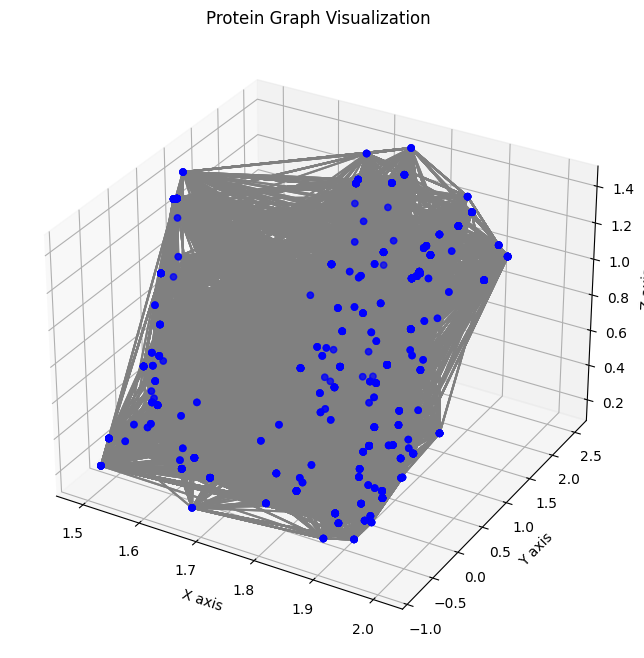

In [7]:
import os
import random
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_protein_graph(graph):
 
    pos = graph.x[:, 2:5]  


    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], s=20, c='blue')


    for edge in graph.edge_index.t():
        start, end = edge[0].item(), edge[1].item()
        xs, ys, zs = zip(pos[start], pos[end])
        ax.plot(xs, ys, zs, color='gray')

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    plt.title("Protein Graph Visualization")
    plt.show()


saved_graphs_folder = 'sg'


graph_files = [f for f in os.listdir(saved_graphs_folder) if f.endswith('.pt')]


selected_graph_file = random.choice(graph_files)


graph_path = os.path.join(saved_graphs_folder, selected_graph_file)
graph = torch.load(graph_path)


plot_protein_graph(graph)


# Training with a basic GCN Model (0.8 train 0.2 test)

Epoch 0, Loss: 190.67340645370444
Epoch 10, Loss: 0.04731454943186632
Epoch 20, Loss: 0.006730366650840409
Epoch 30, Loss: 0.002055546992746842
Epoch 40, Loss: 0.001794532151867948
Epoch 50, Loss: 0.001730206592554706
Epoch 60, Loss: 0.0017006584239607598
Epoch 70, Loss: 0.0016939923966401264
Epoch 80, Loss: 0.0017012402930321367
Epoch 90, Loss: 0.0016972995562901435
Epoch 100, Loss: 0.0016951074877344823
Epoch 110, Loss: 0.0016954013759349184
Epoch 120, Loss: 0.0016950562645526618
Epoch 130, Loss: 0.001696336821304498
Epoch 140, Loss: 0.0016964231618296945
Epoch 150, Loss: 0.0016972553040653698
Epoch 160, Loss: 0.0016963698061818351
Epoch 170, Loss: 0.0016964064889260918
Epoch 180, Loss: 0.0016964153034492093
Epoch 190, Loss: 0.0016959754324574574
Epoch 200, Loss: 0.0016962416158363609
Epoch 210, Loss: 0.001696355654823562
Epoch 220, Loss: 0.0016963951391014552
Epoch 230, Loss: 0.0016964091381327408
Epoch 240, Loss: 0.0016964140777327107
Epoch 250, Loss: 0.0016964157799819965
Epoch 26

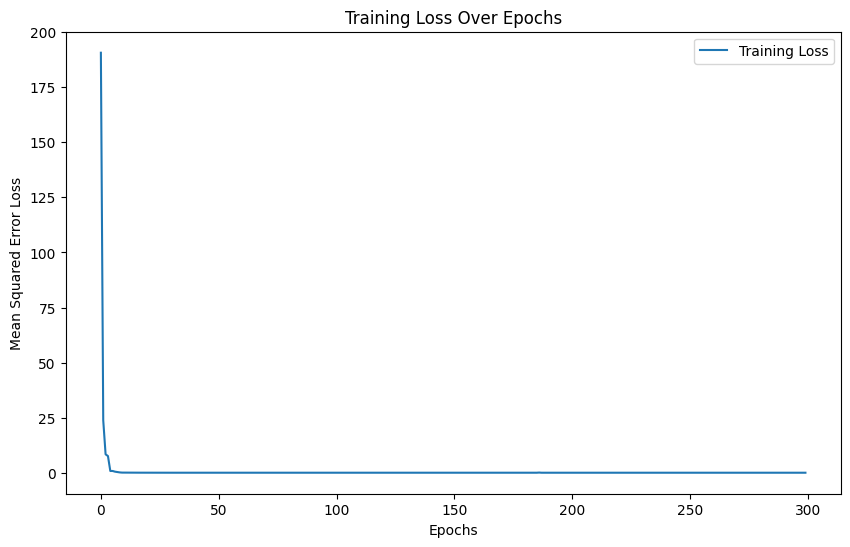

Test MSE: 0.06008666983515794


In [27]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import matplotlib.pyplot as plt

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):  # Corrected init method
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x

def load_graph_data():
    graph_files = os.listdir('saved_graphs2')  
    datasets = []

    for file in graph_files:
        data = torch.load(os.path.join('saved_graphs2', file))  
        datasets.append(data)  

    return datasets

datasets = load_graph_data()

train_size = int(0.8 * len(datasets))
train_dataset = datasets[:train_size]
test_dataset = datasets[train_size:]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_features=datasets[0].num_node_features, hidden_channels=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

model.train()
loss_values = [] 
for epoch in range(300):
    total_loss = 0
    for data in train_dataset:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data).squeeze()
        loss = criterion(out, data.y) / data.num_nodes  
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_nodes 
    epoch_loss = total_loss/data.num_nodes
    loss_values.append(epoch_loss)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {epoch_loss}')

plt.figure(figsize=(10, 6))
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

model.eval()
test_loss = 0
with torch.no_grad():
    for data in test_dataset:
        data = data.to(device)
        pred = model(data).squeeze()
        loss = criterion(pred, data.y) / data.num_nodes  
        test_loss += loss.item() * data.num_nodes  
print(f'Test MSE: {test_loss / sum(data.num_nodes for data in test_dataset)}')

# Correlation Loss GCN

Epoch 0, Train Loss: 0.9587, Test Loss: 1.0320, Train Pearson: 0.0482, Test Pearson: -0.0320
Epoch 500, Train Loss: 0.9464, Test Loss: 0.9645, Train Pearson: 0.0708, Test Pearson: 0.0355
Epoch 1000, Train Loss: 0.2442, Test Loss: 0.5554, Train Pearson: 0.7370, Test Pearson: 0.4446
Epoch 1500, Train Loss: 0.1969, Test Loss: 0.3954, Train Pearson: 0.7799, Test Pearson: 0.6046
Epoch 2000, Train Loss: 0.1775, Test Loss: 0.3268, Train Pearson: 0.8119, Test Pearson: 0.6732
Epoch 2500, Train Loss: 0.1597, Test Loss: 0.2354, Train Pearson: 0.8406, Test Pearson: 0.7646
Epoch 3000, Train Loss: 0.2407, Test Loss: 0.2238, Train Pearson: 0.7653, Test Pearson: 0.7762
Epoch 3500, Train Loss: 0.1664, Test Loss: 0.1995, Train Pearson: 0.8315, Test Pearson: 0.8005
Epoch 4000, Train Loss: 0.1729, Test Loss: 0.2021, Train Pearson: 0.8236, Test Pearson: 0.7979
Epoch 4500, Train Loss: 0.2107, Test Loss: 0.2321, Train Pearson: 0.7964, Test Pearson: 0.7679


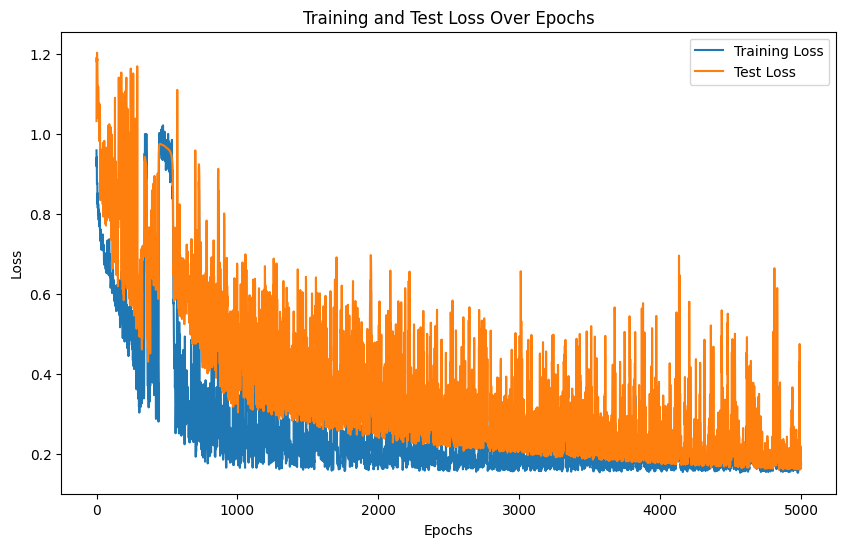

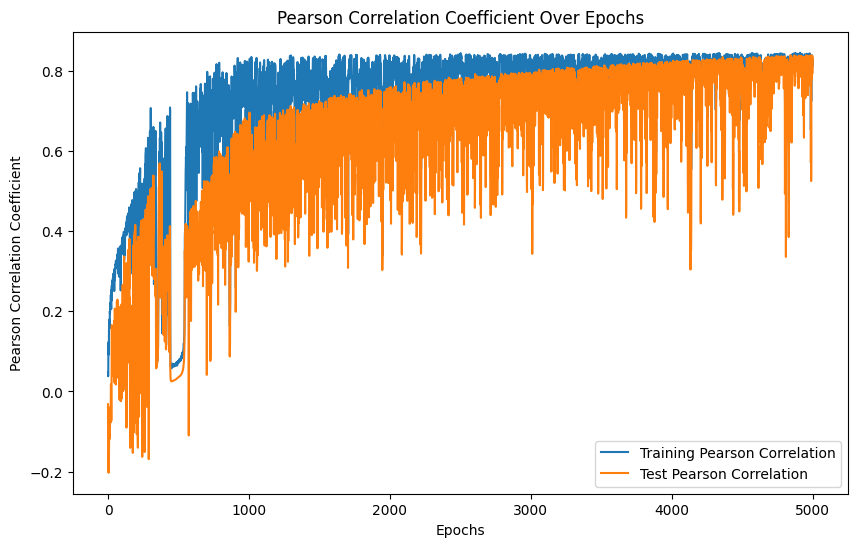

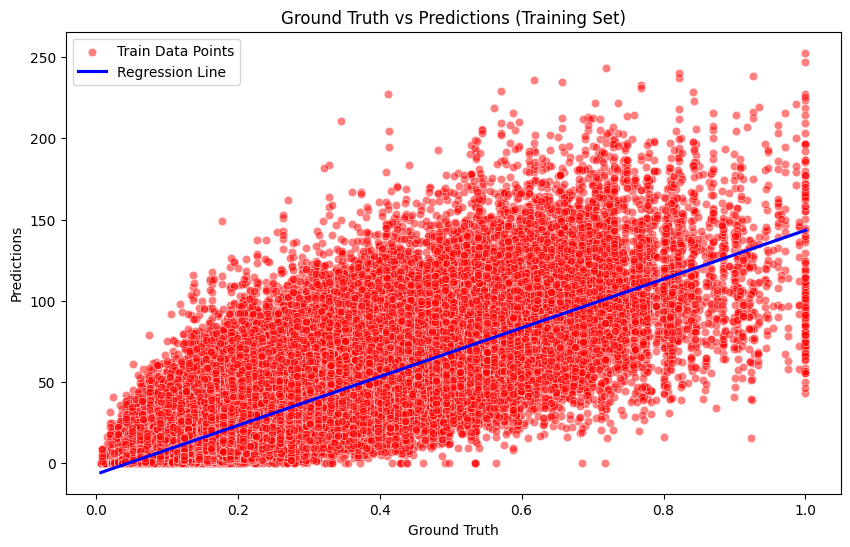

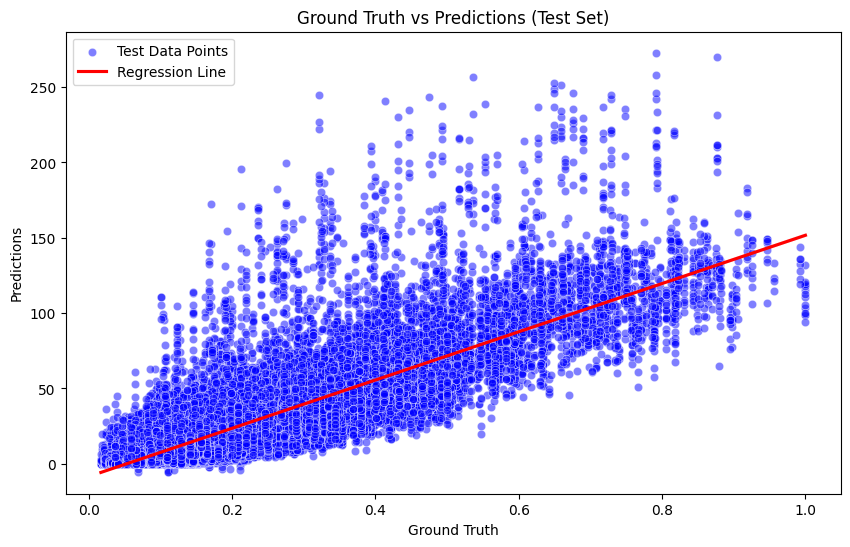

In [47]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, Batch
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns


class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x


def correlation_loss(y_pred, y_true):
    centered_y_pred = y_pred - torch.mean(y_pred)
    centered_y_true = y_true - torch.mean(y_true)
    denominator = torch.sqrt(torch.sum(centered_y_pred ** 2)) * torch.sqrt(torch.sum(centered_y_true ** 2))
    
    if denominator == 0:
        return torch.tensor(0.0).to(y_pred.device)
    
    loss = 1 - torch.sum(centered_y_pred * centered_y_true) / denominator
    return loss


def load_graph_data(directory='saved_graphs2'):
    graph_files = os.listdir(directory)  
    datasets = [torch.load(os.path.join(directory, file)) for file in graph_files]
    return datasets

datasets = load_graph_data()
train_size = int(0.8 * len(datasets))
train_dataset, test_dataset = datasets[:train_size], datasets[train_size:]


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_features=datasets[0].num_node_features, hidden_channels=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


num_epochs = 5000
train_loss_history, test_loss_history = [], []
train_pearson_history, test_pearson_history = [], []

for epoch in range(num_epochs):
    model.train()
    total_train_loss, total_test_loss = 0, 0
    train_predictions, train_ground_truth = [], []
    test_predictions, test_ground_truth = [], []

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data).squeeze()
        loss = correlation_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        

        train_predictions.extend(out.cpu().detach().numpy())
        train_ground_truth.extend(data.y.cpu().detach().numpy())

    train_pearson_corr = pearsonr(train_predictions, train_ground_truth)[0]
    train_pearson_history.append(train_pearson_corr)
    train_loss_history.append(total_train_loss / len(train_loader))

    model.eval()
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data).squeeze()
            loss = correlation_loss(out, data.y)
            total_test_loss += loss.item()


            test_predictions.extend(out.cpu().numpy())
            test_ground_truth.extend(data.y.cpu().numpy())


    test_pearson_corr = pearsonr(test_predictions, test_ground_truth)[0]
    test_pearson_history.append(test_pearson_corr)
    test_loss_history.append(total_test_loss / len(test_loader))
    if epoch%500==0:
        print(f'Epoch {epoch}, Train Loss: {train_loss_history[-1]:.4f}, Test Loss: {test_loss_history[-1]:.4f}, Train Pearson: {train_pearson_corr:.4f}, Test Pearson: {test_pearson_corr:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(train_pearson_history, label='Training Pearson Correlation')
plt.plot(test_pearson_history, label='Test Pearson Correlation')
plt.xlabel('Epochs')
plt.ylabel('Pearson Correlation Coefficient')
plt.title('Pearson Correlation Coefficient Over Epochs')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_ground_truth, y=train_predictions, color="red", alpha=0.5, label='Train Data Points')
sns.regplot(x=train_ground_truth, y=train_predictions, scatter=False, color='blue', label='Regression Line')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title('Ground Truth vs Predictions (Training Set)')
plt.legend()
plt.show()

# Scatter Plot with Regression Line (for Testing)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=test_ground_truth, y=test_predictions, color="blue", alpha=0.5, label='Test Data Points')
sns.regplot(x=test_ground_truth, y=test_predictions, scatter=False, color='red', label='Regression Line')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title('Ground Truth vs Predictions (Test Set)')
plt.legend()
plt.show()

# Training with a GAT Model with MAE Loss

Epoch: 0, Train Loss: 586.2986, Test Loss: 89.3470
Epoch: 200, Train Loss: 0.1928, Test Loss: 65.3488
Epoch: 400, Train Loss: 0.1246, Test Loss: 15.7237
Epoch: 600, Train Loss: 0.1054, Test Loss: 14.0188
Epoch: 800, Train Loss: 0.1018, Test Loss: 14.3964
Epoch: 1000, Train Loss: 0.1021, Test Loss: 14.7233
Epoch: 1200, Train Loss: 0.1024, Test Loss: 15.7158
Epoch: 1400, Train Loss: 0.1019, Test Loss: 15.9747
Epoch: 1600, Train Loss: 0.1016, Test Loss: 17.1729
Epoch: 1800, Train Loss: 0.1004, Test Loss: 14.7404
Epoch: 2000, Train Loss: 0.1020, Test Loss: 16.8774
Epoch: 2200, Train Loss: 0.1013, Test Loss: 13.2588
Epoch: 2400, Train Loss: 0.1019, Test Loss: 10.8757
Epoch: 2600, Train Loss: 0.1011, Test Loss: 6.0067
Epoch: 2800, Train Loss: 0.1013, Test Loss: 5.3987
Epoch: 3000, Train Loss: 0.1021, Test Loss: 4.3919
Epoch: 3200, Train Loss: 0.1021, Test Loss: 2.8976
Epoch: 3400, Train Loss: 0.1026, Test Loss: 1.7729
Epoch: 3600, Train Loss: 0.1022, Test Loss: 11.3717
Epoch: 3800, Train Los

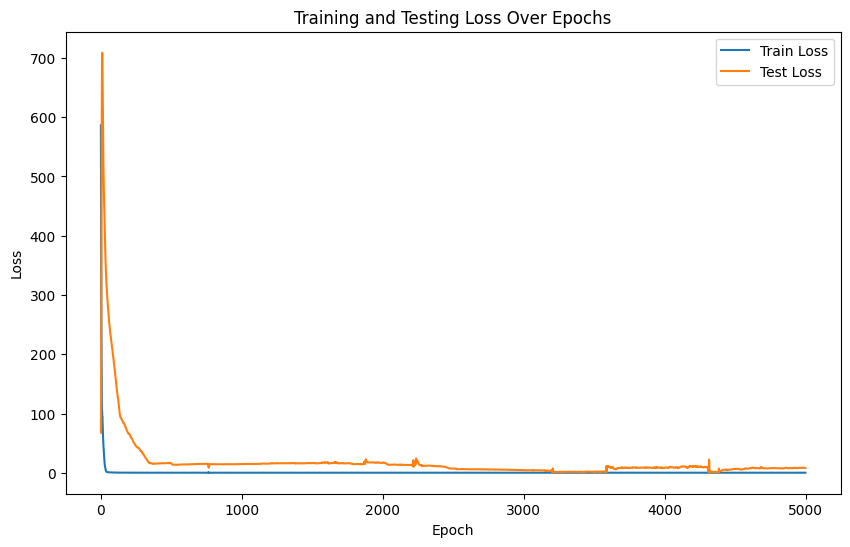

In [22]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import DataLoader
from torch.nn import L1Loss
import matplotlib.pyplot as plt

class GAT(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, 1)  

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x


saved_graphs_folder = 'sg'
graph_files = [f for f in os.listdir(saved_graphs_folder) if f.endswith('.pt')]
datasets = [torch.load(os.path.join(saved_graphs_folder, f)) for f in graph_files]

train_size = int(0.9 * len(datasets))
train_dataset = datasets[:train_size]
test_dataset = datasets[train_size:]

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = GAT(num_features=datasets[0].num_node_features, hidden_channels=16).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = L1Loss()  # MAE loss


def train():
    model.train()
    total_loss = 0
    for data iner.zero_grad()
        out = m train_loader:
        data = data.to(device)
        optimizodel(data).squeeze()
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)


def test(loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = model(data).squeeze()
            total_loss += criterion(pred, data.y).item()
    return total_loss / len(loader)


train_losses = []
test_losses = []


for epoch in range(5000):
    train_loss = train()
    test_loss = test(test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    if epoch%200==0:
        print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.show()


# GAT Model with Correlation Loss

/home/flahaari/.local/lib/python3.8/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Train Loss: 0.9976, Test Loss: 0.8921, Train Pearson: -0.0456, Test Pearson: 0.1079


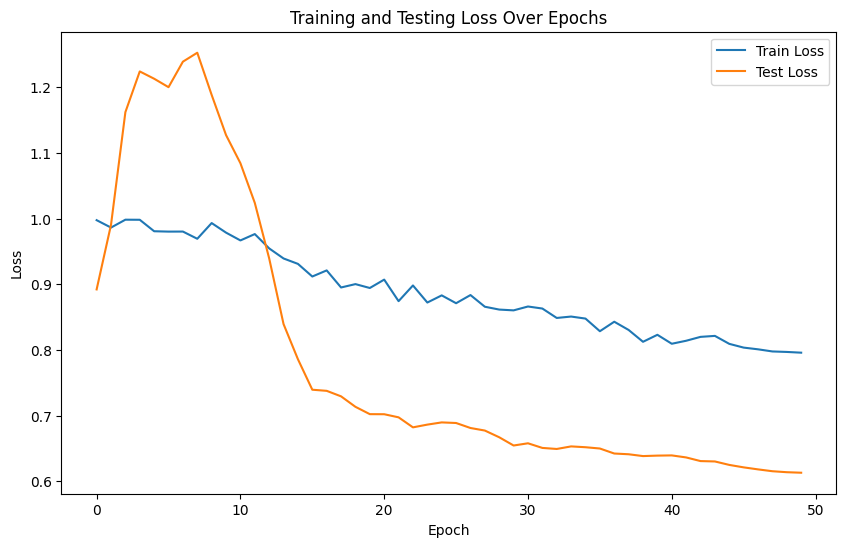

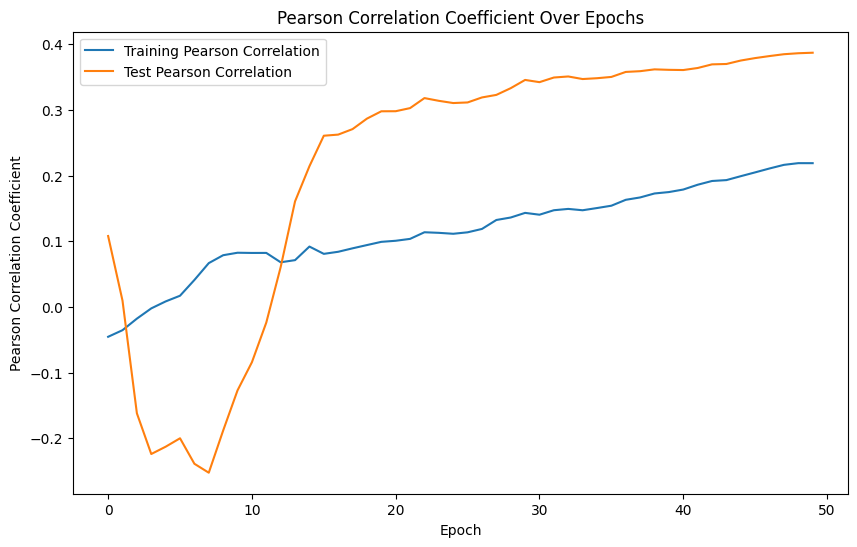

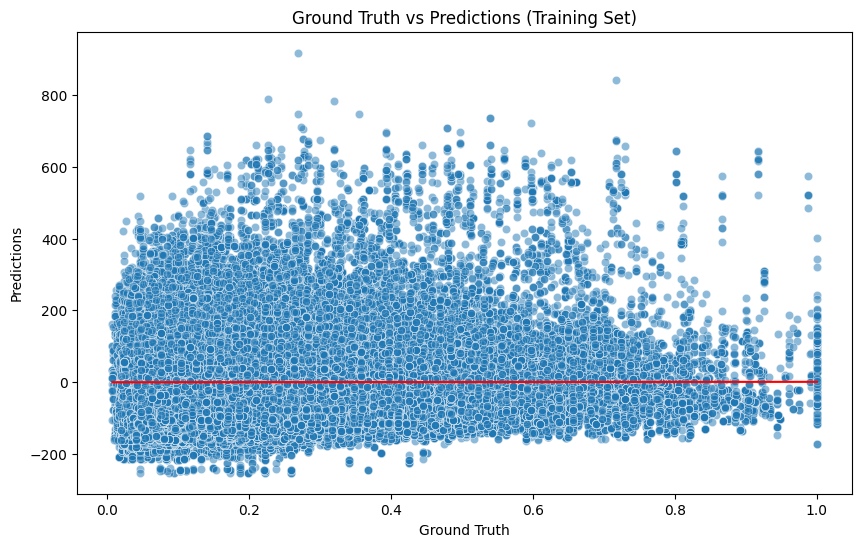

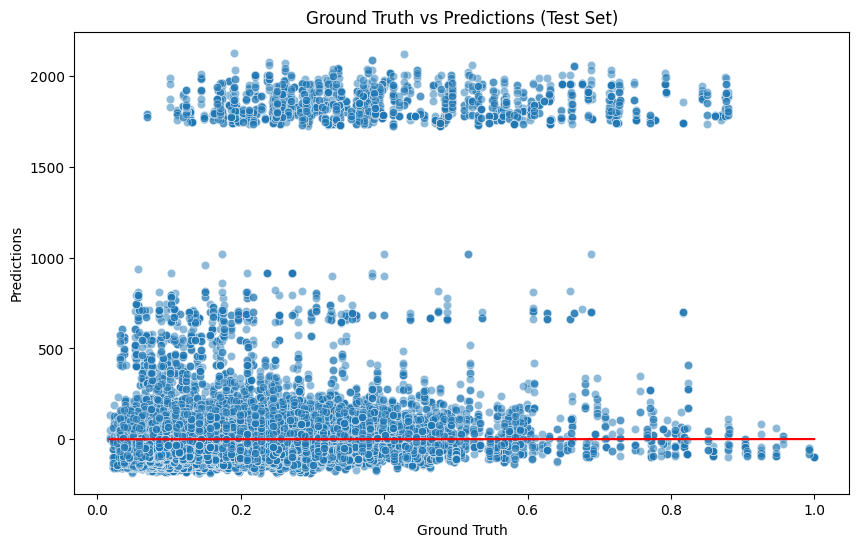

In [1]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import DataLoader
from torch.nn import L1Loss
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

class GAT(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x

def correlation_loss(y_pred, y_true):
    centered_y_pred = y_pred - torch.mean(y_pred)
    centered_y_true = y_true - torch.mean(y_true)
    denominator = torch.sqrt(torch.sum(centered_y_pred ** 2)) * torch.sqrt(torch.sum(centered_y_true ** 2))
    if denominator == 0:
        return torch.tensor(0.0).to(y_pred.device)
    loss = 1 - torch.sum(centered_y_pred * centered_y_true) / denominator
    return loss


def plot_scatter(ground_truth, predictions, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=ground_truth, y=predictions, alpha=0.5)
    sns.lineplot(x=ground_truth, y=ground_truth, color='red')  # Perfect correlation line
    plt.xlabel('Ground Truth')
    plt.ylabel('Predictions')
    plt.title(title)
    plt.show()

def get_predictions_and_ground_truths(loader):
    predictions, ground_truths = [], []
    model.eval()
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = model(data).squeeze()
            predictions.extend(pred.cpu().numpy())
            ground_truths.extend(data.y.cpu().numpy())
    return predictions, ground_truths

saved_graphs_folder = 'sg'
graph_files = [f for f in os.listdir(saved_graphs_folder) if f.endswith('.pt')]
datasets = [torch.load(os.path.join(saved_graphs_folder, f)) for f in graph_files]

train_size = int(0.9 * len(datasets))
train_dataset = datasets[:train_size]
test_dataset = datasets[train_size:]

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GAT(num_features=datasets[0].num_node_features, hidden_channels=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data).squeeze()
        loss = correlation_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def test(loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = model(data).squeeze()
            total_loss += correlation_loss(pred, data.y).item()
    return total_loss / len(loader)

train_losses = []
test_losses = []
train_pearson_history = []
test_pearson_history = []

for epoch in range(50):
    train_loss = train()
    test_loss = test(test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    train_predictions, train_ground_truth = get_predictions_and_ground_truths(train_loader)
    test_predictions, test_ground_truth = get_predictions_and_ground_truths(test_loader)
    train_pearson_corr = pearsonr(train_predictions, train_ground_truth)[0]
    test_pearson_corr = pearsonr(test_predictions, test_ground_truth)[0]
    train_pearson_history.append(train_pearson_corr)
    test_pearson_history.append(test_pearson_corr)

    if epoch % 200 == 0:
        print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Pearson: {train_pearson_corr:.4f}, Test Pearson: {test_pearson_corr:.4f}')




plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_pearson_history, label='Training Pearson Correlation')
plt.plot(test_pearson_history, label='Test Pearson Correlation')
plt.xlabel('Epoch')
plt.ylabel('Pearson Correlation Coefficient')
plt.title('Pearson Correlation Coefficient Over Epochs')
plt.legend()
plt.show()


plot_scatter(train_ground_truth, train_predictions, 'Ground Truth vs Predictions (Training Set)')
plot_scatter(test_ground_truth, test_predictions, 'Ground Truth vs Predictions (Test Set)')

# Equivariance Check on GAT

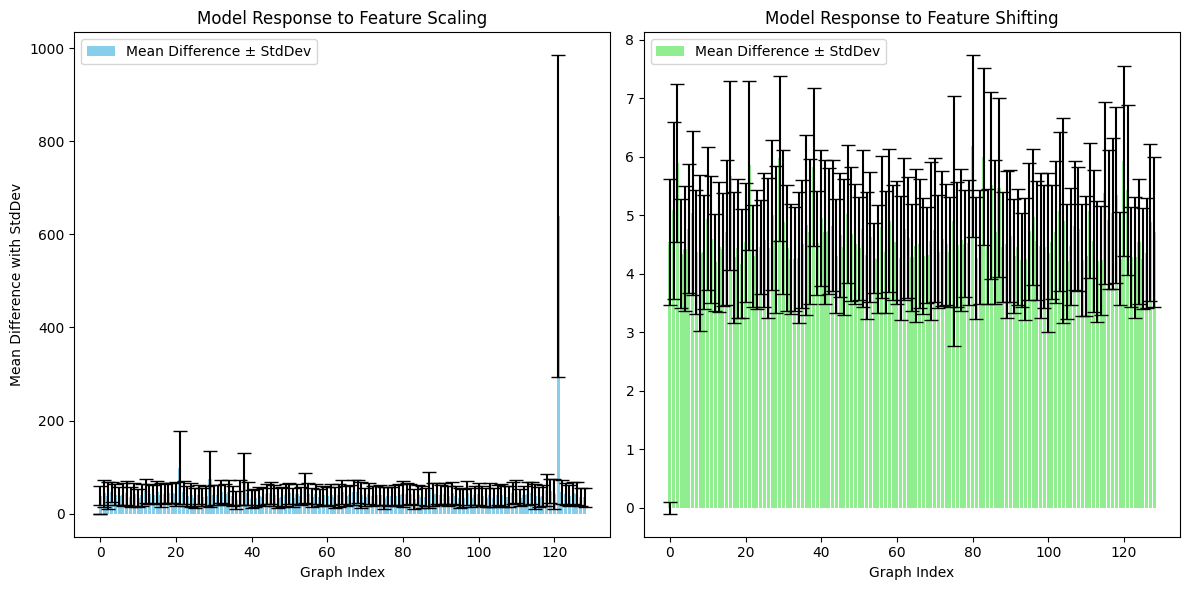

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import copy


def scale_features(features, scale_factor):
    return features * scale_factor


def shift_features(features, shift_value):
    return features + shift_value


def compare_outputs(original, transformed):
    return np.linalg.norm(original - transformed, axis=1)


scaling_factor = 1.5 
shift_value = 0.5  


all_scaling_metrics = []
all_shifting_metrics = []


for data in datasets:
    original_features = data.x.numpy()


    scaled_features = scale_features(original_features, scaling_factor)
    shifted_features = shift_features(original_features, shift_value)


    scaled_data = copy.deepcopy(data)
    shifted_data = copy.deepcopy(data)
    scaled_data.x = torch.tensor(scaled_features, dtype=torch.float32)
    shifted_data.x = torch.tensor(shifted_features, dtype=torch.float32)


    model.eval()
    with torch.no_grad():
        original_output = model(data.to(device)).cpu().numpy()
        scaled_output = model(scaled_data.to(device)).cpu().numpy()
        shifted_output = model(shifted_data.to(device)).cpu().numpy()


    all_scaling_metrics.append(compare_outputs(original_output, scaled_output))
    all_shifting_metrics.append(compare_outputs(original_output, shifted_output))


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)

plt.bar(0, 0, color='skyblue', yerr=0.1, capsize=5, label='Mean Difference ± StdDev')
plt.legend()

for i, metric in enumerate(all_scaling_metrics):
    plt.bar(i, np.mean(metric), yerr=np.std(metric), color='skyblue', capsize=5)
plt.title('Model Response to Feature Scaling')
plt.xlabel('Graph Index')
plt.ylabel('Mean Difference with StdDev')


plt.subplot(1, 2, 2)

plt.bar(0, 0, color='lightgreen', yerr=0.1, capsize=5, label='Mean Difference ± StdDev')
plt.legend()

for i, metric in enumerate(all_shifting_metrics):
    plt.bar(i, np.mean(metric), yerr=np.std(metric), color='lightgreen', capsize=5)
plt.title('Model Response to Feature Shifting')
plt.xlabel('Graph Index')

plt.tight_layout()
plt.show()

Epoch: 0, Train Loss: 176.7726, Test Loss: 195.7319
Epoch: 0, Train Loss: 176.7726, Test Loss: 195.7319
Epoch: 1, Train Loss: 118.1168, Test Loss: 133.6483
Epoch: 2, Train Loss: 98.9276, Test Loss: 96.2031
Epoch: 3, Train Loss: 75.9683, Test Loss: 87.6728
Epoch: 4, Train Loss: 49.6575, Test Loss: 42.0557
Epoch: 5, Train Loss: 35.9323, Test Loss: 20.0687
Epoch: 6, Train Loss: 58.0656, Test Loss: 17.5095
Epoch: 7, Train Loss: 31.8793, Test Loss: 11.6562
Epoch: 8, Train Loss: 41.9527, Test Loss: 28.6808
Epoch: 9, Train Loss: 29.8479, Test Loss: 49.8710
Epoch: 10, Train Loss: 25.8327, Test Loss: 37.1698
Epoch: 11, Train Loss: 19.5111, Test Loss: 23.0087
Epoch: 12, Train Loss: 15.5664, Test Loss: 18.4415
Epoch: 13, Train Loss: 12.2534, Test Loss: 17.8199
Epoch: 14, Train Loss: 10.7111, Test Loss: 14.3700
Epoch: 15, Train Loss: 8.9999, Test Loss: 9.3828
Epoch: 16, Train Loss: 7.0426, Test Loss: 6.5026
Epoch: 17, Train Loss: 6.2795, Test Loss: 4.8736
Epoch: 18, Train Loss: 5.5886, Test Loss: 

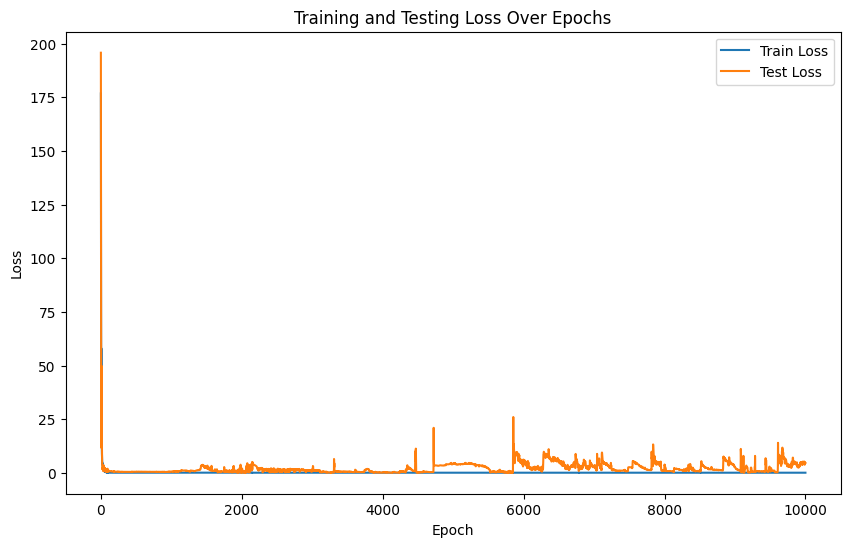

In [23]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import DataLoader
from torch.nn import L1Loss
import matplotlib.pyplot as plt

class GAT(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):  # Correctly named __init method
        super(GAT, self).__init__()  # Correctly formatted super() call
        self.conv1 = GATConv(num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x

saved_graphs_folder = 'sgwv'
graph_files = [f for f in os.listdir(saved_graphs_folder) if f.endswith('.pt')]
datasets = [torch.load(os.path.join(saved_graphs_folder, f)) for f in graph_files]

train_size = int(0.8 * len(datasets))
train_dataset = datasets[:train_size]
test_dataset = datasets[train_size:]

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(num_features=datasets[0].num_node_features, hidden_channels=16).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = L1Loss()  # MAE loss

def train():
    model.train()
    total_loss = 0
    total_nodes = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data).squeeze()
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_nodes
        total_nodes += data.num_nodes
    return total_loss / total_nodes

def test(loader):
    model.eval()
    total_loss = 0
    total_nodes = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = model(data).squeeze()
            loss = criterion(pred, data.y)
            total_loss += loss.item() * data.num_nodes
            total_nodes += data.num_nodes
    return total_loss / total_nodes

train_losses = []
test_losses = []

for epoch in range(10000):
    train_loss = train()
    test_loss = test(test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    if epoch <= 100:
        if epoch <= 25:
            print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
        if 26 <= epoch <= 100:
            if epoch%10==0:
                print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
            
        
    if epoch % 500 == 0:
        print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.show()

# Implementing GVP

Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:28,  1.53s/it]

Epoch 0, Loss: 893.9936


Epochs:  10%|███████▉                                                                       | 2/20 [00:03<00:28,  1.56s/it]

Epoch 1, Loss: 308.9537


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:26,  1.58s/it]

Epoch 2, Loss: 65.1430


Epochs:  20%|███████████████▊                                                               | 4/20 [00:06<00:23,  1.49s/it]

Epoch 3, Loss: 1.6285


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:21,  1.43s/it]

Epoch 4, Loss: 0.0669


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:19,  1.39s/it]

Epoch 5, Loss: 0.0489


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:10<00:17,  1.36s/it]

Epoch 6, Loss: 0.0783


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:16,  1.34s/it]

Epoch 7, Loss: 0.0540


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.32s/it]

Epoch 8, Loss: 0.0501


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.33s/it]

Epoch 9, Loss: 0.0471


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:15<00:11,  1.33s/it]

Epoch 10, Loss: 0.0446


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.32s/it]

Epoch 11, Loss: 0.0433


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:18<00:09,  1.37s/it]

Epoch 12, Loss: 0.0380


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:19<00:08,  1.36s/it]

Epoch 13, Loss: 0.0535


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:20<00:06,  1.35s/it]

Epoch 14, Loss: 0.0696


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:22<00:05,  1.34s/it]

Epoch 15, Loss: 0.0807


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:23<00:04,  1.37s/it]

Epoch 16, Loss: 0.0371


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:24<00:02,  1.37s/it]

Epoch 17, Loss: 0.0790


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:26<00:01,  1.35s/it]

Epoch 18, Loss: 0.0594


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]

Epoch 19, Loss: 0.0660


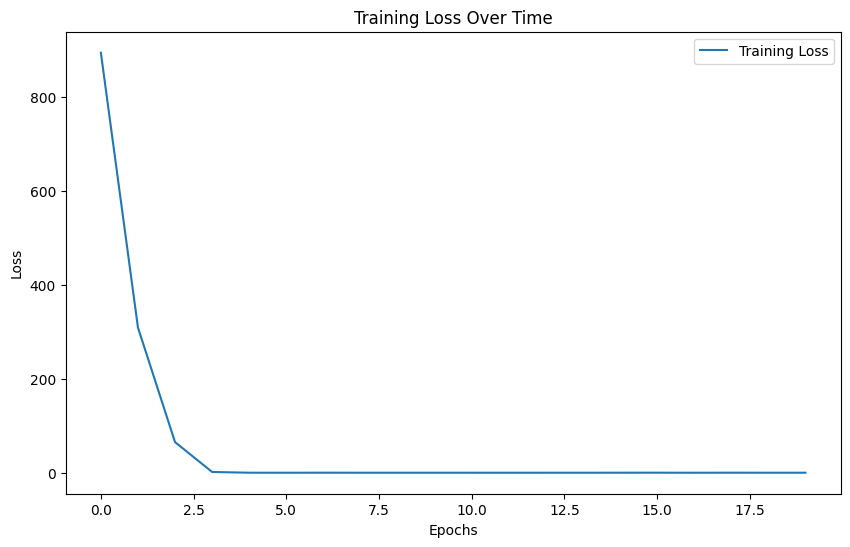

In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import DataLoader
import gvp
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch_geometric.nn as geom_nn

class GVP_RNN_Model(nn.Module):
    def __init__(self, scalar_feature_indices, vector_feature_indices, node_out_dims):
        super(GVP_RNN_Model, self).__init__()
        self.scalar_feature_indices = scalar_feature_indices
        self.vector_feature_indices = vector_feature_indices
        scalar_in = len(scalar_feature_indices)
        vector_in = len(vector_feature_indices) // 3

        node_in_dims = (scalar_in, vector_in)
        self.gvp1 = gvp.GVP(node_in_dims, (node_out_dims, node_out_dims // 3), vector_gate=True, activations=(F.relu, None))
        self.gvp2 = gvp.GVP((node_out_dims, node_out_dims // 3), (1, 0))

    def forward(self, data):
        scalar_x = data.x[:, self.scalar_feature_indices]
        vector_x = data.x[:, self.vector_feature_indices].view(-1, len(self.vector_feature_indices) // 3, 3)
    
        x = (scalar_x, vector_x)
        x = self.gvp1(x)
        x = self.gvp2(x)
    
       
        if x[0].shape[0] == data.x.shape[0]:
            x = geom_nn.global_mean_pool(x[0], data.batch)
        return x

def load_graph_data():
    saved_graphs_folder = 'saved_graphs2'
    graph_files = [f for f in os.listdir(saved_graphs_folder) if f.endswith('.pt')]
    datasets = [torch.load(os.path.join(saved_graphs_folder, f)) for f in graph_files]
    return datasets

datasets = load_graph_data()

scalar_feature_indices = [0, 1, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
vector_feature_indices = [2, 3, 4, 11, 12, 13]
node_out_dims = 128

model = GVP_RNN_Model(scalar_feature_indices, vector_feature_indices, node_out_dims)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def train_model(datasets, model, criterion, optimizer, epochs=20, batch_size=128):
    train_losses = []
    data_loader = DataLoader(datasets, batch_size=batch_size, shuffle=True)
    for epoch in tqdm(range(epochs), desc="Epochs"):
        model.train()
        total_loss = 0
        for batch_data in data_loader:
            batch_data = batch_data.to(device)
            optimizer.zero_grad()
            output = model(batch_data)
            
            output = output.squeeze()  
            loss = criterion(output, batch_data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(data_loader)  
        train_losses.append(avg_loss)
        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")
    return train_losses

loss_history = train_model(datasets, model, criterion, optimizer)

plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

# GVP With Correlation Loss

/home/flahaari/.local/lib/python3.8/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Epochs:   2%|█▌                                                                             | 1/50 [00:01<01:12,  1.48s/it]

Epoch 0, Loss: 0.9595, Pearson Correlation: 0.12813162812090492


Epochs:   4%|███▏                                                                           | 2/50 [00:02<00:46,  1.03it/s]

Epoch 1, Loss: 0.9399, Pearson Correlation: 0.13170179435415896


Epochs:   6%|████▋                                                                          | 3/50 [00:02<00:42,  1.12it/s]

Epoch 2, Loss: 0.9446, Pearson Correlation: 0.12880387936471033


Epochs:   8%|██████▎                                                                        | 4/50 [00:04<00:46,  1.02s/it]

Epoch 3, Loss: 0.9388, Pearson Correlation: 0.1273644228217901


Epochs:  10%|███████▉                                                                       | 5/50 [00:05<00:49,  1.10s/it]

Epoch 4, Loss: 0.9175, Pearson Correlation: 0.12649232738192948


Epochs:  12%|█████████▍                                                                     | 6/50 [00:05<00:40,  1.07it/s]

Epoch 5, Loss: 0.9314, Pearson Correlation: 0.12812240350603069


Epochs:  14%|███████████                                                                    | 7/50 [00:06<00:34,  1.23it/s]

Epoch 6, Loss: 0.8942, Pearson Correlation: 0.12371405703551495


Epochs:  16%|████████████▋                                                                  | 8/50 [00:07<00:32,  1.30it/s]

Epoch 7, Loss: 0.9010, Pearson Correlation: 0.12368281637794405


Epochs:  18%|██████████████▏                                                                | 9/50 [00:07<00:30,  1.35it/s]

Epoch 8, Loss: 1.0159, Pearson Correlation: 0.1286355676698543


Epochs:  20%|███████████████▌                                                              | 10/50 [00:08<00:27,  1.44it/s]

Epoch 9, Loss: 0.9565, Pearson Correlation: 0.12885999424665995


Epochs:  22%|█████████████████▏                                                            | 11/50 [00:09<00:26,  1.45it/s]

Epoch 10, Loss: 0.9309, Pearson Correlation: 0.1300808957564718


Epochs:  24%|██████████████████▋                                                           | 12/50 [00:09<00:25,  1.47it/s]

Epoch 11, Loss: 0.9051, Pearson Correlation: 0.13006359592535424


Epochs:  26%|████████████████████▎                                                         | 13/50 [00:10<00:24,  1.50it/s]

Epoch 12, Loss: 0.9073, Pearson Correlation: 0.1282059251070901


Epochs:  28%|█████████████████████▊                                                        | 14/50 [00:11<00:23,  1.52it/s]

Epoch 13, Loss: 0.9190, Pearson Correlation: 0.1291683567614179


Epochs:  30%|███████████████████████▍                                                      | 15/50 [00:11<00:23,  1.51it/s]

Epoch 14, Loss: 0.9700, Pearson Correlation: 0.12929216200127056


Epochs:  32%|████████████████████████▉                                                     | 16/50 [00:12<00:21,  1.55it/s]

Epoch 15, Loss: 0.9023, Pearson Correlation: 0.12911645539094027


Epochs:  34%|██████████████████████████▌                                                   | 17/50 [00:13<00:21,  1.54it/s]

Epoch 16, Loss: 0.8536, Pearson Correlation: 0.13122614289403367


Epochs:  36%|████████████████████████████                                                  | 18/50 [00:13<00:20,  1.53it/s]

Epoch 17, Loss: 0.9175, Pearson Correlation: 0.13192736848901374


Epochs:  38%|█████████████████████████████▋                                                | 19/50 [00:14<00:19,  1.56it/s]

Epoch 18, Loss: 0.9199, Pearson Correlation: 0.1311076775072211


Epochs:  40%|███████████████████████████████▏                                              | 20/50 [00:14<00:19,  1.51it/s]

Epoch 19, Loss: 0.8924, Pearson Correlation: 0.13155371956526807


Epochs:  42%|████████████████████████████████▊                                             | 21/50 [00:15<00:19,  1.52it/s]

Epoch 20, Loss: 0.8830, Pearson Correlation: 0.1319426676800235


Epochs:  44%|██████████████████████████████████▎                                           | 22/50 [00:16<00:19,  1.41it/s]

Epoch 21, Loss: 0.9630, Pearson Correlation: 0.13182564910388908


Epochs:  46%|███████████████████████████████████▉                                          | 23/50 [00:17<00:20,  1.33it/s]

Epoch 22, Loss: 0.9646, Pearson Correlation: 0.1320186694740603


Epochs:  48%|█████████████████████████████████████▍                                        | 24/50 [00:17<00:18,  1.42it/s]

Epoch 23, Loss: 0.9367, Pearson Correlation: 0.1323273471787412


Epochs:  50%|███████████████████████████████████████                                       | 25/50 [00:18<00:17,  1.46it/s]

Epoch 24, Loss: 0.8791, Pearson Correlation: 0.1338898743628486


Epochs:  52%|████████████████████████████████████████▌                                     | 26/50 [00:19<00:15,  1.54it/s]

Epoch 25, Loss: 0.9081, Pearson Correlation: 0.13319548400304254


Epochs:  54%|██████████████████████████████████████████                                    | 27/50 [00:19<00:14,  1.56it/s]

Epoch 26, Loss: 0.9041, Pearson Correlation: 0.1310181650571986


Epochs:  56%|███████████████████████████████████████████▋                                  | 28/50 [00:20<00:13,  1.60it/s]

Epoch 27, Loss: 0.8840, Pearson Correlation: 0.13350851609882547


Epochs:  58%|█████████████████████████████████████████████▏                                | 29/50 [00:20<00:12,  1.62it/s]

Epoch 28, Loss: 0.8801, Pearson Correlation: 0.13446450444450667


Epochs:  60%|██████████████████████████████████████████████▊                               | 30/50 [00:21<00:12,  1.67it/s]

Epoch 29, Loss: 0.9038, Pearson Correlation: 0.1346211280253518


Epochs:  62%|████████████████████████████████████████████████▎                             | 31/50 [00:22<00:13,  1.41it/s]

Epoch 30, Loss: 0.9025, Pearson Correlation: 0.13602916714523136


Epochs:  64%|█████████████████████████████████████████████████▉                            | 32/50 [00:23<00:12,  1.45it/s]

Epoch 31, Loss: 0.8383, Pearson Correlation: 0.1396459101326933


Epochs:  66%|███████████████████████████████████████████████████▍                          | 33/50 [00:23<00:11,  1.52it/s]

Epoch 32, Loss: 0.9084, Pearson Correlation: 0.12986830908069974


Epochs:  68%|█████████████████████████████████████████████████████                         | 34/50 [00:24<00:10,  1.47it/s]

Epoch 33, Loss: 0.8951, Pearson Correlation: 0.12661126028799669


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 35/50 [00:25<00:10,  1.47it/s]

Epoch 34, Loss: 0.9115, Pearson Correlation: 0.1303719279694038


Epochs:  72%|████████████████████████████████████████████████████████▏                     | 36/50 [00:25<00:08,  1.56it/s]

Epoch 35, Loss: 0.9062, Pearson Correlation: 0.12978989420824497


Epochs:  74%|█████████████████████████████████████████████████████████▋                    | 37/50 [00:26<00:08,  1.57it/s]

Epoch 36, Loss: 0.9121, Pearson Correlation: 0.1272314313519489


Epochs:  76%|███████████████████████████████████████████████████████████▎                  | 38/50 [00:26<00:07,  1.64it/s]

Epoch 37, Loss: 0.9457, Pearson Correlation: 0.13061620000642182


Epochs:  78%|████████████████████████████████████████████████████████████▊                 | 39/50 [00:27<00:06,  1.67it/s]

Epoch 38, Loss: 0.8868, Pearson Correlation: 0.12659476933019123


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 40/50 [00:27<00:05,  1.70it/s]

Epoch 39, Loss: 0.8883, Pearson Correlation: 0.13118059909088614


Epochs:  82%|███████████████████████████████████████████████████████████████▉              | 41/50 [00:28<00:05,  1.71it/s]

Epoch 40, Loss: 0.8531, Pearson Correlation: 0.14158237197428858


Epochs:  84%|█████████████████████████████████████████████████████████████████▌            | 42/50 [00:29<00:04,  1.70it/s]

Epoch 41, Loss: 0.9275, Pearson Correlation: 0.1415562230752298


Epochs:  86%|███████████████████████████████████████████████████████████████████           | 43/50 [00:29<00:04,  1.70it/s]

Epoch 42, Loss: 0.8550, Pearson Correlation: 0.13920261199973097


Epochs:  88%|████████████████████████████████████████████████████████████████████▋         | 44/50 [00:30<00:03,  1.71it/s]

Epoch 43, Loss: 0.8501, Pearson Correlation: 0.15260973114665033


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 45/50 [00:30<00:02,  1.72it/s]

Epoch 44, Loss: 0.8496, Pearson Correlation: 0.1520705670286559


Epochs:  92%|███████████████████████████████████████████████████████████████████████▊      | 46/50 [00:31<00:02,  1.75it/s]

Epoch 45, Loss: 0.8756, Pearson Correlation: 0.15522665174503186


Epochs:  94%|█████████████████████████████████████████████████████████████████████████▎    | 47/50 [00:32<00:01,  1.74it/s]

Epoch 46, Loss: 0.8097, Pearson Correlation: 0.160188726631394


Epochs:  96%|██████████████████████████████████████████████████████████████████████████▉   | 48/50 [00:32<00:01,  1.53it/s]

Epoch 47, Loss: 0.8056, Pearson Correlation: 0.15885188960823252


Epochs:  98%|████████████████████████████████████████████████████████████████████████████▍ | 49/50 [00:33<00:00,  1.52it/s]

Epoch 48, Loss: 0.8460, Pearson Correlation: 0.15509993063764238


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.47it/s]

Epoch 49, Loss: 0.8328, Pearson Correlation: 0.15342713993183735


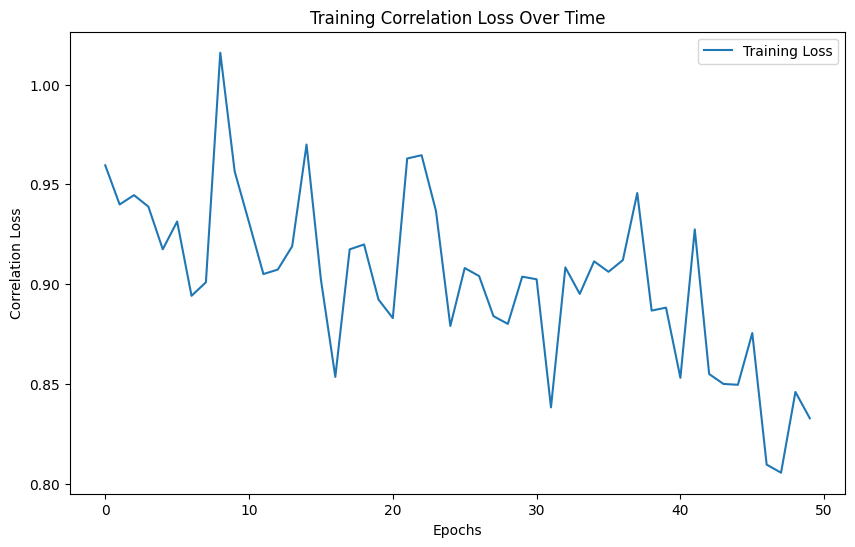

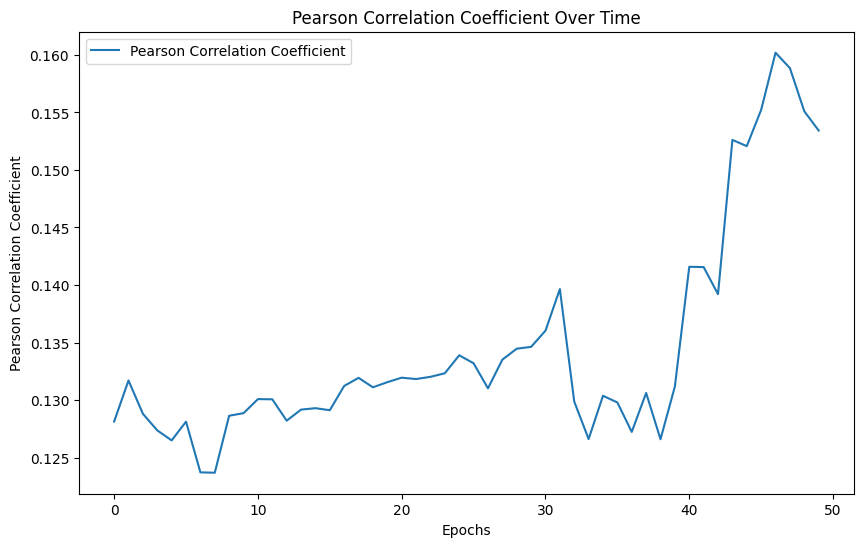

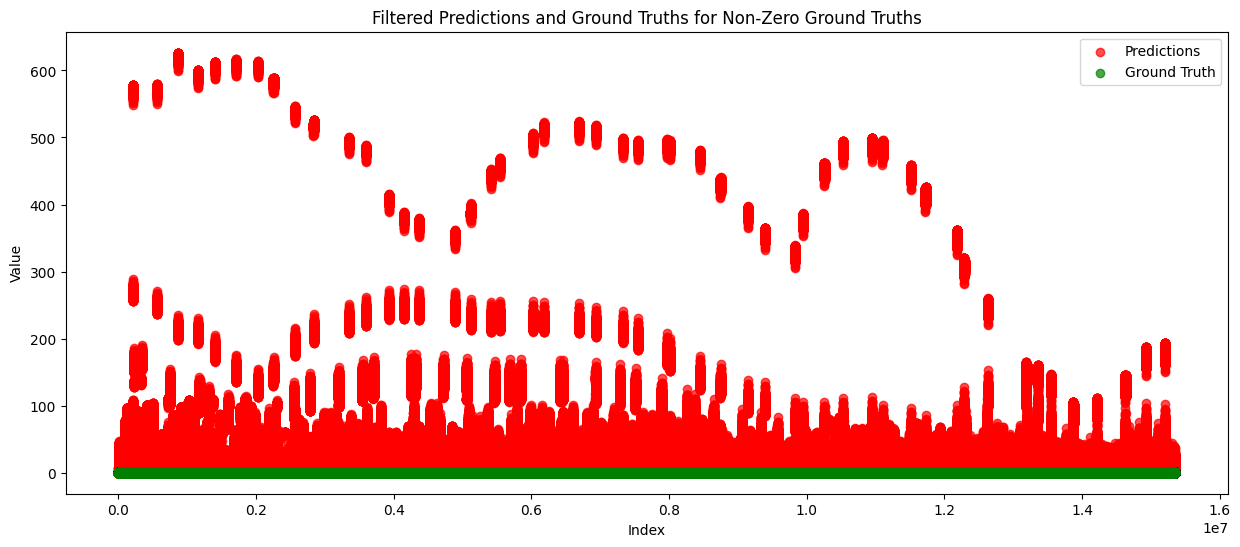

In [2]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import DataLoader
import gvp
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch_geometric.nn as geom_nn
from scipy.stats import pearsonr

class GVP_RNN_Model(nn.Module):
    def __init__(self, scalar_feature_indices, vector_feature_indices, node_out_dims):
        super(GVP_RNN_Model, self).__init__()
        self.scalar_feature_indices = scalar_feature_indices
        self.vector_feature_indices = vector_feature_indices
        scalar_in = len(scalar_feature_indices)
        vector_in = len(vector_feature_indices) // 3

        node_in_dims = (scalar_in, vector_in)
        self.gvp1 = gvp.GVP(node_in_dims, (node_out_dims, node_out_dims // 3), vector_gate=True, activations=(F.relu, None))
        self.gvp2 = gvp.GVP((node_out_dims, node_out_dims // 3), (1, 0))

    def forward(self, data):
        scalar_x = data.x[:, self.scalar_feature_indices]
        vector_x = data.x[:, self.vector_feature_indices].view(-1, len(self.vector_feature_indices) // 3, 3)
    
        x = (scalar_x, vector_x)
        x = self.gvp1(x)
        x = self.gvp2(x)
    
       
        if x[0].shape[0] == data.x.shape[0]:
            x = geom_nn.global_mean_pool(x[0], data.batch)
        return x

def load_graph_data():
    saved_graphs_folder = 'saved_graphs2'
    graph_files = [f for f in os.listdir(saved_graphs_folder) if f.endswith('.pt')]
    datasets = [torch.load(os.path.join(saved_graphs_folder, f)) for f in graph_files]
    return datasets

def correlation_loss(y_pred, y_true):
    centered_y_pred = y_pred - torch.mean(y_pred)
    centered_y_true = y_true - torch.mean(y_true)

    denominator = torch.sqrt(torch.sum(centered_y_pred ** 2)) * torch.sqrt(torch.sum(centered_y_true ** 2))


    epsilon = 1e-8
    denominator = torch.clamp(denominator, min=epsilon)

    correlation = torch.sum(centered_y_pred * centered_y_true) / denominator


    if correlation.requires_grad:
        loss = 1 - correlation
    else:
        
        loss = torch.tensor(0.0, device=y_pred.device, requires_grad=True)

    return loss


datasets = load_graph_data()

scalar_feature_indices = [0, 1, 5, 7, 8, 9, 10, 18, 19, 20, 21, 22, 23, 24, 25, 6, 14, 15, 16, 17]
vector_feature_indices = [11, 12, 13, 2, 3, 4] 
node_out_dims = 32

model = GVP_RNN_Model(scalar_feature_indices, vector_feature_indices, node_out_dims)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


from scipy.stats import pearsonr

def train_model(datasets, model, criterion, optimizer, epochs=20, batch_size=128):
    train_losses = []
    pearson_history = []
    all_predictions = []
    all_ground_truth = []

    data_loader = DataLoader(datasets, batch_size=batch_size, shuffle=True)

    for epoch in tqdm(range(epochs), desc="Epochs"):
        model.train()
        total_loss = 0
        epoch_predictions = []
        epoch_ground_truth = []

        for batch_data in data_loader:
            batch_data = batch_data.to(device)
            optimizer.zero_grad()
            output = model(batch_data)

           
            if output.numel() == 0 or not output.requires_grad:
                print("Empty or non-grad output")
                continue

            output = output.squeeze()
            loss = correlation_loss(output, batch_data.y)

    
            if torch.isnan(loss) or torch.isinf(loss) or not loss.requires_grad:
                print(f"Invalid loss: {loss.item()}")
                continue

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            epoch_predictions.extend(output.detach().cpu().numpy())
            epoch_ground_truth.extend(batch_data.y.detach().cpu().numpy())

        avg_loss = total_loss / len(data_loader)
        train_losses.append(avg_loss)

 
        if len(epoch_predictions) > 1 and len(epoch_ground_truth) > 1:
            pearson_corr = pearsonr(epoch_predictions, epoch_ground_truth)[0]
            pearson_history.append(pearson_corr)
        else:
            pearson_corr = None

        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}, Pearson Correlation: {pearson_corr}")

        all_predictions.extend(epoch_predictions)
        all_ground_truth.extend(epoch_ground_truth)

    return train_losses, pearson_history, all_predictions, all_ground_truth

loss_history, pearson_history, predictions, ground_truths = train_model(datasets, model, criterion, optimizer, epochs=50, batch_size=32)


# Plotting the training correlation loss
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Correlation Loss')
plt.title('Training Correlation Loss Over Time')
plt.legend()
plt.show()

# Plotting the Pearson correlation coefficient over epochs
plt.figure(figsize=(10, 6))
plt.plot(pearson_history, label='Pearson Correlation Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Pearson Correlation Coefficient')
plt.title('Pearson Correlation Coefficient Over Time')
plt.legend()
plt.show()



predictions = np.array(predictions) 
ground_truths = np.array(ground_truths) 


non_zero_indices = np.where(ground_truths != 0)[0]
filtered_predictions = predictions[non_zero_indices]
filtered_ground_truths = ground_truths[non_zero_indices]

if len(filtered_ground_truths) > 0:
    plt.figure(figsize=(15, 6))
    plt.scatter(range(len(filtered_predictions)), filtered_predictions, color='red', label='Predictions', alpha=0.7)
    plt.scatter(range(len(filtered_ground_truths)), filtered_ground_truths, color='green', label='Ground Truth', alpha=0.7)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Filtered Predictions and Ground Truths for Non-Zero Ground Truths')
    plt.legend()
    plt.show()
else:
    print("No non-zero ground truths found.")


Epochs:   2%|█▌                                                                             | 1/50 [00:00<00:34,  1.42it/s]

Epoch 1/50, Train Loss: 1.0522, Test Loss: 0.0000


Epochs:   4%|███▏                                                                           | 2/50 [00:01<00:34,  1.37it/s]

Epoch 2/50, Train Loss: 1.0741, Test Loss: 0.0000


Epochs:   6%|████▋                                                                          | 3/50 [00:02<00:31,  1.50it/s]

Epoch 3/50, Train Loss: 1.0695, Test Loss: 0.0000


Epochs:   8%|██████▎                                                                        | 4/50 [00:02<00:30,  1.52it/s]

Epoch 4/50, Train Loss: 1.0910, Test Loss: 0.0000


Epochs:  10%|███████▉                                                                       | 5/50 [00:03<00:30,  1.50it/s]

Epoch 5/50, Train Loss: 1.0404, Test Loss: 0.0000


Epochs:  12%|█████████▍                                                                     | 6/50 [00:03<00:28,  1.56it/s]

Epoch 6/50, Train Loss: 1.0347, Test Loss: 0.0000


Epochs:  14%|███████████                                                                    | 7/50 [00:04<00:27,  1.55it/s]

Epoch 7/50, Train Loss: 1.0465, Test Loss: 0.0000


Epochs:  16%|████████████▋                                                                  | 8/50 [00:05<00:26,  1.57it/s]

Epoch 8/50, Train Loss: 1.0069, Test Loss: 0.0000


Epochs:  18%|██████████████▏                                                                | 9/50 [00:05<00:25,  1.58it/s]

Epoch 9/50, Train Loss: 1.0247, Test Loss: 0.0000


Epochs:  20%|███████████████▌                                                              | 10/50 [00:06<00:25,  1.60it/s]

Epoch 10/50, Train Loss: 1.0500, Test Loss: 0.0000


Epochs:  22%|█████████████████▏                                                            | 11/50 [00:07<00:24,  1.59it/s]

Epoch 11/50, Train Loss: 1.0059, Test Loss: 0.0000


Epochs:  24%|██████████████████▋                                                           | 12/50 [00:07<00:23,  1.61it/s]

Epoch 12/50, Train Loss: 1.0160, Test Loss: 0.0000


Epochs:  26%|████████████████████▎                                                         | 13/50 [00:08<00:23,  1.60it/s]

Epoch 13/50, Train Loss: 0.9957, Test Loss: 0.0000


Epochs:  28%|█████████████████████▊                                                        | 14/50 [00:08<00:21,  1.65it/s]

Epoch 14/50, Train Loss: 1.0064, Test Loss: 0.0000


Epochs:  30%|███████████████████████▍                                                      | 15/50 [00:09<00:21,  1.61it/s]

Epoch 15/50, Train Loss: 0.9346, Test Loss: 0.0000


Epochs:  32%|████████████████████████▉                                                     | 16/50 [00:10<00:24,  1.41it/s]

Epoch 16/50, Train Loss: 0.9348, Test Loss: 0.0000


Epochs:  34%|██████████████████████████▌                                                   | 17/50 [00:11<00:21,  1.51it/s]

Epoch 17/50, Train Loss: 0.9265, Test Loss: 0.0000


Epochs:  36%|████████████████████████████                                                  | 18/50 [00:11<00:20,  1.54it/s]

Epoch 18/50, Train Loss: 0.9544, Test Loss: 0.0000


Epochs:  38%|█████████████████████████████▋                                                | 19/50 [00:12<00:19,  1.62it/s]

Epoch 19/50, Train Loss: 0.9509, Test Loss: 0.0000


Epochs:  40%|███████████████████████████████▏                                              | 20/50 [00:12<00:18,  1.62it/s]

Epoch 20/50, Train Loss: 0.9294, Test Loss: 0.0000


Epochs:  42%|████████████████████████████████▊                                             | 21/50 [00:13<00:17,  1.64it/s]

Epoch 21/50, Train Loss: 0.9214, Test Loss: 0.0000


Epochs:  44%|██████████████████████████████████▎                                           | 22/50 [00:13<00:16,  1.66it/s]

Epoch 22/50, Train Loss: 0.9070, Test Loss: 0.0000


Epochs:  46%|███████████████████████████████████▉                                          | 23/50 [00:14<00:15,  1.69it/s]

Epoch 23/50, Train Loss: 0.8950, Test Loss: 0.0000


Epochs:  48%|█████████████████████████████████████▍                                        | 24/50 [00:15<00:15,  1.69it/s]

Epoch 24/50, Train Loss: 0.8792, Test Loss: 0.0000


Epochs:  50%|███████████████████████████████████████                                       | 25/50 [00:15<00:14,  1.67it/s]

Epoch 25/50, Train Loss: 0.8678, Test Loss: 0.0000


Epochs:  52%|████████████████████████████████████████▌                                     | 26/50 [00:16<00:14,  1.64it/s]

Epoch 26/50, Train Loss: 0.8632, Test Loss: 0.0000


Epochs:  54%|██████████████████████████████████████████                                    | 27/50 [00:16<00:12,  1.78it/s]

Epoch 27/50, Train Loss: 0.8704, Test Loss: 0.0000


Epochs:  56%|███████████████████████████████████████████▋                                  | 28/50 [00:17<00:10,  2.06it/s]

Epoch 28/50, Train Loss: 0.8500, Test Loss: 0.0000


Epochs:  58%|█████████████████████████████████████████████▏                                | 29/50 [00:17<00:09,  2.19it/s]

Epoch 29/50, Train Loss: 0.8606, Test Loss: 0.0000


Epochs:  60%|██████████████████████████████████████████████▊                               | 30/50 [00:17<00:08,  2.46it/s]

Epoch 30/50, Train Loss: 0.8404, Test Loss: 0.0000


Epochs:  62%|████████████████████████████████████████████████▎                             | 31/50 [00:18<00:07,  2.68it/s]

Epoch 31/50, Train Loss: 0.8479, Test Loss: 0.0000


Epochs:  64%|█████████████████████████████████████████████████▉                            | 32/50 [00:18<00:06,  2.77it/s]

Epoch 32/50, Train Loss: 0.8449, Test Loss: 0.0000


Epochs:  66%|███████████████████████████████████████████████████▍                          | 33/50 [00:18<00:05,  2.94it/s]

Epoch 33/50, Train Loss: 0.8583, Test Loss: 0.0000


Epochs:  68%|█████████████████████████████████████████████████████                         | 34/50 [00:19<00:05,  3.06it/s]

Epoch 34/50, Train Loss: 0.8576, Test Loss: 0.0000


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 35/50 [00:19<00:05,  2.87it/s]

Epoch 35/50, Train Loss: 0.8417, Test Loss: 0.0000


Epochs:  72%|████████████████████████████████████████████████████████▏                     | 36/50 [00:19<00:04,  3.00it/s]

Epoch 36/50, Train Loss: 0.8492, Test Loss: 0.0000


Epochs:  74%|█████████████████████████████████████████████████████████▋                    | 37/50 [00:20<00:04,  3.09it/s]

Epoch 37/50, Train Loss: 0.8325, Test Loss: 0.0000


Epochs:  76%|███████████████████████████████████████████████████████████▎                  | 38/50 [00:20<00:03,  3.04it/s]

Epoch 38/50, Train Loss: 0.8192, Test Loss: 0.0000


Epochs:  78%|████████████████████████████████████████████████████████████▊                 | 39/50 [00:20<00:03,  3.03it/s]

Epoch 39/50, Train Loss: 0.8456, Test Loss: 0.0000


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 40/50 [00:21<00:03,  3.11it/s]

Epoch 40/50, Train Loss: 0.8250, Test Loss: 0.0000


Epochs:  82%|███████████████████████████████████████████████████████████████▉              | 41/50 [00:21<00:03,  2.93it/s]

Epoch 41/50, Train Loss: 0.8090, Test Loss: 0.0000


Epochs:  84%|█████████████████████████████████████████████████████████████████▌            | 42/50 [00:21<00:02,  3.04it/s]

Epoch 42/50, Train Loss: 0.8290, Test Loss: 0.0000


Epochs:  86%|███████████████████████████████████████████████████████████████████           | 43/50 [00:22<00:02,  3.08it/s]

Epoch 43/50, Train Loss: 0.7985, Test Loss: 0.0000


Epochs:  88%|████████████████████████████████████████████████████████████████████▋         | 44/50 [00:22<00:02,  2.91it/s]

Epoch 44/50, Train Loss: 0.8323, Test Loss: 0.0000


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 45/50 [00:22<00:01,  3.04it/s]

Epoch 45/50, Train Loss: 0.8062, Test Loss: 0.0000


Epochs:  92%|███████████████████████████████████████████████████████████████████████▊      | 46/50 [00:22<00:01,  3.13it/s]

Epoch 46/50, Train Loss: 0.7941, Test Loss: 0.0000


Epochs:  94%|█████████████████████████████████████████████████████████████████████████▎    | 47/50 [00:23<00:00,  3.10it/s]

Epoch 47/50, Train Loss: 0.8058, Test Loss: 0.0000


Epochs:  96%|██████████████████████████████████████████████████████████████████████████▉   | 48/50 [00:23<00:00,  3.03it/s]

Epoch 48/50, Train Loss: 0.8337, Test Loss: 0.0000


Epochs:  98%|████████████████████████████████████████████████████████████████████████████▍ | 49/50 [00:23<00:00,  3.09it/s]

Epoch 49/50, Train Loss: 0.8010, Test Loss: 0.0000


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.06it/s]

Epoch 50/50, Train Loss: 0.8097, Test Loss: 0.0000


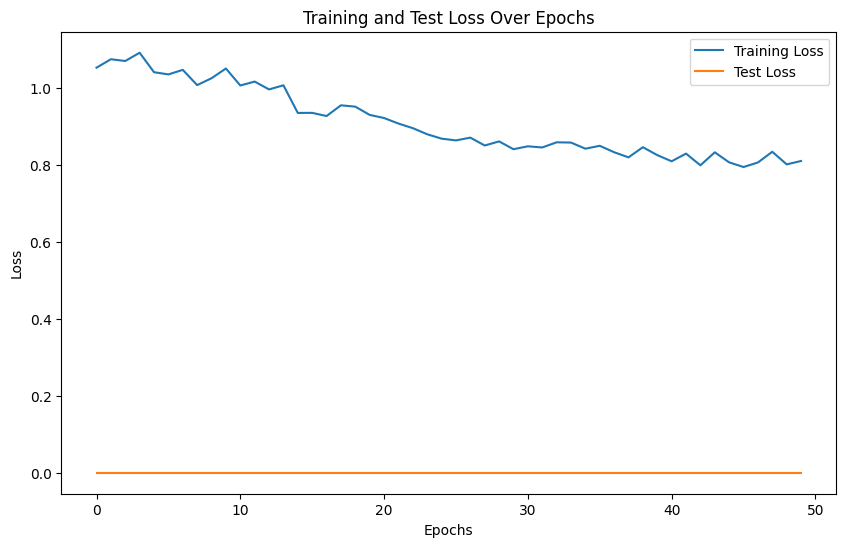

In [5]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import DataLoader
import gvp
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch_geometric.nn as geom_nn
from scipy.stats import pearsonr

# Assuming GVP_RNN_Model, load_graph_data, and correlation_loss are defined as in your provided code

datasets = load_graph_data()

# Split datasets into training and testing
train_size = int(len(datasets) * 0.8)
train_datasets = datasets[:train_size]
test_datasets = datasets[train_size:]

scalar_feature_indices = [0, 1, 5, 7, 8, 9, 10, 18, 19, 20, 21, 22, 23, 24, 25, 6, 14, 15, 16, 17]
vector_feature_indices = [11, 12, 13, 2, 3, 4]
node_out_dims = 32

model = GVP_RNN_Model(scalar_feature_indices, vector_feature_indices, node_out_dims)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def evaluate_model(test_loader, model, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track gradients during evaluation
        for batch_data in test_loader:
            batch_data = batch_data.to(device)
            output = model(batch_data)

            # Debugging: Check the output size and content
            print(f"Output size: {output.size()}, Output sample: {output[:5]}")

            output_cpu = output.detach().to('cpu')
            labels_cpu = batch_data.y.to('cpu')

            # Debugging: Check the label size and content
            print(f"Labels size: {labels_cpu.size()}, Labels sample: {labels_cpu[:5]}")

            loss = correlation_loss(output_cpu, labels_cpu)
            print(f"Batch loss: {loss.item()}")  # Debugging: Check the loss for each batch

            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Average test loss: {avg_loss}")  # Debugging: Check the average test loss
    return avg_loss

from torch.utils.data import random_split
import torch

def train_model(datasets, model, criterion, optimizer, epochs=20, batch_size=128, accumulation_steps=4):
    # Split datasets into training and testing
    train_size = int(len(datasets) * 0.8)
    train_datasets, test_datasets = random_split(datasets, [train_size, len(datasets) - train_size])

    train_loader = DataLoader(train_datasets, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_datasets, batch_size=batch_size, shuffle=False)

    train_losses = []
    test_losses = []

    for epoch in tqdm(range(epochs), desc="Epochs"):
        model.train()
        total_loss = 0
        for i, batch_data in enumerate(train_loader):
            batch_data = batch_data.to(device)
            output = model(batch_data)
            loss = correlation_loss(output.squeeze(), batch_data.y)
            
            # Scale loss to account for gradient accumulation
            loss = loss / accumulation_steps
            loss.backward()
            
            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
                
            total_loss += loss.item() * accumulation_steps  # Scale back up

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Test loss calculation
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for batch_data in test_loader:
                batch_data = batch_data.to(device)
                output = model(batch_data)
                test_loss = correlation_loss(output.squeeze(), batch_data.y)
                total_test_loss += test_loss.item()

        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

    # Plotting losses
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss Over Epochs')
    plt.legend()
    plt.show()

    return train_losses, test_losses

# Assuming your model, optimizer, and datasets are already defined and loaded
train_losses, test_losses = train_model(datasets, model, criterion, optimizer, epochs=50, batch_size=32, accumulation_steps=4)

# Checking for Equivariance 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import copy

def rotation_matrix_z(angle):
    return np.array([[np.cos(angle), -np.sin(angle), 0], 
                     [np.sin(angle), np.cos(angle), 0], 
                     [0, 0, 1]])

def rotate_vectors_z_axis(vectors, angle):
    rot_mat = rotation_matrix_z(angle)
    return np.dot(vectors, rot_mat.T)


def scale_vectors(vectors, scale_factor):
    return vectors * scale_factor


def translate_vectors(vectors, translation_vector):
    return vectors + translation_vector


def compare_outputs(original, transformed):
    return np.linalg.norm(original - transformed, axis=1)


rotation_angle = np.pi / 4  # 45 degrees
scaling_factor = 1.5
translation_vector = np.array([1, 1, 1])


all_rotation_metrics = []
all_scaling_metrics = []
all_translation_metrics = []

for data in datasets:

    vector_features = data.x[:, vector_feature_indices].view(-1, len(vector_feature_indices) // 3, 3).numpy()
    rotated_vectors = rotate_vectors_z_axis(vector_features, rotation_angle)
    scaled_vectors = scale_vectors(vector_features, scaling_factor)
    translated_vectors = translate_vectors(vector_features, translation_vector)


    rotated_data = copy.deepcopy(data)
    scaled_data = copy.deepcopy(data)
    translated_data = copy.deepcopy(data)
    rotated_data.x[:, vector_feature_indices] = torch.tensor(rotated_vectors.reshape(-1, len(vector_feature_indices)), dtype=torch.float32)
    scaled_data.x[:, vector_feature_indices] = torch.tensor(scaled_vectors.reshape(-1, len(vector_feature_indices)), dtype=torch.float32)
    translated_data.x[:, vector_feature_indices] = torch.tensor(translated_vectors.reshape(-1, len(vector_feature_indices)), dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        original_output = model(data.to(device)).cpu().numpy()
        rotated_output = model(rotated_data.to(device)).cpu().numpy()
        scaled_output = model(scaled_data.to(device)).cpu().numpy()
        translated_output = model(translated_data.to(device)).cpu().numpy()

    all_rotation_metrics.append(compare_outputs(original_output, rotated_output))
    all_scaling_metrics.append(compare_outputs(original_output, scaled_output))
    all_translation_metrics.append(compare_outputs(original_output, translated_output))


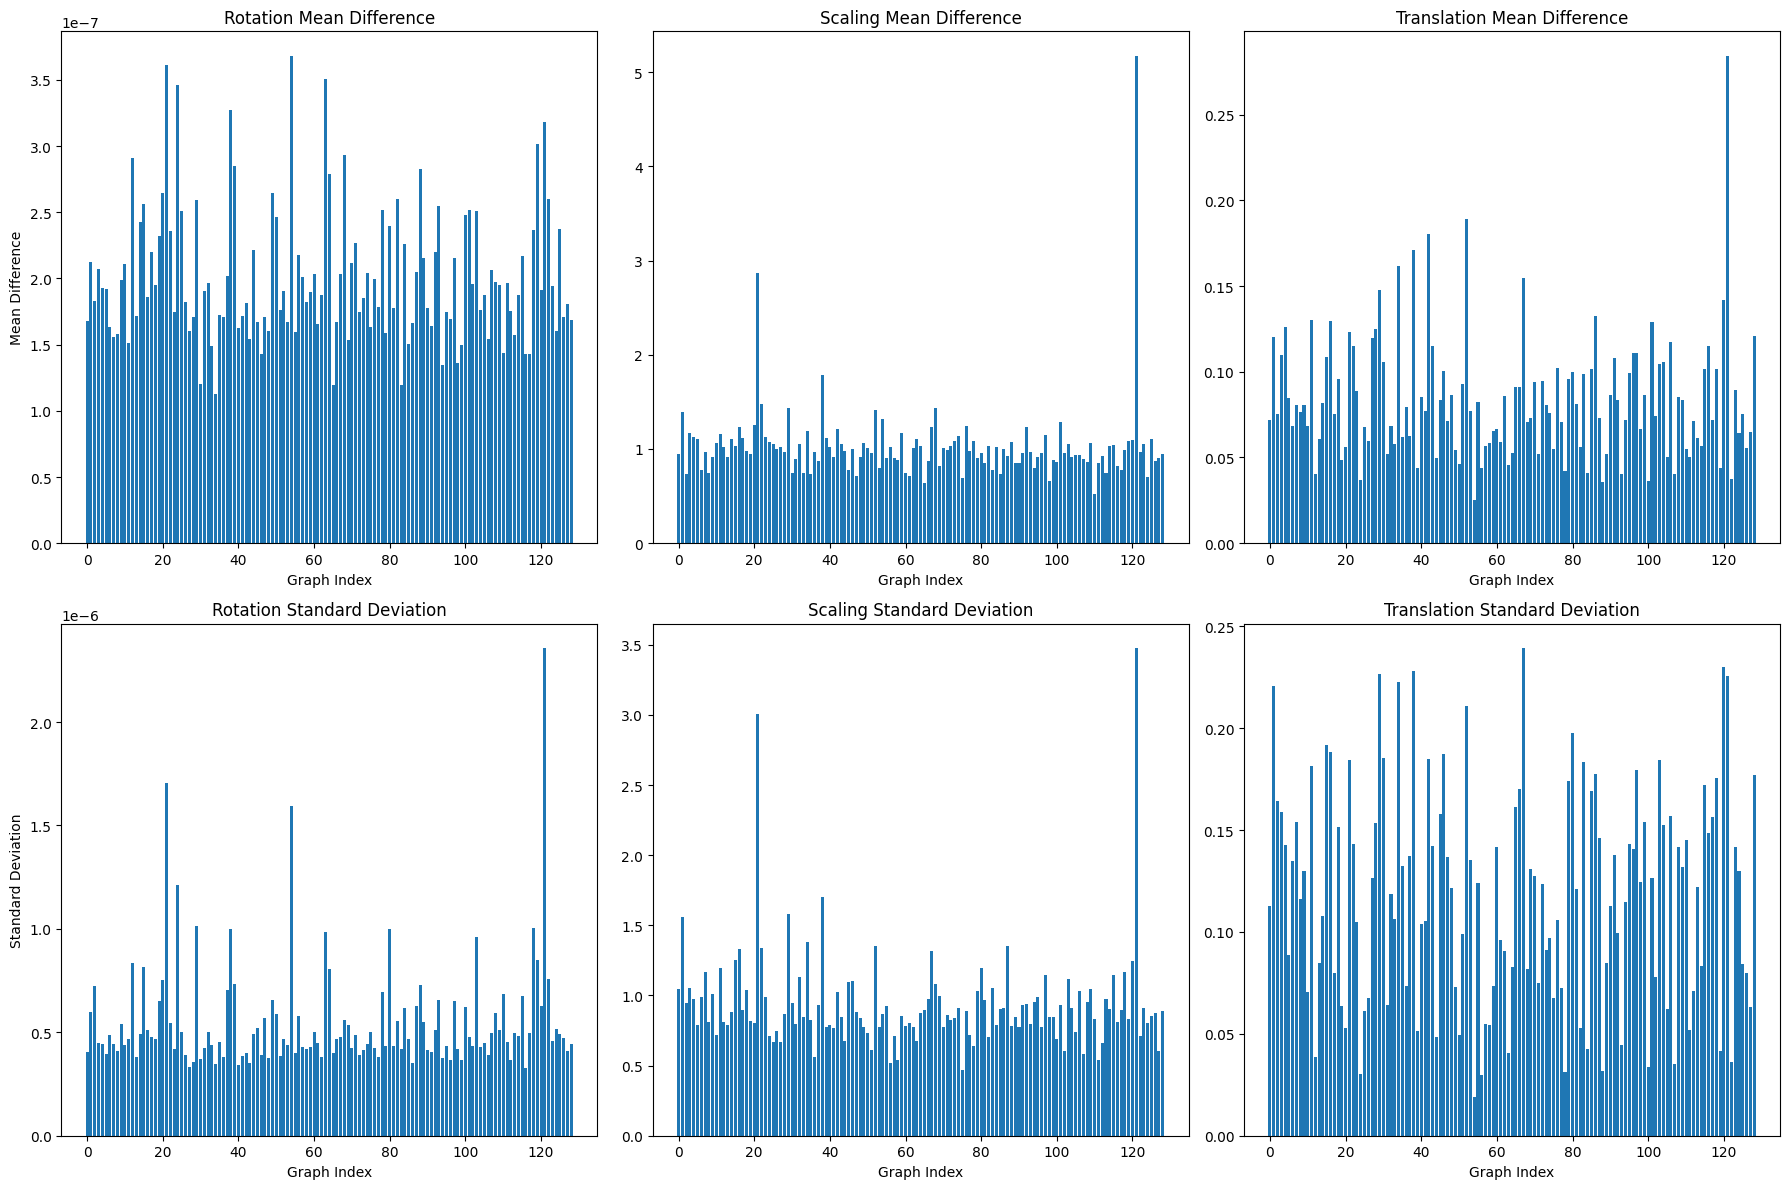

In [11]:
mean_rotations = [np.mean(metric) for metric in all_rotation_metrics]
std_rotations = [np.std(metric) for metric in all_rotation_metrics]
mean_scalings = [np.mean(metric) for metric in all_scaling_metrics]
std_scalings = [np.std(metric) for metric in all_scaling_metrics]
mean_translations = [np.mean(metric) for metric in all_translation_metrics]
std_translations = [np.std(metric) for metric in all_translation_metrics]

plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.bar(range(len(mean_rotations)), mean_rotations)
plt.title('Rotation Mean Difference')
plt.xlabel('Graph Index')
plt.ylabel('Mean Difference')

plt.subplot(2, 3, 2)
plt.bar(range(len(mean_scalings)), mean_scalings)
plt.title('Scaling Mean Difference')
plt.xlabel('Graph Index')

plt.subplot(2, 3, 3)
plt.bar(range(len(mean_translations)), mean_translations)
plt.title('Translation Mean Difference')
plt.xlabel('Graph Index')

plt.subplot(2, 3, 4)
plt.bar(range(len(std_rotations)), std_rotations)
plt.title('Rotation Standard Deviation')
plt.xlabel('Graph Index')
plt.ylabel('Standard Deviation')

plt.subplot(2, 3, 5)
plt.bar(range(len(std_scalings)), std_scalings)
plt.title('Scaling Standard Deviation')
plt.xlabel('Graph Index')

plt.subplot(2, 3, 6)
plt.bar(range(len(std_translations)), std_translations)
plt.title('Translation Standard Deviation')
plt.xlabel('Graph Index')

plt.tight_layout()
plt.show()

# Random Ablation Study GVP

Processing set 1 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 15, 16, 17, 18, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.98it/s]


Completed set 1 of 1000
Processing set 2 of 1000: Scalar Indices = (0, 1, 5, 6, 15, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 2 of 1000
Processing set 3 of 1000: Scalar Indices = (0, 5, 14, 15, 17, 18, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.94it/s]


Completed set 3 of 1000
Processing set 4 of 1000: Scalar Indices = (0, 8, 9, 10, 14, 17, 18, 20, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.24it/s]


Completed set 4 of 1000
Processing set 5 of 1000: Scalar Indices = (5, 6, 7, 8, 15, 18, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 5 of 1000
Processing set 6 of 1000: Scalar Indices = (0, 1, 7, 8, 9, 15, 16, 17, 18, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 6 of 1000
Processing set 7 of 1000: Scalar Indices = (1, 5, 6, 8, 10, 14, 16, 18, 19, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.77it/s]


Completed set 7 of 1000
Processing set 8 of 1000: Scalar Indices = (0, 5, 6, 7, 14, 15, 17, 18, 20, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


Completed set 8 of 1000
Processing set 9 of 1000: Scalar Indices = (0, 6, 9, 10, 17, 19, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.20it/s]


Completed set 9 of 1000
Processing set 10 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 14, 15, 16, 17, 18, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 10 of 1000
Processing set 11 of 1000: Scalar Indices = (1, 6, 7, 10, 17, 19, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.67it/s]


Completed set 11 of 1000
Processing set 12 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 9, 15, 18, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.86it/s]


Completed set 12 of 1000
Processing set 13 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 9, 14, 18, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.30it/s]


Completed set 13 of 1000
Processing set 14 of 1000: Scalar Indices = (0, 6, 7, 8, 9, 14, 15, 16, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.06it/s]


Completed set 14 of 1000
Processing set 15 of 1000: Scalar Indices = (0, 6, 8, 9, 14, 15, 16, 17, 18, 19, 20, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 15 of 1000
Processing set 16 of 1000: Scalar Indices = (1, 6, 9, 15, 16, 17, 18, 19, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.28it/s]


Completed set 16 of 1000
Processing set 17 of 1000: Scalar Indices = (0, 1, 5, 6, 9, 10, 14, 16, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.16it/s]


Completed set 17 of 1000
Processing set 18 of 1000: Scalar Indices = (1, 5, 6, 14, 15, 17, 18, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.82it/s]


Completed set 18 of 1000
Processing set 19 of 1000: Scalar Indices = (0, 7, 9, 10, 14, 16, 18, 19, 20, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.02it/s]


Completed set 19 of 1000
Processing set 20 of 1000: Scalar Indices = (5, 7, 8, 9, 14, 15, 16, 18, 19, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.20it/s]


Completed set 20 of 1000
Processing set 21 of 1000: Scalar Indices = (6, 7, 9, 14, 15, 17, 18, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s]


Completed set 21 of 1000
Processing set 22 of 1000: Scalar Indices = (0, 7, 8, 9, 10, 14, 15, 18, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.24it/s]


Completed set 22 of 1000
Processing set 23 of 1000: Scalar Indices = (0, 5, 7, 8, 9, 10, 14, 16, 17, 18, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.10it/s]


Completed set 23 of 1000
Processing set 24 of 1000: Scalar Indices = (1, 5, 6, 8, 9, 14, 15, 19, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.80it/s]


Completed set 24 of 1000
Processing set 25 of 1000: Scalar Indices = (5, 6, 8, 9, 10, 14, 15, 16, 18, 19, 20, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.79it/s]


Completed set 25 of 1000
Processing set 26 of 1000: Scalar Indices = (0, 5, 10, 14, 17, 18, 19, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.61it/s]


Completed set 26 of 1000
Processing set 27 of 1000: Scalar Indices = (1, 5, 6, 7, 9, 10, 16, 17, 19, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.64it/s]


Completed set 27 of 1000
Processing set 28 of 1000: Scalar Indices = (0, 1, 5, 9, 10, 15, 16, 19, 20, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.62it/s]


Completed set 28 of 1000
Processing set 29 of 1000: Scalar Indices = (0, 5, 7, 9, 10, 15, 19, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 29 of 1000
Processing set 30 of 1000: Scalar Indices = (0, 5, 7, 8, 10, 14, 16, 17, 18, 19, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 30 of 1000
Processing set 31 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 9, 14, 17, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 31 of 1000
Processing set 32 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 9, 10, 14, 15, 17, 18, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.65it/s]


Completed set 32 of 1000
Processing set 33 of 1000: Scalar Indices = (1, 5, 9, 10, 15, 17, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 33 of 1000
Processing set 34 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 15, 16, 19, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 34 of 1000
Processing set 35 of 1000: Scalar Indices = (0, 5, 7, 8, 9, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.64it/s]


Completed set 35 of 1000
Processing set 36 of 1000: Scalar Indices = (1, 5, 8, 9, 14, 16, 17, 18, 19, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.09it/s]


Completed set 36 of 1000
Processing set 37 of 1000: Scalar Indices = (0, 6, 7, 8, 15, 17, 18, 19, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.27it/s]


Completed set 37 of 1000
Processing set 38 of 1000: Scalar Indices = (5, 7, 8, 10, 14, 18, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.15it/s]


Completed set 38 of 1000
Processing set 39 of 1000: Scalar Indices = (0, 1, 6, 14, 15, 17, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.03it/s]


Completed set 39 of 1000
Processing set 40 of 1000: Scalar Indices = (1, 5, 6, 10, 14, 16, 17, 18, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.08it/s]


Completed set 40 of 1000
Processing set 41 of 1000: Scalar Indices = (1, 5, 6, 8, 16, 17, 19, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 41 of 1000
Processing set 42 of 1000: Scalar Indices = (0, 6, 9, 10, 14, 16, 18, 19, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.61it/s]


Completed set 42 of 1000
Processing set 43 of 1000: Scalar Indices = (5, 7, 9, 10, 14, 15, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 43 of 1000
Processing set 44 of 1000: Scalar Indices = (0, 1, 5, 10, 18, 19, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.81it/s]


Completed set 44 of 1000
Processing set 45 of 1000: Scalar Indices = (0, 1, 6, 8, 10, 15, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.72it/s]


Completed set 45 of 1000
Processing set 46 of 1000: Scalar Indices = (1, 6, 7, 8, 9, 14, 16, 17, 18, 20, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 46 of 1000
Processing set 47 of 1000: Scalar Indices = (5, 6, 8, 14, 15, 16, 18, 19, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.31it/s]


Completed set 47 of 1000
Processing set 48 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 16, 18, 19, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.63it/s]


Completed set 48 of 1000
Processing set 49 of 1000: Scalar Indices = (0, 5, 8, 10, 15, 16, 17, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.64it/s]


Completed set 49 of 1000
Processing set 50 of 1000: Scalar Indices = (5, 7, 8, 10, 15, 16, 17, 18, 19, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.01it/s]


Completed set 50 of 1000
Processing set 51 of 1000: Scalar Indices = (0, 5, 6, 8, 10, 14, 16, 17, 19, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.67it/s]


Completed set 51 of 1000
Processing set 52 of 1000: Scalar Indices = (1, 6, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.65it/s]


Completed set 52 of 1000
Processing set 53 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 10, 14, 15, 16, 17, 20, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.93it/s]


Completed set 53 of 1000
Processing set 54 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 10, 15, 17, 18, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.19it/s]


Completed set 54 of 1000
Processing set 55 of 1000: Scalar Indices = (5, 6, 10, 15, 16, 17, 18, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.30it/s]


Completed set 55 of 1000
Processing set 56 of 1000: Scalar Indices = (0, 1, 5, 6, 14, 15, 16, 17, 19, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.88it/s]


Completed set 56 of 1000
Processing set 57 of 1000: Scalar Indices = (6, 7, 8, 9, 10, 16, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 57 of 1000
Processing set 58 of 1000: Scalar Indices = (1, 5, 6, 8, 15, 17, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.93it/s]


Completed set 58 of 1000
Processing set 59 of 1000: Scalar Indices = (0, 5, 6, 7, 10, 14, 16, 17, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 59 of 1000
Processing set 60 of 1000: Scalar Indices = (0, 1, 5, 7, 9, 14, 16, 18, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.37it/s]


Completed set 60 of 1000
Processing set 61 of 1000: Scalar Indices = (1, 8, 9, 10, 14, 16, 19, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.30it/s]


Completed set 61 of 1000
Processing set 62 of 1000: Scalar Indices = (5, 8, 10, 14, 15, 17, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.82it/s]


Completed set 62 of 1000
Processing set 63 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 10, 15, 16, 20, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 63 of 1000
Processing set 64 of 1000: Scalar Indices = (0, 6, 7, 8, 9, 10, 15, 16, 17, 18, 19, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.95it/s]


Completed set 64 of 1000
Processing set 65 of 1000: Scalar Indices = (0, 1, 5, 9, 10, 14, 15, 17, 19, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.65it/s]


Completed set 65 of 1000
Processing set 66 of 1000: Scalar Indices = (1, 6, 14, 15, 16, 17, 18, 19, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 66 of 1000
Processing set 67 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 10, 14, 15, 18, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 67 of 1000
Processing set 68 of 1000: Scalar Indices = (5, 8, 10, 15, 16, 18, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 68 of 1000
Processing set 69 of 1000: Scalar Indices = (0, 5, 7, 9, 10, 15, 16, 17, 18, 19, 20, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 69 of 1000
Processing set 70 of 1000: Scalar Indices = (5, 7, 14, 15, 16, 17, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.93it/s]


Completed set 70 of 1000
Processing set 71 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 9, 16, 18, 19, 20)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 71 of 1000
Processing set 72 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 10, 14, 15, 17, 18, 20, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 72 of 1000
Processing set 73 of 1000: Scalar Indices = (7, 9, 10, 14, 15, 16, 19, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 73 of 1000
Processing set 74 of 1000: Scalar Indices = (5, 7, 8, 10, 15, 16, 18, 19, 20, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.00it/s]


Completed set 74 of 1000
Processing set 75 of 1000: Scalar Indices = (7, 8, 9, 14, 15, 16, 17, 18, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 75 of 1000
Processing set 76 of 1000: Scalar Indices = (0, 1, 5, 8, 9, 10, 15, 16, 18, 20, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 76 of 1000
Processing set 77 of 1000: Scalar Indices = (1, 5, 8, 9, 10, 14, 17, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 77 of 1000
Processing set 78 of 1000: Scalar Indices = (0, 6, 7, 8, 9, 15, 16, 17, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 78 of 1000
Processing set 79 of 1000: Scalar Indices = (1, 6, 7, 8, 9, 10, 14, 15, 16, 17, 19, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 79 of 1000
Processing set 80 of 1000: Scalar Indices = (0, 1, 5, 7, 9, 14, 15, 16, 18, 19, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.15it/s]


Completed set 80 of 1000
Processing set 81 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 9, 15, 16, 20, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 81 of 1000
Processing set 82 of 1000: Scalar Indices = (1, 5, 9, 14, 15, 16, 17, 18, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 82 of 1000
Processing set 83 of 1000: Scalar Indices = (0, 1, 7, 10, 16, 18, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 83 of 1000
Processing set 84 of 1000: Scalar Indices = (0, 1, 8, 10, 15, 16, 17, 19, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 84 of 1000
Processing set 85 of 1000: Scalar Indices = (1, 7, 8, 9, 10, 14, 16, 17, 18, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.91it/s]


Completed set 85 of 1000
Processing set 86 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 15, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.79it/s]


Completed set 86 of 1000
Processing set 87 of 1000: Scalar Indices = (0, 5, 6, 9, 10, 15, 16, 18, 20, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.72it/s]


Completed set 87 of 1000
Processing set 88 of 1000: Scalar Indices = (5, 6, 7, 10, 14, 15, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.75it/s]


Completed set 88 of 1000
Processing set 89 of 1000: Scalar Indices = (1, 6, 7, 8, 14, 15, 18, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 89 of 1000
Processing set 90 of 1000: Scalar Indices = (0, 1, 9, 14, 16, 17, 19, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 90 of 1000
Processing set 91 of 1000: Scalar Indices = (1, 5, 6, 8, 10, 14, 15, 16, 17, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 91 of 1000
Processing set 92 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 9, 10, 16, 17, 18, 19)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.63it/s]


Completed set 92 of 1000
Processing set 93 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 14, 15, 17, 18, 19, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 93 of 1000
Processing set 94 of 1000: Scalar Indices = (5, 6, 7, 8, 9, 14, 15, 16, 17, 19, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.66it/s]


Completed set 94 of 1000
Processing set 95 of 1000: Scalar Indices = (0, 1, 10, 14, 15, 17, 18, 19, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.97it/s]


Completed set 95 of 1000
Processing set 96 of 1000: Scalar Indices = (1, 5, 10, 14, 15, 16, 17, 18, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 96 of 1000
Processing set 97 of 1000: Scalar Indices = (5, 7, 8, 10, 14, 15, 16, 18, 20, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 97 of 1000
Processing set 98 of 1000: Scalar Indices = (1, 5, 6, 7, 9, 10, 14, 15, 16, 17, 18, 19, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 98 of 1000
Processing set 99 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 10, 14, 15, 17, 18, 19)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 99 of 1000
Processing set 100 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 10, 15, 16, 18, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.98it/s]


Completed set 100 of 1000
Processing set 101 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 9, 10, 14, 16, 17, 19, 20, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.29it/s]


Completed set 101 of 1000
Processing set 102 of 1000: Scalar Indices = (0, 5, 6, 7, 14, 16, 18, 20, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 102 of 1000
Processing set 103 of 1000: Scalar Indices = (0, 1, 6, 7, 9, 14, 15, 16, 17, 18)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 103 of 1000
Processing set 104 of 1000: Scalar Indices = (0, 1, 7, 8, 9, 10, 14, 15, 19, 20, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 104 of 1000
Processing set 105 of 1000: Scalar Indices = (1, 5, 6, 9, 14, 15, 17, 19, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.92it/s]


Completed set 105 of 1000
Processing set 106 of 1000: Scalar Indices = (0, 1, 5, 9, 10, 15, 19, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 106 of 1000
Processing set 107 of 1000: Scalar Indices = (1, 6, 7, 10, 14, 15, 17, 18, 20, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.05it/s]


Completed set 107 of 1000
Processing set 108 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 10, 14, 16, 19, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 108 of 1000
Processing set 109 of 1000: Scalar Indices = (0, 5, 7, 8, 9, 10, 18, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 109 of 1000
Processing set 110 of 1000: Scalar Indices = (1, 6, 7, 8, 9, 15, 18, 19, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.63it/s]


Completed set 110 of 1000
Processing set 111 of 1000: Scalar Indices = (5, 6, 7, 8, 9, 10, 14, 16, 18, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.61it/s]


Completed set 111 of 1000
Processing set 112 of 1000: Scalar Indices = (1, 7, 15, 16, 18, 19, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.12it/s]


Completed set 112 of 1000
Processing set 113 of 1000: Scalar Indices = (0, 5, 6, 10, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.69it/s]


Completed set 113 of 1000
Processing set 114 of 1000: Scalar Indices = (1, 7, 8, 9, 16, 17, 18, 19, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.73it/s]


Completed set 114 of 1000
Processing set 115 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 9, 10, 19, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.92it/s]


Completed set 115 of 1000
Processing set 116 of 1000: Scalar Indices = (1, 8, 9, 10, 14, 15, 16, 18, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 116 of 1000
Processing set 117 of 1000: Scalar Indices = (0, 6, 7, 14, 16, 19, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.99it/s]


Completed set 117 of 1000
Processing set 118 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 9, 10, 14, 16, 18, 19, 20, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.65it/s]


Completed set 118 of 1000
Processing set 119 of 1000: Scalar Indices = (0, 7, 8, 9, 10, 15, 16, 17, 20, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.09it/s]


Completed set 119 of 1000
Processing set 120 of 1000: Scalar Indices = (8, 9, 10, 14, 16, 17, 19, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.26it/s]


Completed set 120 of 1000
Processing set 121 of 1000: Scalar Indices = (5, 6, 7, 8, 9, 10, 14, 16, 18, 19, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.64it/s]


Completed set 121 of 1000
Processing set 122 of 1000: Scalar Indices = (0, 1, 7, 8, 9, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.22it/s]


Completed set 122 of 1000
Processing set 123 of 1000: Scalar Indices = (0, 5, 6, 8, 10, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.27it/s]


Completed set 123 of 1000
Processing set 124 of 1000: Scalar Indices = (1, 5, 6, 7, 9, 15, 16, 18, 19, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 124 of 1000
Processing set 125 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 9, 16, 17, 19, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.08it/s]


Completed set 125 of 1000
Processing set 126 of 1000: Scalar Indices = (0, 5, 8, 10, 14, 15, 18, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.71it/s]


Completed set 126 of 1000
Processing set 127 of 1000: Scalar Indices = (0, 5, 10, 15, 16, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 127 of 1000
Processing set 128 of 1000: Scalar Indices = (5, 7, 9, 10, 14, 18, 19, 20, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.79it/s]


Completed set 128 of 1000
Processing set 129 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 9, 14, 17, 19, 20, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.22it/s]


Completed set 129 of 1000
Processing set 130 of 1000: Scalar Indices = (0, 5, 7, 8, 9, 14, 15, 17, 18, 19, 20, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.09it/s]


Completed set 130 of 1000
Processing set 131 of 1000: Scalar Indices = (0, 1, 6, 9, 16, 17, 18, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 131 of 1000
Processing set 132 of 1000: Scalar Indices = (6, 8, 9, 10, 15, 16, 17, 20, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.04it/s]


Completed set 132 of 1000
Processing set 133 of 1000: Scalar Indices = (5, 6, 8, 10, 14, 15, 19, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 133 of 1000
Processing set 134 of 1000: Scalar Indices = (0, 1, 10, 14, 15, 16, 18, 19, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.84it/s]


Completed set 134 of 1000
Processing set 135 of 1000: Scalar Indices = (5, 6, 9, 10, 14, 15, 16, 17, 18, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 135 of 1000
Processing set 136 of 1000: Scalar Indices = (0, 6, 7, 10, 14, 19, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 136 of 1000
Processing set 137 of 1000: Scalar Indices = (0, 1, 5, 6, 10, 14, 17, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.26it/s]


Completed set 137 of 1000
Processing set 138 of 1000: Scalar Indices = (0, 7, 8, 9, 10, 16, 18, 19, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 138 of 1000
Processing set 139 of 1000: Scalar Indices = (0, 5, 6, 8, 9, 18, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 139 of 1000
Processing set 140 of 1000: Scalar Indices = (0, 6, 8, 9, 10, 14, 15, 17, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 140 of 1000
Processing set 141 of 1000: Scalar Indices = (5, 6, 7, 8, 10, 16, 18, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.62it/s]


Completed set 141 of 1000
Processing set 142 of 1000: Scalar Indices = (0, 5, 6, 7, 9, 17, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.66it/s]


Completed set 142 of 1000
Processing set 143 of 1000: Scalar Indices = (0, 1, 10, 14, 16, 17, 18, 19, 20, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.85it/s]


Completed set 143 of 1000
Processing set 144 of 1000: Scalar Indices = (1, 6, 7, 10, 14, 15, 17, 18, 19, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.92it/s]


Completed set 144 of 1000
Processing set 145 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 10, 14, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.93it/s]


Completed set 145 of 1000
Processing set 146 of 1000: Scalar Indices = (0, 6, 7, 8, 14, 15, 18, 19, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.33it/s]


Completed set 146 of 1000
Processing set 147 of 1000: Scalar Indices = (5, 7, 8, 15, 16, 17, 19, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 147 of 1000
Processing set 148 of 1000: Scalar Indices = (0, 8, 9, 14, 16, 18, 19, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 148 of 1000
Processing set 149 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 14, 15, 16, 17, 19, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.14it/s]


Completed set 149 of 1000
Processing set 150 of 1000: Scalar Indices = (0, 1, 7, 9, 14, 16, 17, 18, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 150 of 1000
Processing set 151 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 10, 17, 19, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.85it/s]


Completed set 151 of 1000
Processing set 152 of 1000: Scalar Indices = (0, 7, 9, 10, 14, 16, 17, 18, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.71it/s]


Completed set 152 of 1000
Processing set 153 of 1000: Scalar Indices = (1, 5, 7, 15, 17, 18, 19, 20, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.66it/s]


Completed set 153 of 1000
Processing set 154 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 10, 14, 17, 20, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 154 of 1000
Processing set 155 of 1000: Scalar Indices = (0, 6, 7, 9, 14, 15, 20, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 155 of 1000
Processing set 156 of 1000: Scalar Indices = (0, 1, 6, 7, 9, 10, 14, 16, 19, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.64it/s]


Completed set 156 of 1000
Processing set 157 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 9, 14, 17, 19, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Completed set 157 of 1000
Processing set 158 of 1000: Scalar Indices = (0, 5, 6, 9, 10, 14, 15, 19, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 158 of 1000
Processing set 159 of 1000: Scalar Indices = (5, 6, 8, 10, 14, 15, 16, 17, 18, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.65it/s]


Completed set 159 of 1000
Processing set 160 of 1000: Scalar Indices = (0, 1, 6, 9, 10, 14, 16, 17, 18, 19, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 160 of 1000
Processing set 161 of 1000: Scalar Indices = (7, 8, 14, 17, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 161 of 1000
Processing set 162 of 1000: Scalar Indices = (0, 5, 7, 8, 9, 10, 14, 15, 17, 18, 20, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 162 of 1000
Processing set 163 of 1000: Scalar Indices = (7, 8, 9, 14, 15, 18, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.68it/s]


Completed set 163 of 1000
Processing set 164 of 1000: Scalar Indices = (0, 5, 7, 8, 17, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 164 of 1000
Processing set 165 of 1000: Scalar Indices = (1, 5, 6, 7, 10, 14, 16, 17, 19, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 165 of 1000
Processing set 166 of 1000: Scalar Indices = (6, 8, 9, 10, 15, 17, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 166 of 1000
Processing set 167 of 1000: Scalar Indices = (0, 1, 6, 8, 9, 14, 17, 19, 20, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 167 of 1000
Processing set 168 of 1000: Scalar Indices = (5, 6, 8, 14, 18, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 168 of 1000
Processing set 169 of 1000: Scalar Indices = (0, 1, 7, 8, 9, 10, 14, 16, 17, 18, 19, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.61it/s]


Completed set 169 of 1000
Processing set 170 of 1000: Scalar Indices = (1, 5, 6, 10, 14, 16, 17, 18, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.09it/s]


Completed set 170 of 1000
Processing set 171 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 9, 14, 16, 17, 18, 19, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 171 of 1000
Processing set 172 of 1000: Scalar Indices = (1, 6, 7, 9, 10, 14, 16, 19, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 172 of 1000
Processing set 173 of 1000: Scalar Indices = (0, 5, 6, 14, 15, 17, 18, 19, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.62it/s]


Completed set 173 of 1000
Processing set 174 of 1000: Scalar Indices = (0, 1, 10, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.89it/s]


Completed set 174 of 1000
Processing set 175 of 1000: Scalar Indices = (0, 5, 10, 15, 16, 17, 19, 20, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 175 of 1000
Processing set 176 of 1000: Scalar Indices = (1, 6, 7, 9, 14, 15, 17, 19, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 176 of 1000
Processing set 177 of 1000: Scalar Indices = (7, 8, 9, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.00it/s]


Completed set 177 of 1000
Processing set 178 of 1000: Scalar Indices = (1, 6, 7, 14, 15, 17, 18, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 178 of 1000
Processing set 179 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 9, 10, 16, 17, 18, 20, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 179 of 1000
Processing set 180 of 1000: Scalar Indices = (1, 6, 7, 8, 14, 15, 16, 19, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.96it/s]


Completed set 180 of 1000
Processing set 181 of 1000: Scalar Indices = (0, 5, 6, 7, 15, 16, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 181 of 1000
Processing set 182 of 1000: Scalar Indices = (0, 1, 8, 9, 15, 18, 19, 20, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 182 of 1000
Processing set 183 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 10, 18, 19, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.80it/s]


Completed set 183 of 1000
Processing set 184 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 15, 18, 19, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.89it/s]


Completed set 184 of 1000
Processing set 185 of 1000: Scalar Indices = (0, 1, 8, 10, 14, 15, 18, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 185 of 1000
Processing set 186 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 10, 14, 18, 19, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.14it/s]


Completed set 186 of 1000
Processing set 187 of 1000: Scalar Indices = (0, 1, 7, 9, 10, 14, 15, 16, 17, 19, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


Completed set 187 of 1000
Processing set 188 of 1000: Scalar Indices = (0, 1, 6, 7, 15, 17, 19, 20, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.64it/s]


Completed set 188 of 1000
Processing set 189 of 1000: Scalar Indices = (1, 6, 8, 10, 14, 15, 17, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.62it/s]


Completed set 189 of 1000
Processing set 190 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 9, 14, 16, 17, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 190 of 1000
Processing set 191 of 1000: Scalar Indices = (0, 1, 7, 10, 14, 19, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.63it/s]


Completed set 191 of 1000
Processing set 192 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 10, 14, 15, 16, 17, 19, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 192 of 1000
Processing set 193 of 1000: Scalar Indices = (0, 1, 5, 6, 10, 14, 15, 16, 17, 19, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.64it/s]


Completed set 193 of 1000
Processing set 194 of 1000: Scalar Indices = (0, 5, 7, 9, 14, 15, 16, 18, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Completed set 194 of 1000
Processing set 195 of 1000: Scalar Indices = (7, 8, 10, 14, 19, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.01it/s]


Completed set 195 of 1000
Processing set 196 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 9, 10, 16, 18, 19, 20, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 196 of 1000
Processing set 197 of 1000: Scalar Indices = (0, 5, 7, 9, 10, 14, 16, 18, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 197 of 1000
Processing set 198 of 1000: Scalar Indices = (0, 5, 8, 9, 14, 15, 17, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.62it/s]


Completed set 198 of 1000
Processing set 199 of 1000: Scalar Indices = (1, 5, 9, 10, 14, 16, 17, 18, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 199 of 1000
Processing set 200 of 1000: Scalar Indices = (1, 5, 6, 7, 17, 18, 19, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 200 of 1000
Processing set 201 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 14, 17, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 201 of 1000
Processing set 202 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 15, 16, 17, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.63it/s]


Completed set 202 of 1000
Processing set 203 of 1000: Scalar Indices = (0, 5, 7, 9, 14, 15, 16, 19, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 203 of 1000
Processing set 204 of 1000: Scalar Indices = (6, 7, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.85it/s]


Completed set 204 of 1000
Processing set 205 of 1000: Scalar Indices = (0, 5, 7, 10, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 205 of 1000
Processing set 206 of 1000: Scalar Indices = (5, 7, 8, 9, 14, 15, 17, 19, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s]


Completed set 206 of 1000
Processing set 207 of 1000: Scalar Indices = (0, 1, 5, 6, 9, 14, 17, 19, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.64it/s]


Completed set 207 of 1000
Processing set 208 of 1000: Scalar Indices = (1, 5, 8, 9, 10, 15, 16, 17, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 208 of 1000
Processing set 209 of 1000: Scalar Indices = (0, 1, 5, 10, 14, 15, 16, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.86it/s]


Completed set 209 of 1000
Processing set 210 of 1000: Scalar Indices = (0, 1, 6, 10, 14, 15, 16, 17, 19, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.62it/s]


Completed set 210 of 1000
Processing set 211 of 1000: Scalar Indices = (0, 5, 7, 10, 16, 17, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 211 of 1000
Processing set 212 of 1000: Scalar Indices = (0, 5, 7, 8, 9, 10, 14, 15, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 212 of 1000
Processing set 213 of 1000: Scalar Indices = (5, 7, 9, 10, 14, 15, 16, 17, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.10it/s]


Completed set 213 of 1000
Processing set 214 of 1000: Scalar Indices = (0, 5, 8, 10, 15, 16, 18, 19, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 214 of 1000
Processing set 215 of 1000: Scalar Indices = (1, 5, 7, 9, 10, 15, 19, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.78it/s]


Completed set 215 of 1000
Processing set 216 of 1000: Scalar Indices = (0, 5, 6, 10, 14, 15, 16, 17, 19, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.30it/s]


Completed set 216 of 1000
Processing set 217 of 1000: Scalar Indices = (0, 1, 5, 6, 9, 10, 15, 18, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 217 of 1000
Processing set 218 of 1000: Scalar Indices = (0, 5, 6, 7, 9, 10, 19, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.68it/s]


Completed set 218 of 1000
Processing set 219 of 1000: Scalar Indices = (0, 1, 8, 16, 19, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 219 of 1000
Processing set 220 of 1000: Scalar Indices = (5, 6, 7, 8, 10, 15, 16, 17, 18, 19, 20, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 220 of 1000
Processing set 221 of 1000: Scalar Indices = (0, 5, 6, 7, 16, 17, 19, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 221 of 1000
Processing set 222 of 1000: Scalar Indices = (0, 5, 6, 7, 9, 10, 14, 15, 16, 19, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 222 of 1000
Processing set 223 of 1000: Scalar Indices = (0, 1, 8, 9, 14, 15, 16, 17, 19, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 223 of 1000
Processing set 224 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 15, 18, 19, 20, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 224 of 1000
Processing set 225 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 14, 15, 16, 17, 19, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 225 of 1000
Processing set 226 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 9, 14, 15, 17, 18, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.31it/s]


Completed set 226 of 1000
Processing set 227 of 1000: Scalar Indices = (1, 6, 9, 10, 14, 15, 16, 17, 20, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 227 of 1000
Processing set 228 of 1000: Scalar Indices = (1, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.61it/s]


Completed set 228 of 1000
Processing set 229 of 1000: Scalar Indices = (1, 5, 6, 7, 10, 14, 16, 17, 19, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 229 of 1000
Processing set 230 of 1000: Scalar Indices = (1, 7, 8, 14, 16, 18, 19, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 230 of 1000
Processing set 231 of 1000: Scalar Indices = (5, 6, 8, 14, 15, 18, 19, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.16it/s]


Completed set 231 of 1000
Processing set 232 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 10, 15, 16, 19, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 232 of 1000
Processing set 233 of 1000: Scalar Indices = (8, 9, 10, 14, 15, 17, 18, 19, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.98it/s]


Completed set 233 of 1000
Processing set 234 of 1000: Scalar Indices = (0, 1, 5, 6, 9, 10, 14, 15, 16, 17, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 234 of 1000
Processing set 235 of 1000: Scalar Indices = (7, 9, 15, 17, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.84it/s]


Completed set 235 of 1000
Processing set 236 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 9, 14, 17, 18, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.02it/s]


Completed set 236 of 1000
Processing set 237 of 1000: Scalar Indices = (0, 1, 9, 10, 16, 18, 19, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.97it/s]


Completed set 237 of 1000
Processing set 238 of 1000: Scalar Indices = (0, 8, 9, 10, 14, 15, 16, 17, 18, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.18it/s]


Completed set 238 of 1000
Processing set 239 of 1000: Scalar Indices = (0, 1, 5, 7, 9, 10, 14, 18, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 239 of 1000
Processing set 240 of 1000: Scalar Indices = (0, 6, 7, 10, 14, 17, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.65it/s]


Completed set 240 of 1000
Processing set 241 of 1000: Scalar Indices = (0, 1, 5, 6, 9, 10, 15, 17, 18, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 241 of 1000
Processing set 242 of 1000: Scalar Indices = (1, 5, 8, 9, 10, 14, 15, 16, 18, 19, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 242 of 1000
Processing set 243 of 1000: Scalar Indices = (0, 6, 8, 9, 10, 14, 17, 18, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.02it/s]


Completed set 243 of 1000
Processing set 244 of 1000: Scalar Indices = (0, 1, 6, 7, 10, 14, 16, 17, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.61it/s]


Completed set 244 of 1000
Processing set 245 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 15, 16, 18, 19, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.30it/s]


Completed set 245 of 1000
Processing set 246 of 1000: Scalar Indices = (0, 5, 14, 15, 16, 17, 18, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.11it/s]


Completed set 246 of 1000
Processing set 247 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 15, 16, 17, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.64it/s]


Completed set 247 of 1000
Processing set 248 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 9, 10, 14, 15, 17, 18, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.63it/s]


Completed set 248 of 1000
Processing set 249 of 1000: Scalar Indices = (0, 1, 6, 8, 14, 16, 18, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.37it/s]


Completed set 249 of 1000
Processing set 250 of 1000: Scalar Indices = (0, 1, 5, 10, 14, 15, 19, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 250 of 1000
Processing set 251 of 1000: Scalar Indices = (1, 5, 6, 8, 10, 14, 16, 17, 18, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.85it/s]


Completed set 251 of 1000
Processing set 252 of 1000: Scalar Indices = (1, 5, 6, 8, 9, 10, 16, 19, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.67it/s]


Completed set 252 of 1000
Processing set 253 of 1000: Scalar Indices = (7, 9, 10, 15, 16, 17, 19, 20, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 253 of 1000
Processing set 254 of 1000: Scalar Indices = (5, 6, 7, 8, 9, 10, 14, 17, 18, 19, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 254 of 1000
Processing set 255 of 1000: Scalar Indices = (0, 1, 7, 10, 16, 18, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.33it/s]


Completed set 255 of 1000
Processing set 256 of 1000: Scalar Indices = (1, 6, 8, 9, 10, 18, 19, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 256 of 1000
Processing set 257 of 1000: Scalar Indices = (5, 7, 14, 15, 19, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.62it/s]


Completed set 257 of 1000
Processing set 258 of 1000: Scalar Indices = (1, 5, 6, 7, 10, 15, 18, 19, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 258 of 1000
Processing set 259 of 1000: Scalar Indices = (0, 5, 9, 17, 18, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 259 of 1000
Processing set 260 of 1000: Scalar Indices = (0, 5, 7, 10, 16, 19, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 260 of 1000
Processing set 261 of 1000: Scalar Indices = (0, 6, 7, 8, 9, 15, 16, 18, 19, 20, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 261 of 1000
Processing set 262 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 14, 15, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.07it/s]


Completed set 262 of 1000
Processing set 263 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 15, 16, 17, 20, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 263 of 1000
Processing set 264 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 20, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 264 of 1000
Processing set 265 of 1000: Scalar Indices = (0, 5, 7, 8, 14, 15, 16, 18, 20, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.62it/s]


Completed set 265 of 1000
Processing set 266 of 1000: Scalar Indices = (0, 5, 6, 8, 9, 14, 17, 19, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.92it/s]


Completed set 266 of 1000
Processing set 267 of 1000: Scalar Indices = (0, 6, 8, 9, 10, 14, 15, 16, 20, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 267 of 1000
Processing set 268 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 18, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 268 of 1000
Processing set 269 of 1000: Scalar Indices = (1, 6, 10, 14, 15, 16, 18, 19, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.95it/s]


Completed set 269 of 1000
Processing set 270 of 1000: Scalar Indices = (1, 6, 7, 9, 14, 16, 17, 18, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.30it/s]


Completed set 270 of 1000
Processing set 271 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 10, 14, 18, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.32it/s]


Completed set 271 of 1000
Processing set 272 of 1000: Scalar Indices = (0, 5, 6, 8, 9, 14, 18, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.16it/s]


Completed set 272 of 1000
Processing set 273 of 1000: Scalar Indices = (1, 6, 8, 9, 14, 15, 16, 19, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 273 of 1000
Processing set 274 of 1000: Scalar Indices = (1, 6, 7, 8, 14, 15, 16, 17, 18, 19, 20, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.79it/s]


Completed set 274 of 1000
Processing set 275 of 1000: Scalar Indices = (0, 5, 7, 14, 15, 16, 17, 18, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 275 of 1000
Processing set 276 of 1000: Scalar Indices = (0, 1, 5, 7, 9, 10, 14, 17, 19, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 276 of 1000
Processing set 277 of 1000: Scalar Indices = (0, 5, 6, 8, 9, 10, 14, 17, 19, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 277 of 1000
Processing set 278 of 1000: Scalar Indices = (0, 1, 5, 8, 9, 10, 14, 16, 17, 20, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.27it/s]


Completed set 278 of 1000
Processing set 279 of 1000: Scalar Indices = (0, 1, 5, 8, 10, 14, 15, 18, 19, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 279 of 1000
Processing set 280 of 1000: Scalar Indices = (1, 5, 7, 9, 10, 14, 16, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 280 of 1000
Processing set 281 of 1000: Scalar Indices = (1, 6, 7, 8, 10, 14, 15, 17, 18, 19, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.26it/s]


Completed set 281 of 1000
Processing set 282 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 10, 16, 17, 18, 20, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 282 of 1000
Processing set 283 of 1000: Scalar Indices = (0, 1, 7, 8, 16, 18, 19, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


Completed set 283 of 1000
Processing set 284 of 1000: Scalar Indices = (1, 5, 7, 10, 14, 15, 17, 18, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 284 of 1000
Processing set 285 of 1000: Scalar Indices = (1, 5, 6, 9, 14, 15, 17, 19, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.61it/s]


Completed set 285 of 1000
Processing set 286 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 10, 15, 20, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.30it/s]


Completed set 286 of 1000
Processing set 287 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 18, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.95it/s]


Completed set 287 of 1000
Processing set 288 of 1000: Scalar Indices = (1, 5, 8, 10, 14, 15, 18, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.16it/s]


Completed set 288 of 1000
Processing set 289 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 9, 10, 14, 15, 16, 17, 18, 19, 20, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 289 of 1000
Processing set 290 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 9, 10, 16, 17, 18, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 290 of 1000
Processing set 291 of 1000: Scalar Indices = (5, 7, 8, 9, 15, 16, 17, 18, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 291 of 1000
Processing set 292 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 10, 15, 17, 18, 19, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 292 of 1000
Processing set 293 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 10, 19, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 293 of 1000
Processing set 294 of 1000: Scalar Indices = (0, 1, 5, 8, 9, 10, 14, 15, 17, 18, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 294 of 1000
Processing set 295 of 1000: Scalar Indices = (1, 5, 6, 8, 10, 14, 15, 16, 17, 20, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 295 of 1000
Processing set 296 of 1000: Scalar Indices = (7, 8, 10, 15, 19, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.04it/s]


Completed set 296 of 1000
Processing set 297 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 10, 14, 17, 18, 19, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 297 of 1000
Processing set 298 of 1000: Scalar Indices = (0, 1, 5, 7, 9, 10, 14, 15, 19, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 298 of 1000
Processing set 299 of 1000: Scalar Indices = (0, 6, 9, 16, 18, 19, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.03it/s]


Completed set 299 of 1000
Processing set 300 of 1000: Scalar Indices = (0, 1, 7, 10, 16, 17, 18, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 300 of 1000
Processing set 301 of 1000: Scalar Indices = (7, 8, 9, 10, 14, 15, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.82it/s]


Completed set 301 of 1000
Processing set 302 of 1000: Scalar Indices = (0, 5, 6, 7, 9, 10, 14, 15, 16, 19, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 302 of 1000
Processing set 303 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 10, 14, 17, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.94it/s]


Completed set 303 of 1000
Processing set 304 of 1000: Scalar Indices = (1, 6, 7, 8, 9, 16, 18, 19, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.89it/s]


Completed set 304 of 1000
Processing set 305 of 1000: Scalar Indices = (0, 7, 10, 14, 16, 18, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.08it/s]


Completed set 305 of 1000
Processing set 306 of 1000: Scalar Indices = (0, 1, 7, 16, 17, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.85it/s]


Completed set 306 of 1000
Processing set 307 of 1000: Scalar Indices = (1, 6, 7, 9, 15, 17, 18, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 307 of 1000
Processing set 308 of 1000: Scalar Indices = (1, 5, 8, 9, 16, 17, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.11it/s]


Completed set 308 of 1000
Processing set 309 of 1000: Scalar Indices = (1, 9, 10, 14, 15, 16, 17, 18, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 309 of 1000
Processing set 310 of 1000: Scalar Indices = (5, 6, 9, 14, 17, 18, 19, 20, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 310 of 1000
Processing set 311 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 14, 15, 16, 17, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.86it/s]


Completed set 311 of 1000
Processing set 312 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 9, 10, 16, 17, 18, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 312 of 1000
Processing set 313 of 1000: Scalar Indices = (0, 1, 5, 6, 10, 16, 18, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 313 of 1000
Processing set 314 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 9, 17, 19, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 314 of 1000
Processing set 315 of 1000: Scalar Indices = (0, 7, 8, 10, 15, 19, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 315 of 1000
Processing set 316 of 1000: Scalar Indices = (0, 1, 5, 9, 10, 17, 18, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 316 of 1000
Processing set 317 of 1000: Scalar Indices = (6, 7, 8, 15, 17, 18, 19, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 317 of 1000
Processing set 318 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 17, 19, 20, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.89it/s]


Completed set 318 of 1000
Processing set 319 of 1000: Scalar Indices = (0, 6, 7, 8, 9, 10, 14, 15, 17, 19, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 319 of 1000
Processing set 320 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 9, 10, 14, 15, 17, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 320 of 1000
Processing set 321 of 1000: Scalar Indices = (0, 1, 6, 7, 15, 18, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 321 of 1000
Processing set 322 of 1000: Scalar Indices = (0, 1, 6, 10, 16, 18, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 322 of 1000
Processing set 323 of 1000: Scalar Indices = (6, 7, 9, 10, 14, 15, 16, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.20it/s]


Completed set 323 of 1000
Processing set 324 of 1000: Scalar Indices = (1, 5, 6, 7, 14, 16, 17, 19, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 324 of 1000
Processing set 325 of 1000: Scalar Indices = (5, 7, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.95it/s]


Completed set 325 of 1000
Processing set 326 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 16, 17, 18, 19, 20, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 326 of 1000
Processing set 327 of 1000: Scalar Indices = (1, 5, 8, 9, 10, 16, 19, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.96it/s]


Completed set 327 of 1000
Processing set 328 of 1000: Scalar Indices = (0, 1, 5, 7, 9, 10, 14, 18, 19, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.29it/s]


Completed set 328 of 1000
Processing set 329 of 1000: Scalar Indices = (0, 1, 7, 9, 10, 14, 15, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.55it/s]


Completed set 329 of 1000
Processing set 330 of 1000: Scalar Indices = (1, 5, 6, 9, 15, 16, 17, 18, 19, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.99it/s]


Completed set 330 of 1000
Processing set 331 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 9, 10, 16, 17, 19, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 331 of 1000
Processing set 332 of 1000: Scalar Indices = (0, 1, 5, 8, 10, 14, 16, 19, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 332 of 1000
Processing set 333 of 1000: Scalar Indices = (1, 5, 7, 14, 17, 18, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 333 of 1000
Processing set 334 of 1000: Scalar Indices = (1, 6, 7, 9, 10, 14, 15, 20, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.90it/s]


Completed set 334 of 1000
Processing set 335 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 15, 16, 17, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Completed set 335 of 1000
Processing set 336 of 1000: Scalar Indices = (6, 9, 10, 14, 15, 17, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.91it/s]


Completed set 336 of 1000
Processing set 337 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 9, 10, 16, 17, 20, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 337 of 1000
Processing set 338 of 1000: Scalar Indices = (0, 7, 9, 17, 18, 19, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.88it/s]


Completed set 338 of 1000
Processing set 339 of 1000: Scalar Indices = (0, 5, 7, 9, 10, 15, 16, 17, 19, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.67it/s]


Completed set 339 of 1000
Processing set 340 of 1000: Scalar Indices = (1, 5, 6, 9, 14, 16, 17, 18, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.02it/s]


Completed set 340 of 1000
Processing set 341 of 1000: Scalar Indices = (5, 6, 7, 9, 10, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.19it/s]


Completed set 341 of 1000
Processing set 342 of 1000: Scalar Indices = (0, 1, 6, 10, 17, 18, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.63it/s]


Completed set 342 of 1000
Processing set 343 of 1000: Scalar Indices = (1, 5, 6, 8, 9, 14, 15, 16, 17, 18, 19, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 343 of 1000
Processing set 344 of 1000: Scalar Indices = (0, 1, 6, 8, 14, 15, 16, 18, 19, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 344 of 1000
Processing set 345 of 1000: Scalar Indices = (6, 9, 15, 16, 17, 18, 19, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 345 of 1000
Processing set 346 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 14, 16, 17, 18, 19, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 346 of 1000
Processing set 347 of 1000: Scalar Indices = (6, 9, 10, 14, 15, 16, 17, 18, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 347 of 1000
Processing set 348 of 1000: Scalar Indices = (0, 1, 5, 8, 10, 14, 18, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 348 of 1000
Processing set 349 of 1000: Scalar Indices = (0, 6, 7, 10, 14, 18, 19, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 349 of 1000
Processing set 350 of 1000: Scalar Indices = (6, 7, 8, 9, 10, 15, 16, 17, 18, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.83it/s]


Completed set 350 of 1000
Processing set 351 of 1000: Scalar Indices = (0, 1, 7, 8, 10, 14, 15, 17, 19, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 351 of 1000
Processing set 352 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 9, 14, 15, 17, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 352 of 1000
Processing set 353 of 1000: Scalar Indices = (1, 5, 10, 15, 16, 17, 18, 19, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.88it/s]


Completed set 353 of 1000
Processing set 354 of 1000: Scalar Indices = (1, 5, 7, 9, 10, 15, 19, 20, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 354 of 1000
Processing set 355 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 10, 15, 16, 17, 18, 19)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


Completed set 355 of 1000
Processing set 356 of 1000: Scalar Indices = (0, 1, 5, 9, 10, 14, 16, 18, 20, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.30it/s]


Completed set 356 of 1000
Processing set 357 of 1000: Scalar Indices = (1, 5, 6, 7, 9, 14, 15, 17, 18, 19, 20, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.98it/s]


Completed set 357 of 1000
Processing set 358 of 1000: Scalar Indices = (1, 6, 7, 8, 9, 10, 18, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.19it/s]


Completed set 358 of 1000
Processing set 359 of 1000: Scalar Indices = (1, 5, 6, 8, 9, 14, 15, 16, 18, 19, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.84it/s]


Completed set 359 of 1000
Processing set 360 of 1000: Scalar Indices = (0, 5, 8, 9, 10, 15, 17, 19, 20, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 360 of 1000
Processing set 361 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 9, 15, 16, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.96it/s]


Completed set 361 of 1000
Processing set 362 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 14, 16, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 362 of 1000
Processing set 363 of 1000: Scalar Indices = (0, 1, 5, 7, 9, 10, 14, 15, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 363 of 1000
Processing set 364 of 1000: Scalar Indices = (0, 1, 7, 8, 9, 16, 18, 19, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 364 of 1000
Processing set 365 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 10, 15, 16, 17, 19, 20, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 365 of 1000
Processing set 366 of 1000: Scalar Indices = (0, 1, 6, 8, 10, 14, 17, 19, 20, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 366 of 1000
Processing set 367 of 1000: Scalar Indices = (6, 9, 10, 14, 15, 16, 18, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.67it/s]


Completed set 367 of 1000
Processing set 368 of 1000: Scalar Indices = (0, 5, 7, 8, 10, 16, 17, 18, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.90it/s]


Completed set 368 of 1000
Processing set 369 of 1000: Scalar Indices = (0, 6, 7, 8, 9, 10, 14, 15, 16, 17, 18, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 369 of 1000
Processing set 370 of 1000: Scalar Indices = (0, 5, 6, 8, 10, 18, 19, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 370 of 1000
Processing set 371 of 1000: Scalar Indices = (0, 6, 8, 14, 15, 17, 18, 19, 20, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 371 of 1000
Processing set 372 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 10, 16, 17, 18, 19, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 372 of 1000
Processing set 373 of 1000: Scalar Indices = (5, 8, 10, 14, 15, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 373 of 1000
Processing set 374 of 1000: Scalar Indices = (0, 6, 7, 8, 15, 17, 18, 19, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.01it/s]


Completed set 374 of 1000
Processing set 375 of 1000: Scalar Indices = (0, 7, 9, 10, 15, 16, 18, 19, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 375 of 1000
Processing set 376 of 1000: Scalar Indices = (1, 5, 7, 8, 10, 14, 15, 17, 18, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 376 of 1000
Processing set 377 of 1000: Scalar Indices = (1, 6, 8, 14, 15, 17, 18, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.30it/s]


Completed set 377 of 1000
Processing set 378 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 10, 15, 20, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 378 of 1000
Processing set 379 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 10, 16, 18, 19, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 379 of 1000
Processing set 380 of 1000: Scalar Indices = (0, 1, 5, 8, 9, 10, 14, 16, 19, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.25it/s]


Completed set 380 of 1000
Processing set 381 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 10, 14, 17, 18, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.99it/s]


Completed set 381 of 1000
Processing set 382 of 1000: Scalar Indices = (0, 5, 7, 8, 16, 18, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 382 of 1000
Processing set 383 of 1000: Scalar Indices = (1, 5, 6, 9, 10, 14, 15, 16, 17, 20, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 383 of 1000
Processing set 384 of 1000: Scalar Indices = (0, 6, 7, 8, 9, 10, 14, 15, 16, 18, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 384 of 1000
Processing set 385 of 1000: Scalar Indices = (0, 6, 7, 8, 10, 15, 16, 18, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 385 of 1000
Processing set 386 of 1000: Scalar Indices = (5, 6, 8, 9, 14, 16, 17, 18, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 386 of 1000
Processing set 387 of 1000: Scalar Indices = (0, 5, 6, 9, 14, 15, 16, 17, 19, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 387 of 1000
Processing set 388 of 1000: Scalar Indices = (7, 8, 9, 10, 14, 16, 19, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 388 of 1000
Processing set 389 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 15, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.33it/s]


Completed set 389 of 1000
Processing set 390 of 1000: Scalar Indices = (1, 5, 6, 8, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 390 of 1000
Processing set 391 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 14, 18, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 391 of 1000
Processing set 392 of 1000: Scalar Indices = (1, 5, 8, 9, 14, 15, 16, 18, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.32it/s]


Completed set 392 of 1000
Processing set 393 of 1000: Scalar Indices = (0, 6, 7, 8, 9, 16, 17, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 393 of 1000
Processing set 394 of 1000: Scalar Indices = (0, 1, 5, 7, 14, 17, 18, 19, 20, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 394 of 1000
Processing set 395 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 9, 14, 15, 16, 17, 19, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 395 of 1000
Processing set 396 of 1000: Scalar Indices = (0, 1, 8, 9, 10, 14, 15, 16, 17, 19, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 396 of 1000
Processing set 397 of 1000: Scalar Indices = (1, 6, 7, 8, 15, 16, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 397 of 1000
Processing set 398 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 10, 14, 16, 17, 18, 19, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 398 of 1000
Processing set 399 of 1000: Scalar Indices = (0, 8, 9, 10, 16, 17, 18, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.92it/s]


Completed set 399 of 1000
Processing set 400 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 15, 16, 18, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.07it/s]


Completed set 400 of 1000
Processing set 401 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 9, 14, 16, 18, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.84it/s]


Completed set 401 of 1000
Processing set 402 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 14, 19, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 402 of 1000
Processing set 403 of 1000: Scalar Indices = (0, 5, 6, 8, 9, 10, 14, 15, 16, 18, 19, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 403 of 1000
Processing set 404 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 9, 10, 15, 17, 18, 19, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.00it/s]


Completed set 404 of 1000
Processing set 405 of 1000: Scalar Indices = (0, 1, 6, 8, 10, 15, 17, 18, 19, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.00it/s]


Completed set 405 of 1000
Processing set 406 of 1000: Scalar Indices = (0, 1, 6, 8, 10, 14, 16, 17, 18, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.92it/s]


Completed set 406 of 1000
Processing set 407 of 1000: Scalar Indices = (0, 1, 6, 9, 10, 14, 16, 18, 20, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 407 of 1000
Processing set 408 of 1000: Scalar Indices = (7, 8, 9, 10, 14, 16, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.11it/s]


Completed set 408 of 1000
Processing set 409 of 1000: Scalar Indices = (1, 7, 9, 10, 16, 18, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.04it/s]


Completed set 409 of 1000
Processing set 410 of 1000: Scalar Indices = (5, 7, 9, 16, 17, 18, 19, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.11it/s]


Completed set 410 of 1000
Processing set 411 of 1000: Scalar Indices = (1, 5, 8, 10, 14, 15, 16, 17, 18, 19, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.26it/s]


Completed set 411 of 1000
Processing set 412 of 1000: Scalar Indices = (0, 1, 6, 7, 9, 14, 16, 18, 20, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 412 of 1000
Processing set 413 of 1000: Scalar Indices = (0, 5, 6, 8, 16, 17, 18, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 413 of 1000
Processing set 414 of 1000: Scalar Indices = (0, 1, 5, 9, 14, 16, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 414 of 1000
Processing set 415 of 1000: Scalar Indices = (0, 1, 6, 9, 10, 14, 15, 17, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 415 of 1000
Processing set 416 of 1000: Scalar Indices = (1, 6, 8, 14, 15, 18, 19, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 416 of 1000
Processing set 417 of 1000: Scalar Indices = (7, 8, 9, 14, 15, 18, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 417 of 1000
Processing set 418 of 1000: Scalar Indices = (1, 5, 6, 7, 9, 10, 15, 18, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


Completed set 418 of 1000
Processing set 419 of 1000: Scalar Indices = (1, 5, 8, 9, 15, 16, 17, 19, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.62it/s]


Completed set 419 of 1000
Processing set 420 of 1000: Scalar Indices = (1, 5, 6, 7, 10, 17, 18, 19, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 420 of 1000
Processing set 421 of 1000: Scalar Indices = (6, 9, 10, 14, 15, 17, 18, 19, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


Completed set 421 of 1000
Processing set 422 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 10, 15, 16, 17, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 422 of 1000
Processing set 423 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 9, 10, 16, 17, 19, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.18it/s]


Completed set 423 of 1000
Processing set 424 of 1000: Scalar Indices = (0, 5, 6, 9, 10, 15, 16, 19, 20, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 424 of 1000
Processing set 425 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 15, 16, 18, 19, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 425 of 1000
Processing set 426 of 1000: Scalar Indices = (5, 6, 8, 10, 15, 18, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.27it/s]


Completed set 426 of 1000
Processing set 427 of 1000: Scalar Indices = (0, 5, 6, 7, 9, 10, 14, 17, 18, 19, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Completed set 427 of 1000
Processing set 428 of 1000: Scalar Indices = (0, 5, 6, 8, 10, 14, 16, 17, 18, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


Completed set 428 of 1000
Processing set 429 of 1000: Scalar Indices = (0, 5, 7, 10, 15, 16, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Completed set 429 of 1000
Processing set 430 of 1000: Scalar Indices = (1, 5, 8, 9, 10, 14, 15, 16, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 430 of 1000
Processing set 431 of 1000: Scalar Indices = (9, 10, 14, 15, 16, 17, 19, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 431 of 1000
Processing set 432 of 1000: Scalar Indices = (0, 5, 7, 9, 10, 14, 15, 17, 19, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 432 of 1000
Processing set 433 of 1000: Scalar Indices = (0, 5, 8, 9, 14, 16, 19, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 433 of 1000
Processing set 434 of 1000: Scalar Indices = (1, 7, 8, 9, 10, 14, 15, 16, 17, 19, 20, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 434 of 1000
Processing set 435 of 1000: Scalar Indices = (0, 1, 5, 9, 10, 14, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 435 of 1000
Processing set 436 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 9, 17, 19, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 436 of 1000
Processing set 437 of 1000: Scalar Indices = (0, 5, 6, 8, 9, 10, 14, 20, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 437 of 1000
Processing set 438 of 1000: Scalar Indices = (1, 6, 8, 10, 15, 17, 18, 20, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.19it/s]


Completed set 438 of 1000
Processing set 439 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 10, 15, 16, 17, 19, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 439 of 1000
Processing set 440 of 1000: Scalar Indices = (0, 1, 5, 6, 9, 10, 14, 16, 17, 19, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.84it/s]


Completed set 440 of 1000
Processing set 441 of 1000: Scalar Indices = (0, 7, 8, 9, 10, 14, 15, 16, 18, 19, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 441 of 1000
Processing set 442 of 1000: Scalar Indices = (9, 10, 15, 17, 18, 19, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 442 of 1000
Processing set 443 of 1000: Scalar Indices = (0, 1, 6, 9, 14, 15, 16, 17, 18, 19, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 443 of 1000
Processing set 444 of 1000: Scalar Indices = (6, 7, 10, 14, 15, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.32it/s]


Completed set 444 of 1000
Processing set 445 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 14, 16, 19, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 445 of 1000
Processing set 446 of 1000: Scalar Indices = (0, 1, 6, 7, 9, 10, 14, 16, 17, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.71it/s]


Completed set 446 of 1000
Processing set 447 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 10, 14, 15, 18, 19, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.34it/s]


Completed set 447 of 1000
Processing set 448 of 1000: Scalar Indices = (0, 6, 7, 9, 10, 14, 16, 17, 19, 20, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.14it/s]


Completed set 448 of 1000
Processing set 449 of 1000: Scalar Indices = (0, 1, 5, 8, 10, 15, 16, 18, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 449 of 1000
Processing set 450 of 1000: Scalar Indices = (1, 6, 9, 10, 14, 17, 18, 19, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.99it/s]


Completed set 450 of 1000
Processing set 451 of 1000: Scalar Indices = (0, 1, 6, 8, 15, 17, 18, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 451 of 1000
Processing set 452 of 1000: Scalar Indices = (0, 1, 5, 6, 10, 14, 15, 18, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 452 of 1000
Processing set 453 of 1000: Scalar Indices = (1, 5, 6, 8, 9, 15, 17, 18, 19, 20, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 453 of 1000
Processing set 454 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 10, 15, 18, 20, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 454 of 1000
Processing set 455 of 1000: Scalar Indices = (7, 8, 9, 10, 14, 16, 17, 19, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.90it/s]


Completed set 455 of 1000
Processing set 456 of 1000: Scalar Indices = (1, 5, 9, 10, 14, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.79it/s]


Completed set 456 of 1000
Processing set 457 of 1000: Scalar Indices = (5, 6, 7, 9, 10, 17, 19, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.05it/s]


Completed set 457 of 1000
Processing set 458 of 1000: Scalar Indices = (0, 6, 7, 9, 14, 18, 19, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 458 of 1000
Processing set 459 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 9, 10, 14, 16, 17, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 459 of 1000
Processing set 460 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 10, 15, 18, 19, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 460 of 1000
Processing set 461 of 1000: Scalar Indices = (0, 5, 6, 7, 10, 14, 15, 16, 17, 19, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.92it/s]


Completed set 461 of 1000
Processing set 462 of 1000: Scalar Indices = (0, 5, 6, 8, 9, 10, 16, 18, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 462 of 1000
Processing set 463 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 14, 16, 18, 19, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 463 of 1000
Processing set 464 of 1000: Scalar Indices = (1, 5, 8, 10, 14, 15, 19, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.92it/s]


Completed set 464 of 1000
Processing set 465 of 1000: Scalar Indices = (1, 5, 6, 14, 17, 18, 19, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.24it/s]


Completed set 465 of 1000
Processing set 466 of 1000: Scalar Indices = (0, 7, 8, 9, 10, 16, 17, 18, 19, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.34it/s]


Completed set 466 of 1000
Processing set 467 of 1000: Scalar Indices = (0, 1, 6, 8, 14, 15, 19, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 467 of 1000
Processing set 468 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 14, 15, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 468 of 1000
Processing set 469 of 1000: Scalar Indices = (1, 6, 7, 9, 10, 14, 15, 18, 20, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 469 of 1000
Processing set 470 of 1000: Scalar Indices = (7, 8, 9, 10, 14, 15, 16, 19, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 470 of 1000
Processing set 471 of 1000: Scalar Indices = (0, 7, 9, 14, 17, 18, 19, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 471 of 1000
Processing set 472 of 1000: Scalar Indices = (0, 1, 9, 14, 15, 16, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 472 of 1000
Processing set 473 of 1000: Scalar Indices = (0, 1, 7, 8, 9, 10, 15, 16, 17, 18, 19, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 473 of 1000
Processing set 474 of 1000: Scalar Indices = (1, 6, 8, 9, 10, 14, 15, 17, 19, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.94it/s]


Completed set 474 of 1000
Processing set 475 of 1000: Scalar Indices = (0, 6, 7, 8, 10, 14, 17, 18, 19, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 475 of 1000
Processing set 476 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 10, 15, 17, 18, 20)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 476 of 1000
Processing set 477 of 1000: Scalar Indices = (1, 5, 6, 9, 14, 16, 18, 20, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.21it/s]


Completed set 477 of 1000
Processing set 478 of 1000: Scalar Indices = (1, 6, 7, 10, 14, 15, 17, 18, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 478 of 1000
Processing set 479 of 1000: Scalar Indices = (1, 5, 6, 8, 14, 17, 18, 19, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 479 of 1000
Processing set 480 of 1000: Scalar Indices = (1, 6, 9, 14, 15, 16, 17, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.16it/s]


Completed set 480 of 1000
Processing set 481 of 1000: Scalar Indices = (0, 1, 6, 7, 14, 17, 18, 19, 20, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 481 of 1000
Processing set 482 of 1000: Scalar Indices = (6, 7, 8, 9, 15, 17, 18, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.66it/s]


Completed set 482 of 1000
Processing set 483 of 1000: Scalar Indices = (5, 6, 8, 10, 14, 16, 17, 19, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 483 of 1000
Processing set 484 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 10, 15, 16, 18, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.71it/s]


Completed set 484 of 1000
Processing set 485 of 1000: Scalar Indices = (0, 9, 10, 14, 17, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.83it/s]


Completed set 485 of 1000
Processing set 486 of 1000: Scalar Indices = (0, 1, 6, 7, 9, 16, 17, 18, 19, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.63it/s]


Completed set 486 of 1000
Processing set 487 of 1000: Scalar Indices = (0, 1, 14, 15, 16, 17, 18, 19, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 487 of 1000
Processing set 488 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 9, 10, 17, 18, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.96it/s]


Completed set 488 of 1000
Processing set 489 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 15, 16, 17, 18, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 489 of 1000
Processing set 490 of 1000: Scalar Indices = (5, 7, 8, 9, 14, 15, 17, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 490 of 1000
Processing set 491 of 1000: Scalar Indices = (0, 5, 7, 8, 9, 10, 14, 17, 19, 20, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.62it/s]


Completed set 491 of 1000
Processing set 492 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 16, 17, 19, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 492 of 1000
Processing set 493 of 1000: Scalar Indices = (0, 6, 8, 14, 16, 18, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.87it/s]


Completed set 493 of 1000
Processing set 494 of 1000: Scalar Indices = (1, 5, 7, 9, 14, 15, 16, 18, 19, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 494 of 1000
Processing set 495 of 1000: Scalar Indices = (8, 14, 15, 17, 18, 19, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 495 of 1000
Processing set 496 of 1000: Scalar Indices = (0, 1, 8, 9, 16, 18, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.29it/s]


Completed set 496 of 1000
Processing set 497 of 1000: Scalar Indices = (0, 5, 6, 9, 10, 14, 15, 18, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 497 of 1000
Processing set 498 of 1000: Scalar Indices = (0, 7, 10, 14, 18, 19, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 498 of 1000
Processing set 499 of 1000: Scalar Indices = (0, 7, 8, 9, 10, 19, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 499 of 1000
Processing set 500 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 9, 15, 16, 18, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.87it/s]


Completed set 500 of 1000
Processing set 501 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 9, 10, 16, 17, 18, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 501 of 1000
Processing set 502 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 9, 10, 14, 15, 16, 20, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.04it/s]


Completed set 502 of 1000
Processing set 503 of 1000: Scalar Indices = (0, 8, 9, 10, 14, 17, 18, 19, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.07it/s]


Completed set 503 of 1000
Processing set 504 of 1000: Scalar Indices = (0, 5, 8, 9, 10, 15, 16, 17, 18, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 504 of 1000
Processing set 505 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 9, 10, 14, 16, 17, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 505 of 1000
Processing set 506 of 1000: Scalar Indices = (0, 5, 6, 8, 16, 17, 18, 19, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.28it/s]


Completed set 506 of 1000
Processing set 507 of 1000: Scalar Indices = (6, 8, 10, 15, 17, 19, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.63it/s]


Completed set 507 of 1000
Processing set 508 of 1000: Scalar Indices = (7, 9, 10, 14, 15, 16, 19, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.22it/s]


Completed set 508 of 1000
Processing set 509 of 1000: Scalar Indices = (0, 1, 6, 8, 14, 15, 18, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.23it/s]


Completed set 509 of 1000
Processing set 510 of 1000: Scalar Indices = (1, 5, 7, 8, 16, 17, 19, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 510 of 1000
Processing set 511 of 1000: Scalar Indices = (1, 5, 8, 9, 10, 14, 15, 18, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 511 of 1000
Processing set 512 of 1000: Scalar Indices = (7, 8, 9, 10, 16, 17, 18, 19, 20, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 512 of 1000
Processing set 513 of 1000: Scalar Indices = (0, 6, 7, 8, 9, 15, 16, 19, 20, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 513 of 1000
Processing set 514 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 10, 14, 15, 17, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.06it/s]


Completed set 514 of 1000
Processing set 515 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 16, 17, 19, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 515 of 1000
Processing set 516 of 1000: Scalar Indices = (1, 5, 7, 8, 10, 14, 18, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 516 of 1000
Processing set 517 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 15, 16, 17, 18, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 517 of 1000
Processing set 518 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 10, 16, 17, 18, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.01it/s]


Completed set 518 of 1000
Processing set 519 of 1000: Scalar Indices = (0, 1, 5, 6, 9, 14, 15, 16, 17, 18, 19, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.19it/s]


Completed set 519 of 1000
Processing set 520 of 1000: Scalar Indices = (0, 1, 5, 8, 9, 10, 14, 15, 20, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.05it/s]


Completed set 520 of 1000
Processing set 521 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 9, 14, 15, 17, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 521 of 1000
Processing set 522 of 1000: Scalar Indices = (1, 5, 6, 10, 14, 18, 19, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.64it/s]


Completed set 522 of 1000
Processing set 523 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 14, 17, 20, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.63it/s]


Completed set 523 of 1000
Processing set 524 of 1000: Scalar Indices = (5, 7, 9, 10, 14, 16, 17, 19, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 524 of 1000
Processing set 525 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 14, 15, 16, 17, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 525 of 1000
Processing set 526 of 1000: Scalar Indices = (0, 5, 6, 9, 10, 14, 15, 16, 17, 18, 19, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 526 of 1000
Processing set 527 of 1000: Scalar Indices = (0, 1, 6, 8, 10, 16, 17, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.97it/s]


Completed set 527 of 1000
Processing set 528 of 1000: Scalar Indices = (0, 1, 7, 8, 10, 16, 17, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 528 of 1000
Processing set 529 of 1000: Scalar Indices = (5, 6, 8, 14, 15, 18, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 529 of 1000
Processing set 530 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 10, 14, 15, 16, 18, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.34it/s]


Completed set 530 of 1000
Processing set 531 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 9, 14, 17, 18, 19, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 531 of 1000
Processing set 532 of 1000: Scalar Indices = (1, 5, 7, 14, 15, 17, 18, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.07it/s]


Completed set 532 of 1000
Processing set 533 of 1000: Scalar Indices = (5, 6, 7, 10, 14, 15, 17, 18, 19, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.61it/s]


Completed set 533 of 1000
Processing set 534 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 9, 15, 16, 17, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 534 of 1000
Processing set 535 of 1000: Scalar Indices = (1, 5, 6, 7, 10, 15, 18, 19, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.14it/s]


Completed set 535 of 1000
Processing set 536 of 1000: Scalar Indices = (0, 7, 10, 15, 17, 18, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.07it/s]


Completed set 536 of 1000
Processing set 537 of 1000: Scalar Indices = (0, 1, 6, 8, 10, 17, 19, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 537 of 1000
Processing set 538 of 1000: Scalar Indices = (1, 6, 7, 8, 9, 10, 16, 20, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 538 of 1000
Processing set 539 of 1000: Scalar Indices = (0, 5, 7, 8, 9, 10, 17, 18, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.13it/s]


Completed set 539 of 1000
Processing set 540 of 1000: Scalar Indices = (0, 1, 5, 10, 14, 15, 16, 17, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 540 of 1000
Processing set 541 of 1000: Scalar Indices = (0, 5, 8, 9, 10, 15, 20, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.28it/s]


Completed set 541 of 1000
Processing set 542 of 1000: Scalar Indices = (1, 7, 9, 14, 16, 17, 20, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.18it/s]


Completed set 542 of 1000
Processing set 543 of 1000: Scalar Indices = (1, 5, 6, 7, 10, 14, 15, 16, 17, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.97it/s]


Completed set 543 of 1000
Processing set 544 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 9, 10, 19, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 544 of 1000
Processing set 545 of 1000: Scalar Indices = (0, 1, 5, 6, 10, 15, 16, 17, 20, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.21it/s]


Completed set 545 of 1000
Processing set 546 of 1000: Scalar Indices = (0, 6, 8, 10, 15, 16, 18, 19, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.04it/s]


Completed set 546 of 1000
Processing set 547 of 1000: Scalar Indices = (1, 6, 7, 8, 9, 10, 15, 16, 19, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 547 of 1000
Processing set 548 of 1000: Scalar Indices = (1, 6, 8, 9, 10, 16, 18, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.00it/s]


Completed set 548 of 1000
Processing set 549 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 10, 14, 15, 16, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 549 of 1000
Processing set 550 of 1000: Scalar Indices = (0, 1, 6, 7, 9, 10, 17, 18, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 550 of 1000
Processing set 551 of 1000: Scalar Indices = (0, 1, 6, 8, 10, 14, 15, 17, 19, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 551 of 1000
Processing set 552 of 1000: Scalar Indices = (0, 1, 7, 9, 14, 15, 16, 17, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 552 of 1000
Processing set 553 of 1000: Scalar Indices = (0, 7, 8, 10, 15, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.89it/s]


Completed set 553 of 1000
Processing set 554 of 1000: Scalar Indices = (5, 8, 9, 10, 14, 15, 16, 17, 18, 20, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 554 of 1000
Processing set 555 of 1000: Scalar Indices = (0, 1, 7, 8, 14, 16, 19, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 555 of 1000
Processing set 556 of 1000: Scalar Indices = (0, 1, 6, 8, 10, 17, 18, 19, 20, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Completed set 556 of 1000
Processing set 557 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 16, 17, 18, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


Completed set 557 of 1000
Processing set 558 of 1000: Scalar Indices = (1, 6, 8, 9, 14, 15, 17, 18, 19, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.86it/s]


Completed set 558 of 1000
Processing set 559 of 1000: Scalar Indices = (1, 5, 9, 14, 17, 18, 19, 20, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 559 of 1000
Processing set 560 of 1000: Scalar Indices = (1, 5, 6, 7, 14, 17, 18, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.15it/s]


Completed set 560 of 1000
Processing set 561 of 1000: Scalar Indices = (5, 7, 8, 9, 15, 16, 18, 19, 20, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.00it/s]


Completed set 561 of 1000
Processing set 562 of 1000: Scalar Indices = (0, 1, 7, 8, 9, 10, 17, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 562 of 1000
Processing set 563 of 1000: Scalar Indices = (0, 6, 7, 8, 9, 10, 14, 16, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 563 of 1000
Processing set 564 of 1000: Scalar Indices = (6, 8, 9, 14, 15, 16, 18, 19, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 564 of 1000
Processing set 565 of 1000: Scalar Indices = (5, 6, 7, 8, 9, 10, 15, 18, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 565 of 1000
Processing set 566 of 1000: Scalar Indices = (1, 6, 7, 8, 9, 10, 15, 16, 17, 18, 19, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 566 of 1000
Processing set 567 of 1000: Scalar Indices = (0, 9, 10, 14, 15, 16, 19, 20, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 567 of 1000
Processing set 568 of 1000: Scalar Indices = (1, 6, 7, 8, 10, 17, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.87it/s]


Completed set 568 of 1000
Processing set 569 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 10, 15, 16, 20, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.08it/s]


Completed set 569 of 1000
Processing set 570 of 1000: Scalar Indices = (1, 5, 6, 8, 10, 17, 19, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.63it/s]


Completed set 570 of 1000
Processing set 571 of 1000: Scalar Indices = (0, 1, 7, 8, 9, 10, 15, 17, 20, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.84it/s]


Completed set 571 of 1000
Processing set 572 of 1000: Scalar Indices = (5, 6, 7, 15, 17, 19, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 572 of 1000
Processing set 573 of 1000: Scalar Indices = (0, 6, 7, 9, 10, 15, 17, 18, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 573 of 1000
Processing set 574 of 1000: Scalar Indices = (1, 6, 7, 14, 15, 16, 17, 19, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 574 of 1000
Processing set 575 of 1000: Scalar Indices = (0, 1, 5, 8, 9, 10, 14, 17, 18, 19, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 575 of 1000
Processing set 576 of 1000: Scalar Indices = (1, 5, 6, 7, 9, 10, 15, 16, 18, 19, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


Completed set 576 of 1000
Processing set 577 of 1000: Scalar Indices = (0, 1, 6, 8, 9, 10, 14, 15, 17, 18, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.37it/s]


Completed set 577 of 1000
Processing set 578 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 10, 14, 16, 18, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.83it/s]


Completed set 578 of 1000
Processing set 579 of 1000: Scalar Indices = (0, 5, 10, 14, 15, 16, 18, 19, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 579 of 1000
Processing set 580 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 14, 15, 17, 18, 19, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s]


Completed set 580 of 1000
Processing set 581 of 1000: Scalar Indices = (0, 5, 7, 16, 17, 19, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 581 of 1000
Processing set 582 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 582 of 1000
Processing set 583 of 1000: Scalar Indices = (0, 1, 6, 8, 14, 15, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 583 of 1000
Processing set 584 of 1000: Scalar Indices = (5, 6, 7, 8, 9, 15, 16, 19, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 584 of 1000
Processing set 585 of 1000: Scalar Indices = (0, 7, 8, 9, 10, 14, 16, 17, 18, 19, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


Completed set 585 of 1000
Processing set 586 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 10, 15, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 586 of 1000
Processing set 587 of 1000: Scalar Indices = (5, 7, 9, 10, 16, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.31it/s]


Completed set 587 of 1000
Processing set 588 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 10, 15, 16, 17, 18, 19, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.31it/s]


Completed set 588 of 1000
Processing set 589 of 1000: Scalar Indices = (0, 1, 6, 14, 17, 18, 20, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.61it/s]


Completed set 589 of 1000
Processing set 590 of 1000: Scalar Indices = (6, 7, 8, 10, 14, 15, 19, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 590 of 1000
Processing set 591 of 1000: Scalar Indices = (5, 6, 8, 9, 16, 19, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 591 of 1000
Processing set 592 of 1000: Scalar Indices = (5, 6, 7, 8, 10, 15, 17, 18, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.02it/s]


Completed set 592 of 1000
Processing set 593 of 1000: Scalar Indices = (6, 7, 8, 14, 15, 16, 17, 18, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 593 of 1000
Processing set 594 of 1000: Scalar Indices = (0, 6, 8, 9, 15, 17, 18, 19, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.29it/s]


Completed set 594 of 1000
Processing set 595 of 1000: Scalar Indices = (0, 5, 6, 7, 9, 14, 16, 18, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 595 of 1000
Processing set 596 of 1000: Scalar Indices = (5, 6, 7, 8, 15, 16, 17, 19, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.01it/s]


Completed set 596 of 1000
Processing set 597 of 1000: Scalar Indices = (1, 6, 8, 16, 17, 18, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.61it/s]


Completed set 597 of 1000
Processing set 598 of 1000: Scalar Indices = (1, 5, 7, 8, 10, 14, 15, 19, 20, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 598 of 1000
Processing set 599 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 9, 15, 18, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.00it/s]


Completed set 599 of 1000
Processing set 600 of 1000: Scalar Indices = (0, 5, 10, 14, 15, 16, 18, 20, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 600 of 1000
Processing set 601 of 1000: Scalar Indices = (6, 7, 8, 14, 15, 16, 17, 19, 20, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.63it/s]


Completed set 601 of 1000
Processing set 602 of 1000: Scalar Indices = (0, 6, 8, 9, 15, 16, 18, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.21it/s]


Completed set 602 of 1000
Processing set 603 of 1000: Scalar Indices = (0, 5, 7, 9, 15, 16, 17, 18, 20, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 603 of 1000
Processing set 604 of 1000: Scalar Indices = (5, 6, 7, 8, 9, 14, 15, 17, 18, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 604 of 1000
Processing set 605 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 9, 14, 15, 18, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 605 of 1000
Processing set 606 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 10, 14, 16, 18, 19, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.33it/s]


Completed set 606 of 1000
Processing set 607 of 1000: Scalar Indices = (0, 5, 6, 9, 10, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.25it/s]


Completed set 607 of 1000
Processing set 608 of 1000: Scalar Indices = (5, 6, 7, 9, 10, 14, 15, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 608 of 1000
Processing set 609 of 1000: Scalar Indices = (0, 1, 6, 8, 15, 17, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.33it/s]


Completed set 609 of 1000
Processing set 610 of 1000: Scalar Indices = (1, 5, 8, 15, 16, 18, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.30it/s]


Completed set 610 of 1000
Processing set 611 of 1000: Scalar Indices = (0, 1, 14, 15, 17, 18, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 611 of 1000
Processing set 612 of 1000: Scalar Indices = (0, 5, 6, 7, 14, 15, 17, 19, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.95it/s]


Completed set 612 of 1000
Processing set 613 of 1000: Scalar Indices = (1, 6, 7, 8, 9, 16, 19, 20, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 613 of 1000
Processing set 614 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 14, 18, 19, 20, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.33it/s]


Completed set 614 of 1000
Processing set 615 of 1000: Scalar Indices = (0, 1, 5, 9, 16, 17, 18, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 615 of 1000
Processing set 616 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 16, 17, 19, 20, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.80it/s]


Completed set 616 of 1000
Processing set 617 of 1000: Scalar Indices = (0, 5, 6, 7, 9, 14, 16, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 617 of 1000
Processing set 618 of 1000: Scalar Indices = (1, 6, 7, 8, 9, 15, 17, 18, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 618 of 1000
Processing set 619 of 1000: Scalar Indices = (1, 6, 7, 8, 9, 15, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 619 of 1000
Processing set 620 of 1000: Scalar Indices = (5, 7, 8, 9, 10, 15, 16, 18, 19, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.15it/s]


Completed set 620 of 1000
Processing set 621 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 10, 14, 17, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 621 of 1000
Processing set 622 of 1000: Scalar Indices = (5, 6, 8, 9, 16, 18, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.97it/s]


Completed set 622 of 1000
Processing set 623 of 1000: Scalar Indices = (0, 1, 5, 8, 9, 10, 14, 15, 16, 17, 18, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.62it/s]


Completed set 623 of 1000
Processing set 624 of 1000: Scalar Indices = (5, 7, 9, 14, 16, 18, 19, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.96it/s]


Completed set 624 of 1000
Processing set 625 of 1000: Scalar Indices = (0, 5, 7, 8, 9, 17, 18, 19, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.08it/s]


Completed set 625 of 1000
Processing set 626 of 1000: Scalar Indices = (1, 5, 7, 9, 10, 14, 15, 17, 18, 19, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.23it/s]


Completed set 626 of 1000
Processing set 627 of 1000: Scalar Indices = (5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 18, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.61it/s]


Completed set 627 of 1000
Processing set 628 of 1000: Scalar Indices = (1, 5, 8, 9, 10, 14, 15, 17, 18, 19, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 628 of 1000
Processing set 629 of 1000: Scalar Indices = (0, 1, 5, 7, 17, 18, 19, 20, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.37it/s]


Completed set 629 of 1000
Processing set 630 of 1000: Scalar Indices = (0, 7, 9, 15, 16, 17, 18, 19, 20, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 630 of 1000
Processing set 631 of 1000: Scalar Indices = (0, 1, 5, 10, 14, 15, 16, 18, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 631 of 1000
Processing set 632 of 1000: Scalar Indices = (1, 6, 9, 16, 18, 19, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.14it/s]


Completed set 632 of 1000
Processing set 633 of 1000: Scalar Indices = (7, 8, 15, 16, 17, 19, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.80it/s]


Completed set 633 of 1000
Processing set 634 of 1000: Scalar Indices = (0, 7, 8, 9, 14, 15, 18, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.86it/s]


Completed set 634 of 1000
Processing set 635 of 1000: Scalar Indices = (0, 1, 5, 15, 17, 18, 19, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.81it/s]


Completed set 635 of 1000
Processing set 636 of 1000: Scalar Indices = (0, 5, 9, 10, 15, 17, 18, 19, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 636 of 1000
Processing set 637 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 14, 16, 19, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 637 of 1000
Processing set 638 of 1000: Scalar Indices = (0, 5, 7, 8, 9, 10, 14, 15, 16, 18, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.05it/s]


Completed set 638 of 1000
Processing set 639 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 9, 10, 16, 17, 19, 20, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 639 of 1000
Processing set 640 of 1000: Scalar Indices = (0, 1, 5, 8, 15, 16, 18, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.22it/s]


Completed set 640 of 1000
Processing set 641 of 1000: Scalar Indices = (1, 5, 6, 9, 16, 18, 19, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


Completed set 641 of 1000
Processing set 642 of 1000: Scalar Indices = (0, 1, 5, 14, 15, 18, 19, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.34it/s]


Completed set 642 of 1000
Processing set 643 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 10, 14, 16, 18, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.01it/s]


Completed set 643 of 1000
Processing set 644 of 1000: Scalar Indices = (0, 1, 6, 9, 10, 14, 16, 18, 19, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 644 of 1000
Processing set 645 of 1000: Scalar Indices = (0, 1, 5, 9, 14, 16, 17, 18, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.23it/s]


Completed set 645 of 1000
Processing set 646 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 10, 15, 17, 19, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.00it/s]


Completed set 646 of 1000
Processing set 647 of 1000: Scalar Indices = (5, 7, 8, 9, 10, 17, 18, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 647 of 1000
Processing set 648 of 1000: Scalar Indices = (0, 5, 7, 8, 14, 15, 17, 19, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.03it/s]


Completed set 648 of 1000
Processing set 649 of 1000: Scalar Indices = (0, 1, 5, 8, 9, 10, 18, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.89it/s]


Completed set 649 of 1000
Processing set 650 of 1000: Scalar Indices = (7, 9, 10, 14, 15, 17, 18, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 650 of 1000
Processing set 651 of 1000: Scalar Indices = (0, 5, 6, 7, 18, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 651 of 1000
Processing set 652 of 1000: Scalar Indices = (0, 5, 8, 15, 17, 18, 19, 20, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 652 of 1000
Processing set 653 of 1000: Scalar Indices = (8, 10, 15, 16, 17, 19, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.95it/s]


Completed set 653 of 1000
Processing set 654 of 1000: Scalar Indices = (0, 7, 8, 14, 16, 18, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.37it/s]


Completed set 654 of 1000
Processing set 655 of 1000: Scalar Indices = (6, 7, 8, 9, 10, 15, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.29it/s]


Completed set 655 of 1000
Processing set 656 of 1000: Scalar Indices = (6, 7, 8, 9, 16, 18, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.19it/s]


Completed set 656 of 1000
Processing set 657 of 1000: Scalar Indices = (1, 5, 6, 8, 9, 14, 16, 17, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.89it/s]


Completed set 657 of 1000
Processing set 658 of 1000: Scalar Indices = (6, 7, 9, 14, 16, 17, 19, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 658 of 1000
Processing set 659 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 10, 14, 15, 16, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 659 of 1000
Processing set 660 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 10, 14, 16, 17)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 660 of 1000
Processing set 661 of 1000: Scalar Indices = (1, 5, 6, 7, 9, 15, 16, 17, 18, 20, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.34it/s]


Completed set 661 of 1000
Processing set 662 of 1000: Scalar Indices = (7, 10, 14, 15, 16, 17, 18, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


Completed set 662 of 1000
Processing set 663 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 9, 10, 16, 17, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 663 of 1000
Processing set 664 of 1000: Scalar Indices = (0, 1, 5, 8, 9, 10, 18, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.10it/s]


Completed set 664 of 1000
Processing set 665 of 1000: Scalar Indices = (5, 6, 14, 16, 17, 18, 19, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.89it/s]


Completed set 665 of 1000
Processing set 666 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 10, 19, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.61it/s]


Completed set 666 of 1000
Processing set 667 of 1000: Scalar Indices = (0, 6, 8, 9, 14, 16, 17, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 667 of 1000
Processing set 668 of 1000: Scalar Indices = (0, 5, 6, 9, 10, 18, 19, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 668 of 1000
Processing set 669 of 1000: Scalar Indices = (0, 5, 6, 7, 9, 10, 15, 16, 17, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.20it/s]


Completed set 669 of 1000
Processing set 670 of 1000: Scalar Indices = (0, 1, 7, 9, 10, 14, 17, 18, 19, 20, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.18it/s]


Completed set 670 of 1000
Processing set 671 of 1000: Scalar Indices = (0, 1, 5, 8, 9, 10, 14, 16, 18, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 671 of 1000
Processing set 672 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 10, 16, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 672 of 1000
Processing set 673 of 1000: Scalar Indices = (5, 6, 8, 9, 15, 16, 17, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 673 of 1000
Processing set 674 of 1000: Scalar Indices = (0, 5, 6, 9, 14, 15, 17, 19, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 674 of 1000
Processing set 675 of 1000: Scalar Indices = (0, 6, 10, 14, 15, 16, 17, 20, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 675 of 1000
Processing set 676 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 9, 10, 15, 16, 18, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 676 of 1000
Processing set 677 of 1000: Scalar Indices = (1, 5, 8, 10, 14, 15, 16, 18, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 677 of 1000
Processing set 678 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 9, 10, 17, 18, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Completed set 678 of 1000
Processing set 679 of 1000: Scalar Indices = (1, 7, 8, 9, 10, 16, 18, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.33it/s]


Completed set 679 of 1000
Processing set 680 of 1000: Scalar Indices = (1, 5, 6, 9, 10, 15, 17, 19, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 680 of 1000
Processing set 681 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 10, 16, 17, 18, 19, 20, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.91it/s]


Completed set 681 of 1000
Processing set 682 of 1000: Scalar Indices = (0, 1, 5, 7, 14, 16, 17, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 682 of 1000
Processing set 683 of 1000: Scalar Indices = (6, 8, 10, 15, 16, 19, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s]


Completed set 683 of 1000
Processing set 684 of 1000: Scalar Indices = (1, 5, 6, 8, 9, 15, 17, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 684 of 1000
Processing set 685 of 1000: Scalar Indices = (0, 5, 7, 8, 9, 10, 16, 17, 18, 19, 20, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.23it/s]


Completed set 685 of 1000
Processing set 686 of 1000: Scalar Indices = (0, 5, 7, 10, 14, 15, 17, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.64it/s]


Completed set 686 of 1000
Processing set 687 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 10, 14, 15, 17, 18, 19, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 687 of 1000
Processing set 688 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 10, 15, 17, 18, 19, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 688 of 1000
Processing set 689 of 1000: Scalar Indices = (1, 6, 9, 14, 17, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 689 of 1000
Processing set 690 of 1000: Scalar Indices = (0, 7, 8, 9, 10, 14, 16, 17, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 690 of 1000
Processing set 691 of 1000: Scalar Indices = (6, 7, 8, 9, 10, 15, 16, 17, 18, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 691 of 1000
Processing set 692 of 1000: Scalar Indices = (0, 1, 7, 9, 10, 16, 18, 19, 20, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.21it/s]


Completed set 692 of 1000
Processing set 693 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 10, 14, 16, 18, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.98it/s]


Completed set 693 of 1000
Processing set 694 of 1000: Scalar Indices = (1, 5, 6, 9, 10, 14, 16, 18, 19, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 694 of 1000
Processing set 695 of 1000: Scalar Indices = (6, 7, 8, 14, 15, 16, 17, 18, 19, 20, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.04it/s]


Completed set 695 of 1000
Processing set 696 of 1000: Scalar Indices = (0, 6, 7, 9, 10, 14, 18, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 696 of 1000
Processing set 697 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 14, 15, 19, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 697 of 1000
Processing set 698 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 9, 10, 15, 16, 17, 18, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.02it/s]


Completed set 698 of 1000
Processing set 699 of 1000: Scalar Indices = (8, 9, 10, 14, 16, 19, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 699 of 1000
Processing set 700 of 1000: Scalar Indices = (1, 6, 7, 9, 10, 14, 15, 17, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 700 of 1000
Processing set 701 of 1000: Scalar Indices = (5, 6, 7, 8, 15, 16, 18, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.08it/s]


Completed set 701 of 1000
Processing set 702 of 1000: Scalar Indices = (0, 5, 7, 8, 10, 15, 16, 17, 18, 19, 20, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 702 of 1000
Processing set 703 of 1000: Scalar Indices = (0, 1, 5, 9, 10, 17, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.21it/s]


Completed set 703 of 1000
Processing set 704 of 1000: Scalar Indices = (0, 1, 7, 8, 9, 10, 14, 16, 17, 18, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 704 of 1000
Processing set 705 of 1000: Scalar Indices = (0, 5, 7, 8, 14, 18, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Completed set 705 of 1000
Processing set 706 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 9, 10, 15, 16, 18, 19, 20, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.28it/s]


Completed set 706 of 1000
Processing set 707 of 1000: Scalar Indices = (6, 8, 9, 16, 17, 18, 19, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.02it/s]


Completed set 707 of 1000
Processing set 708 of 1000: Scalar Indices = (0, 1, 7, 9, 10, 14, 15, 18, 19, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.95it/s]


Completed set 708 of 1000
Processing set 709 of 1000: Scalar Indices = (0, 1, 7, 15, 16, 17, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.72it/s]


Completed set 709 of 1000
Processing set 710 of 1000: Scalar Indices = (1, 6, 10, 15, 17, 18, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.98it/s]


Completed set 710 of 1000
Processing set 711 of 1000: Scalar Indices = (0, 1, 7, 8, 14, 18, 19, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.70it/s]


Completed set 711 of 1000
Processing set 712 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 9, 10, 16, 17, 20, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 712 of 1000
Processing set 713 of 1000: Scalar Indices = (0, 8, 9, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 713 of 1000
Processing set 714 of 1000: Scalar Indices = (1, 6, 9, 10, 14, 16, 17, 18, 19, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 714 of 1000
Processing set 715 of 1000: Scalar Indices = (1, 6, 7, 10, 15, 16, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.01it/s]


Completed set 715 of 1000
Processing set 716 of 1000: Scalar Indices = (0, 5, 6, 8, 9, 14, 17, 18, 19, 20, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 716 of 1000
Processing set 717 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 10, 14, 16, 17, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 717 of 1000
Processing set 718 of 1000: Scalar Indices = (0, 6, 8, 9, 16, 17, 18, 20, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.82it/s]


Completed set 718 of 1000
Processing set 719 of 1000: Scalar Indices = (1, 6, 7, 9, 10, 18, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 719 of 1000
Processing set 720 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 14, 15, 17, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Completed set 720 of 1000
Processing set 721 of 1000: Scalar Indices = (0, 1, 5, 9, 10, 14, 15, 16, 17, 18, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.30it/s]


Completed set 721 of 1000
Processing set 722 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 9, 14, 17, 19, 20, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 722 of 1000
Processing set 723 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 9, 14, 15, 16, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.76it/s]


Completed set 723 of 1000
Processing set 724 of 1000: Scalar Indices = (0, 7, 9, 10, 14, 15, 16, 18, 20, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 724 of 1000
Processing set 725 of 1000: Scalar Indices = (1, 7, 8, 14, 15, 16, 18, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 725 of 1000
Processing set 726 of 1000: Scalar Indices = (6, 7, 10, 14, 15, 16, 17, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.97it/s]


Completed set 726 of 1000
Processing set 727 of 1000: Scalar Indices = (5, 8, 9, 10, 14, 15, 16, 17, 18, 19, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.29it/s]


Completed set 727 of 1000
Processing set 728 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 9, 15, 17, 18, 19, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.25it/s]


Completed set 728 of 1000
Processing set 729 of 1000: Scalar Indices = (0, 1, 5, 6, 9, 14, 17, 19, 20, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 729 of 1000
Processing set 730 of 1000: Scalar Indices = (1, 7, 8, 9, 10, 15, 18, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.68it/s]


Completed set 730 of 1000
Processing set 731 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 10, 15, 16, 18, 20, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 731 of 1000
Processing set 732 of 1000: Scalar Indices = (0, 9, 10, 14, 17, 18, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.93it/s]


Completed set 732 of 1000
Processing set 733 of 1000: Scalar Indices = (1, 6, 8, 10, 14, 16, 17, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.16it/s]


Completed set 733 of 1000
Processing set 734 of 1000: Scalar Indices = (0, 5, 6, 7, 9, 10, 14, 15, 16, 17, 19, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 734 of 1000
Processing set 735 of 1000: Scalar Indices = (0, 1, 7, 9, 14, 17, 18, 20, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 735 of 1000
Processing set 736 of 1000: Scalar Indices = (0, 1, 6, 8, 9, 14, 15, 16, 18, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 736 of 1000
Processing set 737 of 1000: Scalar Indices = (5, 6, 7, 8, 10, 14, 15, 17, 18, 19, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 737 of 1000
Processing set 738 of 1000: Scalar Indices = (0, 7, 9, 10, 16, 17, 19, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.90it/s]


Completed set 738 of 1000
Processing set 739 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 9, 14, 15, 17, 18, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.82it/s]


Completed set 739 of 1000
Processing set 740 of 1000: Scalar Indices = (1, 5, 6, 7, 9, 10, 14, 16, 17, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 740 of 1000
Processing set 741 of 1000: Scalar Indices = (0, 7, 8, 9, 10, 14, 15, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 741 of 1000
Processing set 742 of 1000: Scalar Indices = (1, 6, 7, 9, 15, 16, 17, 18, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.26it/s]


Completed set 742 of 1000
Processing set 743 of 1000: Scalar Indices = (1, 5, 7, 10, 14, 16, 17, 18, 19, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.63it/s]


Completed set 743 of 1000
Processing set 744 of 1000: Scalar Indices = (0, 5, 7, 10, 15, 17, 18, 19, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.06it/s]


Completed set 744 of 1000
Processing set 745 of 1000: Scalar Indices = (0, 5, 6, 7, 9, 14, 15, 16, 17, 19, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 745 of 1000
Processing set 746 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 15, 16, 18, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 746 of 1000
Processing set 747 of 1000: Scalar Indices = (0, 6, 7, 9, 14, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 747 of 1000
Processing set 748 of 1000: Scalar Indices = (1, 5, 9, 10, 16, 17, 19, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.06it/s]


Completed set 748 of 1000
Processing set 749 of 1000: Scalar Indices = (0, 5, 8, 10, 16, 17, 18, 19, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 749 of 1000
Processing set 750 of 1000: Scalar Indices = (0, 1, 5, 8, 10, 17, 20, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 750 of 1000
Processing set 751 of 1000: Scalar Indices = (0, 1, 14, 15, 16, 17, 18, 19, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.07it/s]


Completed set 751 of 1000
Processing set 752 of 1000: Scalar Indices = (0, 5, 7, 8, 14, 15, 17, 18, 19, 20, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.33it/s]


Completed set 752 of 1000
Processing set 753 of 1000: Scalar Indices = (1, 5, 9, 14, 15, 16, 17, 18, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


Completed set 753 of 1000
Processing set 754 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 10, 14, 15, 19, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 754 of 1000
Processing set 755 of 1000: Scalar Indices = (1, 6, 8, 9, 10, 14, 15, 17, 19, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.27it/s]


Completed set 755 of 1000
Processing set 756 of 1000: Scalar Indices = (0, 1, 6, 7, 9, 10, 18, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 756 of 1000
Processing set 757 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 9, 10, 14, 15, 16, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 757 of 1000
Processing set 758 of 1000: Scalar Indices = (0, 1, 9, 10, 14, 16, 17, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 758 of 1000
Processing set 759 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 14, 15, 17, 19, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.03it/s]


Completed set 759 of 1000
Processing set 760 of 1000: Scalar Indices = (0, 6, 8, 10, 14, 15, 17, 19, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 760 of 1000
Processing set 761 of 1000: Scalar Indices = (0, 6, 8, 9, 14, 15, 17, 18, 19, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 761 of 1000
Processing set 762 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 10, 15, 18, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 762 of 1000
Processing set 763 of 1000: Scalar Indices = (0, 5, 9, 10, 14, 15, 16, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 763 of 1000
Processing set 764 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 9, 14, 15, 16, 18, 19, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.86it/s]


Completed set 764 of 1000
Processing set 765 of 1000: Scalar Indices = (1, 5, 6, 9, 10, 14, 15, 16, 17, 19, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.26it/s]


Completed set 765 of 1000
Processing set 766 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 14, 15, 16, 17, 19, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 766 of 1000
Processing set 767 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 14, 17, 19, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 767 of 1000
Processing set 768 of 1000: Scalar Indices = (0, 1, 5, 6, 15, 16, 17, 18, 20, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.10it/s]


Completed set 768 of 1000
Processing set 769 of 1000: Scalar Indices = (0, 1, 5, 7, 9, 15, 18, 19, 20, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 769 of 1000
Processing set 770 of 1000: Scalar Indices = (1, 6, 7, 8, 10, 14, 18, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 770 of 1000
Processing set 771 of 1000: Scalar Indices = (0, 6, 8, 9, 10, 14, 15, 17, 19, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 771 of 1000
Processing set 772 of 1000: Scalar Indices = (0, 5, 7, 10, 17, 18, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.37it/s]


Completed set 772 of 1000
Processing set 773 of 1000: Scalar Indices = (0, 1, 5, 6, 9, 14, 15, 18, 20, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 773 of 1000
Processing set 774 of 1000: Scalar Indices = (6, 7, 8, 10, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.95it/s]


Completed set 774 of 1000
Processing set 775 of 1000: Scalar Indices = (1, 6, 8, 14, 15, 16, 18, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.21it/s]


Completed set 775 of 1000
Processing set 776 of 1000: Scalar Indices = (1, 8, 14, 15, 17, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 776 of 1000
Processing set 777 of 1000: Scalar Indices = (0, 1, 5, 7, 10, 14, 15, 16, 18, 19, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 777 of 1000
Processing set 778 of 1000: Scalar Indices = (1, 5, 6, 7, 10, 14, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.00it/s]


Completed set 778 of 1000
Processing set 779 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 10, 15, 17, 18, 19, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.32it/s]


Completed set 779 of 1000
Processing set 780 of 1000: Scalar Indices = (0, 5, 6, 9, 10, 14, 15, 16, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 780 of 1000
Processing set 781 of 1000: Scalar Indices = (1, 6, 7, 8, 9, 10, 14, 16, 17, 18, 19, 20, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 781 of 1000
Processing set 782 of 1000: Scalar Indices = (0, 5, 6, 8, 14, 17, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 782 of 1000
Processing set 783 of 1000: Scalar Indices = (0, 1, 5, 6, 9, 10, 15, 18, 20, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 783 of 1000
Processing set 784 of 1000: Scalar Indices = (1, 5, 7, 10, 15, 16, 17, 19, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Completed set 784 of 1000
Processing set 785 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 9, 10, 15, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 785 of 1000
Processing set 786 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 10, 14, 16, 17, 18, 20, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.87it/s]


Completed set 786 of 1000
Processing set 787 of 1000: Scalar Indices = (5, 6, 9, 10, 15, 17, 18, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 787 of 1000
Processing set 788 of 1000: Scalar Indices = (9, 15, 16, 18, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 788 of 1000
Processing set 789 of 1000: Scalar Indices = (1, 5, 6, 8, 10, 14, 17, 18, 19, 20, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.33it/s]


Completed set 789 of 1000
Processing set 790 of 1000: Scalar Indices = (6, 7, 8, 9, 14, 15, 18, 19, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 790 of 1000
Processing set 791 of 1000: Scalar Indices = (6, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.23it/s]


Completed set 791 of 1000
Processing set 792 of 1000: Scalar Indices = (0, 5, 6, 7, 10, 14, 17, 19, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 792 of 1000
Processing set 793 of 1000: Scalar Indices = (0, 5, 9, 14, 16, 17, 19, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 793 of 1000
Processing set 794 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 10, 16, 17, 18, 19, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 794 of 1000
Processing set 795 of 1000: Scalar Indices = (1, 8, 9, 10, 16, 17, 18, 19, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.21it/s]


Completed set 795 of 1000
Processing set 796 of 1000: Scalar Indices = (0, 7, 9, 10, 14, 16, 19, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 796 of 1000
Processing set 797 of 1000: Scalar Indices = (1, 6, 8, 9, 10, 14, 18, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


Completed set 797 of 1000
Processing set 798 of 1000: Scalar Indices = (5, 8, 9, 10, 14, 15, 16, 17, 19, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 798 of 1000
Processing set 799 of 1000: Scalar Indices = (1, 5, 7, 8, 10, 14, 16, 17, 18, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 799 of 1000
Processing set 800 of 1000: Scalar Indices = (0, 1, 5, 7, 9, 10, 14, 18, 20, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 800 of 1000
Processing set 801 of 1000: Scalar Indices = (0, 5, 6, 10, 14, 16, 17, 18, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 801 of 1000
Processing set 802 of 1000: Scalar Indices = (1, 5, 7, 10, 14, 15, 16, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 802 of 1000
Processing set 803 of 1000: Scalar Indices = (7, 9, 14, 15, 16, 17, 18, 19, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 803 of 1000
Processing set 804 of 1000: Scalar Indices = (0, 5, 7, 14, 15, 16, 17, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.34it/s]


Completed set 804 of 1000
Processing set 805 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 10, 14, 15, 16, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.80it/s]


Completed set 805 of 1000
Processing set 806 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.01it/s]


Completed set 806 of 1000
Processing set 807 of 1000: Scalar Indices = (1, 8, 9, 10, 14, 15, 16, 18, 19, 20, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 807 of 1000
Processing set 808 of 1000: Scalar Indices = (0, 1, 5, 7, 9, 14, 16, 17, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.14it/s]


Completed set 808 of 1000
Processing set 809 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 10, 14, 15, 16, 17, 19, 20, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Completed set 809 of 1000
Processing set 810 of 1000: Scalar Indices = (0, 6, 10, 16, 17, 18, 20, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.88it/s]


Completed set 810 of 1000
Processing set 811 of 1000: Scalar Indices = (0, 6, 10, 14, 15, 16, 18, 19, 20, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.20it/s]


Completed set 811 of 1000
Processing set 812 of 1000: Scalar Indices = (0, 5, 9, 15, 16, 17, 19, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 812 of 1000
Processing set 813 of 1000: Scalar Indices = (0, 10, 15, 16, 18, 19, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.16it/s]


Completed set 813 of 1000
Processing set 814 of 1000: Scalar Indices = (1, 5, 6, 8, 10, 15, 16, 17, 20, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 814 of 1000
Processing set 815 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 9, 10, 15, 18, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.22it/s]


Completed set 815 of 1000
Processing set 816 of 1000: Scalar Indices = (0, 1, 8, 9, 15, 18, 19, 20, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 816 of 1000
Processing set 817 of 1000: Scalar Indices = (0, 6, 7, 8, 10, 15, 17, 18, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 817 of 1000
Processing set 818 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 10, 15, 17, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 818 of 1000
Processing set 819 of 1000: Scalar Indices = (5, 8, 9, 10, 14, 16, 18, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.34it/s]


Completed set 819 of 1000
Processing set 820 of 1000: Scalar Indices = (1, 5, 6, 9, 10, 15, 18, 20, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 820 of 1000
Processing set 821 of 1000: Scalar Indices = (0, 6, 8, 10, 14, 16, 20, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.16it/s]


Completed set 821 of 1000
Processing set 822 of 1000: Scalar Indices = (1, 6, 8, 9, 10, 15, 16, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.23it/s]


Completed set 822 of 1000
Processing set 823 of 1000: Scalar Indices = (0, 1, 7, 8, 10, 14, 16, 19, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.07it/s]


Completed set 823 of 1000
Processing set 824 of 1000: Scalar Indices = (0, 7, 8, 9, 10, 14, 15, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 824 of 1000
Processing set 825 of 1000: Scalar Indices = (0, 7, 8, 10, 14, 15, 16, 18, 19, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Completed set 825 of 1000
Processing set 826 of 1000: Scalar Indices = (0, 6, 7, 8, 14, 17, 18, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.37it/s]


Completed set 826 of 1000
Processing set 827 of 1000: Scalar Indices = (0, 6, 7, 8, 9, 10, 17, 19, 20, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 827 of 1000
Processing set 828 of 1000: Scalar Indices = (1, 6, 7, 10, 14, 16, 17, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.34it/s]


Completed set 828 of 1000
Processing set 829 of 1000: Scalar Indices = (1, 5, 6, 8, 10, 14, 17, 18, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 829 of 1000
Processing set 830 of 1000: Scalar Indices = (1, 5, 6, 8, 14, 16, 17, 19, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 830 of 1000
Processing set 831 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 10, 16, 18, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 831 of 1000
Processing set 832 of 1000: Scalar Indices = (1, 5, 6, 7, 9, 10, 18, 20, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 832 of 1000
Processing set 833 of 1000: Scalar Indices = (0, 1, 7, 8, 9, 10, 15, 16, 17, 18, 19, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.75it/s]


Completed set 833 of 1000
Processing set 834 of 1000: Scalar Indices = (5, 7, 9, 15, 16, 18, 19, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 834 of 1000
Processing set 835 of 1000: Scalar Indices = (0, 6, 7, 8, 9, 14, 15, 16, 18, 19, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 835 of 1000
Processing set 836 of 1000: Scalar Indices = (0, 10, 14, 16, 17, 18, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 836 of 1000
Processing set 837 of 1000: Scalar Indices = (0, 1, 5, 6, 10, 15, 16, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.33it/s]


Completed set 837 of 1000
Processing set 838 of 1000: Scalar Indices = (0, 5, 7, 8, 14, 16, 17, 19, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 838 of 1000
Processing set 839 of 1000: Scalar Indices = (1, 5, 7, 8, 10, 14, 16, 17, 19, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 839 of 1000
Processing set 840 of 1000: Scalar Indices = (1, 5, 8, 10, 14, 15, 17, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 840 of 1000
Processing set 841 of 1000: Scalar Indices = (5, 6, 7, 8, 9, 14, 15, 16, 18, 19, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.81it/s]


Completed set 841 of 1000
Processing set 842 of 1000: Scalar Indices = (0, 7, 8, 9, 15, 16, 17, 18, 19, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.80it/s]


Completed set 842 of 1000
Processing set 843 of 1000: Scalar Indices = (7, 9, 10, 17, 18, 19, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.85it/s]


Completed set 843 of 1000
Processing set 844 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 9, 10, 14, 15, 17, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.75it/s]


Completed set 844 of 1000
Processing set 845 of 1000: Scalar Indices = (8, 9, 10, 14, 15, 17, 18, 19, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 845 of 1000
Processing set 846 of 1000: Scalar Indices = (0, 8, 9, 10, 14, 15, 17, 18, 19, 20, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 846 of 1000
Processing set 847 of 1000: Scalar Indices = (1, 5, 9, 14, 15, 17, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 847 of 1000
Processing set 848 of 1000: Scalar Indices = (0, 6, 7, 8, 10, 16, 19, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 848 of 1000
Processing set 849 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 10, 19, 20, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 849 of 1000
Processing set 850 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 10, 14, 15, 18, 19, 20)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 850 of 1000
Processing set 851 of 1000: Scalar Indices = (0, 1, 6, 9, 10, 14, 16, 17, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 851 of 1000
Processing set 852 of 1000: Scalar Indices = (0, 6, 7, 8, 10, 15, 18, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 852 of 1000
Processing set 853 of 1000: Scalar Indices = (0, 1, 5, 7, 9, 17, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 853 of 1000
Processing set 854 of 1000: Scalar Indices = (6, 8, 14, 15, 16, 17, 19, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.97it/s]


Completed set 854 of 1000
Processing set 855 of 1000: Scalar Indices = (0, 5, 7, 8, 9, 10, 14, 15, 16, 18, 20, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.02it/s]


Completed set 855 of 1000
Processing set 856 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 10, 15, 18, 19, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 856 of 1000
Processing set 857 of 1000: Scalar Indices = (1, 5, 6, 8, 15, 18, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.11it/s]


Completed set 857 of 1000
Processing set 858 of 1000: Scalar Indices = (0, 1, 7, 9, 10, 14, 17, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 858 of 1000
Processing set 859 of 1000: Scalar Indices = (1, 5, 7, 9, 10, 14, 16, 17, 18, 20, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.96it/s]


Completed set 859 of 1000
Processing set 860 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 9, 10, 14, 17, 18, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.32it/s]


Completed set 860 of 1000
Processing set 861 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 10, 14, 17, 18, 19, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.18it/s]


Completed set 861 of 1000
Processing set 862 of 1000: Scalar Indices = (0, 1, 5, 7, 9, 10, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.97it/s]


Completed set 862 of 1000
Processing set 863 of 1000: Scalar Indices = (0, 6, 10, 14, 15, 18, 19, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.06it/s]


Completed set 863 of 1000
Processing set 864 of 1000: Scalar Indices = (0, 1, 5, 6, 10, 14, 18, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 864 of 1000
Processing set 865 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 10, 14, 15, 17, 18, 20, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.01it/s]


Completed set 865 of 1000
Processing set 866 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 9, 10, 15, 16, 19, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 866 of 1000
Processing set 867 of 1000: Scalar Indices = (0, 8, 9, 14, 16, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 867 of 1000
Processing set 868 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 10, 14, 15, 17, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.37it/s]


Completed set 868 of 1000
Processing set 869 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 10, 15, 18, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 869 of 1000
Processing set 870 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 14, 16, 17, 18, 19, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.31it/s]


Completed set 870 of 1000
Processing set 871 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 10, 16, 18, 20, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.99it/s]


Completed set 871 of 1000
Processing set 872 of 1000: Scalar Indices = (0, 1, 8, 10, 14, 15, 17, 18, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 872 of 1000
Processing set 873 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 9, 16, 17, 18, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 873 of 1000
Processing set 874 of 1000: Scalar Indices = (1, 6, 7, 8, 9, 10, 14, 15, 16, 18, 20, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.12it/s]


Completed set 874 of 1000
Processing set 875 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 10, 16, 17, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.31it/s]


Completed set 875 of 1000
Processing set 876 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 9, 16, 18, 19, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.09it/s]


Completed set 876 of 1000
Processing set 877 of 1000: Scalar Indices = (1, 5, 6, 10, 14, 16, 17, 20, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 877 of 1000
Processing set 878 of 1000: Scalar Indices = (5, 7, 8, 9, 10, 16, 17, 19, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.01it/s]


Completed set 878 of 1000
Processing set 879 of 1000: Scalar Indices = (1, 6, 7, 8, 9, 14, 15, 17, 18, 19, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.66it/s]


Completed set 879 of 1000
Processing set 880 of 1000: Scalar Indices = (5, 7, 8, 9, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.22it/s]


Completed set 880 of 1000
Processing set 881 of 1000: Scalar Indices = (0, 1, 7, 8, 9, 15, 17, 18, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 881 of 1000
Processing set 882 of 1000: Scalar Indices = (1, 5, 7, 8, 15, 16, 17, 18, 19, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 882 of 1000
Processing set 883 of 1000: Scalar Indices = (1, 5, 8, 9, 14, 15, 17, 19, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 883 of 1000
Processing set 884 of 1000: Scalar Indices = (0, 5, 9, 10, 14, 17, 19, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 884 of 1000
Processing set 885 of 1000: Scalar Indices = (5, 7, 8, 9, 10, 14, 15, 17, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.98it/s]


Completed set 885 of 1000
Processing set 886 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 10, 15, 18, 19, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.83it/s]


Completed set 886 of 1000
Processing set 887 of 1000: Scalar Indices = (0, 1, 5, 6, 9, 14, 16, 17, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 887 of 1000
Processing set 888 of 1000: Scalar Indices = (0, 1, 6, 9, 15, 16, 17, 18, 19, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.59it/s]


Completed set 888 of 1000
Processing set 889 of 1000: Scalar Indices = (0, 5, 6, 8, 9, 10, 14, 15, 16, 18, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s]


Completed set 889 of 1000
Processing set 890 of 1000: Scalar Indices = (0, 7, 8, 10, 14, 16, 17, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.95it/s]


Completed set 890 of 1000
Processing set 891 of 1000: Scalar Indices = (0, 8, 10, 15, 16, 18, 19, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.92it/s]


Completed set 891 of 1000
Processing set 892 of 1000: Scalar Indices = (5, 8, 9, 10, 16, 17, 19, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 892 of 1000
Processing set 893 of 1000: Scalar Indices = (5, 6, 7, 9, 15, 16, 17, 19, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.33it/s]


Completed set 893 of 1000
Processing set 894 of 1000: Scalar Indices = (0, 6, 7, 10, 15, 16, 17, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 894 of 1000
Processing set 895 of 1000: Scalar Indices = (5, 6, 8, 9, 16, 17, 18, 20, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 895 of 1000
Processing set 896 of 1000: Scalar Indices = (0, 6, 9, 10, 15, 16, 17, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.29it/s]


Completed set 896 of 1000
Processing set 897 of 1000: Scalar Indices = (1, 5, 6, 8, 10, 14, 15, 18, 19, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.33it/s]


Completed set 897 of 1000
Processing set 898 of 1000: Scalar Indices = (1, 6, 7, 8, 16, 17, 19, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 898 of 1000
Processing set 899 of 1000: Scalar Indices = (1, 7, 10, 14, 15, 17, 18, 19, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.89it/s]


Completed set 899 of 1000
Processing set 900 of 1000: Scalar Indices = (0, 1, 6, 7, 9, 14, 17, 20, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 900 of 1000
Processing set 901 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 10, 16, 19, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 901 of 1000
Processing set 902 of 1000: Scalar Indices = (0, 1, 7, 9, 14, 15, 17, 19, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.88it/s]


Completed set 902 of 1000
Processing set 903 of 1000: Scalar Indices = (1, 5, 6, 8, 9, 15, 16, 17, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 903 of 1000
Processing set 904 of 1000: Scalar Indices = (0, 1, 7, 8, 15, 16, 17, 19, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 904 of 1000
Processing set 905 of 1000: Scalar Indices = (1, 7, 14, 17, 18, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.67it/s]


Completed set 905 of 1000
Processing set 906 of 1000: Scalar Indices = (5, 7, 8, 9, 10, 16, 20, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 906 of 1000
Processing set 907 of 1000: Scalar Indices = (6, 7, 8, 9, 10, 15, 19, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.37it/s]


Completed set 907 of 1000
Processing set 908 of 1000: Scalar Indices = (0, 8, 9, 10, 14, 15, 18, 19, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.19it/s]


Completed set 908 of 1000
Processing set 909 of 1000: Scalar Indices = (1, 5, 6, 8, 9, 10, 15, 17, 18, 19, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 909 of 1000
Processing set 910 of 1000: Scalar Indices = (5, 7, 8, 9, 10, 16, 17, 19, 20, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 910 of 1000
Processing set 911 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 14, 15, 16, 17, 18, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.72it/s]


Completed set 911 of 1000
Processing set 912 of 1000: Scalar Indices = (0, 1, 5, 6, 9, 10, 15, 16, 18, 19, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.83it/s]


Completed set 912 of 1000
Processing set 913 of 1000: Scalar Indices = (0, 1, 10, 18, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 913 of 1000
Processing set 914 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 10, 14, 16, 18, 19, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 914 of 1000
Processing set 915 of 1000: Scalar Indices = (7, 15, 16, 18, 19, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 915 of 1000
Processing set 916 of 1000: Scalar Indices = (0, 1, 6, 8, 10, 16, 17, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 916 of 1000
Processing set 917 of 1000: Scalar Indices = (0, 6, 8, 10, 18, 19, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 917 of 1000
Processing set 918 of 1000: Scalar Indices = (5, 6, 8, 9, 10, 17, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.31it/s]


Completed set 918 of 1000
Processing set 919 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 10, 14, 15, 16, 18, 19, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 919 of 1000
Processing set 920 of 1000: Scalar Indices = (1, 6, 8, 10, 15, 16, 18, 20, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Completed set 920 of 1000
Processing set 921 of 1000: Scalar Indices = (1, 6, 7, 10, 14, 15, 16, 17, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.89it/s]


Completed set 921 of 1000
Processing set 922 of 1000: Scalar Indices = (6, 7, 8, 9, 14, 17, 18, 19, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 922 of 1000
Processing set 923 of 1000: Scalar Indices = (0, 1, 8, 9, 10, 14, 16, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 923 of 1000
Processing set 924 of 1000: Scalar Indices = (0, 6, 7, 8, 9, 16, 17, 19, 20, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.22it/s]


Completed set 924 of 1000
Processing set 925 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 14, 15, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 925 of 1000
Processing set 926 of 1000: Scalar Indices = (6, 7, 8, 9, 16, 17, 19, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.09it/s]


Completed set 926 of 1000
Processing set 927 of 1000: Scalar Indices = (0, 5, 6, 7, 9, 10, 14, 15, 19, 20, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 927 of 1000
Processing set 928 of 1000: Scalar Indices = (1, 5, 7, 8, 10, 16, 17, 18, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.89it/s]


Completed set 928 of 1000
Processing set 929 of 1000: Scalar Indices = (0, 1, 8, 9, 14, 15, 16, 18, 19, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.88it/s]


Completed set 929 of 1000
Processing set 930 of 1000: Scalar Indices = (0, 1, 6, 7, 9, 18, 19, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.29it/s]


Completed set 930 of 1000
Processing set 931 of 1000: Scalar Indices = (0, 7, 8, 10, 15, 16, 17, 19, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.92it/s]


Completed set 931 of 1000
Processing set 932 of 1000: Scalar Indices = (1, 5, 8, 9, 10, 14, 16, 18, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.79it/s]


Completed set 932 of 1000
Processing set 933 of 1000: Scalar Indices = (0, 6, 7, 14, 15, 17, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 933 of 1000
Processing set 934 of 1000: Scalar Indices = (0, 1, 9, 15, 16, 18, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.01it/s]


Completed set 934 of 1000
Processing set 935 of 1000: Scalar Indices = (0, 1, 5, 6, 9, 10, 14, 15, 17, 19, 20, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 935 of 1000
Processing set 936 of 1000: Scalar Indices = (1, 6, 7, 8, 14, 16, 18, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 936 of 1000
Processing set 937 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 9, 10, 16, 17, 19, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 937 of 1000
Processing set 938 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 10, 15, 16, 17, 18, 20, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.79it/s]


Completed set 938 of 1000
Processing set 939 of 1000: Scalar Indices = (0, 5, 8, 16, 19, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 939 of 1000
Processing set 940 of 1000: Scalar Indices = (0, 1, 6, 15, 16, 18, 19, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.31it/s]


Completed set 940 of 1000
Processing set 941 of 1000: Scalar Indices = (1, 5, 6, 7, 9, 14, 16, 17, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.81it/s]


Completed set 941 of 1000
Processing set 942 of 1000: Scalar Indices = (7, 8, 9, 10, 14, 17, 18, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 942 of 1000
Processing set 943 of 1000: Scalar Indices = (0, 6, 8, 9, 10, 15, 17, 18, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.02it/s]


Completed set 943 of 1000
Processing set 944 of 1000: Scalar Indices = (0, 1, 8, 10, 14, 15, 16, 18, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.24it/s]


Completed set 944 of 1000
Processing set 945 of 1000: Scalar Indices = (1, 7, 8, 9, 14, 17, 18, 19, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Completed set 945 of 1000
Processing set 946 of 1000: Scalar Indices = (0, 5, 8, 9, 10, 14, 15, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 946 of 1000
Processing set 947 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 10, 14, 16, 17, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 947 of 1000
Processing set 948 of 1000: Scalar Indices = (1, 5, 6, 8, 9, 10, 14, 19, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 948 of 1000
Processing set 949 of 1000: Scalar Indices = (0, 1, 5, 6, 9, 14, 15, 17, 19, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.04it/s]


Completed set 949 of 1000
Processing set 950 of 1000: Scalar Indices = (1, 6, 9, 14, 16, 17, 19, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.28it/s]


Completed set 950 of 1000
Processing set 951 of 1000: Scalar Indices = (1, 5, 7, 8, 10, 14, 15, 16, 18, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.33it/s]


Completed set 951 of 1000
Processing set 952 of 1000: Scalar Indices = (0, 1, 10, 15, 16, 17, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.95it/s]


Completed set 952 of 1000
Processing set 953 of 1000: Scalar Indices = (1, 5, 8, 15, 16, 17, 19, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 953 of 1000
Processing set 954 of 1000: Scalar Indices = (0, 1, 7, 8, 9, 14, 15, 16, 17, 19, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 954 of 1000
Processing set 955 of 1000: Scalar Indices = (1, 5, 8, 9, 15, 16, 17, 18, 19, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 955 of 1000
Processing set 956 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 16, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.21it/s]


Completed set 956 of 1000
Processing set 957 of 1000: Scalar Indices = (0, 1, 6, 8, 10, 15, 17, 19, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.31it/s]


Completed set 957 of 1000
Processing set 958 of 1000: Scalar Indices = (0, 5, 6, 10, 15, 16, 19, 20, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.22it/s]


Completed set 958 of 1000
Processing set 959 of 1000: Scalar Indices = (6, 7, 14, 18, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.01it/s]


Completed set 959 of 1000
Processing set 960 of 1000: Scalar Indices = (1, 5, 6, 9, 10, 14, 18, 19, 20, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.30it/s]


Completed set 960 of 1000
Processing set 961 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 10, 14, 15, 16, 17, 20, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.29it/s]


Completed set 961 of 1000
Processing set 962 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 10, 14, 17, 19, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.00it/s]


Completed set 962 of 1000
Processing set 963 of 1000: Scalar Indices = (1, 5, 6, 9, 10, 16, 17, 18, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 963 of 1000
Processing set 964 of 1000: Scalar Indices = (0, 5, 7, 8, 10, 16, 17, 18, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.23it/s]


Completed set 964 of 1000
Processing set 965 of 1000: Scalar Indices = (1, 6, 8, 9, 10, 16, 18, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.30it/s]


Completed set 965 of 1000
Processing set 966 of 1000: Scalar Indices = (0, 6, 9, 14, 15, 17, 19, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 966 of 1000
Processing set 967 of 1000: Scalar Indices = (6, 7, 10, 14, 16, 17, 18, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.25it/s]


Completed set 967 of 1000
Processing set 968 of 1000: Scalar Indices = (0, 5, 7, 8, 10, 14, 18, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.22it/s]


Completed set 968 of 1000
Processing set 969 of 1000: Scalar Indices = (0, 1, 6, 8, 16, 19, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 969 of 1000
Processing set 970 of 1000: Scalar Indices = (0, 1, 7, 10, 14, 15, 17, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 970 of 1000
Processing set 971 of 1000: Scalar Indices = (0, 7, 9, 10, 15, 17, 18, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.77it/s]


Completed set 971 of 1000
Processing set 972 of 1000: Scalar Indices = (1, 5, 6, 9, 10, 16, 17, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 972 of 1000
Processing set 973 of 1000: Scalar Indices = (6, 7, 8, 10, 15, 16, 18, 19, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 973 of 1000
Processing set 974 of 1000: Scalar Indices = (0, 1, 5, 6, 9, 10, 14, 18, 19, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 974 of 1000
Processing set 975 of 1000: Scalar Indices = (1, 5, 6, 7, 10, 14, 16, 17, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.68it/s]


Completed set 975 of 1000
Processing set 976 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 14, 17, 18, 20, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.85it/s]


Completed set 976 of 1000
Processing set 977 of 1000: Scalar Indices = (1, 5, 8, 10, 15, 19, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.96it/s]


Completed set 977 of 1000
Processing set 978 of 1000: Scalar Indices = (0, 1, 5, 7, 9, 10, 14, 16, 17, 18, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.28it/s]


Completed set 978 of 1000
Processing set 979 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 14, 15, 16, 19, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 979 of 1000
Processing set 980 of 1000: Scalar Indices = (5, 10, 14, 15, 17, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.14it/s]


Completed set 980 of 1000
Processing set 981 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 10, 14, 15, 16, 19, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 981 of 1000
Processing set 982 of 1000: Scalar Indices = (1, 6, 9, 15, 16, 18, 19, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.87it/s]


Completed set 982 of 1000
Processing set 983 of 1000: Scalar Indices = (0, 5, 6, 14, 15, 16, 18, 19, 20, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 983 of 1000
Processing set 984 of 1000: Scalar Indices = (0, 6, 14, 15, 17, 18, 19, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.83it/s]


Completed set 984 of 1000
Processing set 985 of 1000: Scalar Indices = (1, 7, 9, 10, 14, 15, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.80it/s]


Completed set 985 of 1000
Processing set 986 of 1000: Scalar Indices = (6, 7, 14, 15, 16, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s]


Completed set 986 of 1000
Processing set 987 of 1000: Scalar Indices = (6, 7, 8, 9, 10, 17, 18, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.15it/s]


Completed set 987 of 1000
Processing set 988 of 1000: Scalar Indices = (1, 5, 14, 17, 18, 19, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Completed set 988 of 1000
Processing set 989 of 1000: Scalar Indices = (0, 1, 5, 8, 9, 10, 14, 16, 18, 19, 20, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 989 of 1000
Processing set 990 of 1000: Scalar Indices = (0, 1, 7, 8, 15, 16, 17, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 990 of 1000
Processing set 991 of 1000: Scalar Indices = (5, 6, 7, 9, 10, 18, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 991 of 1000
Processing set 992 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 10, 14, 18, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 992 of 1000
Processing set 993 of 1000: Scalar Indices = (0, 5, 6, 7, 14, 15, 18, 19, 20, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 993 of 1000
Processing set 994 of 1000: Scalar Indices = (1, 5, 6, 7, 10, 14, 15, 16, 18, 19, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.28it/s]


Completed set 994 of 1000
Processing set 995 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 16, 18, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 995 of 1000
Processing set 996 of 1000: Scalar Indices = (1, 5, 7, 10, 17, 19, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 996 of 1000
Processing set 997 of 1000: Scalar Indices = (5, 7, 8, 9, 10, 14, 16, 17, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.34it/s]


Completed set 997 of 1000
Processing set 998 of 1000: Scalar Indices = (0, 1, 5, 7, 9, 10, 16, 19, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.89it/s]


Completed set 998 of 1000
Processing set 999 of 1000: Scalar Indices = (1, 5, 7, 8, 14, 15, 16, 17, 19, 20, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.91it/s]


Completed set 999 of 1000
Processing set 1000 of 1000: Scalar Indices = (0, 1, 6, 10, 14, 15, 18, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.99it/s]

Completed set 1000 of 1000


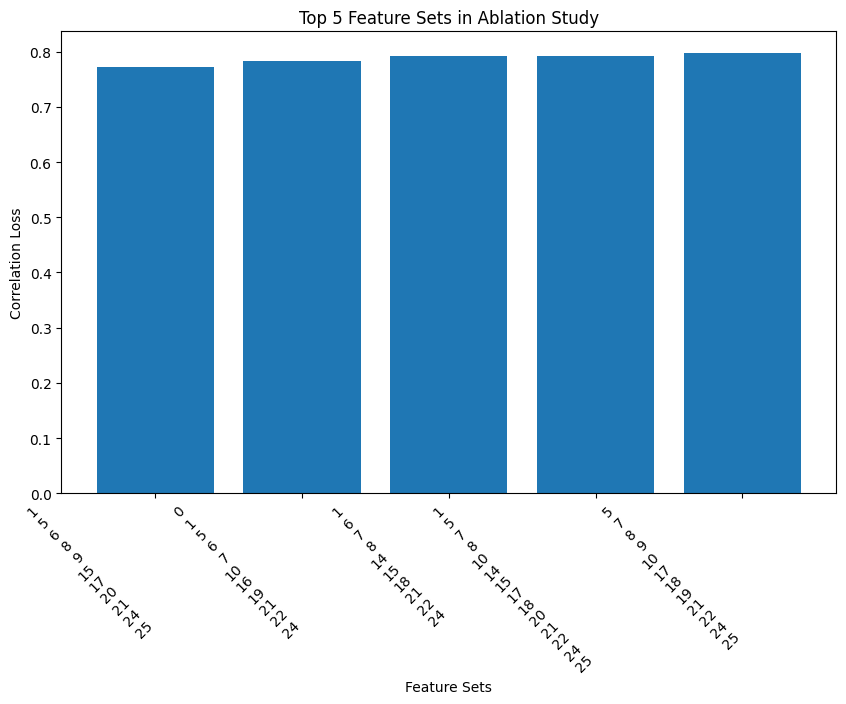

In [16]:
import random
from itertools import combinations
import numpy as np


def generate_feature_combinations(features, min_features=10):
    all_combinations = []
    for r in range(min_features, len(features) + 1):
        all_combinations.extend(combinations(features, r))
    return all_combinations


def sample_combinations(all_combinations, sample_size):
    if sample_size > len(all_combinations):
        raise ValueError("Sample size can't be larger than the total number of combinations")
    return random.sample(all_combinations, sample_size)


all_scalar_combinations = generate_feature_combinations(scalar_feature_indices)

sampled_combinations = sample_combinations(all_scalar_combinations, 1000)


def ablation_study_sampled(datasets, vector_features, node_out_dims, sampled_combinations, epochs=20, top_k=5):
    performance_records = []
    total_sets = len(sampled_combinations)

    for index, scalar_indices in enumerate(sampled_combinations):
        print(f"Processing set {index + 1} of {total_sets}: Scalar Indices = {scalar_indices}")

        model = GVP_RNN_Model(list(scalar_indices), vector_features, node_out_dims)
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        correlation_loss_history = train_model(datasets, model, criterion, optimizer, epochs=epochs, batch_size=128)

        final_performance = np.mean(correlation_loss_history[-5:]) 
        performance_records.append((final_performance, scalar_indices))

        print(f"Completed set {index + 1} of {total_sets}")


    top_performers = sorted(performance_records, key=lambda x: x[0])[:top_k]
    return top_performers


top_feature_sets_sampled = ablation_study_sampled(datasets, vector_feature_indices, node_out_dims, sampled_combinations, epochs=20, top_k=5)


performances = [performance for performance, _ in top_feature_sets_sampled]
feature_sets = ["\n".join(map(str, scalar_set)) for _, scalar_set in top_feature_sets_sampled]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_feature_sets_sampled)), performances, tick_label=feature_sets)
plt.xlabel('Feature Sets')
plt.ylabel('Correlation Loss')
plt.title('Top 5 Feature Sets in Ablation Study')
plt.xticks(rotation=45, ha="right") 
plt.show()

Epochs: 100%|█████████████████████████████████| 100/100 [00:29<00:00,  3.40it/s]


Best Feature Set (Correlation Loss): 0.7624097168445587, Scalar Indices: (1, 5, 7, 8, 10, 14, 15, 17, 18, 20, 21, 22, 24, 25)


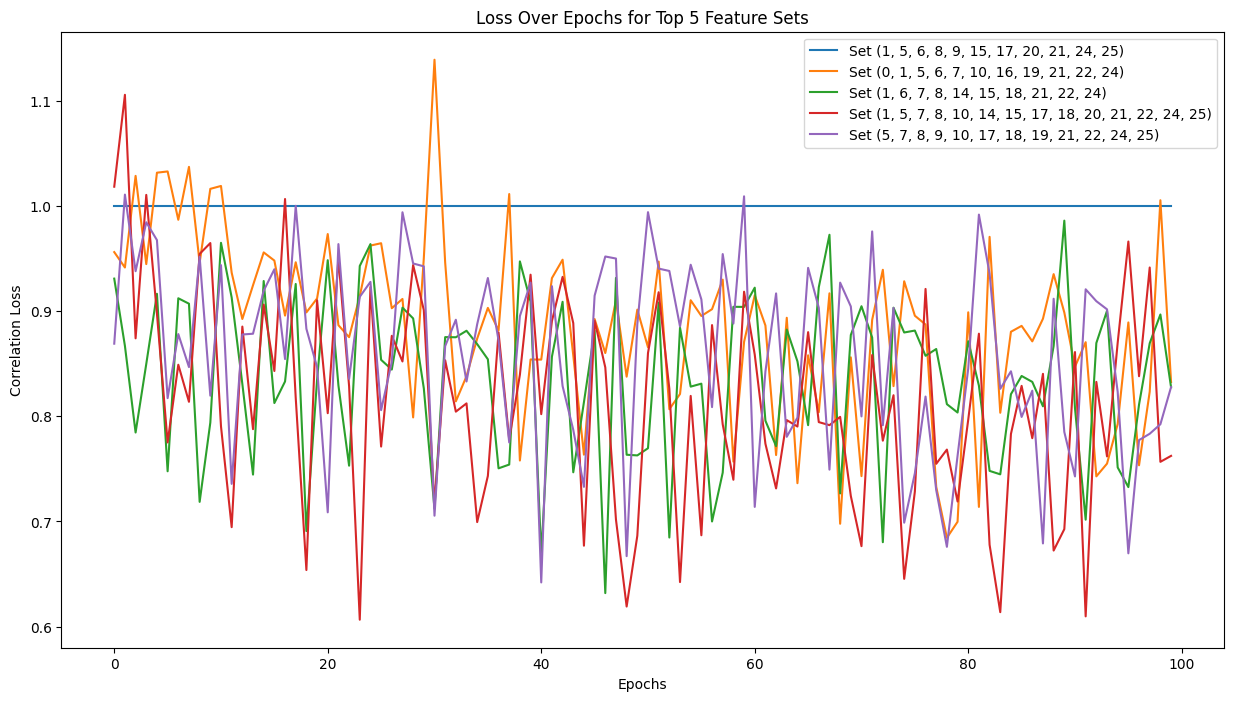

In [17]:
def extended_training_and_evaluation(top_feature_sets, datasets, vector_features, node_out_dims, extended_epochs=50):
    extended_performance_records = []

    for performance, scalar_indices in top_feature_sets:
        model = GVP_RNN_Model(list(scalar_indices), vector_features, node_out_dims)
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)


        extended_loss_history = train_model(datasets, model, criterion, optimizer, epochs=extended_epochs, batch_size=128)

        final_performance = extended_loss_history[-1] 
        extended_performance_records.append((final_performance, scalar_indices, extended_loss_history))


    best_performer = sorted(extended_performance_records, key=lambda x: x[0])[0]
    return best_performer, extended_performance_records


best_feature_set, extended_loss_histories = extended_training_and_evaluation(top_feature_sets_sampled, datasets, vector_feature_indices, node_out_dims, extended_epochs=100)


print(f"Best Feature Set (Correlation Loss): {best_feature_set[0]}, Scalar Indices: {best_feature_set[1]}")


plt.figure(figsize=(15, 8))
for _, scalar_set, loss_history in extended_loss_histories:
    plt.plot(loss_history, label=f"Set {scalar_set}")

plt.xlabel('Epochs')
plt.ylabel('Correlation Loss')
plt.title('Loss Over Epochs for Top 5 Feature Sets')
plt.legend()
plt.show()

# Forward Selection Ablation

In [6]:
def forward_feature_selection(datasets, all_features, vector_features, node_out_dims, epochs=20):
    current_feature_set = []
    remaining_features = all_features.copy()
    performance_records = []

    while remaining_features:
        best_performance = None
        best_feature = None

        for feature in remaining_features:
           
            test_feature_set = current_feature_set + [feature]
            model = GVP_RNN_Model(test_feature_set, vector_features, node_out_dims)
            model.to(device)
            optimizer = optim.Adam(model.parameters(), lr=0.001)

            correlation_loss_history = train_model(datasets, model, criterion, optimizer, epochs=epochs, batch_size=128)
            avg_performance = np.mean(correlation_loss_history[-5:])  # Average loss of last 5 epochs

            if best_performance is None or avg_performance < best_performance:
                best_performance = avg_performance
                best_feature = feature

        if best_feature is not None:
            current_feature_set.append(best_feature)
            remaining_features.remove(best_feature)
            performance_records.append((best_performance, current_feature_set.copy()))
            print(f"Added feature {best_feature}. Performance: {best_performance}")
        else:
            
            break

    return performance_records


feature_selection_results = forward_feature_selection(datasets, scalar_feature_indices, vector_feature_indices, node_out_dims, epochs=20)


for performance, feature_set in feature_selection_results:
    print(f"Feature Set: {feature_set}, Performance: {performance}")

Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.22s/it]

Epoch 0, Loss: 0.0529


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.20s/it]

Epoch 1, Loss: 0.0717


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.19s/it]

Epoch 2, Loss: 0.0571


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0485


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:17,  1.19s/it]

Epoch 4, Loss: 0.0594


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.22s/it]

Epoch 5, Loss: 0.0380


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.21s/it]

Epoch 6, Loss: 0.0371


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.24s/it]

Epoch 7, Loss: 0.0474


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.22s/it]

Epoch 8, Loss: 0.0383


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.21s/it]

Epoch 9, Loss: 0.0760


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.20s/it]

Epoch 10, Loss: 0.0495


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.24s/it]

Epoch 11, Loss: 0.0535


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.24s/it]

Epoch 12, Loss: 0.0956


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.24s/it]

Epoch 13, Loss: 0.0578


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0763


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.24s/it]

Epoch 15, Loss: 0.0943


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.24s/it]

Epoch 16, Loss: 0.0485


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.22s/it]

Epoch 17, Loss: 0.0466


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.21s/it]

Epoch 18, Loss: 0.0504


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]


Epoch 19, Loss: 0.0516


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.19s/it]

Epoch 0, Loss: 0.0558


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.20s/it]

Epoch 1, Loss: 0.1219


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2, Loss: 0.2341


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.22s/it]

Epoch 3, Loss: 0.0738


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0463


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.1435


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.20s/it]

Epoch 6, Loss: 0.0508


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.20s/it]

Epoch 7, Loss: 0.0910


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.1108


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:11<00:11,  1.17s/it]

Epoch 9, Loss: 0.0524


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.21s/it]

Epoch 10, Loss: 0.0484


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.20s/it]

Epoch 11, Loss: 0.0525


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.21s/it]

Epoch 12, Loss: 0.0463


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.21s/it]

Epoch 13, Loss: 0.0790


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:17<00:05,  1.19s/it]

Epoch 14, Loss: 0.0559


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.19s/it]

Epoch 15, Loss: 0.0749


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0731


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.19s/it]

Epoch 17, Loss: 0.0445


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.17s/it]

Epoch 18, Loss: 0.0500


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.19s/it]


Epoch 19, Loss: 0.0443


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.33s/it]

Epoch 0, Loss: 0.0805


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.25s/it]

Epoch 1, Loss: 0.0508


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.0807


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.0692


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.20s/it]

Epoch 4, Loss: 0.0527


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.0512


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.20s/it]

Epoch 6, Loss: 0.0512


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.19s/it]

Epoch 7, Loss: 0.0383


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.19s/it]

Epoch 8, Loss: 0.0471


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:11,  1.19s/it]

Epoch 9, Loss: 0.0474


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.19s/it]

Epoch 10, Loss: 0.0512


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.18s/it]

Epoch 11, Loss: 0.0393


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.18s/it]

Epoch 12, Loss: 0.0527


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.17s/it]

Epoch 13, Loss: 0.0489


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.22s/it]

Epoch 14, Loss: 0.0568


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:05,  1.28s/it]

Epoch 15, Loss: 0.0704


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.33s/it]

Epoch 16, Loss: 0.0529


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.32s/it]

Epoch 17, Loss: 0.0540


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.36s/it]

Epoch 18, Loss: 0.0482


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]


Epoch 19, Loss: 0.1436


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.16s/it]

Epoch 0, Loss: 0.0548


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.19s/it]

Epoch 1, Loss: 0.4582


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.24s/it]

Epoch 2, Loss: 0.0719


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.22s/it]

Epoch 3, Loss: 0.0529


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0664


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0407


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.23s/it]

Epoch 6, Loss: 0.1053


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:15,  1.25s/it]

Epoch 7, Loss: 0.0508


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.24s/it]

Epoch 8, Loss: 0.0902


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.0956


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.22s/it]

Epoch 10, Loss: 0.0525


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.21s/it]

Epoch 11, Loss: 0.0525


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.21s/it]

Epoch 12, Loss: 0.0594


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.21s/it]

Epoch 13, Loss: 0.0717


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0466


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.20s/it]

Epoch 15, Loss: 0.0578


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0588


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.20s/it]

Epoch 17, Loss: 0.0410


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.20s/it]

Epoch 18, Loss: 0.0477


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0535


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 0.0365


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.20s/it]

Epoch 1, Loss: 0.0504


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:19,  1.17s/it]

Epoch 2, Loss: 0.0454


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:18,  1.17s/it]

Epoch 3, Loss: 0.0664


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:17,  1.18s/it]

Epoch 4, Loss: 0.0435


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.18s/it]

Epoch 5, Loss: 0.0383


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.18s/it]

Epoch 6, Loss: 0.0371


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.17s/it]

Epoch 7, Loss: 0.0421


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:12,  1.18s/it]

Epoch 8, Loss: 0.0393


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:11<00:11,  1.19s/it]

Epoch 9, Loss: 0.0560


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.19s/it]

Epoch 10, Loss: 0.1265


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.20s/it]

Epoch 11, Loss: 0.0764


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.19s/it]

Epoch 12, Loss: 0.0790


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.18s/it]

Epoch 13, Loss: 0.0559


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:17<00:05,  1.19s/it]

Epoch 14, Loss: 0.0578


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:18<00:04,  1.19s/it]

Epoch 15, Loss: 0.0669


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.17s/it]

Epoch 16, Loss: 0.0498


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.16s/it]

Epoch 17, Loss: 0.0570


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.16s/it]

Epoch 18, Loss: 0.0570


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.18s/it]


Epoch 19, Loss: 0.0503


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.35s/it]

Epoch 0, Loss: 1.1216


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.25s/it]

Epoch 1, Loss: 0.0458


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.0512


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0371


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:17,  1.19s/it]

Epoch 4, Loss: 0.1436


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0504


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.20s/it]

Epoch 6, Loss: 0.0548


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.19s/it]

Epoch 7, Loss: 0.0428


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.19s/it]

Epoch 8, Loss: 0.0495


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:11,  1.19s/it]

Epoch 9, Loss: 0.0484


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.19s/it]

Epoch 10, Loss: 0.0512


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.19s/it]

Epoch 11, Loss: 0.0619


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.19s/it]

Epoch 12, Loss: 0.0537


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.18s/it]

Epoch 13, Loss: 0.0611


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.22s/it]

Epoch 14, Loss: 0.0660


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:05,  1.30s/it]

Epoch 15, Loss: 0.0380


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.33s/it]

Epoch 16, Loss: 0.0559


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.30s/it]

Epoch 17, Loss: 0.0454


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.30s/it]

Epoch 18, Loss: 0.0443


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0540


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.17s/it]

Epoch 0, Loss: 8.0436


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.18s/it]

Epoch 1, Loss: 0.1646


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.20s/it]

Epoch 2, Loss: 0.0512


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.22s/it]

Epoch 3, Loss: 0.0807


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0482


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0525


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.19s/it]

Epoch 6, Loss: 0.0396


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.20s/it]

Epoch 7, Loss: 0.0463


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0738


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.0622


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.22s/it]

Epoch 10, Loss: 0.0516


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.21s/it]

Epoch 11, Loss: 0.0512


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.19s/it]

Epoch 12, Loss: 0.0396


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.23s/it]

Epoch 13, Loss: 0.0570


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0566


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0512


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0445


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.20s/it]

Epoch 17, Loss: 0.0458


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.21s/it]

Epoch 18, Loss: 0.0764


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0516


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.25s/it]

Epoch 0, Loss: 0.0851


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.21s/it]

Epoch 1, Loss: 0.0525


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.20s/it]

Epoch 2, Loss: 0.0573


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0463


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:17,  1.19s/it]

Epoch 4, Loss: 0.0484


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.18s/it]

Epoch 5, Loss: 0.0790


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.18s/it]

Epoch 6, Loss: 0.0516


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.18s/it]

Epoch 7, Loss: 0.0588


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:12,  1.18s/it]

Epoch 8, Loss: 0.0543


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:11<00:11,  1.18s/it]

Epoch 9, Loss: 0.0446


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.18s/it]

Epoch 10, Loss: 0.0928


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.19s/it]

Epoch 11, Loss: 0.0535


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.18s/it]

Epoch 12, Loss: 0.1108


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.19s/it]

Epoch 13, Loss: 0.0428


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:17<00:05,  1.19s/it]

Epoch 14, Loss: 0.0512


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.19s/it]

Epoch 15, Loss: 0.0396


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0524


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.19s/it]

Epoch 17, Loss: 0.0594


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.23s/it]

Epoch 18, Loss: 0.0766


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.20s/it]


Epoch 19, Loss: 0.0704


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.18s/it]

Epoch 0, Loss: 10.1527


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.20s/it]

Epoch 1, Loss: 0.1585


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.28s/it]

Epoch 2, Loss: 0.0714


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:20,  1.25s/it]

Epoch 3, Loss: 0.0766


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.25s/it]

Epoch 4, Loss: 0.0492


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.23s/it]

Epoch 5, Loss: 0.0694


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.23s/it]

Epoch 6, Loss: 0.0512


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.22s/it]

Epoch 7, Loss: 0.0571


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.21s/it]

Epoch 8, Loss: 0.0664


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.20s/it]

Epoch 9, Loss: 0.0379


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.31s/it]

Epoch 10, Loss: 0.0410


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:11,  1.39s/it]

Epoch 11, Loss: 0.0559


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:09,  1.42s/it]

Epoch 12, Loss: 0.0690


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:08,  1.37s/it]

Epoch 13, Loss: 0.0433


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.32s/it]

Epoch 14, Loss: 0.0588


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.29s/it]

Epoch 15, Loss: 0.0540


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0611


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.25s/it]

Epoch 17, Loss: 0.0559


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.25s/it]

Epoch 18, Loss: 0.0383


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0482


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.24s/it]

Epoch 0, Loss: 0.0516


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.20s/it]

Epoch 1, Loss: 0.0760


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2, Loss: 0.0669


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.24s/it]

Epoch 3, Loss: 0.0731


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.32s/it]

Epoch 4, Loss: 0.0465


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.30s/it]

Epoch 5, Loss: 0.0466


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.27s/it]

Epoch 6, Loss: 0.0503


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:14,  1.25s/it]

Epoch 7, Loss: 0.0679


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.23s/it]

Epoch 8, Loss: 0.0470


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.21s/it]

Epoch 9, Loss: 0.0582


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.20s/it]

Epoch 10, Loss: 0.0588


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.23s/it]

Epoch 11, Loss: 0.0704


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.21s/it]

Epoch 12, Loss: 0.0393


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.21s/it]

Epoch 13, Loss: 0.0505


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:05,  1.20s/it]

Epoch 14, Loss: 0.0356


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.20s/it]

Epoch 15, Loss: 0.0714


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0669


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.20s/it]

Epoch 17, Loss: 0.0407


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.20s/it]

Epoch 18, Loss: 0.0696


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]


Epoch 19, Loss: 0.0665


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.19s/it]

Epoch 0, Loss: 0.1265


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.18s/it]

Epoch 1, Loss: 0.0537


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.18s/it]

Epoch 2, Loss: 0.0412


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:18,  1.18s/it]

Epoch 3, Loss: 0.0524


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:17,  1.18s/it]

Epoch 4, Loss: 0.0679


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.19s/it]

Epoch 5, Loss: 0.0669


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0498


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.22s/it]

Epoch 7, Loss: 0.0379


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.21s/it]

Epoch 8, Loss: 0.0465


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.21s/it]

Epoch 9, Loss: 0.0501


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.19s/it]

Epoch 10, Loss: 0.0512


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.19s/it]

Epoch 11, Loss: 0.0384


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.20s/it]

Epoch 12, Loss: 0.0764


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.20s/it]

Epoch 13, Loss: 0.0631


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:17<00:05,  1.19s/it]

Epoch 14, Loss: 0.0380


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.19s/it]

Epoch 15, Loss: 0.0471


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.18s/it]

Epoch 16, Loss: 0.0410


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.19s/it]

Epoch 17, Loss: 0.1108


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.19s/it]

Epoch 18, Loss: 0.0764


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.20s/it]


Epoch 19, Loss: 0.0763


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.23s/it]

Epoch 0, Loss: 0.0413


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.20s/it]

Epoch 1, Loss: 0.4975


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2, Loss: 0.0660


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.19s/it]

Epoch 3, Loss: 0.1053


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:17,  1.20s/it]

Epoch 4, Loss: 0.0503


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0410


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.19s/it]

Epoch 6, Loss: 0.0466


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.24s/it]

Epoch 7, Loss: 0.0471


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.24s/it]

Epoch 8, Loss: 0.0764


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.22s/it]

Epoch 9, Loss: 0.0783


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.22s/it]

Epoch 10, Loss: 0.0656


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.20s/it]

Epoch 11, Loss: 0.0738


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.19s/it]

Epoch 12, Loss: 0.0902


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.20s/it]

Epoch 13, Loss: 0.0484


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:05,  1.20s/it]

Epoch 14, Loss: 0.0535


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.19s/it]

Epoch 15, Loss: 0.0664


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.19s/it]

Epoch 16, Loss: 0.0910


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.20s/it]

Epoch 17, Loss: 0.0477


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.21s/it]

Epoch 18, Loss: 0.0690


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0605


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.19s/it]

Epoch 0, Loss: 0.0575


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.18s/it]

Epoch 1, Loss: 0.0484


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.18s/it]

Epoch 2, Loss: 0.0504


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:18,  1.18s/it]

Epoch 3, Loss: 0.0619


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:17,  1.17s/it]

Epoch 4, Loss: 0.0527


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.18s/it]

Epoch 5, Loss: 0.0484


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.18s/it]

Epoch 6, Loss: 0.0410


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.18s/it]

Epoch 7, Loss: 0.0443


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:12,  1.18s/it]

Epoch 8, Loss: 0.0463


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:11<00:11,  1.19s/it]

Epoch 9, Loss: 0.0578


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.19s/it]

Epoch 10, Loss: 0.0482


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.18s/it]

Epoch 11, Loss: 0.0463


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.18s/it]

Epoch 12, Loss: 0.0749


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.19s/it]

Epoch 13, Loss: 0.0521


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:17<00:05,  1.19s/it]

Epoch 14, Loss: 0.0484


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:18<00:04,  1.19s/it]

Epoch 15, Loss: 0.0477


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.18s/it]

Epoch 16, Loss: 0.0664


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.23s/it]

Epoch 17, Loss: 0.0484


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.21s/it]

Epoch 18, Loss: 0.0421


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.19s/it]


Epoch 19, Loss: 0.0570


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.30s/it]

Epoch 0, Loss: 0.0573


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.20s/it]

Epoch 1, Loss: 0.0470


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.19s/it]

Epoch 2, Loss: 0.0484


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.19s/it]

Epoch 3, Loss: 0.0664


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:17,  1.19s/it]

Epoch 4, Loss: 0.0396


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.19s/it]

Epoch 5, Loss: 0.0485


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.19s/it]

Epoch 6, Loss: 0.0571


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.19s/it]

Epoch 7, Loss: 0.0548


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.19s/it]

Epoch 8, Loss: 0.0482


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.22s/it]

Epoch 9, Loss: 0.0766


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.25s/it]

Epoch 10, Loss: 0.0516


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:10,  1.33s/it]

Epoch 11, Loss: 0.0482


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:09,  1.37s/it]

Epoch 12, Loss: 0.0516


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:08,  1.44s/it]

Epoch 13, Loss: 0.0696


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:07,  1.48s/it]

Epoch 14, Loss: 0.0731


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.48s/it]

Epoch 15, Loss: 0.0412


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:04,  1.44s/it]

Epoch 16, Loss: 0.0484


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.44s/it]

Epoch 17, Loss: 0.0571


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.38s/it]

Epoch 18, Loss: 0.0570


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.32s/it]


Epoch 19, Loss: 0.0500


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:26,  1.38s/it]

Epoch 0, Loss: 0.0374


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:24,  1.38s/it]

Epoch 1, Loss: 0.0482


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:24,  1.44s/it]

Epoch 2, Loss: 0.0956


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:22,  1.39s/it]

Epoch 3, Loss: 0.0443


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:20,  1.39s/it]

Epoch 4, Loss: 0.0371


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:20,  1.43s/it]

Epoch 5, Loss: 0.0731


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:18,  1.44s/it]

Epoch 6, Loss: 0.0470


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:17,  1.46s/it]

Epoch 7, Loss: 0.0754


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:16,  1.47s/it]

Epoch 8, Loss: 0.0477


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:14<00:15,  1.55s/it]

Epoch 9, Loss: 0.0477


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:16<00:14,  1.56s/it]

Epoch 10, Loss: 0.0407


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:17<00:11,  1.47s/it]

Epoch 11, Loss: 0.0433


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:18<00:09,  1.42s/it]

Epoch 12, Loss: 0.0428


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:20<00:08,  1.37s/it]

Epoch 13, Loss: 0.0611


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:21<00:06,  1.33s/it]

Epoch 14, Loss: 0.0412


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:22<00:05,  1.29s/it]

Epoch 15, Loss: 0.0588


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:23<00:03,  1.27s/it]

Epoch 16, Loss: 0.0679


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:25<00:02,  1.29s/it]

Epoch 17, Loss: 0.0508


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:26<00:01,  1.27s/it]

Epoch 18, Loss: 0.0631


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.38s/it]


Epoch 19, Loss: 0.0611


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.26s/it]

Epoch 0, Loss: 22.0081


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.27s/it]

Epoch 1, Loss: 2.8074


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.25s/it]

Epoch 2, Loss: 0.1794


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.27s/it]

Epoch 3, Loss: 0.0529


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:20,  1.40s/it]

Epoch 4, Loss: 0.0559


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:19,  1.42s/it]

Epoch 5, Loss: 0.0407


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:20,  1.55s/it]

Epoch 6, Loss: 0.0578


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:19,  1.60s/it]

Epoch 7, Loss: 0.0421


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:16,  1.51s/it]

Epoch 8, Loss: 0.0482


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:14<00:14,  1.44s/it]

Epoch 9, Loss: 0.0605


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:15<00:12,  1.40s/it]

Epoch 10, Loss: 0.0571


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:17<00:11,  1.43s/it]

Epoch 11, Loss: 0.0588


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:18<00:10,  1.43s/it]

Epoch 12, Loss: 0.0443


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:19<00:08,  1.39s/it]

Epoch 13, Loss: 0.0477


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:20<00:06,  1.33s/it]

Epoch 14, Loss: 0.0383


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:22<00:05,  1.31s/it]

Epoch 15, Loss: 0.0573


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:23<00:03,  1.28s/it]

Epoch 16, Loss: 0.0807


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:24<00:02,  1.27s/it]

Epoch 17, Loss: 0.0763


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:26<00:01,  1.29s/it]

Epoch 18, Loss: 0.1436


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]


Epoch 19, Loss: 0.0573


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.32s/it]

Epoch 0, Loss: 3.3186


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.27s/it]

Epoch 1, Loss: 0.0421


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.27s/it]

Epoch 2, Loss: 0.0428


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.27s/it]

Epoch 3, Loss: 0.0466


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0704


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.1053


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.25s/it]

Epoch 6, Loss: 0.0477


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:14,  1.24s/it]

Epoch 7, Loss: 0.0492


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.24s/it]

Epoch 8, Loss: 0.0516


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.0446


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.27s/it]

Epoch 10, Loss: 0.0664


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0656


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0499


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0885


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.24s/it]

Epoch 14, Loss: 0.0516


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.25s/it]

Epoch 15, Loss: 0.0754


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0470


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.25s/it]

Epoch 17, Loss: 0.0474


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.25s/it]

Epoch 18, Loss: 0.1053


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.25s/it]


Epoch 19, Loss: 0.0499


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.27s/it]

Epoch 0, Loss: 480.7204


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.28s/it]

Epoch 1, Loss: 211.5302


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:22,  1.32s/it]

Epoch 2, Loss: 70.8040


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.29s/it]

Epoch 3, Loss: 9.7779


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.27s/it]

Epoch 4, Loss: 0.0495


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.27s/it]

Epoch 5, Loss: 0.0619


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.26s/it]

Epoch 6, Loss: 0.0525


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0504


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0524


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.27s/it]

Epoch 9, Loss: 0.0943


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.27s/it]

Epoch 10, Loss: 0.0443


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0380


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0665


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 0.0512


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.26s/it]

Epoch 14, Loss: 0.0619


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0482


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0501


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.26s/it]

Epoch 17, Loss: 0.0380


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.26s/it]

Epoch 18, Loss: 0.0512


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]


Epoch 19, Loss: 0.0943


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.19s/it]

Epoch 0, Loss: 1.3823


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.21s/it]

Epoch 1, Loss: 0.1176


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.0543


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.23s/it]

Epoch 3, Loss: 0.0665


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.22s/it]

Epoch 4, Loss: 0.0524


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.22s/it]

Epoch 5, Loss: 0.0384


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.23s/it]

Epoch 6, Loss: 0.0407


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.23s/it]

Epoch 7, Loss: 0.0783


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.24s/it]

Epoch 8, Loss: 0.0764


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.24s/it]

Epoch 9, Loss: 0.0499


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.24s/it]

Epoch 10, Loss: 0.0694


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.25s/it]

Epoch 11, Loss: 0.0466


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.24s/it]

Epoch 12, Loss: 0.0445


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.24s/it]

Epoch 13, Loss: 0.0717


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.24s/it]

Epoch 14, Loss: 0.0443


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.23s/it]

Epoch 15, Loss: 0.0447


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.24s/it]

Epoch 16, Loss: 0.0763


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.23s/it]

Epoch 17, Loss: 0.0763


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.24s/it]

Epoch 18, Loss: 0.0717


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0692


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 0.4802


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.31s/it]

Epoch 1, Loss: 0.0397


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:22,  1.30s/it]

Epoch 2, Loss: 0.0489


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.35s/it]

Epoch 3, Loss: 0.0540


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.31s/it]

Epoch 4, Loss: 0.0396


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.29s/it]

Epoch 5, Loss: 0.0407


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.27s/it]

Epoch 6, Loss: 0.0664


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0540


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.1053


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0664


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.26s/it]

Epoch 10, Loss: 0.0790


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.25s/it]

Epoch 11, Loss: 0.1053


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0548


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0512


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.24s/it]

Epoch 14, Loss: 0.0660


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.25s/it]

Epoch 15, Loss: 0.0570


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.0506


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.28s/it]

Epoch 17, Loss: 0.0694


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0660


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0749
Added feature 8. Performance: 0.047494562715291976


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.26s/it]

Epoch 0, Loss: 1.8061


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.27s/it]

Epoch 1, Loss: 0.0383


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.25s/it]

Epoch 2, Loss: 0.0566


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.24s/it]

Epoch 3, Loss: 0.0393


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.24s/it]

Epoch 4, Loss: 0.0465


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0477


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.27s/it]

Epoch 6, Loss: 0.0410


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0664


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.25s/it]

Epoch 8, Loss: 0.0525


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.0943


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.25s/it]

Epoch 10, Loss: 0.0482


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.25s/it]

Epoch 11, Loss: 0.0412


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0421


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0500


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0559


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.25s/it]

Epoch 15, Loss: 0.0694


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0749


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.26s/it]

Epoch 17, Loss: 0.0754


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.26s/it]

Epoch 18, Loss: 0.0479


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]


Epoch 19, Loss: 0.0656


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.22s/it]

Epoch 0, Loss: 0.0512


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.23s/it]

Epoch 1, Loss: 0.0749


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.0902


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.23s/it]

Epoch 3, Loss: 0.0474


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.22s/it]

Epoch 4, Loss: 0.0465


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.23s/it]

Epoch 5, Loss: 0.0384


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.23s/it]

Epoch 6, Loss: 0.0412


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:15,  1.28s/it]

Epoch 7, Loss: 0.0543


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0692


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0696


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.1265


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:10,  1.25s/it]

Epoch 11, Loss: 0.0543


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.24s/it]

Epoch 12, Loss: 0.0499


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0783


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.24s/it]

Epoch 14, Loss: 0.0393


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.24s/it]

Epoch 15, Loss: 0.0692


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.0559


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.25s/it]

Epoch 17, Loss: 0.0425


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.24s/it]

Epoch 18, Loss: 0.0396


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0498


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.24s/it]

Epoch 0, Loss: 0.0605


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.23s/it]

Epoch 1, Loss: 0.0566


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.0462


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.28s/it]

Epoch 3, Loss: 0.0543


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0594


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.24s/it]

Epoch 5, Loss: 0.0527


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.24s/it]

Epoch 6, Loss: 0.0764


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.23s/it]

Epoch 7, Loss: 0.0631


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.22s/it]

Epoch 8, Loss: 0.0619


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.0501


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.0525


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.23s/it]

Epoch 11, Loss: 0.0524


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.23s/it]

Epoch 12, Loss: 0.0902


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.23s/it]

Epoch 13, Loss: 0.0380


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.22s/it]

Epoch 14, Loss: 0.0543


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.22s/it]

Epoch 15, Loss: 0.0588


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.23s/it]

Epoch 16, Loss: 0.0447


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.28s/it]

Epoch 17, Loss: 0.0548


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.27s/it]

Epoch 18, Loss: 0.0605


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0679


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.23s/it]

Epoch 0, Loss: 0.0660


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.22s/it]

Epoch 1, Loss: 0.0559


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.0516


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.23s/it]

Epoch 3, Loss: 0.0477


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.22s/it]

Epoch 4, Loss: 0.0482


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.23s/it]

Epoch 5, Loss: 0.0443


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.23s/it]

Epoch 6, Loss: 0.0447


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.24s/it]

Epoch 7, Loss: 0.0543


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.23s/it]

Epoch 8, Loss: 0.0760


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.24s/it]

Epoch 9, Loss: 0.0731


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.24s/it]

Epoch 10, Loss: 0.0537


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.24s/it]

Epoch 11, Loss: 0.0506


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.24s/it]

Epoch 12, Loss: 0.0516


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.24s/it]

Epoch 13, Loss: 0.0356


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.23s/it]

Epoch 14, Loss: 0.0527


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:05,  1.28s/it]

Epoch 15, Loss: 0.0790


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.26s/it]

Epoch 16, Loss: 0.0548


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.25s/it]

Epoch 17, Loss: 0.0763


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.24s/it]

Epoch 18, Loss: 0.0582


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.25s/it]


Epoch 19, Loss: 0.0477


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.37s/it]

Epoch 0, Loss: 0.6240


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.30s/it]

Epoch 1, Loss: 0.0550


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.28s/it]

Epoch 2, Loss: 0.0713


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0471


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0482


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.0484


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.26s/it]

Epoch 6, Loss: 0.0512


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:14,  1.25s/it]

Epoch 7, Loss: 0.0527


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.24s/it]

Epoch 8, Loss: 0.0458


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.24s/it]

Epoch 9, Loss: 0.0527


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.24s/it]

Epoch 10, Loss: 0.0474


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:09,  1.23s/it]

Epoch 11, Loss: 0.0943


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.23s/it]

Epoch 12, Loss: 0.0807


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.23s/it]

Epoch 13, Loss: 0.0529


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.23s/it]

Epoch 14, Loss: 0.0760


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.24s/it]

Epoch 15, Loss: 0.0763


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.0749


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0790


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.24s/it]

Epoch 18, Loss: 0.0379


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.25s/it]


Epoch 19, Loss: 0.0529


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.21s/it]

Epoch 0, Loss: 0.7632


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.21s/it]

Epoch 1, Loss: 0.0418


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.0619


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.25s/it]

Epoch 3, Loss: 0.0484


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.24s/it]

Epoch 4, Loss: 0.0540


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.0463


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.24s/it]

Epoch 6, Loss: 0.0383


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.24s/it]

Epoch 7, Loss: 0.0766


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.25s/it]

Epoch 8, Loss: 0.0548


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.0588


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.0465


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:10,  1.27s/it]

Epoch 11, Loss: 0.0447


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0764


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.28s/it]

Epoch 13, Loss: 0.0548


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.27s/it]

Epoch 14, Loss: 0.0380


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:05,  1.26s/it]

Epoch 15, Loss: 0.0421


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0454


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0525


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.23s/it]

Epoch 18, Loss: 0.0571


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.25s/it]


Epoch 19, Loss: 0.0477


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.21s/it]

Epoch 0, Loss: 0.0602


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.24s/it]

Epoch 1, Loss: 0.0444


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.25s/it]

Epoch 2, Loss: 0.0694


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.25s/it]

Epoch 3, Loss: 0.0717


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.25s/it]

Epoch 4, Loss: 0.0447


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.0588


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.25s/it]

Epoch 6, Loss: 0.1108


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.24s/it]

Epoch 7, Loss: 0.0471


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.24s/it]

Epoch 8, Loss: 0.0543


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.0764


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.24s/it]

Epoch 10, Loss: 0.0471


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.24s/it]

Epoch 11, Loss: 0.0412


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0754


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0738


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.26s/it]

Epoch 14, Loss: 0.0512


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:05,  1.25s/it]

Epoch 15, Loss: 0.0696


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0407


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.25s/it]

Epoch 17, Loss: 0.0568


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.25s/it]

Epoch 18, Loss: 0.0356


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.25s/it]


Epoch 19, Loss: 0.0371


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:26,  1.41s/it]

Epoch 0, Loss: 5.9484


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.31s/it]

Epoch 1, Loss: 0.0778


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.28s/it]

Epoch 2, Loss: 0.0692


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0790


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.28s/it]

Epoch 4, Loss: 0.0466


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0714


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.27s/it]

Epoch 6, Loss: 0.0447


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.1053


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0714


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0543


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.0885


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:09,  1.25s/it]

Epoch 11, Loss: 0.0763


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.24s/it]

Epoch 12, Loss: 0.0495


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0428


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0717


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.24s/it]

Epoch 15, Loss: 0.0516


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.0582


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.23s/it]

Epoch 17, Loss: 0.0537


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.23s/it]

Epoch 18, Loss: 0.0559


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]


Epoch 19, Loss: 0.0447


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.25s/it]

Epoch 0, Loss: 1.7026


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.25s/it]

Epoch 1, Loss: 0.0907


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.25s/it]

Epoch 2, Loss: 0.0379


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0749


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.25s/it]

Epoch 4, Loss: 0.0663


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.0371


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.25s/it]

Epoch 6, Loss: 0.0660


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.25s/it]

Epoch 7, Loss: 0.0484


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.28s/it]

Epoch 8, Loss: 0.0505


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.28s/it]

Epoch 9, Loss: 0.0696


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.27s/it]

Epoch 10, Loss: 0.0482


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0383


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0421


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.24s/it]

Epoch 13, Loss: 0.0588


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0482


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.30s/it]

Epoch 15, Loss: 0.0421


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.29s/it]

Epoch 16, Loss: 0.0660


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.28s/it]

Epoch 17, Loss: 0.0470


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0407


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0380


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.26s/it]

Epoch 0, Loss: 0.0485


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.25s/it]

Epoch 1, Loss: 0.0704


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.27s/it]

Epoch 2, Loss: 0.0498


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0474


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.25s/it]

Epoch 4, Loss: 0.0704


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.0512


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.25s/it]

Epoch 6, Loss: 0.0463


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.24s/it]

Epoch 7, Loss: 0.0540


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.25s/it]

Epoch 8, Loss: 0.0749


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.0717


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.24s/it]

Epoch 10, Loss: 0.0508


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.24s/it]

Epoch 11, Loss: 0.0694


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.24s/it]

Epoch 12, Loss: 0.0466


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.24s/it]

Epoch 13, Loss: 0.0664


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.24s/it]

Epoch 14, Loss: 0.0783


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.24s/it]

Epoch 15, Loss: 0.0714


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.1108


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.25s/it]

Epoch 17, Loss: 0.0535


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.25s/it]

Epoch 18, Loss: 0.0482


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0516


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.23s/it]

Epoch 0, Loss: 0.0470


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.25s/it]

Epoch 1, Loss: 0.0443


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.24s/it]

Epoch 2, Loss: 0.0524


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.24s/it]

Epoch 3, Loss: 0.1265


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.24s/it]

Epoch 4, Loss: 0.0594


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.0503


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.25s/it]

Epoch 6, Loss: 0.0559


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.25s/it]

Epoch 7, Loss: 0.0928


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.25s/it]

Epoch 8, Loss: 0.0495


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.0443


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.0525


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.28s/it]

Epoch 11, Loss: 0.0465


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0525


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.26s/it]

Epoch 13, Loss: 0.0594


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.26s/it]

Epoch 14, Loss: 0.0527


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.24s/it]

Epoch 15, Loss: 0.0379


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0470


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.25s/it]

Epoch 17, Loss: 0.0559


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.24s/it]

Epoch 18, Loss: 0.0356


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.25s/it]


Epoch 19, Loss: 0.0380


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.27s/it]

Epoch 0, Loss: 1.7295


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0766


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.26s/it]

Epoch 2, Loss: 0.0471


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0807


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0396


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0407


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.26s/it]

Epoch 6, Loss: 0.1108


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.25s/it]

Epoch 7, Loss: 0.0482


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.25s/it]

Epoch 8, Loss: 0.0956


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.1053


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.25s/it]

Epoch 10, Loss: 0.0495


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.25s/it]

Epoch 11, Loss: 0.0611


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0470


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0479


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0421


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.25s/it]

Epoch 15, Loss: 0.0571


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0384


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.25s/it]

Epoch 17, Loss: 0.0525


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.28s/it]

Epoch 18, Loss: 0.0910


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]


Epoch 19, Loss: 0.0535


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.27s/it]

Epoch 0, Loss: 0.0641


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0435


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.25s/it]

Epoch 2, Loss: 0.0559


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.25s/it]

Epoch 3, Loss: 0.1436


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0694


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.0393


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.24s/it]

Epoch 6, Loss: 0.0527


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:14,  1.24s/it]

Epoch 7, Loss: 0.0669


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.25s/it]

Epoch 8, Loss: 0.0548


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.1053


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.0559


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0482


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0477


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0470


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.24s/it]

Epoch 14, Loss: 0.0525


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.25s/it]

Epoch 15, Loss: 0.0578


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0505


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.25s/it]

Epoch 17, Loss: 0.0910


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.25s/it]

Epoch 18, Loss: 0.0527


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.25s/it]


Epoch 19, Loss: 0.0458


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.28s/it]

Epoch 0, Loss: 12.4434


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.28s/it]

Epoch 1, Loss: 0.3442


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.25s/it]

Epoch 2, Loss: 0.0394


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.22s/it]

Epoch 3, Loss: 0.0374


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.0466


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.29s/it]

Epoch 5, Loss: 0.0570


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.28s/it]

Epoch 6, Loss: 0.1265


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0463


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.27s/it]

Epoch 8, Loss: 0.0690


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.27s/it]

Epoch 9, Loss: 0.0448


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.1435


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.34s/it]

Epoch 11, Loss: 0.0446


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:09,  1.32s/it]

Epoch 12, Loss: 0.0512


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.29s/it]

Epoch 13, Loss: 0.0498


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.29s/it]

Epoch 14, Loss: 0.0714


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0505


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0485


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0540


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.30s/it]

Epoch 18, Loss: 0.0559


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0477


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.27s/it]

Epoch 0, Loss: 33.6003


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 3.7214


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.29s/it]

Epoch 2, Loss: 0.1322


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.34s/it]

Epoch 3, Loss: 0.0498


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.31s/it]

Epoch 4, Loss: 0.0445


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.29s/it]

Epoch 5, Loss: 0.0783


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.27s/it]

Epoch 6, Loss: 0.0631


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0956


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0477


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.0540


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.24s/it]

Epoch 10, Loss: 0.0428


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:09,  1.25s/it]

Epoch 11, Loss: 0.0664


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0692


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0679


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0714


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.25s/it]

Epoch 15, Loss: 0.0482


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0588


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0356


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.24s/it]

Epoch 18, Loss: 0.0482


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]


Epoch 19, Loss: 0.0582


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.28s/it]

Epoch 0, Loss: 63.8202


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.27s/it]

Epoch 1, Loss: 18.1550


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.27s/it]

Epoch 2, Loss: 2.6260


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.1408


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0479


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.30s/it]

Epoch 5, Loss: 0.0619


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.27s/it]

Epoch 6, Loss: 0.0484


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0535


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0412


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0537


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.27s/it]

Epoch 10, Loss: 0.0641


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.25s/it]

Epoch 11, Loss: 0.0384


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0508


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0548


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0525


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.25s/it]

Epoch 15, Loss: 0.0505


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0425


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0384


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.24s/it]

Epoch 18, Loss: 0.0463


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]


Epoch 19, Loss: 0.0506


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:29,  1.58s/it]

Epoch 0, Loss: 1281.9454


Epochs:  10%|███████▉                                                                       | 2/20 [00:03<00:28,  1.57s/it]

Epoch 1, Loss: 440.1341


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:24,  1.46s/it]

Epoch 2, Loss: 138.6815


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:22,  1.41s/it]

Epoch 3, Loss: 35.7644


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:20,  1.36s/it]

Epoch 4, Loss: 1.2221


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.33s/it]

Epoch 5, Loss: 0.0543


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.31s/it]

Epoch 6, Loss: 0.0790


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.29s/it]

Epoch 7, Loss: 0.0477


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.28s/it]

Epoch 8, Loss: 0.0454


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.28s/it]

Epoch 9, Loss: 0.0548


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.28s/it]

Epoch 10, Loss: 0.0477


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.31s/it]

Epoch 11, Loss: 0.0371


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.31s/it]

Epoch 12, Loss: 0.0447


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.29s/it]

Epoch 13, Loss: 0.0631


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.28s/it]

Epoch 14, Loss: 0.0578


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.28s/it]

Epoch 15, Loss: 0.0379


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.28s/it]

Epoch 16, Loss: 0.0928


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.27s/it]

Epoch 17, Loss: 0.0516


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0498


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.31s/it]


Epoch 19, Loss: 0.0669


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 0.4382


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.21s/it]

Epoch 1, Loss: 0.0588


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.0470


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.24s/it]

Epoch 3, Loss: 0.0717


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.25s/it]

Epoch 4, Loss: 0.0568


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.0690


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.25s/it]

Epoch 6, Loss: 0.0447


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:15,  1.26s/it]

Epoch 7, Loss: 0.0559


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.25s/it]

Epoch 8, Loss: 0.0396


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.1265


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.25s/it]

Epoch 10, Loss: 0.1436


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:10,  1.26s/it]

Epoch 11, Loss: 0.0665


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0498


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.26s/it]

Epoch 13, Loss: 0.0407


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0371


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:05,  1.25s/it]

Epoch 15, Loss: 0.0474


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0548


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0760


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.29s/it]

Epoch 18, Loss: 0.0454


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.25s/it]


Epoch 19, Loss: 0.0594


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.23s/it]

Epoch 0, Loss: 0.0946


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.22s/it]

Epoch 1, Loss: 0.0587


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.0587


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.24s/it]

Epoch 3, Loss: 0.0485


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.24s/it]

Epoch 4, Loss: 0.0458


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.24s/it]

Epoch 5, Loss: 0.0516


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:17,  1.31s/it]

Epoch 6, Loss: 0.0664


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.30s/it]

Epoch 7, Loss: 0.0447


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.29s/it]

Epoch 8, Loss: 0.0559


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.28s/it]

Epoch 9, Loss: 0.0482


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.32s/it]

Epoch 10, Loss: 0.0764


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.30s/it]

Epoch 11, Loss: 0.0435


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.28s/it]

Epoch 12, Loss: 0.0582


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 0.0696


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0694


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.25s/it]

Epoch 15, Loss: 0.0631


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0559


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.25s/it]

Epoch 17, Loss: 0.0505


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.25s/it]

Epoch 18, Loss: 0.0570


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0463
Added feature 17. Performance: 0.04286549501121044


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.26s/it]

Epoch 0, Loss: 0.3738


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0731


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.27s/it]

Epoch 2, Loss: 0.0543


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0482


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0462


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.0356


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.25s/it]

Epoch 6, Loss: 0.0559


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.25s/it]

Epoch 7, Loss: 0.0508


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.24s/it]

Epoch 8, Loss: 0.0421


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.24s/it]

Epoch 9, Loss: 0.0766


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.24s/it]

Epoch 10, Loss: 0.0943


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.24s/it]

Epoch 11, Loss: 0.0540


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.24s/it]

Epoch 12, Loss: 0.0447


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.24s/it]

Epoch 13, Loss: 0.0428


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.24s/it]

Epoch 14, Loss: 0.0477


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.25s/it]

Epoch 15, Loss: 0.0749


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0594


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.28s/it]

Epoch 17, Loss: 0.0477


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.27s/it]

Epoch 18, Loss: 0.1436


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.25s/it]


Epoch 19, Loss: 0.0573


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.27s/it]

Epoch 0, Loss: 0.3671


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0605


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.26s/it]

Epoch 2, Loss: 0.0371


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0504


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0371


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0443


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.25s/it]

Epoch 6, Loss: 0.0525


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0763


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.25s/it]

Epoch 8, Loss: 0.0396


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.0694


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.25s/it]

Epoch 10, Loss: 0.0501


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0516


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0477


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.26s/it]

Epoch 13, Loss: 0.0807


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0499


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0956


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0571


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.25s/it]

Epoch 17, Loss: 0.0489


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.25s/it]

Epoch 18, Loss: 0.0465


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]


Epoch 19, Loss: 0.0512


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.26s/it]

Epoch 0, Loss: 0.0679


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0512


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:22,  1.33s/it]

Epoch 2, Loss: 0.0956


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.30s/it]

Epoch 3, Loss: 0.0548


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.31s/it]

Epoch 4, Loss: 0.0665


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.29s/it]

Epoch 5, Loss: 0.0463


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.28s/it]

Epoch 6, Loss: 0.0805


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0482


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.29s/it]

Epoch 8, Loss: 0.0512


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.28s/it]

Epoch 9, Loss: 0.0435


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.28s/it]

Epoch 10, Loss: 0.0694


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0482


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0489


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.26s/it]

Epoch 13, Loss: 0.0588


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.28s/it]

Epoch 14, Loss: 0.0479


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.28s/it]

Epoch 15, Loss: 0.0690


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0466


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.26s/it]

Epoch 17, Loss: 0.0679


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0783


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0540


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.28s/it]

Epoch 0, Loss: 0.0812


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.25s/it]

Epoch 1, Loss: 0.0495


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.26s/it]

Epoch 2, Loss: 0.0505


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0466


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0529


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0445


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.32s/it]

Epoch 6, Loss: 0.0477


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.31s/it]

Epoch 7, Loss: 0.0731


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.30s/it]

Epoch 8, Loss: 0.0749


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.28s/it]

Epoch 9, Loss: 0.0506


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.29s/it]

Epoch 10, Loss: 0.0560


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.28s/it]

Epoch 11, Loss: 0.0559


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0445


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 0.0578


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0492


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0489


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.26s/it]

Epoch 16, Loss: 0.0454


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.27s/it]

Epoch 17, Loss: 0.0885


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.1265


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0766


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 0.1313


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.43s/it]

Epoch 1, Loss: 0.0764


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.36s/it]

Epoch 2, Loss: 0.0594


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.32s/it]

Epoch 3, Loss: 0.0540


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.31s/it]

Epoch 4, Loss: 0.0568


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.31s/it]

Epoch 5, Loss: 0.0499


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.31s/it]

Epoch 6, Loss: 0.0484


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.31s/it]

Epoch 7, Loss: 0.0641


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:15,  1.38s/it]

Epoch 8, Loss: 0.0754


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.35s/it]

Epoch 9, Loss: 0.0543


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:12,  1.34s/it]

Epoch 10, Loss: 0.0665


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.31s/it]

Epoch 11, Loss: 0.0379


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.30s/it]

Epoch 12, Loss: 0.0605


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.30s/it]

Epoch 13, Loss: 0.0731


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.29s/it]

Epoch 14, Loss: 0.0560


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.29s/it]

Epoch 15, Loss: 0.0516


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.29s/it]

Epoch 16, Loss: 0.0512


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.30s/it]

Epoch 17, Loss: 0.0535


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.29s/it]

Epoch 18, Loss: 0.0619


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.31s/it]


Epoch 19, Loss: 0.0503


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.27s/it]

Epoch 0, Loss: 0.0529


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0766


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.25s/it]

Epoch 2, Loss: 0.0383


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0501


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.27s/it]

Epoch 4, Loss: 0.0396


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.27s/it]

Epoch 5, Loss: 0.0588


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.27s/it]

Epoch 6, Loss: 0.0521


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0783


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0704


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.27s/it]

Epoch 9, Loss: 0.0656


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.0760


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0462


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0760


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.31s/it]

Epoch 13, Loss: 0.0714


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.30s/it]

Epoch 14, Loss: 0.0471


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.30s/it]

Epoch 15, Loss: 0.0474


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.29s/it]

Epoch 16, Loss: 0.0500


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.29s/it]

Epoch 17, Loss: 0.0463


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.29s/it]

Epoch 18, Loss: 0.0754


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0568


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.24s/it]

Epoch 0, Loss: 0.0700


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0748


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.26s/it]

Epoch 2, Loss: 0.0437


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.25s/it]

Epoch 3, Loss: 0.0558


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.25s/it]

Epoch 4, Loss: 0.0461


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0560


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.26s/it]

Epoch 6, Loss: 0.0484


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.25s/it]

Epoch 7, Loss: 0.0379


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.25s/it]

Epoch 8, Loss: 0.1053


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0525


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.25s/it]

Epoch 10, Loss: 0.0540


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.25s/it]

Epoch 11, Loss: 0.0447


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0928


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.26s/it]

Epoch 13, Loss: 0.0902


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.26s/it]

Epoch 14, Loss: 0.0482


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0749


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.26s/it]

Epoch 16, Loss: 0.0521


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.30s/it]

Epoch 17, Loss: 0.0529


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.33s/it]

Epoch 18, Loss: 0.0477


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0805


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.31s/it]

Epoch 0, Loss: 0.0736


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0458


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.25s/it]

Epoch 2, Loss: 0.0516


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0717


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.28s/it]

Epoch 4, Loss: 0.0570


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.27s/it]

Epoch 5, Loss: 0.0412


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.26s/it]

Epoch 6, Loss: 0.0525


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0396


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0582


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.28s/it]

Epoch 9, Loss: 0.0714


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.27s/it]

Epoch 10, Loss: 0.0498


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.25s/it]

Epoch 11, Loss: 0.0537


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0505


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 0.0428


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.26s/it]

Epoch 14, Loss: 0.0521


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.25s/it]

Epoch 15, Loss: 0.0407


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0529


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.25s/it]

Epoch 17, Loss: 0.0506


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.25s/it]

Epoch 18, Loss: 0.0407


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]


Epoch 19, Loss: 0.0559


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.29s/it]

Epoch 0, Loss: 0.0511


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:24,  1.37s/it]

Epoch 1, Loss: 0.0425


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:22,  1.33s/it]

Epoch 2, Loss: 0.0425


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.31s/it]

Epoch 3, Loss: 0.0477


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.30s/it]

Epoch 4, Loss: 0.1108


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0548


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.28s/it]

Epoch 6, Loss: 0.0463


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0445


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:15,  1.41s/it]

Epoch 8, Loss: 0.0463


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.36s/it]

Epoch 9, Loss: 0.0956


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:12,  1.34s/it]

Epoch 10, Loss: 0.0568


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.31s/it]

Epoch 11, Loss: 0.0516


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.30s/it]

Epoch 12, Loss: 0.0594


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.29s/it]

Epoch 13, Loss: 0.0582


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.28s/it]

Epoch 14, Loss: 0.0471


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.38s/it]

Epoch 15, Loss: 0.0503


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:04,  1.35s/it]

Epoch 16, Loss: 0.0704


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.32s/it]

Epoch 17, Loss: 0.0383


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.30s/it]

Epoch 18, Loss: 0.0465


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.32s/it]


Epoch 19, Loss: 0.0356


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.26s/it]

Epoch 0, Loss: 0.0570


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.25s/it]

Epoch 1, Loss: 0.1053


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.27s/it]

Epoch 2, Loss: 0.0462


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.27s/it]

Epoch 3, Loss: 0.0679


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.27s/it]

Epoch 4, Loss: 0.0500


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.27s/it]

Epoch 5, Loss: 0.0956


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.27s/it]

Epoch 6, Loss: 0.0622


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0588


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0524


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.27s/it]

Epoch 9, Loss: 0.0717


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.0516


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0498


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0790


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 0.0731


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0512


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.28s/it]

Epoch 15, Loss: 0.0485


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.28s/it]

Epoch 16, Loss: 0.0521


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.28s/it]

Epoch 17, Loss: 0.0407


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.28s/it]

Epoch 18, Loss: 0.0410


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0477


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:27,  1.47s/it]

Epoch 0, Loss: 0.0780


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:24,  1.35s/it]

Epoch 1, Loss: 0.0807


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:22,  1.29s/it]

Epoch 2, Loss: 0.0393


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.29s/it]

Epoch 3, Loss: 0.0498


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.28s/it]

Epoch 4, Loss: 0.0512


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0694


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.27s/it]

Epoch 6, Loss: 0.0479


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0540


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0807


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.28s/it]

Epoch 9, Loss: 0.0535


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.27s/it]

Epoch 10, Loss: 0.0669


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.28s/it]

Epoch 11, Loss: 0.1108


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0594


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 0.0548


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.26s/it]

Epoch 14, Loss: 0.0356


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.25s/it]

Epoch 15, Loss: 0.0516


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0766


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.26s/it]

Epoch 17, Loss: 0.0760


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0928


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0525


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.28s/it]

Epoch 0, Loss: 0.2755


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.25s/it]

Epoch 1, Loss: 0.0435


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.27s/it]

Epoch 2, Loss: 0.0693


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.27s/it]

Epoch 3, Loss: 0.0484


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:20,  1.34s/it]

Epoch 4, Loss: 0.0577


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.31s/it]

Epoch 5, Loss: 0.0696


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.30s/it]

Epoch 6, Loss: 0.0524


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.29s/it]

Epoch 7, Loss: 0.0492


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0537


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.27s/it]

Epoch 9, Loss: 0.0407


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.27s/it]

Epoch 10, Loss: 0.0407


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0783


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0525


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 0.0443


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.25s/it]

Epoch 14, Loss: 0.0516


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0754


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0568


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.25s/it]

Epoch 17, Loss: 0.0485


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.24s/it]

Epoch 18, Loss: 0.0485


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0396


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.28s/it]

Epoch 0, Loss: 0.0927


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0499


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.27s/it]

Epoch 2, Loss: 0.0444


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.27s/it]

Epoch 3, Loss: 0.0696


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.27s/it]

Epoch 4, Loss: 0.0462


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.32s/it]

Epoch 5, Loss: 0.0694


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:18,  1.44s/it]

Epoch 6, Loss: 0.1436


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:17,  1.44s/it]

Epoch 7, Loss: 0.0503


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:15,  1.43s/it]

Epoch 8, Loss: 0.0783


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.39s/it]

Epoch 9, Loss: 0.0588


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:12,  1.38s/it]

Epoch 10, Loss: 0.0393


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.35s/it]

Epoch 11, Loss: 0.0766


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.37s/it]

Epoch 12, Loss: 0.0559


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:08,  1.33s/it]

Epoch 13, Loss: 0.0548


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:20<00:06,  1.28s/it]

Epoch 14, Loss: 0.0501


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.26s/it]

Epoch 15, Loss: 0.0943


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.27s/it]

Epoch 16, Loss: 0.0669


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.27s/it]

Epoch 17, Loss: 0.0560


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.25s/it]

Epoch 18, Loss: 0.0410


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.31s/it]


Epoch 19, Loss: 0.0764


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.21s/it]

Epoch 0, Loss: 0.0492


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.20s/it]

Epoch 1, Loss: 0.0477


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.19s/it]

Epoch 2, Loss: 0.0731


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:18,  1.18s/it]

Epoch 3, Loss: 0.0356


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:17,  1.20s/it]

Epoch 4, Loss: 0.0910


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.19s/it]

Epoch 5, Loss: 0.0535


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.20s/it]

Epoch 6, Loss: 0.0428


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.20s/it]

Epoch 7, Loss: 0.0543


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.19s/it]

Epoch 8, Loss: 0.0356


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.22s/it]

Epoch 9, Loss: 0.0578


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.30s/it]

Epoch 10, Loss: 0.0525


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:10,  1.26s/it]

Epoch 11, Loss: 0.0407


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.23s/it]

Epoch 12, Loss: 0.0760


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.23s/it]

Epoch 13, Loss: 0.1436


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.23s/it]

Epoch 14, Loss: 0.0928


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.20s/it]

Epoch 15, Loss: 0.0805


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.19s/it]

Epoch 16, Loss: 0.0380


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.18s/it]

Epoch 17, Loss: 0.0582


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.19s/it]

Epoch 18, Loss: 0.0665


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0619


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.19s/it]

Epoch 0, Loss: 125.5216


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.24s/it]

Epoch 1, Loss: 30.6876


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.25s/it]

Epoch 2, Loss: 5.5308


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:20,  1.26s/it]

Epoch 3, Loss: 0.6009


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.22s/it]

Epoch 4, Loss: 0.0887


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0422


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.19s/it]

Epoch 6, Loss: 0.0543


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.19s/it]

Epoch 7, Loss: 0.0447


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.21s/it]

Epoch 8, Loss: 0.0665


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.20s/it]

Epoch 9, Loss: 0.0512


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.18s/it]

Epoch 10, Loss: 0.0470


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.18s/it]

Epoch 11, Loss: 0.0501


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.17s/it]

Epoch 12, Loss: 0.0501


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:06,  1.17s/it]

Epoch 13, Loss: 0.0504


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:17<00:05,  1.18s/it]

Epoch 14, Loss: 0.0679


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.17s/it]

Epoch 15, Loss: 0.0588


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.17s/it]

Epoch 16, Loss: 0.0525


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.16s/it]

Epoch 17, Loss: 0.0516


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.17s/it]

Epoch 18, Loss: 0.0956


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.19s/it]


Epoch 19, Loss: 0.0499


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 0.0665


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.20s/it]

Epoch 1, Loss: 2.4126


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.19s/it]

Epoch 2, Loss: 0.0445


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.0559


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.22s/it]

Epoch 4, Loss: 0.0763


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.24s/it]

Epoch 5, Loss: 0.0943


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0482


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.22s/it]

Epoch 7, Loss: 0.0807


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.22s/it]

Epoch 8, Loss: 0.0465


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.21s/it]

Epoch 9, Loss: 0.0543


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.21s/it]

Epoch 10, Loss: 0.0694


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.21s/it]

Epoch 11, Loss: 0.0660


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.21s/it]

Epoch 12, Loss: 0.0588


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.21s/it]

Epoch 13, Loss: 0.0521


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0764


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0664


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0380


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.21s/it]

Epoch 17, Loss: 0.0641


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0471


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]


Epoch 19, Loss: 0.0763


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.18s/it]

Epoch 0, Loss: 0.7381


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.17s/it]

Epoch 1, Loss: 0.0943


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:19,  1.16s/it]

Epoch 2, Loss: 0.0902


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:18,  1.18s/it]

Epoch 3, Loss: 0.0956


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:17,  1.18s/it]

Epoch 4, Loss: 0.0465


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.0543


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.21s/it]

Epoch 6, Loss: 0.0910


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0910


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.22s/it]

Epoch 8, Loss: 0.0482


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:11<00:12,  1.20s/it]

Epoch 9, Loss: 0.0470


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.19s/it]

Epoch 10, Loss: 0.0588


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.19s/it]

Epoch 11, Loss: 0.1436


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.19s/it]

Epoch 12, Loss: 0.0379


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.20s/it]

Epoch 13, Loss: 0.0660


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:17<00:06,  1.20s/it]

Epoch 14, Loss: 0.0764


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.20s/it]

Epoch 15, Loss: 0.0492


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0660


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.21s/it]

Epoch 17, Loss: 0.0704


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.25s/it]

Epoch 18, Loss: 0.0446


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0790


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.21s/it]

Epoch 0, Loss: 0.2007


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.19s/it]

Epoch 1, Loss: 0.0598


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.19s/it]

Epoch 2, Loss: 0.0548


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0435


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:17,  1.20s/it]

Epoch 4, Loss: 0.0527


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.19s/it]

Epoch 5, Loss: 0.0471


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.19s/it]

Epoch 6, Loss: 0.0568


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.18s/it]

Epoch 7, Loss: 0.0664


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.18s/it]

Epoch 8, Loss: 0.0559


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:11<00:11,  1.18s/it]

Epoch 9, Loss: 0.0435


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.18s/it]

Epoch 10, Loss: 0.0696


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.17s/it]

Epoch 11, Loss: 0.0548


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.17s/it]

Epoch 12, Loss: 0.0505


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.18s/it]

Epoch 13, Loss: 0.0447


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:17<00:05,  1.18s/it]

Epoch 14, Loss: 0.0503


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:18<00:04,  1.18s/it]

Epoch 15, Loss: 0.0641


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.18s/it]

Epoch 16, Loss: 0.0622


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.18s/it]

Epoch 17, Loss: 0.0704


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.18s/it]

Epoch 18, Loss: 0.0588


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.18s/it]


Epoch 19, Loss: 0.0458
Added feature 16. Performance: 0.04600208979099989


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.18s/it]

Epoch 0, Loss: 0.7572


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.18s/it]

Epoch 1, Loss: 0.0506


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.18s/it]

Epoch 2, Loss: 0.0738


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:18,  1.18s/it]

Epoch 3, Loss: 0.0619


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:17,  1.19s/it]

Epoch 4, Loss: 0.0506


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.19s/it]

Epoch 5, Loss: 0.0690


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.19s/it]

Epoch 6, Loss: 0.0910


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.19s/it]

Epoch 7, Loss: 0.0588


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0805


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:11<00:12,  1.21s/it]

Epoch 9, Loss: 0.0696


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.30s/it]

Epoch 10, Loss: 0.0412


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:10,  1.28s/it]

Epoch 11, Loss: 0.0474


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.25s/it]

Epoch 12, Loss: 0.0641


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.23s/it]

Epoch 13, Loss: 0.0664


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.22s/it]

Epoch 14, Loss: 0.0410


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.22s/it]

Epoch 15, Loss: 0.0749


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0485


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.21s/it]

Epoch 17, Loss: 0.0471


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.20s/it]

Epoch 18, Loss: 0.0943


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]


Epoch 19, Loss: 0.0665


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.33s/it]

Epoch 0, Loss: 5.3238


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0535


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.0406


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.22s/it]

Epoch 3, Loss: 0.0540


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0660


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.1108


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0474


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.20s/it]

Epoch 7, Loss: 0.0482


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0477


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:11,  1.18s/it]

Epoch 9, Loss: 0.0516


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.19s/it]

Epoch 10, Loss: 0.0568


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.20s/it]

Epoch 11, Loss: 0.0679


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.20s/it]

Epoch 12, Loss: 0.0477


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.18s/it]

Epoch 13, Loss: 0.0498


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:05,  1.19s/it]

Epoch 14, Loss: 0.0407


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.19s/it]

Epoch 15, Loss: 0.0764


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0462


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.20s/it]

Epoch 17, Loss: 0.0447


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.20s/it]

Epoch 18, Loss: 0.1265


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.20s/it]


Epoch 19, Loss: 0.0477


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 0.0436


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.18s/it]

Epoch 1, Loss: 0.0664


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.24s/it]

Epoch 2, Loss: 0.0410


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.0498


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0665


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0807


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0559


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.22s/it]

Epoch 7, Loss: 0.0754


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.21s/it]

Epoch 8, Loss: 0.0470


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.20s/it]

Epoch 9, Loss: 0.0910


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.19s/it]

Epoch 10, Loss: 0.0588


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.20s/it]

Epoch 11, Loss: 0.0582


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.20s/it]

Epoch 12, Loss: 0.0445


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.19s/it]

Epoch 13, Loss: 0.0525


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:17<00:05,  1.18s/it]

Epoch 14, Loss: 0.0516


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.17s/it]

Epoch 15, Loss: 0.0380


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.17s/it]

Epoch 16, Loss: 0.0484


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.20s/it]

Epoch 17, Loss: 0.0379


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.19s/it]

Epoch 18, Loss: 0.0498


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.20s/it]


Epoch 19, Loss: 0.0504


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.21s/it]

Epoch 0, Loss: 0.0393


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.19s/it]

Epoch 1, Loss: 0.0525


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2, Loss: 0.0503


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.0560


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:17,  1.19s/it]

Epoch 4, Loss: 0.0498


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0371


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.19s/it]

Epoch 6, Loss: 0.1265


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0559


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.21s/it]

Epoch 8, Loss: 0.0763


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:11<00:11,  1.19s/it]

Epoch 9, Loss: 0.0498


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.20s/it]

Epoch 10, Loss: 0.0479


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.19s/it]

Epoch 11, Loss: 0.0525


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.20s/it]

Epoch 12, Loss: 0.0466


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.21s/it]

Epoch 13, Loss: 0.0679


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.23s/it]

Epoch 14, Loss: 0.0383


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.22s/it]

Epoch 15, Loss: 0.0578


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.22s/it]

Epoch 16, Loss: 0.0766


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.21s/it]

Epoch 17, Loss: 0.0805


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.22s/it]

Epoch 18, Loss: 0.0559


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0571


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.18s/it]

Epoch 0, Loss: 0.0570


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.20s/it]

Epoch 1, Loss: 0.0521


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2, Loss: 0.0466


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.0543


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0543


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0631


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.20s/it]

Epoch 6, Loss: 0.0594


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.20s/it]

Epoch 7, Loss: 0.0749


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.21s/it]

Epoch 8, Loss: 0.0783


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.20s/it]

Epoch 9, Loss: 0.0717


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.21s/it]

Epoch 10, Loss: 0.0383


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.21s/it]

Epoch 11, Loss: 0.0582


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.21s/it]

Epoch 12, Loss: 0.0694


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.20s/it]

Epoch 13, Loss: 0.1053


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:05,  1.20s/it]

Epoch 14, Loss: 0.0527


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.19s/it]

Epoch 15, Loss: 0.0489


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0458


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.21s/it]

Epoch 17, Loss: 0.0578


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.20s/it]

Epoch 18, Loss: 0.0458


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.20s/it]


Epoch 19, Loss: 0.0495


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 1.6607


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.24s/it]

Epoch 1, Loss: 0.0511


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.0656


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.1435


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.20s/it]

Epoch 4, Loss: 0.0731


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0587


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.25s/it]

Epoch 6, Loss: 0.0621


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.23s/it]

Epoch 7, Loss: 0.0500


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.21s/it]

Epoch 8, Loss: 0.0516


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.22s/it]

Epoch 9, Loss: 0.0641


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.30s/it]

Epoch 10, Loss: 0.0447


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:10,  1.27s/it]

Epoch 11, Loss: 0.0543


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0714


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0410


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0407


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.23s/it]

Epoch 15, Loss: 0.0458


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0537


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.21s/it]

Epoch 17, Loss: 0.0760


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0447


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.23s/it]


Epoch 19, Loss: 0.0535


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.21s/it]

Epoch 0, Loss: 0.0384


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.21s/it]

Epoch 1, Loss: 0.0749


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.0656


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:20,  1.26s/it]

Epoch 3, Loss: 0.0559


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.0665


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.24s/it]

Epoch 5, Loss: 0.1265


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0582


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.23s/it]

Epoch 7, Loss: 0.0696


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0943


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:11,  1.19s/it]

Epoch 9, Loss: 0.1436


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.18s/it]

Epoch 10, Loss: 0.0383


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.19s/it]

Epoch 11, Loss: 0.0622


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.20s/it]

Epoch 12, Loss: 0.0529


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.20s/it]

Epoch 13, Loss: 0.1436


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:05,  1.19s/it]

Epoch 14, Loss: 0.0516


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.20s/it]

Epoch 15, Loss: 0.0474


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0410


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.20s/it]

Epoch 17, Loss: 0.0540


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.20s/it]

Epoch 18, Loss: 0.0588


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.20s/it]


Epoch 19, Loss: 0.0458


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.22s/it]

Epoch 0, Loss: 0.3402


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.21s/it]

Epoch 1, Loss: 0.0692


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.0717


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.22s/it]

Epoch 3, Loss: 0.0512


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0447


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0495


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.20s/it]

Epoch 6, Loss: 0.0588


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0669


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.22s/it]

Epoch 8, Loss: 0.0665


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:11,  1.20s/it]

Epoch 9, Loss: 0.0393


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.19s/it]

Epoch 10, Loss: 0.0484


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.19s/it]

Epoch 11, Loss: 0.0783


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.19s/it]

Epoch 12, Loss: 0.0500


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.19s/it]

Epoch 13, Loss: 0.0463


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.23s/it]

Epoch 14, Loss: 0.0641


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.20s/it]

Epoch 15, Loss: 0.0738


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0540


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.20s/it]

Epoch 17, Loss: 0.0433


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.20s/it]

Epoch 18, Loss: 0.0516


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.20s/it]


Epoch 19, Loss: 0.0482


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.17s/it]

Epoch 0, Loss: 0.0573


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.17s/it]

Epoch 1, Loss: 0.0525


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.19s/it]

Epoch 2, Loss: 0.0477


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.19s/it]

Epoch 3, Loss: 0.0380


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:17,  1.18s/it]

Epoch 4, Loss: 0.0594


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.19s/it]

Epoch 5, Loss: 0.0566


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.19s/it]

Epoch 6, Loss: 0.0910


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0506


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0694


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:11<00:12,  1.20s/it]

Epoch 9, Loss: 0.0462


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.20s/it]

Epoch 10, Loss: 0.0479


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.19s/it]

Epoch 11, Loss: 0.0543


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.18s/it]

Epoch 12, Loss: 0.0516


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.20s/it]

Epoch 13, Loss: 0.0738


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:17<00:05,  1.19s/it]

Epoch 14, Loss: 0.0543


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.20s/it]

Epoch 15, Loss: 0.0445


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0466


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.21s/it]

Epoch 17, Loss: 0.0731


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.21s/it]

Epoch 18, Loss: 0.0383


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.20s/it]


Epoch 19, Loss: 0.0462


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 0.0506


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.19s/it]

Epoch 1, Loss: 0.0573


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.20s/it]

Epoch 2, Loss: 0.0495


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.24s/it]

Epoch 3, Loss: 0.0470


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.22s/it]

Epoch 4, Loss: 0.0525


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.0543


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.20s/it]

Epoch 6, Loss: 0.0489


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0731


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0582


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:11,  1.19s/it]

Epoch 9, Loss: 0.0760


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.20s/it]

Epoch 10, Loss: 0.0690


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.20s/it]

Epoch 11, Loss: 0.0783


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.21s/it]

Epoch 12, Loss: 0.0477


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.21s/it]

Epoch 13, Loss: 0.0516


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:05,  1.19s/it]

Epoch 14, Loss: 0.0407


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.19s/it]

Epoch 15, Loss: 0.0484


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.19s/it]

Epoch 16, Loss: 0.0543


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.20s/it]

Epoch 17, Loss: 0.0763


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.20s/it]

Epoch 18, Loss: 0.0704


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.20s/it]


Epoch 19, Loss: 0.0380


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.21s/it]

Epoch 0, Loss: 0.0764


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.19s/it]

Epoch 1, Loss: 0.0568


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.19s/it]

Epoch 2, Loss: 0.0524


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:18,  1.18s/it]

Epoch 3, Loss: 0.0619


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:17,  1.18s/it]

Epoch 4, Loss: 0.0714


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.18s/it]

Epoch 5, Loss: 0.0383


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.18s/it]

Epoch 6, Loss: 0.0428


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.19s/it]

Epoch 7, Loss: 0.0566


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.19s/it]

Epoch 8, Loss: 0.0588


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:11<00:11,  1.19s/it]

Epoch 9, Loss: 0.0692


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.0543


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.22s/it]

Epoch 11, Loss: 0.0543


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.24s/it]

Epoch 12, Loss: 0.0783


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.25s/it]

Epoch 13, Loss: 0.0540


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.22s/it]

Epoch 14, Loss: 0.0500


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0928


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.18s/it]

Epoch 16, Loss: 0.0454


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.19s/it]

Epoch 17, Loss: 0.0690


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.19s/it]

Epoch 18, Loss: 0.0512


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.20s/it]


Epoch 19, Loss: 0.0690


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 0.3305


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.19s/it]

Epoch 1, Loss: 0.0462


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.20s/it]

Epoch 2, Loss: 0.0548


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.0660


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.20s/it]

Epoch 4, Loss: 0.0477


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.19s/it]

Epoch 5, Loss: 0.0571


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0428


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.22s/it]

Epoch 7, Loss: 0.0664


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0902


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:11,  1.19s/it]

Epoch 9, Loss: 0.0548


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.19s/it]

Epoch 10, Loss: 0.0665


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.19s/it]

Epoch 11, Loss: 0.0447


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.20s/it]

Epoch 12, Loss: 0.0412


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.20s/it]

Epoch 13, Loss: 0.0690


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0505


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0669


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.19s/it]

Epoch 16, Loss: 0.0477


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.20s/it]

Epoch 17, Loss: 0.0679


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.19s/it]

Epoch 18, Loss: 0.0482


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.20s/it]


Epoch 19, Loss: 0.0428


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.22s/it]

Epoch 0, Loss: 6.3107


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.19s/it]

Epoch 1, Loss: 0.0581


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2, Loss: 0.0568


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.0660


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.0454


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.22s/it]

Epoch 5, Loss: 0.0505


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.21s/it]

Epoch 6, Loss: 0.0470


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.22s/it]

Epoch 7, Loss: 0.0694


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.21s/it]

Epoch 8, Loss: 0.0548


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.21s/it]

Epoch 9, Loss: 0.0512


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.20s/it]

Epoch 10, Loss: 0.0571


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.20s/it]

Epoch 11, Loss: 0.0516


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.21s/it]

Epoch 12, Loss: 0.0731


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.20s/it]

Epoch 13, Loss: 0.0428


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0479


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0435


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0559


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.22s/it]

Epoch 17, Loss: 0.0482


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.21s/it]

Epoch 18, Loss: 0.0477


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0471


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.17s/it]

Epoch 0, Loss: 0.0529


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.21s/it]

Epoch 1, Loss: 0.0464


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.20s/it]

Epoch 2, Loss: 0.0738


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0396


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:17,  1.19s/it]

Epoch 4, Loss: 0.0525


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.19s/it]

Epoch 5, Loss: 0.0766


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.20s/it]

Epoch 6, Loss: 0.0506


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0433


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.24s/it]

Epoch 8, Loss: 0.0535


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.0495


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.0665


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.23s/it]

Epoch 11, Loss: 0.0445


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.21s/it]

Epoch 12, Loss: 0.0573


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.24s/it]

Epoch 13, Loss: 0.0760


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.23s/it]

Epoch 14, Loss: 0.0477


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.24s/it]

Epoch 15, Loss: 0.0641


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.22s/it]

Epoch 16, Loss: 0.0471


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.21s/it]

Epoch 17, Loss: 0.0631


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0928


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]


Epoch 19, Loss: 0.0611


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.21s/it]

Epoch 0, Loss: 30.3119


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.23s/it]

Epoch 1, Loss: 0.0692


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.0731


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.24s/it]

Epoch 3, Loss: 0.0928


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.0485


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.22s/it]

Epoch 5, Loss: 0.0543


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.21s/it]

Epoch 6, Loss: 0.0443


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0540


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.22s/it]

Epoch 8, Loss: 0.0525


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.22s/it]

Epoch 9, Loss: 0.0641


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.22s/it]

Epoch 10, Loss: 0.0540


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.22s/it]

Epoch 11, Loss: 0.0679


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.21s/it]

Epoch 12, Loss: 0.0571


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.23s/it]

Epoch 13, Loss: 0.0463


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.22s/it]

Epoch 14, Loss: 0.0660


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.22s/it]

Epoch 15, Loss: 0.1265


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0783


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.21s/it]

Epoch 17, Loss: 0.0660


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0484


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]


Epoch 19, Loss: 0.0714


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.19s/it]

Epoch 0, Loss: 0.0535


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.17s/it]

Epoch 1, Loss: 0.0606


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.25s/it]

Epoch 2, Loss: 0.0907


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.23s/it]

Epoch 3, Loss: 0.0473


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.22s/it]

Epoch 4, Loss: 0.0407


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.0764


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0764


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.20s/it]

Epoch 7, Loss: 0.0482


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.19s/it]

Epoch 8, Loss: 0.0421


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.29s/it]

Epoch 9, Loss: 0.0356


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.28s/it]

Epoch 10, Loss: 0.0512


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:10,  1.25s/it]

Epoch 11, Loss: 0.0805


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.24s/it]

Epoch 12, Loss: 0.0445


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.22s/it]

Epoch 13, Loss: 0.0690


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.22s/it]

Epoch 14, Loss: 0.0540


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0421


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0578


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.23s/it]

Epoch 17, Loss: 0.0474


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0704


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]


Epoch 19, Loss: 0.0471


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.21s/it]

Epoch 0, Loss: 0.0559


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.21s/it]

Epoch 1, Loss: 0.0407


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.19s/it]

Epoch 2, Loss: 0.0407


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.19s/it]

Epoch 3, Loss: 0.0371


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0543


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.22s/it]

Epoch 5, Loss: 0.0885


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.21s/it]

Epoch 6, Loss: 0.0425


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.20s/it]

Epoch 7, Loss: 0.1436


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.19s/it]

Epoch 8, Loss: 0.0485


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:11<00:11,  1.18s/it]

Epoch 9, Loss: 0.0371


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.20s/it]

Epoch 10, Loss: 0.0622


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.21s/it]

Epoch 11, Loss: 0.0783


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.20s/it]

Epoch 12, Loss: 0.0559


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.21s/it]

Epoch 13, Loss: 0.0665


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0764


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0492


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0446


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.20s/it]

Epoch 17, Loss: 0.0717


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.19s/it]

Epoch 18, Loss: 0.0471


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.20s/it]


Epoch 19, Loss: 0.0462
Added feature 5. Performance: 0.04488899149000645


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.26s/it]

Epoch 0, Loss: 3.1931


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.24s/it]

Epoch 1, Loss: 0.0480


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.0508


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.0482


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0383


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.19s/it]

Epoch 5, Loss: 0.0383


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.19s/it]

Epoch 6, Loss: 0.0885


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.22s/it]

Epoch 7, Loss: 0.0495


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.23s/it]

Epoch 8, Loss: 0.0656


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.1053


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.22s/it]

Epoch 10, Loss: 0.0605


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.22s/it]

Epoch 11, Loss: 0.0910


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.21s/it]

Epoch 12, Loss: 0.0669


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.20s/it]

Epoch 13, Loss: 0.0679


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0465


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.20s/it]

Epoch 15, Loss: 0.0504


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0506


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.22s/it]

Epoch 17, Loss: 0.0560


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0495


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0529


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 0.1053


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.18s/it]

Epoch 1, Loss: 0.0766


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.19s/it]

Epoch 2, Loss: 0.0463


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0559


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:18,  1.20s/it]

Epoch 4, Loss: 0.0396


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0559


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.20s/it]

Epoch 6, Loss: 0.0482


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.20s/it]

Epoch 7, Loss: 0.0454


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.21s/it]

Epoch 8, Loss: 0.0479


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.20s/it]

Epoch 9, Loss: 0.0482


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.20s/it]

Epoch 10, Loss: 0.0470


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.21s/it]

Epoch 11, Loss: 0.0529


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.20s/it]

Epoch 12, Loss: 0.0641


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.22s/it]

Epoch 13, Loss: 0.0641


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.22s/it]

Epoch 14, Loss: 0.0560


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.24s/it]

Epoch 15, Loss: 0.0622


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.23s/it]

Epoch 16, Loss: 0.0696


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.23s/it]

Epoch 17, Loss: 0.0484


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.21s/it]

Epoch 18, Loss: 0.0566


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0499


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.19s/it]

Epoch 0, Loss: 0.7863


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.21s/it]

Epoch 1, Loss: 0.0383


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.0466


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.22s/it]

Epoch 3, Loss: 0.0559


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0594


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.0754


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.21s/it]

Epoch 6, Loss: 0.0790


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.1053


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.21s/it]

Epoch 8, Loss: 0.0807


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.21s/it]

Epoch 9, Loss: 0.0790


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.21s/it]

Epoch 10, Loss: 0.0764


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.20s/it]

Epoch 11, Loss: 0.0573


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.19s/it]

Epoch 12, Loss: 0.0498


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.19s/it]

Epoch 13, Loss: 0.0470


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:05,  1.19s/it]

Epoch 14, Loss: 0.0484


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.18s/it]

Epoch 15, Loss: 0.0631


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.17s/it]

Epoch 16, Loss: 0.0521


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.18s/it]

Epoch 17, Loss: 0.0525


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.19s/it]

Epoch 18, Loss: 0.0477


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.20s/it]


Epoch 19, Loss: 0.0790


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 0.6688


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.20s/it]

Epoch 1, Loss: 0.0329


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:19,  1.17s/it]

Epoch 2, Loss: 0.0582


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.25s/it]

Epoch 3, Loss: 0.0622


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.22s/it]

Epoch 4, Loss: 0.0704


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.19s/it]

Epoch 5, Loss: 0.0537


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.20s/it]

Epoch 6, Loss: 0.0504


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0664


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.21s/it]

Epoch 8, Loss: 0.0696


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.27s/it]

Epoch 9, Loss: 0.0371


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.24s/it]

Epoch 10, Loss: 0.0516


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.23s/it]

Epoch 11, Loss: 0.0501


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.22s/it]

Epoch 12, Loss: 0.0704


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.22s/it]

Epoch 13, Loss: 0.0410


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.22s/it]

Epoch 14, Loss: 0.0498


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:05,  1.27s/it]

Epoch 15, Loss: 0.0371


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.25s/it]

Epoch 16, Loss: 0.0537


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.23s/it]

Epoch 17, Loss: 0.0760


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.27s/it]

Epoch 18, Loss: 0.0435


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0763


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.23s/it]

Epoch 0, Loss: 0.0664


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.22s/it]

Epoch 1, Loss: 0.0948


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.20s/it]

Epoch 2, Loss: 0.0922


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0435


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.22s/it]

Epoch 4, Loss: 0.0928


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.0492


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.19s/it]

Epoch 6, Loss: 0.0516


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.19s/it]

Epoch 7, Loss: 0.0704


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.19s/it]

Epoch 8, Loss: 0.0512


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:11,  1.20s/it]

Epoch 9, Loss: 0.0407


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.19s/it]

Epoch 10, Loss: 0.0537


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.23s/it]

Epoch 11, Loss: 0.0512


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.21s/it]

Epoch 12, Loss: 0.0577


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.21s/it]

Epoch 13, Loss: 0.0716


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0428


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.20s/it]

Epoch 15, Loss: 0.0559


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.19s/it]

Epoch 16, Loss: 0.0521


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.19s/it]

Epoch 17, Loss: 0.0577


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.18s/it]

Epoch 18, Loss: 0.0588


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.20s/it]


Epoch 19, Loss: 0.0384


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.23s/it]

Epoch 0, Loss: 0.4040


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.19s/it]

Epoch 1, Loss: 0.0522


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.19s/it]

Epoch 2, Loss: 0.0956


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.0559


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.25s/it]

Epoch 4, Loss: 0.1265


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.23s/it]

Epoch 5, Loss: 0.0482


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.20s/it]

Epoch 6, Loss: 0.0383


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.20s/it]

Epoch 7, Loss: 0.0379


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.21s/it]

Epoch 8, Loss: 0.0578


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.22s/it]

Epoch 9, Loss: 0.0535


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.21s/it]

Epoch 10, Loss: 0.0443


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.20s/it]

Epoch 11, Loss: 0.0910


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.20s/it]

Epoch 12, Loss: 0.0482


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.21s/it]

Epoch 13, Loss: 0.0582


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.1265


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0393


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0471


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.22s/it]

Epoch 17, Loss: 0.0665


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.21s/it]

Epoch 18, Loss: 0.0543


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0471


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.22s/it]

Epoch 0, Loss: 0.0512


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.20s/it]

Epoch 1, Loss: 0.0566


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2, Loss: 0.0704


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0463


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.20s/it]

Epoch 4, Loss: 0.0380


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0611


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.19s/it]

Epoch 6, Loss: 0.0499


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.20s/it]

Epoch 7, Loss: 0.0447


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0760


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.20s/it]

Epoch 9, Loss: 0.0622


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.20s/it]

Epoch 10, Loss: 0.0471


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.24s/it]

Epoch 11, Loss: 0.0566


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.23s/it]

Epoch 12, Loss: 0.0512


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.23s/it]

Epoch 13, Loss: 0.0605


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0631


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.19s/it]

Epoch 15, Loss: 0.0498


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0754


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.20s/it]

Epoch 17, Loss: 0.0571


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.19s/it]

Epoch 18, Loss: 0.0482


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.20s/it]


Epoch 19, Loss: 0.0495


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.28s/it]

Epoch 0, Loss: 3.5729


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.27s/it]

Epoch 1, Loss: 0.0724


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.24s/it]

Epoch 2, Loss: 0.0445


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.23s/it]

Epoch 3, Loss: 0.0384


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.22s/it]

Epoch 4, Loss: 0.1436


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.0566


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.21s/it]

Epoch 6, Loss: 0.0664


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0692


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0482


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.22s/it]

Epoch 9, Loss: 0.0641


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.21s/it]

Epoch 10, Loss: 0.0492


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.22s/it]

Epoch 11, Loss: 0.0447


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.22s/it]

Epoch 12, Loss: 0.0641


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.21s/it]

Epoch 13, Loss: 0.0582


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0559


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.19s/it]

Epoch 15, Loss: 0.0485


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0527


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.19s/it]

Epoch 17, Loss: 0.0484


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.19s/it]

Epoch 18, Loss: 0.0447


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0484


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.19s/it]

Epoch 0, Loss: 4.9526


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.22s/it]

Epoch 1, Loss: 0.1863


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2, Loss: 0.0699


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0760


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.20s/it]

Epoch 4, Loss: 0.0477


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.0731


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0477


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0505


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0516


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.27s/it]

Epoch 9, Loss: 0.0504


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.25s/it]

Epoch 10, Loss: 0.0535


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.24s/it]

Epoch 11, Loss: 0.0669


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.23s/it]

Epoch 12, Loss: 0.0477


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.22s/it]

Epoch 13, Loss: 0.0669


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.26s/it]

Epoch 14, Loss: 0.0573


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:05,  1.26s/it]

Epoch 15, Loss: 0.0665


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:04,  1.35s/it]

Epoch 16, Loss: 0.0717


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.34s/it]

Epoch 17, Loss: 0.0524


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.32s/it]

Epoch 18, Loss: 0.0559


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.25s/it]


Epoch 19, Loss: 0.0902


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.21s/it]

Epoch 0, Loss: 3.1791


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.20s/it]

Epoch 1, Loss: 0.0515


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.20s/it]

Epoch 2, Loss: 0.0471


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.1265


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.20s/it]

Epoch 4, Loss: 0.0749


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.22s/it]

Epoch 5, Loss: 0.0529


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0500


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.20s/it]

Epoch 7, Loss: 0.0505


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0548


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:11,  1.20s/it]

Epoch 9, Loss: 0.0384


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.21s/it]

Epoch 10, Loss: 0.0512


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.21s/it]

Epoch 11, Loss: 0.0471


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.20s/it]

Epoch 12, Loss: 0.0594


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.19s/it]

Epoch 13, Loss: 0.0529


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:05,  1.20s/it]

Epoch 14, Loss: 0.0611


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0790


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.19s/it]

Epoch 16, Loss: 0.0527


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.19s/it]

Epoch 17, Loss: 0.1053


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.19s/it]

Epoch 18, Loss: 0.0521


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.20s/it]


Epoch 19, Loss: 0.0764


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.21s/it]

Epoch 0, Loss: 0.7278


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.21s/it]

Epoch 1, Loss: 0.0474


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.29s/it]

Epoch 2, Loss: 0.0535


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.24s/it]

Epoch 3, Loss: 0.0570


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.22s/it]

Epoch 4, Loss: 0.0482


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.23s/it]

Epoch 5, Loss: 0.0484


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0447


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0805


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.21s/it]

Epoch 8, Loss: 0.0566


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.21s/it]

Epoch 9, Loss: 0.0619


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.21s/it]

Epoch 10, Loss: 0.0717


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.20s/it]

Epoch 11, Loss: 0.0393


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.19s/it]

Epoch 12, Loss: 0.0412


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.19s/it]

Epoch 13, Loss: 0.0465


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:05,  1.20s/it]

Epoch 14, Loss: 0.0622


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0504


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.19s/it]

Epoch 16, Loss: 0.0465


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.18s/it]

Epoch 17, Loss: 0.0537


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.18s/it]

Epoch 18, Loss: 0.0407


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0356


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 0.0570


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.21s/it]

Epoch 1, Loss: 0.0508


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.0885


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.22s/it]

Epoch 3, Loss: 0.0435


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.24s/it]

Epoch 4, Loss: 0.0503


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.22s/it]

Epoch 5, Loss: 0.0537


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0482


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0525


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.21s/it]

Epoch 8, Loss: 0.0717


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.22s/it]

Epoch 9, Loss: 0.0559


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.25s/it]

Epoch 10, Loss: 0.0738


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.25s/it]

Epoch 11, Loss: 0.0559


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.23s/it]

Epoch 12, Loss: 0.0943


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.24s/it]

Epoch 13, Loss: 0.0910


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.23s/it]

Epoch 14, Loss: 0.0525


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.22s/it]

Epoch 15, Loss: 0.0407


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.22s/it]

Epoch 16, Loss: 0.0512


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.21s/it]

Epoch 17, Loss: 0.0611


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0525


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]


Epoch 19, Loss: 0.0482


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.21s/it]

Epoch 0, Loss: 0.0679


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.20s/it]

Epoch 1, Loss: 0.0679


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2, Loss: 0.0568


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0506


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:17,  1.20s/it]

Epoch 4, Loss: 0.0383


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.18s/it]

Epoch 5, Loss: 0.0516


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.18s/it]

Epoch 6, Loss: 0.0421


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.18s/it]

Epoch 7, Loss: 0.0454


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0505


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:11<00:11,  1.20s/it]

Epoch 9, Loss: 0.0465


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.20s/it]

Epoch 10, Loss: 0.0516


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.20s/it]

Epoch 11, Loss: 0.0665


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.21s/it]

Epoch 12, Loss: 0.0512


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.22s/it]

Epoch 13, Loss: 0.0910


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0885


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.20s/it]

Epoch 15, Loss: 0.0525


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0619


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.25s/it]

Epoch 17, Loss: 0.1053


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.23s/it]

Epoch 18, Loss: 0.0454


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0694


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.26s/it]

Epoch 0, Loss: 17.4209


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.22s/it]

Epoch 1, Loss: 0.0571


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.0484


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0508


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.22s/it]

Epoch 4, Loss: 0.0477


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.22s/it]

Epoch 5, Loss: 0.0910


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.23s/it]

Epoch 6, Loss: 0.0902


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.20s/it]

Epoch 7, Loss: 0.0524


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.35s/it]

Epoch 8, Loss: 0.0484


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:13,  1.31s/it]

Epoch 9, Loss: 0.0669


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.30s/it]

Epoch 10, Loss: 0.0492


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.29s/it]

Epoch 11, Loss: 0.0902


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0766


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0566


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.22s/it]

Epoch 14, Loss: 0.0482


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.22s/it]

Epoch 15, Loss: 0.0428


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.20s/it]

Epoch 16, Loss: 0.0527


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.20s/it]

Epoch 17, Loss: 0.0543


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.21s/it]

Epoch 18, Loss: 0.0479


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0560


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.24s/it]

Epoch 0, Loss: 0.0656


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.22s/it]

Epoch 1, Loss: 0.0540


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.0435


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.0807


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.20s/it]

Epoch 4, Loss: 0.0568


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0714


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.20s/it]

Epoch 6, Loss: 0.0805


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0664


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0566


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.21s/it]

Epoch 9, Loss: 0.0611


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.20s/it]

Epoch 10, Loss: 0.0885


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.19s/it]

Epoch 11, Loss: 0.0548


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.20s/it]

Epoch 12, Loss: 0.0766


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.20s/it]

Epoch 13, Loss: 0.0500


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:05,  1.20s/it]

Epoch 14, Loss: 0.1265


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.20s/it]

Epoch 15, Loss: 0.0622


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0619


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.21s/it]

Epoch 17, Loss: 0.0383


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.20s/it]

Epoch 18, Loss: 0.0466


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0559


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.23s/it]

Epoch 0, Loss: 4.5458


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.24s/it]

Epoch 1, Loss: 0.0457


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2, Loss: 0.0543


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0356


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:17,  1.19s/it]

Epoch 4, Loss: 0.0447


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0570


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.21s/it]

Epoch 6, Loss: 0.0463


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.20s/it]

Epoch 7, Loss: 0.0465


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0482


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:11<00:11,  1.19s/it]

Epoch 9, Loss: 0.0498


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.19s/it]

Epoch 10, Loss: 0.0501


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.19s/it]

Epoch 11, Loss: 0.0447


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.20s/it]

Epoch 12, Loss: 0.0582


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.20s/it]

Epoch 13, Loss: 0.0501


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.22s/it]

Epoch 14, Loss: 0.1108


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.20s/it]

Epoch 15, Loss: 0.0516


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0477


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.20s/it]

Epoch 17, Loss: 0.0664


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.20s/it]

Epoch 18, Loss: 0.0454


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.20s/it]


Epoch 19, Loss: 0.0474
Added feature 20. Performance: 0.04539679419249296


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.22s/it]

Epoch 0, Loss: 0.0481


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.23s/it]

Epoch 1, Loss: 0.0485


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2, Loss: 0.0943


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0537


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:17,  1.19s/it]

Epoch 4, Loss: 0.0790


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.0559


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.25s/it]

Epoch 6, Loss: 0.0535


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.23s/it]

Epoch 7, Loss: 0.0506


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.22s/it]

Epoch 8, Loss: 0.0508


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.21s/it]

Epoch 9, Loss: 0.0571


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.21s/it]

Epoch 10, Loss: 0.0485


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.23s/it]

Epoch 11, Loss: 0.0885


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.21s/it]

Epoch 12, Loss: 0.0466


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.21s/it]

Epoch 13, Loss: 0.0749


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:05,  1.20s/it]

Epoch 14, Loss: 0.0570


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.19s/it]

Epoch 15, Loss: 0.0717


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0763


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.20s/it]

Epoch 17, Loss: 0.0807


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.19s/it]

Epoch 18, Loss: 0.0489


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0484


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.21s/it]

Epoch 0, Loss: 1.1216


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.21s/it]

Epoch 1, Loss: 0.0731


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.19s/it]

Epoch 2, Loss: 0.0696


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.19s/it]

Epoch 3, Loss: 0.0559


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:17,  1.18s/it]

Epoch 4, Loss: 0.0540


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0535


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.21s/it]

Epoch 6, Loss: 0.0396


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0622


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.21s/it]

Epoch 8, Loss: 0.0749


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.20s/it]

Epoch 9, Loss: 0.0482


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.22s/it]

Epoch 10, Loss: 0.0885


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.25s/it]

Epoch 11, Loss: 0.0928


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.23s/it]

Epoch 12, Loss: 0.0763


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.22s/it]

Epoch 13, Loss: 0.0611


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0503


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.23s/it]

Epoch 15, Loss: 0.0694


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.22s/it]

Epoch 16, Loss: 0.0529


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.21s/it]

Epoch 17, Loss: 0.0631


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.21s/it]

Epoch 18, Loss: 0.0485


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0692


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.18s/it]

Epoch 0, Loss: 0.5102


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.18s/it]

Epoch 1, Loss: 0.0454


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.18s/it]

Epoch 2, Loss: 0.0425


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:18,  1.18s/it]

Epoch 3, Loss: 0.0443


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:18,  1.21s/it]

Epoch 4, Loss: 0.0669


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.0622


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.20s/it]

Epoch 6, Loss: 0.0527


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:15,  1.29s/it]

Epoch 7, Loss: 0.0512


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0690


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0383


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.0540


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.22s/it]

Epoch 11, Loss: 0.0446


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.25s/it]

Epoch 12, Loss: 0.0433


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.23s/it]

Epoch 13, Loss: 0.0540


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.31s/it]

Epoch 14, Loss: 0.0501


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:05,  1.28s/it]

Epoch 15, Loss: 0.0559


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0501


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0588


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0356


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.23s/it]


Epoch 19, Loss: 0.0512


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.27s/it]

Epoch 0, Loss: 5.5782


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.23s/it]

Epoch 1, Loss: 0.0409


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2, Loss: 0.1053


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.0783


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.0535


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.23s/it]

Epoch 5, Loss: 0.0500


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0425


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0512


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.22s/it]

Epoch 8, Loss: 0.0466


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.21s/it]

Epoch 9, Loss: 0.0407


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.22s/it]

Epoch 10, Loss: 0.0956


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.21s/it]

Epoch 11, Loss: 0.0500


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.21s/it]

Epoch 12, Loss: 0.0902


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.20s/it]

Epoch 13, Loss: 0.0902


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:05,  1.20s/it]

Epoch 14, Loss: 0.0482


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0582


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0738


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.21s/it]

Epoch 17, Loss: 0.0379


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.20s/it]

Epoch 18, Loss: 0.0754


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0466


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.36s/it]

Epoch 0, Loss: 0.7215


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.25s/it]

Epoch 1, Loss: 0.0578


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.0465


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0619


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0495


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.22s/it]

Epoch 5, Loss: 0.0665


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.21s/it]

Epoch 6, Loss: 0.0454


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.20s/it]

Epoch 7, Loss: 0.0501


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0462


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.22s/it]

Epoch 9, Loss: 0.0559


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.20s/it]

Epoch 10, Loss: 0.0578


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.21s/it]

Epoch 11, Loss: 0.0503


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.20s/it]

Epoch 12, Loss: 0.1053


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.21s/it]

Epoch 13, Loss: 0.0764


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.20s/it]

Epoch 14, Loss: 0.0516


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.20s/it]

Epoch 15, Loss: 0.0383


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0428


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.20s/it]

Epoch 17, Loss: 0.0508


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.20s/it]

Epoch 18, Loss: 0.0665


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0521


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 0.0801


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.24s/it]

Epoch 1, Loss: 0.0739


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.28s/it]

Epoch 2, Loss: 0.0696


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.25s/it]

Epoch 3, Loss: 0.0482


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.24s/it]

Epoch 4, Loss: 0.0641


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.22s/it]

Epoch 5, Loss: 0.0407


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.21s/it]

Epoch 6, Loss: 0.0499


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.20s/it]

Epoch 7, Loss: 0.0484


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0482


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.0412


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.24s/it]

Epoch 10, Loss: 0.0605


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.24s/it]

Epoch 11, Loss: 0.0611


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.22s/it]

Epoch 12, Loss: 0.0525


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.20s/it]

Epoch 13, Loss: 0.0527


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0605


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0499


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.22s/it]

Epoch 16, Loss: 0.0474


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.21s/it]

Epoch 17, Loss: 0.0501


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0410


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]


Epoch 19, Loss: 0.0384


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 0.0941


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.23s/it]

Epoch 1, Loss: 0.0513


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.0407


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0582


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0910


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.0566


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.23s/it]

Epoch 6, Loss: 0.0512


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.23s/it]

Epoch 7, Loss: 0.0588


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.23s/it]

Epoch 8, Loss: 0.0512


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.30s/it]

Epoch 9, Loss: 0.0622


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.30s/it]

Epoch 10, Loss: 0.0559


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:10,  1.27s/it]

Epoch 11, Loss: 0.0656


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0885


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 0.0582


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.28s/it]

Epoch 14, Loss: 0.0763


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:05,  1.25s/it]

Epoch 15, Loss: 0.0384


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.0540


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0506


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.23s/it]

Epoch 18, Loss: 0.0492


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0537


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 0.0488


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:20,  1.16s/it]

Epoch 1, Loss: 0.4493


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.0407


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.0476


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:17,  1.20s/it]

Epoch 4, Loss: 0.0521


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.32s/it]

Epoch 5, Loss: 0.0356


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.28s/it]

Epoch 6, Loss: 0.0529


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:15,  1.25s/it]

Epoch 7, Loss: 0.0578


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.29s/it]

Epoch 8, Loss: 0.0500


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0396


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.0594


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.23s/it]

Epoch 11, Loss: 0.0571


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.23s/it]

Epoch 12, Loss: 0.0543


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.22s/it]

Epoch 13, Loss: 0.1265


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.23s/it]

Epoch 14, Loss: 0.0512


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0458


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.21s/it]

Epoch 16, Loss: 0.0433


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.21s/it]

Epoch 17, Loss: 0.0543


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0594


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.23s/it]


Epoch 19, Loss: 0.0407


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.19s/it]

Epoch 0, Loss: 5.6445


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.19s/it]

Epoch 1, Loss: 0.0653


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.19s/it]

Epoch 2, Loss: 0.0559


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:18,  1.19s/it]

Epoch 3, Loss: 0.1436


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0521


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0582


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.21s/it]

Epoch 6, Loss: 0.0495


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0508


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.22s/it]

Epoch 8, Loss: 0.0445


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.22s/it]

Epoch 9, Loss: 0.0435


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.21s/it]

Epoch 10, Loss: 0.0559


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.22s/it]

Epoch 11, Loss: 0.0694


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.20s/it]

Epoch 12, Loss: 0.0594


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.21s/it]

Epoch 13, Loss: 0.0412


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0717


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.25s/it]

Epoch 15, Loss: 0.0412


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.23s/it]

Epoch 16, Loss: 0.0516


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.24s/it]

Epoch 17, Loss: 0.1265


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.23s/it]

Epoch 18, Loss: 0.0543


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]


Epoch 19, Loss: 0.0570


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.23s/it]

Epoch 0, Loss: 8.6190


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.24s/it]

Epoch 1, Loss: 0.1822


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2, Loss: 0.0760


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.22s/it]

Epoch 3, Loss: 0.0525


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.22s/it]

Epoch 4, Loss: 0.0566


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.0529


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.23s/it]

Epoch 6, Loss: 0.1265


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.23s/it]

Epoch 7, Loss: 0.0504


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.22s/it]

Epoch 8, Loss: 0.0471


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.22s/it]

Epoch 9, Loss: 0.0692


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.22s/it]

Epoch 10, Loss: 0.0573


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.23s/it]

Epoch 11, Loss: 0.0690


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.24s/it]

Epoch 12, Loss: 0.0489


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.23s/it]

Epoch 13, Loss: 0.0605


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0766


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.22s/it]

Epoch 15, Loss: 0.0447


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.22s/it]

Epoch 16, Loss: 0.0503


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.21s/it]

Epoch 17, Loss: 0.0521


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.20s/it]

Epoch 18, Loss: 0.0393


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.23s/it]


Epoch 19, Loss: 0.0482


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.24s/it]

Epoch 0, Loss: 1.8962


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.22s/it]

Epoch 1, Loss: 0.0484


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2, Loss: 0.0356


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0885


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0760


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0754


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.18s/it]

Epoch 6, Loss: 0.0407


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.19s/it]

Epoch 7, Loss: 0.0484


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.21s/it]

Epoch 8, Loss: 0.0463


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.21s/it]

Epoch 9, Loss: 0.0573


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.20s/it]

Epoch 10, Loss: 0.0384


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.20s/it]

Epoch 11, Loss: 0.0498


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.20s/it]

Epoch 12, Loss: 0.0665


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.20s/it]

Epoch 13, Loss: 0.0928


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0664


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0525


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.22s/it]

Epoch 16, Loss: 0.0512


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.21s/it]

Epoch 17, Loss: 0.0622


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.21s/it]

Epoch 18, Loss: 0.0527


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0428


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.23s/it]

Epoch 0, Loss: 45.3028


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.24s/it]

Epoch 1, Loss: 8.6942


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.7973


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.23s/it]

Epoch 3, Loss: 0.0597


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.27s/it]

Epoch 4, Loss: 0.0694


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.0660


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.24s/it]

Epoch 6, Loss: 0.0484


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.23s/it]

Epoch 7, Loss: 0.0380


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.23s/it]

Epoch 8, Loss: 0.1265


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.0433


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.0485


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.23s/it]

Epoch 11, Loss: 0.0807


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.24s/it]

Epoch 12, Loss: 0.0482


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.23s/it]

Epoch 13, Loss: 0.0956


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0619


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0548


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0902


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.22s/it]

Epoch 17, Loss: 0.0690


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0479


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.23s/it]


Epoch 19, Loss: 0.0477


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:27,  1.46s/it]

Epoch 0, Loss: 420.0105


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:26,  1.49s/it]

Epoch 1, Loss: 19.0903


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.35s/it]

Epoch 2, Loss: 0.0407


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.34s/it]

Epoch 3, Loss: 0.0516


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:22,  1.47s/it]

Epoch 4, Loss: 0.0956


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:19,  1.39s/it]

Epoch 5, Loss: 0.0611


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.33s/it]

Epoch 6, Loss: 0.0379


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.29s/it]

Epoch 7, Loss: 0.0928


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.28s/it]

Epoch 8, Loss: 0.0641


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.25s/it]

Epoch 9, Loss: 0.0506


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.24s/it]

Epoch 10, Loss: 0.0548


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:09,  1.23s/it]

Epoch 11, Loss: 0.1265


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.22s/it]

Epoch 12, Loss: 0.0516


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.22s/it]

Epoch 13, Loss: 0.0763


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.23s/it]

Epoch 14, Loss: 0.0956


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.23s/it]

Epoch 15, Loss: 0.0696


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.0458


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.22s/it]

Epoch 17, Loss: 0.0458


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.24s/it]

Epoch 18, Loss: 0.0503


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0482


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.23s/it]

Epoch 0, Loss: 1.6797


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.21s/it]

Epoch 1, Loss: 0.0807


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.20s/it]

Epoch 2, Loss: 0.0463


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.22s/it]

Epoch 3, Loss: 0.0535


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.0578


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.22s/it]

Epoch 5, Loss: 0.0482


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0764


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.22s/it]

Epoch 7, Loss: 0.0717


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.21s/it]

Epoch 8, Loss: 0.0910


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.21s/it]

Epoch 9, Loss: 0.0910


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.22s/it]

Epoch 10, Loss: 0.0594


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.21s/it]

Epoch 11, Loss: 0.0356


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.22s/it]

Epoch 12, Loss: 0.1436


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.22s/it]

Epoch 13, Loss: 0.0543


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0492


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.20s/it]

Epoch 15, Loss: 0.0527


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.1108


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.22s/it]

Epoch 17, Loss: 0.0690


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.21s/it]

Epoch 18, Loss: 0.0559


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0506


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.22s/it]

Epoch 0, Loss: 0.3532


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.20s/it]

Epoch 1, Loss: 0.0753


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.0664


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.0749


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0482


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.0956


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0559


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0383


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0495


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.21s/it]

Epoch 9, Loss: 0.0783


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.20s/it]

Epoch 10, Loss: 0.0760


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.22s/it]

Epoch 11, Loss: 0.0605


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.22s/it]

Epoch 12, Loss: 0.1265


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.20s/it]

Epoch 13, Loss: 0.0527


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.1265


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.24s/it]

Epoch 15, Loss: 0.0902


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.24s/it]

Epoch 16, Loss: 0.0512


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.23s/it]

Epoch 17, Loss: 0.0474


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.23s/it]

Epoch 18, Loss: 0.0435


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]


Epoch 19, Loss: 0.0471
Added feature 10. Performance: 0.045363984256982806


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.24s/it]

Epoch 0, Loss: 0.0924


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.23s/it]

Epoch 1, Loss: 0.0384


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.1436


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.23s/it]

Epoch 3, Loss: 0.0622


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.0484


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.0631


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0479


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0738


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.22s/it]

Epoch 8, Loss: 0.0956


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.0582


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.0410


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.24s/it]

Epoch 11, Loss: 0.0910


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.22s/it]

Epoch 12, Loss: 0.0570


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.23s/it]

Epoch 13, Loss: 0.0447


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.22s/it]

Epoch 14, Loss: 0.0805


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.20s/it]

Epoch 15, Loss: 0.0573


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0407


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.19s/it]

Epoch 17, Loss: 0.0477


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0407


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0516


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.36s/it]

Epoch 0, Loss: 2.9959


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.28s/it]

Epoch 1, Loss: 0.0514


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.27s/it]

Epoch 2, Loss: 0.0382


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:19,  1.25s/it]

Epoch 3, Loss: 0.0660


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.0412


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.23s/it]

Epoch 5, Loss: 0.0587


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0428


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.23s/it]

Epoch 7, Loss: 0.0433


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.23s/it]

Epoch 8, Loss: 0.0910


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.0425


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.0559


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.23s/it]

Epoch 11, Loss: 0.0559


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.23s/it]

Epoch 12, Loss: 0.0474


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.22s/it]

Epoch 13, Loss: 0.0428


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0499


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0571


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0570


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.21s/it]

Epoch 17, Loss: 0.0807


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.21s/it]

Epoch 18, Loss: 0.0656


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.23s/it]


Epoch 19, Loss: 0.0573


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.23s/it]

Epoch 0, Loss: 1.0252


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.24s/it]

Epoch 1, Loss: 0.0486


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.38s/it]

Epoch 2, Loss: 0.0763


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.34s/it]

Epoch 3, Loss: 0.0471


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.28s/it]

Epoch 4, Loss: 0.0588


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.0379


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.29s/it]

Epoch 6, Loss: 0.0482


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0525


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.25s/it]

Epoch 8, Loss: 0.0679


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.24s/it]

Epoch 9, Loss: 0.0384


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.0407


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:09,  1.21s/it]

Epoch 11, Loss: 0.0383


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.23s/it]

Epoch 12, Loss: 0.0492


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.22s/it]

Epoch 13, Loss: 0.0622


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0466


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0956


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.21s/it]

Epoch 16, Loss: 0.0717


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.23s/it]

Epoch 17, Loss: 0.0425


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0692


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0910


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.22s/it]

Epoch 0, Loss: 0.7093


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.23s/it]

Epoch 1, Loss: 0.0489


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.0641


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.22s/it]

Epoch 3, Loss: 0.0407


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0559


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.0499


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0380


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0512


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.25s/it]

Epoch 8, Loss: 0.0393


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.24s/it]

Epoch 9, Loss: 0.0499


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.24s/it]

Epoch 10, Loss: 0.0412


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.23s/it]

Epoch 11, Loss: 0.0524


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.21s/it]

Epoch 12, Loss: 0.0495


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.22s/it]

Epoch 13, Loss: 0.1436


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0560


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.23s/it]

Epoch 15, Loss: 0.0433


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0738


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.21s/it]

Epoch 17, Loss: 0.0393


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.21s/it]

Epoch 18, Loss: 0.0495


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]


Epoch 19, Loss: 0.0508


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.25s/it]

Epoch 0, Loss: 0.2460


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.22s/it]

Epoch 1, Loss: 0.0483


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.0660


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.22s/it]

Epoch 3, Loss: 0.0714


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.0582


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.22s/it]

Epoch 5, Loss: 0.0393


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.23s/it]

Epoch 6, Loss: 0.0512


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.24s/it]

Epoch 7, Loss: 0.0482


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.24s/it]

Epoch 8, Loss: 0.0380


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.24s/it]

Epoch 9, Loss: 0.0696


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.0578


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.22s/it]

Epoch 11, Loss: 0.0559


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.28s/it]

Epoch 12, Loss: 0.0465


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0524


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0548


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.23s/it]

Epoch 15, Loss: 0.0588


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0749


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0956


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.24s/it]

Epoch 18, Loss: 0.0622


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0664


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.25s/it]

Epoch 0, Loss: 0.9355


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.23s/it]

Epoch 1, Loss: 0.0829


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.0437


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.22s/it]

Epoch 3, Loss: 0.0412


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.0512


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.24s/it]

Epoch 5, Loss: 0.0505


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0495


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.23s/it]

Epoch 7, Loss: 0.0435


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.22s/it]

Epoch 8, Loss: 0.0764


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.0458


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.0384


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.23s/it]

Epoch 11, Loss: 0.0605


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.24s/it]

Epoch 12, Loss: 0.0543


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0660


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.24s/it]

Epoch 14, Loss: 0.0885


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.23s/it]

Epoch 15, Loss: 0.0928


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.23s/it]

Epoch 16, Loss: 0.0500


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.27s/it]

Epoch 17, Loss: 0.0447


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.26s/it]

Epoch 18, Loss: 0.0499


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0665


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.25s/it]

Epoch 0, Loss: 0.3255


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.29s/it]

Epoch 1, Loss: 0.0664


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.27s/it]

Epoch 2, Loss: 0.0482


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:19,  1.24s/it]

Epoch 3, Loss: 0.0489


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.22s/it]

Epoch 4, Loss: 0.0943


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.23s/it]

Epoch 5, Loss: 0.0754


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.23s/it]

Epoch 6, Loss: 0.0356


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.23s/it]

Epoch 7, Loss: 0.0482


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.23s/it]

Epoch 8, Loss: 0.0525


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.0492


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.1108


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.21s/it]

Epoch 11, Loss: 0.0548


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.22s/it]

Epoch 12, Loss: 0.0446


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.21s/it]

Epoch 13, Loss: 0.0379


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.22s/it]

Epoch 14, Loss: 0.0664


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0524


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.22s/it]

Epoch 16, Loss: 0.0500


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.22s/it]

Epoch 17, Loss: 0.0548


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.23s/it]

Epoch 18, Loss: 0.0714


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.23s/it]


Epoch 19, Loss: 0.0679


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:32,  1.70s/it]

Epoch 0, Loss: 3.3943


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.43s/it]

Epoch 1, Loss: 0.0517


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.33s/it]

Epoch 2, Loss: 0.0763


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.29s/it]

Epoch 3, Loss: 0.0679


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.27s/it]

Epoch 4, Loss: 0.0512


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0445


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.25s/it]

Epoch 6, Loss: 0.0548


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:14,  1.23s/it]

Epoch 7, Loss: 0.0559


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.22s/it]

Epoch 8, Loss: 0.0462


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.20s/it]

Epoch 9, Loss: 0.0500


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.21s/it]

Epoch 10, Loss: 0.0466


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:09,  1.20s/it]

Epoch 11, Loss: 0.0559


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.21s/it]

Epoch 12, Loss: 0.0356


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.20s/it]

Epoch 13, Loss: 0.0559


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.20s/it]

Epoch 14, Loss: 0.0928


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0679


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.22s/it]

Epoch 16, Loss: 0.0485


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.21s/it]

Epoch 17, Loss: 0.1108


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.21s/it]

Epoch 18, Loss: 0.0578


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0447


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 0.0565


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.23s/it]

Epoch 1, Loss: 0.0807


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.0471


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.0537


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.0537


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.22s/it]

Epoch 5, Loss: 0.0465


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.26s/it]

Epoch 6, Loss: 0.0482


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:15,  1.26s/it]

Epoch 7, Loss: 0.0669


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0446


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.0516


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.25s/it]

Epoch 10, Loss: 0.0568


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.24s/it]

Epoch 11, Loss: 0.0428


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.24s/it]

Epoch 12, Loss: 0.0714


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.23s/it]

Epoch 13, Loss: 0.0384


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.23s/it]

Epoch 14, Loss: 0.0570


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.22s/it]

Epoch 15, Loss: 0.0560


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0760


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.23s/it]

Epoch 17, Loss: 0.0470


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.23s/it]

Epoch 18, Loss: 0.0482


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.23s/it]


Epoch 19, Loss: 0.0477


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.25s/it]

Epoch 0, Loss: 0.3367


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.25s/it]

Epoch 1, Loss: 0.0754


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.0540


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.22s/it]

Epoch 3, Loss: 0.0482


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.0471


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.24s/it]

Epoch 5, Loss: 0.0524


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.23s/it]

Epoch 6, Loss: 0.0471


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0383


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.23s/it]

Epoch 8, Loss: 0.0371


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.24s/it]

Epoch 9, Loss: 0.0928


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.28s/it]

Epoch 10, Loss: 0.0605


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:10,  1.25s/it]

Epoch 11, Loss: 0.0471


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0500


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.26s/it]

Epoch 13, Loss: 0.0631


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0763


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:05,  1.25s/it]

Epoch 15, Loss: 0.0783


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.1265


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0356


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0679


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0543


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.26s/it]

Epoch 0, Loss: 0.0356


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.24s/it]

Epoch 1, Loss: 0.0690


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.25s/it]

Epoch 2, Loss: 0.0474


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.24s/it]

Epoch 3, Loss: 0.0479


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.1053


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.22s/it]

Epoch 5, Loss: 0.0943


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.23s/it]

Epoch 6, Loss: 0.0466


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.25s/it]

Epoch 7, Loss: 0.0754


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.24s/it]

Epoch 8, Loss: 0.0428


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.24s/it]

Epoch 9, Loss: 0.0692


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.0484


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.22s/it]

Epoch 11, Loss: 0.0504


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.22s/it]

Epoch 12, Loss: 0.0512


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0665


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0760


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.23s/it]

Epoch 15, Loss: 0.0470


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.0696


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.22s/it]

Epoch 17, Loss: 0.0521


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.23s/it]

Epoch 18, Loss: 0.0928


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0433


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.27s/it]

Epoch 0, Loss: 0.0474


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.23s/it]

Epoch 1, Loss: 0.0760


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.24s/it]

Epoch 2, Loss: 0.0433


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.25s/it]

Epoch 3, Loss: 0.0443


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.24s/it]

Epoch 4, Loss: 0.0465


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.23s/it]

Epoch 5, Loss: 0.0566


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.24s/it]

Epoch 6, Loss: 0.0704


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:15,  1.25s/it]

Epoch 7, Loss: 0.0566


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.24s/it]

Epoch 8, Loss: 0.1053


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.22s/it]

Epoch 9, Loss: 0.0521


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.22s/it]

Epoch 10, Loss: 0.0425


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.23s/it]

Epoch 11, Loss: 0.0611


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.23s/it]

Epoch 12, Loss: 0.0714


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.23s/it]

Epoch 13, Loss: 0.0446


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.23s/it]

Epoch 14, Loss: 0.0470


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.22s/it]

Epoch 15, Loss: 0.0508


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.23s/it]

Epoch 16, Loss: 0.0505


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.34s/it]

Epoch 17, Loss: 0.0356


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.32s/it]

Epoch 18, Loss: 0.0470


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.25s/it]


Epoch 19, Loss: 0.0512


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.23s/it]

Epoch 0, Loss: 0.2658


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.21s/it]

Epoch 1, Loss: 0.0664


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.0484


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.23s/it]

Epoch 3, Loss: 0.0529


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.22s/it]

Epoch 4, Loss: 0.0568


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.23s/it]

Epoch 5, Loss: 0.0694


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.23s/it]

Epoch 6, Loss: 0.0783


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.24s/it]

Epoch 7, Loss: 0.0665


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.24s/it]

Epoch 8, Loss: 0.0447


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.24s/it]

Epoch 9, Loss: 0.0588


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.0356


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.24s/it]

Epoch 11, Loss: 0.0425


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.24s/it]

Epoch 12, Loss: 0.0754


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.22s/it]

Epoch 13, Loss: 0.0471


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.24s/it]

Epoch 14, Loss: 0.0410


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.23s/it]

Epoch 15, Loss: 0.0383


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.24s/it]

Epoch 16, Loss: 0.0501


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.23s/it]

Epoch 17, Loss: 0.0484


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0521


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.23s/it]


Epoch 19, Loss: 0.0943


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.25s/it]

Epoch 0, Loss: 1.7576


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.30s/it]

Epoch 1, Loss: 0.0470


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.26s/it]

Epoch 2, Loss: 0.0760


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:19,  1.24s/it]

Epoch 3, Loss: 0.0501


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.25s/it]

Epoch 4, Loss: 0.0669


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.0463


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.25s/it]

Epoch 6, Loss: 0.0559


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.23s/it]

Epoch 7, Loss: 0.0540


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.24s/it]

Epoch 8, Loss: 0.0543


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.0508


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.0619


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.22s/it]

Epoch 11, Loss: 0.0383


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.22s/it]

Epoch 12, Loss: 0.0805


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.24s/it]

Epoch 13, Loss: 0.0524


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.23s/it]

Epoch 14, Loss: 0.0805


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.24s/it]

Epoch 15, Loss: 0.0482


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.0885


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.25s/it]

Epoch 17, Loss: 0.0731


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.24s/it]

Epoch 18, Loss: 0.0516


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0690
Added feature 23. Performance: 0.04702445678412914


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:27,  1.45s/it]

Epoch 0, Loss: 593.6272


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:26,  1.47s/it]

Epoch 1, Loss: 128.9192


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.36s/it]

Epoch 2, Loss: 1.9576


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.33s/it]

Epoch 3, Loss: 0.0407


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.28s/it]

Epoch 4, Loss: 0.0571


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.29s/it]

Epoch 5, Loss: 0.0525


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.27s/it]

Epoch 6, Loss: 0.0529


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0766


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.28s/it]

Epoch 8, Loss: 0.0446


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.28s/it]

Epoch 9, Loss: 0.0393


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.26s/it]

Epoch 10, Loss: 0.0498


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0566


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0503


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0656


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.23s/it]

Epoch 14, Loss: 0.0527


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.23s/it]

Epoch 15, Loss: 0.0696


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.0485


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0605


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.24s/it]

Epoch 18, Loss: 0.0500


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0462


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.23s/it]

Epoch 0, Loss: 0.1512


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.21s/it]

Epoch 1, Loss: 0.0371


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2, Loss: 0.0571


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.22s/it]

Epoch 3, Loss: 0.0559


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0664


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.23s/it]

Epoch 5, Loss: 0.0928


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0656


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.24s/it]

Epoch 7, Loss: 0.0503


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.30s/it]

Epoch 8, Loss: 0.1265


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:13,  1.35s/it]

Epoch 9, Loss: 0.0380


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.30s/it]

Epoch 10, Loss: 0.0393


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.29s/it]

Epoch 11, Loss: 0.0383


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0383


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.26s/it]

Epoch 13, Loss: 0.0764


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.26s/it]

Epoch 14, Loss: 0.1108


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.25s/it]

Epoch 15, Loss: 0.0516


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.0474


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0714


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0504


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.25s/it]


Epoch 19, Loss: 0.0433


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:26,  1.39s/it]

Epoch 0, Loss: 885.0880


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.41s/it]

Epoch 1, Loss: 13.6585


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.37s/it]

Epoch 2, Loss: 0.0510


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.31s/it]

Epoch 3, Loss: 0.0447


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.28s/it]

Epoch 4, Loss: 0.0506


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0512


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.27s/it]

Epoch 6, Loss: 0.0578


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0956


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0443


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0783


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.28s/it]

Epoch 10, Loss: 0.0384


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.32s/it]

Epoch 11, Loss: 0.0641


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:09,  1.29s/it]

Epoch 12, Loss: 0.0525


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:08,  1.37s/it]

Epoch 13, Loss: 0.0454


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.34s/it]

Epoch 14, Loss: 0.0508


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.35s/it]

Epoch 15, Loss: 0.0516


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.33s/it]

Epoch 16, Loss: 0.0749


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.30s/it]

Epoch 17, Loss: 0.0504


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.30s/it]

Epoch 18, Loss: 0.0410


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.31s/it]


Epoch 19, Loss: 0.0731


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.32s/it]

Epoch 0, Loss: 99.4782


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.28s/it]

Epoch 1, Loss: 19.4855


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.26s/it]

Epoch 2, Loss: 0.0650


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.25s/it]

Epoch 3, Loss: 0.0512


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.24s/it]

Epoch 4, Loss: 0.0943


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.23s/it]

Epoch 5, Loss: 0.0568


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.23s/it]

Epoch 6, Loss: 0.0543


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.24s/it]

Epoch 7, Loss: 0.0543


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.23s/it]

Epoch 8, Loss: 0.0383


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.0566


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.22s/it]

Epoch 10, Loss: 0.0471


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.24s/it]

Epoch 11, Loss: 0.0885


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.24s/it]

Epoch 12, Loss: 0.0512


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.23s/it]

Epoch 13, Loss: 0.0764


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.24s/it]

Epoch 14, Loss: 0.0383


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.25s/it]

Epoch 15, Loss: 0.0548


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.0512


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.23s/it]

Epoch 17, Loss: 0.0505


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0543


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0605


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:34,  1.81s/it]

Epoch 0, Loss: 1359.8990


Epochs:  10%|███████▉                                                                       | 2/20 [00:03<00:29,  1.63s/it]

Epoch 1, Loss: 438.8812


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:26,  1.56s/it]

Epoch 2, Loss: 52.9877


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:22,  1.42s/it]

Epoch 3, Loss: 0.0383


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:20,  1.36s/it]

Epoch 4, Loss: 0.0548


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.31s/it]

Epoch 5, Loss: 0.0694


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.28s/it]

Epoch 6, Loss: 0.0412


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0462


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:13,  1.27s/it]

Epoch 8, Loss: 0.0447


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.26s/it]

Epoch 9, Loss: 0.0505


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.25s/it]

Epoch 10, Loss: 0.0371


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:09,  1.24s/it]

Epoch 11, Loss: 0.0570


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:08,  1.24s/it]

Epoch 12, Loss: 0.0482


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.25s/it]

Epoch 13, Loss: 0.1108


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.24s/it]

Epoch 14, Loss: 0.0611


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.24s/it]

Epoch 15, Loss: 0.0694


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.25s/it]

Epoch 16, Loss: 0.0570


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.24s/it]

Epoch 17, Loss: 0.0570


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.23s/it]

Epoch 18, Loss: 0.0484


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0524


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:26,  1.39s/it]

Epoch 0, Loss: 304.9353


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.40s/it]

Epoch 1, Loss: 14.8936


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:22,  1.30s/it]

Epoch 2, Loss: 0.0506


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.32s/it]

Epoch 3, Loss: 0.0463


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.29s/it]

Epoch 4, Loss: 0.0910


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0529


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.25s/it]

Epoch 6, Loss: 0.0396


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:14,  1.23s/it]

Epoch 7, Loss: 0.0605


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.23s/it]

Epoch 8, Loss: 0.0407


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.0433


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.0754


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:09,  1.23s/it]

Epoch 11, Loss: 0.0477


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.24s/it]

Epoch 12, Loss: 0.0631


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.24s/it]

Epoch 13, Loss: 0.0484


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.22s/it]

Epoch 14, Loss: 0.0656


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.22s/it]

Epoch 15, Loss: 0.0928


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.22s/it]

Epoch 16, Loss: 0.0500


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.23s/it]

Epoch 17, Loss: 0.0559


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.23s/it]

Epoch 18, Loss: 0.0660


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.25s/it]


Epoch 19, Loss: 0.0537


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.26s/it]

Epoch 0, Loss: 240.3485


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.30s/it]

Epoch 1, Loss: 63.4791


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.28s/it]

Epoch 2, Loss: 4.0619


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.27s/it]

Epoch 3, Loss: 0.0910


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0660


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0383


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.28s/it]

Epoch 6, Loss: 0.0548


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0568


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0660


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.0738


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.24s/it]

Epoch 10, Loss: 0.0570


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:09,  1.24s/it]

Epoch 11, Loss: 0.0506


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.23s/it]

Epoch 12, Loss: 0.0660


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.24s/it]

Epoch 13, Loss: 0.0463


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.24s/it]

Epoch 14, Loss: 0.0462


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.24s/it]

Epoch 15, Loss: 0.0379


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.23s/it]

Epoch 16, Loss: 0.0943


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0383


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.24s/it]

Epoch 18, Loss: 0.0559


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.25s/it]


Epoch 19, Loss: 0.0704


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:30,  1.59s/it]

Epoch 0, Loss: 11.9466


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:24,  1.35s/it]

Epoch 1, Loss: 0.0554


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.30s/it]

Epoch 2, Loss: 0.0619


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.29s/it]

Epoch 3, Loss: 0.0512


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.28s/it]

Epoch 4, Loss: 0.0560


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0560


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.26s/it]

Epoch 6, Loss: 0.0482


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:14,  1.25s/it]

Epoch 7, Loss: 0.0790


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.25s/it]

Epoch 8, Loss: 0.0524


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.37s/it]

Epoch 9, Loss: 0.0714


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:12,  1.34s/it]

Epoch 10, Loss: 0.0543


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.33s/it]

Epoch 11, Loss: 0.0425


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.28s/it]

Epoch 12, Loss: 0.0571


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.28s/it]

Epoch 13, Loss: 0.0412


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.28s/it]

Epoch 14, Loss: 0.0559


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0471


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.26s/it]

Epoch 16, Loss: 0.0482


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.25s/it]

Epoch 17, Loss: 0.0537


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0474


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0498


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:28,  1.48s/it]

Epoch 0, Loss: 234.8518


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:26,  1.45s/it]

Epoch 1, Loss: 6.6883


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.35s/it]

Epoch 2, Loss: 0.0482


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.30s/it]

Epoch 3, Loss: 0.0463


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0495


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0516


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.26s/it]

Epoch 6, Loss: 0.0535


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.25s/it]

Epoch 7, Loss: 0.0665


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.24s/it]

Epoch 8, Loss: 0.0470


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0527


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.24s/it]

Epoch 10, Loss: 0.0573


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:09,  1.24s/it]

Epoch 11, Loss: 0.0445


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.24s/it]

Epoch 12, Loss: 0.0559


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.28s/it]

Epoch 13, Loss: 0.0738


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.28s/it]

Epoch 14, Loss: 0.0471


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0525


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0384


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.26s/it]

Epoch 17, Loss: 0.0605


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.25s/it]

Epoch 18, Loss: 0.0462


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.1265


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.26s/it]

Epoch 0, Loss: 0.0669


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0512


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.25s/it]

Epoch 2, Loss: 0.0512


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.25s/it]

Epoch 3, Loss: 0.0482


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.0679


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.24s/it]

Epoch 5, Loss: 0.0805


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.24s/it]

Epoch 6, Loss: 0.0704


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.23s/it]

Epoch 7, Loss: 0.0790


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.23s/it]

Epoch 8, Loss: 0.0384


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.0421


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.24s/it]

Epoch 10, Loss: 0.0508


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.23s/it]

Epoch 11, Loss: 0.0749


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.23s/it]

Epoch 12, Loss: 0.0582


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.23s/it]

Epoch 13, Loss: 0.0379


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.22s/it]

Epoch 14, Loss: 0.0582


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.22s/it]

Epoch 15, Loss: 0.0482


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0664


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.22s/it]

Epoch 17, Loss: 0.0656


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.23s/it]

Epoch 18, Loss: 0.0622


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.23s/it]


Epoch 19, Loss: 0.0535


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.30s/it]

Epoch 0, Loss: 30.1441


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.29s/it]

Epoch 1, Loss: 0.1536


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.28s/it]

Epoch 2, Loss: 0.0499


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0665


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.0571


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.23s/it]

Epoch 5, Loss: 0.1108


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.24s/it]

Epoch 6, Loss: 0.0679


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.24s/it]

Epoch 7, Loss: 0.0578


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.23s/it]

Epoch 8, Loss: 0.0529


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.22s/it]

Epoch 9, Loss: 0.0471


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.22s/it]

Epoch 10, Loss: 0.0582


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.24s/it]

Epoch 11, Loss: 0.0910


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.24s/it]

Epoch 12, Loss: 0.0656


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.23s/it]

Epoch 13, Loss: 0.0594


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.23s/it]

Epoch 14, Loss: 0.0410


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:05,  1.25s/it]

Epoch 15, Loss: 0.0717


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.0543


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0482


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.24s/it]

Epoch 18, Loss: 0.0512


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0694


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.26s/it]

Epoch 0, Loss: 0.0597


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.23s/it]

Epoch 1, Loss: 0.0443


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.0410


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:20,  1.25s/it]

Epoch 3, Loss: 0.0910


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.24s/it]

Epoch 4, Loss: 0.0435


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.22s/it]

Epoch 5, Loss: 0.0471


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.23s/it]

Epoch 6, Loss: 0.0535


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.23s/it]

Epoch 7, Loss: 0.0619


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.23s/it]

Epoch 8, Loss: 0.0749


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.0425


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.22s/it]

Epoch 10, Loss: 0.0790


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.23s/it]

Epoch 11, Loss: 0.0471


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.23s/it]

Epoch 12, Loss: 0.0407


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.22s/it]

Epoch 13, Loss: 0.0505


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.23s/it]

Epoch 14, Loss: 0.0763


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.22s/it]

Epoch 15, Loss: 0.0428


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.24s/it]

Epoch 16, Loss: 0.0503


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.23s/it]

Epoch 17, Loss: 0.0540


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0504


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.23s/it]


Epoch 19, Loss: 0.0482


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.26s/it]

Epoch 0, Loss: 0.0766


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0695


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.25s/it]

Epoch 2, Loss: 0.0738


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0512


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0412


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.27s/it]

Epoch 5, Loss: 0.0466


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:19,  1.49s/it]

Epoch 6, Loss: 0.0471


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:18,  1.50s/it]

Epoch 7, Loss: 0.0714


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:15,  1.44s/it]

Epoch 8, Loss: 0.0482


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.38s/it]

Epoch 9, Loss: 0.0499


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:12,  1.33s/it]

Epoch 10, Loss: 0.0407


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.31s/it]

Epoch 11, Loss: 0.0525


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.29s/it]

Epoch 12, Loss: 0.0482


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.28s/it]

Epoch 13, Loss: 0.0482


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.26s/it]

Epoch 14, Loss: 0.0516


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.27s/it]

Epoch 15, Loss: 0.0508


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.28s/it]

Epoch 16, Loss: 0.0508


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.27s/it]

Epoch 17, Loss: 0.0559


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0512


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.31s/it]


Epoch 19, Loss: 0.0717
Added feature 24. Performance: 0.049126413837075236


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.30s/it]

Epoch 0, Loss: 527.8275


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.29s/it]

Epoch 1, Loss: 244.4048


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.29s/it]

Epoch 2, Loss: 87.6148


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.31s/it]

Epoch 3, Loss: 15.4075


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.28s/it]

Epoch 4, Loss: 0.0810


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0508


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.27s/it]

Epoch 6, Loss: 0.0611


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0380


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.30s/it]

Epoch 8, Loss: 0.0471


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.28s/it]

Epoch 9, Loss: 0.0512


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.28s/it]

Epoch 10, Loss: 0.0571


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0704


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0471


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.26s/it]

Epoch 13, Loss: 0.0477


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.26s/it]

Epoch 14, Loss: 0.0521


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0535


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0548


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0495


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.25s/it]

Epoch 18, Loss: 0.0641


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0516


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.29s/it]

Epoch 0, Loss: 4.1170


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.27s/it]

Epoch 1, Loss: 0.0746


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.26s/it]

Epoch 2, Loss: 0.0704


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.24s/it]

Epoch 3, Loss: 0.0383


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.0535


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.23s/it]

Epoch 5, Loss: 0.0446


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.23s/it]

Epoch 6, Loss: 0.0525


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.24s/it]

Epoch 7, Loss: 0.0543


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.24s/it]

Epoch 8, Loss: 0.0679


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.0717


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.24s/it]

Epoch 10, Loss: 0.0525


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.30s/it]

Epoch 11, Loss: 0.0428


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0471


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.26s/it]

Epoch 13, Loss: 0.0731


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.26s/it]

Epoch 14, Loss: 0.0679


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.25s/it]

Epoch 15, Loss: 0.0548


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.0943


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0447


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.23s/it]

Epoch 18, Loss: 0.0516


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.25s/it]


Epoch 19, Loss: 0.0664


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:31,  1.64s/it]

Epoch 0, Loss: 47.7211


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.42s/it]

Epoch 1, Loss: 0.0619


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.34s/it]

Epoch 2, Loss: 0.0805


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.28s/it]

Epoch 3, Loss: 0.0421


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.27s/it]

Epoch 4, Loss: 0.0529


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0754


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.26s/it]

Epoch 6, Loss: 0.0501


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:14,  1.24s/it]

Epoch 7, Loss: 0.1436


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.23s/it]

Epoch 8, Loss: 0.0407


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.24s/it]

Epoch 9, Loss: 0.0527


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.0631


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:09,  1.23s/it]

Epoch 11, Loss: 0.0559


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.24s/it]

Epoch 12, Loss: 0.0588


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.24s/it]

Epoch 13, Loss: 0.0479


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.31s/it]

Epoch 14, Loss: 0.0383


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.28s/it]

Epoch 15, Loss: 0.0505


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0588


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.26s/it]

Epoch 17, Loss: 0.0421


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.25s/it]

Epoch 18, Loss: 0.0766


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0356


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:28,  1.50s/it]

Epoch 0, Loss: 553.5926


Epochs:  10%|███████▉                                                                       | 2/20 [00:03<00:27,  1.53s/it]

Epoch 1, Loss: 77.1638


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.41s/it]

Epoch 2, Loss: 3.4914


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.35s/it]

Epoch 3, Loss: 0.0516


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.30s/it]

Epoch 4, Loss: 0.0484


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:17,  1.28s/it]

Epoch 5, Loss: 0.0529


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.26s/it]

Epoch 6, Loss: 0.0477


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0503


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.25s/it]

Epoch 8, Loss: 0.0548


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.0371


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.26s/it]

Epoch 10, Loss: 0.0482


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0731


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0664


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0928


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.24s/it]

Epoch 14, Loss: 0.0383


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.29s/it]

Epoch 15, Loss: 0.0738


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.28s/it]

Epoch 16, Loss: 0.0447


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.28s/it]

Epoch 17, Loss: 0.0477


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.25s/it]

Epoch 18, Loss: 0.0489


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0783


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:28,  1.48s/it]

Epoch 0, Loss: 0.1332


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:26,  1.45s/it]

Epoch 1, Loss: 0.3922


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.36s/it]

Epoch 2, Loss: 0.0384


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.30s/it]

Epoch 3, Loss: 0.1108


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.28s/it]

Epoch 4, Loss: 0.0664


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0447


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.26s/it]

Epoch 6, Loss: 0.0443


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0694


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.25s/it]

Epoch 8, Loss: 0.0477


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.1265


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.25s/it]

Epoch 10, Loss: 0.0521


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:09,  1.24s/it]

Epoch 11, Loss: 0.0694


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0731


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.26s/it]

Epoch 13, Loss: 0.0902


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0525


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0410


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0910


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.25s/it]

Epoch 17, Loss: 0.0516


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.25s/it]

Epoch 18, Loss: 0.0664


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0380


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.34s/it]

Epoch 0, Loss: 335.7028


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:24,  1.36s/it]

Epoch 1, Loss: 130.5802


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.33s/it]

Epoch 2, Loss: 32.4168


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.30s/it]

Epoch 3, Loss: 0.7320


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:20,  1.36s/it]

Epoch 4, Loss: 0.0656


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.33s/it]

Epoch 5, Loss: 0.0407


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.29s/it]

Epoch 6, Loss: 0.0679


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.30s/it]

Epoch 7, Loss: 0.0492


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.29s/it]

Epoch 8, Loss: 0.0447


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.26s/it]

Epoch 9, Loss: 0.0679


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.26s/it]

Epoch 10, Loss: 0.0694


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0619


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0525


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0421


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.23s/it]

Epoch 14, Loss: 0.0664


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.25s/it]

Epoch 15, Loss: 0.0410


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.0516


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0525


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.24s/it]

Epoch 18, Loss: 0.0495


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0454


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:28,  1.50s/it]

Epoch 0, Loss: 1759.4603


Epochs:  10%|███████▉                                                                       | 2/20 [00:03<00:27,  1.53s/it]

Epoch 1, Loss: 394.7941


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:24,  1.46s/it]

Epoch 2, Loss: 26.8018


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:23,  1.46s/it]

Epoch 3, Loss: 0.0588


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:22,  1.50s/it]

Epoch 4, Loss: 0.0943


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:20,  1.46s/it]

Epoch 5, Loss: 0.0956


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:10<00:18,  1.40s/it]

Epoch 6, Loss: 0.0516


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:16,  1.35s/it]

Epoch 7, Loss: 0.0749


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.31s/it]

Epoch 8, Loss: 0.0371


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.29s/it]

Epoch 9, Loss: 0.0537


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:15<00:11,  1.29s/it]

Epoch 10, Loss: 0.0462


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.28s/it]

Epoch 11, Loss: 0.0543


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:08,  1.26s/it]

Epoch 12, Loss: 0.0477


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.25s/it]

Epoch 13, Loss: 0.0902


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:20<00:06,  1.27s/it]

Epoch 14, Loss: 0.0665


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.26s/it]

Epoch 15, Loss: 0.0704


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.25s/it]

Epoch 16, Loss: 0.0407


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.25s/it]

Epoch 17, Loss: 0.0503


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.27s/it]

Epoch 18, Loss: 0.0446


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.32s/it]


Epoch 19, Loss: 0.0498


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:28,  1.49s/it]

Epoch 0, Loss: 1295.1053


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:27,  1.50s/it]

Epoch 1, Loss: 258.1366


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:25,  1.49s/it]

Epoch 2, Loss: 8.1940


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:22,  1.42s/it]

Epoch 3, Loss: 0.0499


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:20,  1.36s/it]

Epoch 4, Loss: 0.0763


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.31s/it]

Epoch 5, Loss: 0.0410


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.33s/it]

Epoch 6, Loss: 0.0559


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.31s/it]

Epoch 7, Loss: 0.0692


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.29s/it]

Epoch 8, Loss: 0.0508


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.27s/it]

Epoch 9, Loss: 0.0477


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.27s/it]

Epoch 10, Loss: 0.0380


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0548


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:08,  1.24s/it]

Epoch 12, Loss: 0.0943


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.24s/it]

Epoch 13, Loss: 0.0465


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.23s/it]

Epoch 14, Loss: 0.0410


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0516


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.25s/it]

Epoch 16, Loss: 0.0465


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.25s/it]

Epoch 17, Loss: 0.0425


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.25s/it]

Epoch 18, Loss: 0.0477


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0454


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:27,  1.46s/it]

Epoch 0, Loss: 240.5462


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:26,  1.45s/it]

Epoch 1, Loss: 4.5530


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.35s/it]

Epoch 2, Loss: 0.0356


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.28s/it]

Epoch 3, Loss: 0.0380


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0679


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.27s/it]

Epoch 5, Loss: 0.0393


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.25s/it]

Epoch 6, Loss: 0.0371


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:14,  1.24s/it]

Epoch 7, Loss: 0.0568


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.24s/it]

Epoch 8, Loss: 0.0807


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.27s/it]

Epoch 9, Loss: 0.0731


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.26s/it]

Epoch 10, Loss: 0.1053


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.25s/it]

Epoch 11, Loss: 0.0477


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.1108


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0458


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.33s/it]

Epoch 14, Loss: 0.0383


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.36s/it]

Epoch 15, Loss: 0.0568


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.32s/it]

Epoch 16, Loss: 0.0356


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.30s/it]

Epoch 17, Loss: 0.0559


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.28s/it]

Epoch 18, Loss: 0.0445


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0524


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:29,  1.54s/it]

Epoch 0, Loss: 711.7748


Epochs:  10%|███████▉                                                                       | 2/20 [00:03<00:27,  1.52s/it]

Epoch 1, Loss: 90.5382


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.41s/it]

Epoch 2, Loss: 10.6345


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.32s/it]

Epoch 3, Loss: 0.0823


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.29s/it]

Epoch 4, Loss: 0.0605


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.27s/it]

Epoch 5, Loss: 0.0902


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.29s/it]

Epoch 6, Loss: 0.0885


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0664


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0407


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.25s/it]

Epoch 9, Loss: 0.0665


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.27s/it]

Epoch 10, Loss: 0.0622


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0384


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0463


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.25s/it]

Epoch 13, Loss: 0.0446


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.25s/it]

Epoch 14, Loss: 0.0421


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.24s/it]

Epoch 15, Loss: 0.0548


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0790


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0447


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.31s/it]

Epoch 18, Loss: 0.0458


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0512


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:27,  1.42s/it]

Epoch 0, Loss: 790.1662


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:24,  1.38s/it]

Epoch 1, Loss: 99.2932


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:22,  1.31s/it]

Epoch 2, Loss: 0.0516


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.28s/it]

Epoch 3, Loss: 0.0458


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.27s/it]

Epoch 4, Loss: 0.0611


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0535


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.25s/it]

Epoch 6, Loss: 0.0492


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:14,  1.23s/it]

Epoch 7, Loss: 0.0447


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.24s/it]

Epoch 8, Loss: 0.0714


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.24s/it]

Epoch 9, Loss: 0.0466


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.22s/it]

Epoch 10, Loss: 0.0943


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:09,  1.23s/it]

Epoch 11, Loss: 0.0885


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.23s/it]

Epoch 12, Loss: 0.0764


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.23s/it]

Epoch 13, Loss: 0.0527


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.23s/it]

Epoch 14, Loss: 0.0619


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.23s/it]

Epoch 15, Loss: 0.0605


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.0641


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0548


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.24s/it]

Epoch 18, Loss: 0.0512


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.25s/it]


Epoch 19, Loss: 0.1053


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:28,  1.49s/it]

Epoch 0, Loss: 1147.2724


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:26,  1.49s/it]

Epoch 1, Loss: 282.7837


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:24,  1.43s/it]

Epoch 2, Loss: 28.4708


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:22,  1.39s/it]

Epoch 3, Loss: 0.1322


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:20,  1.34s/it]

Epoch 4, Loss: 0.0508


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.32s/it]

Epoch 5, Loss: 0.0605


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.31s/it]

Epoch 6, Loss: 0.0516


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.29s/it]

Epoch 7, Loss: 0.0433


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.28s/it]

Epoch 8, Loss: 0.0465


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.27s/it]

Epoch 9, Loss: 0.0446


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.28s/it]

Epoch 10, Loss: 0.0578


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0435


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:08,  1.26s/it]

Epoch 12, Loss: 0.0470


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.27s/it]

Epoch 13, Loss: 0.0910


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0754


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.25s/it]

Epoch 15, Loss: 0.0582


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.26s/it]

Epoch 16, Loss: 0.0463


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.27s/it]

Epoch 17, Loss: 0.0425


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0543


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0540
Added feature 18. Performance: 0.04675721824169159


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:29,  1.54s/it]

Epoch 0, Loss: 140.7051


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:26,  1.44s/it]

Epoch 1, Loss: 0.0850


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.35s/it]

Epoch 2, Loss: 0.0500


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.29s/it]

Epoch 3, Loss: 0.0571


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.29s/it]

Epoch 4, Loss: 0.0783


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.29s/it]

Epoch 5, Loss: 0.0503


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.27s/it]

Epoch 6, Loss: 0.0548


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0477


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0568


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0446


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.26s/it]

Epoch 10, Loss: 0.0611


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.25s/it]

Epoch 11, Loss: 0.0588


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0501


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.24s/it]

Epoch 13, Loss: 0.0516


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.24s/it]

Epoch 14, Loss: 0.1265


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.24s/it]

Epoch 15, Loss: 0.0446


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.26s/it]

Epoch 16, Loss: 0.0560


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.26s/it]

Epoch 17, Loss: 0.0537


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.25s/it]

Epoch 18, Loss: 0.0696


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0540


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.26s/it]

Epoch 0, Loss: 0.0501


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.24s/it]

Epoch 1, Loss: 0.0484


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.24s/it]

Epoch 2, Loss: 0.0573


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.23s/it]

Epoch 3, Loss: 0.0482


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.33s/it]

Epoch 4, Loss: 0.0641


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.31s/it]

Epoch 5, Loss: 0.0492


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.28s/it]

Epoch 6, Loss: 0.0498


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.29s/it]

Epoch 7, Loss: 0.0525


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:15,  1.38s/it]

Epoch 8, Loss: 0.0656


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.39s/it]

Epoch 9, Loss: 0.0566


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:12,  1.35s/it]

Epoch 10, Loss: 0.0594


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.31s/it]

Epoch 11, Loss: 0.0485


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:09,  1.29s/it]

Epoch 12, Loss: 0.0463


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.29s/it]

Epoch 13, Loss: 0.0396


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0943


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0656


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0956


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.26s/it]

Epoch 17, Loss: 0.0471


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.26s/it]

Epoch 18, Loss: 0.0380


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0495


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:29,  1.56s/it]

Epoch 0, Loss: 1837.5636


Epochs:  10%|███████▉                                                                       | 2/20 [00:03<00:28,  1.56s/it]

Epoch 1, Loss: 744.5186


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:26,  1.57s/it]

Epoch 2, Loss: 92.6050


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:22,  1.43s/it]

Epoch 3, Loss: 0.0664


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:20,  1.36s/it]

Epoch 4, Loss: 0.0763


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.33s/it]

Epoch 5, Loss: 0.0499


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.31s/it]

Epoch 6, Loss: 0.0410


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0548


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.27s/it]

Epoch 8, Loss: 0.0588


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.27s/it]

Epoch 9, Loss: 0.0527


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.26s/it]

Epoch 10, Loss: 0.0499


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.30s/it]

Epoch 11, Loss: 0.0463


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.30s/it]

Epoch 12, Loss: 0.0631


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.28s/it]

Epoch 13, Loss: 0.0731


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.26s/it]

Epoch 14, Loss: 0.0471


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.26s/it]

Epoch 15, Loss: 0.0428


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.27s/it]

Epoch 16, Loss: 0.0692


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.26s/it]

Epoch 17, Loss: 0.0521


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.24s/it]

Epoch 18, Loss: 0.0543


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.30s/it]


Epoch 19, Loss: 0.1053


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:27,  1.43s/it]

Epoch 0, Loss: 34242.1807


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.44s/it]

Epoch 1, Loss: 11485.3470


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:25,  1.49s/it]

Epoch 2, Loss: 10536.8555


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:24,  1.51s/it]

Epoch 3, Loss: 5754.2128


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:23,  1.56s/it]

Epoch 4, Loss: 3760.2067


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:09<00:21,  1.56s/it]

Epoch 5, Loss: 2407.6204


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:10<00:21,  1.64s/it]

Epoch 6, Loss: 2005.8109


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:12<00:19,  1.65s/it]

Epoch 7, Loss: 814.8774


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:14<00:18,  1.65s/it]

Epoch 8, Loss: 390.5031


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:15<00:15,  1.59s/it]

Epoch 9, Loss: 156.9923


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:17<00:13,  1.50s/it]

Epoch 10, Loss: 48.5911


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:18<00:11,  1.43s/it]

Epoch 11, Loss: 5.1361


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:19<00:09,  1.42s/it]

Epoch 12, Loss: 0.0760


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:20<00:08,  1.37s/it]

Epoch 13, Loss: 0.0717


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:22<00:06,  1.36s/it]

Epoch 14, Loss: 0.0465


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:23<00:05,  1.33s/it]

Epoch 15, Loss: 0.0578


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:24<00:03,  1.30s/it]

Epoch 16, Loss: 0.0384


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:26<00:02,  1.31s/it]

Epoch 17, Loss: 0.0928


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:27<00:01,  1.31s/it]

Epoch 18, Loss: 0.0588


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:28<00:00,  1.43s/it]


Epoch 19, Loss: 0.0421


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:28,  1.47s/it]

Epoch 0, Loss: 469.4542


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:27,  1.50s/it]

Epoch 1, Loss: 45.4000


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.39s/it]

Epoch 2, Loss: 0.0720


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.33s/it]

Epoch 3, Loss: 0.0474


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.32s/it]

Epoch 4, Loss: 0.0749


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.30s/it]

Epoch 5, Loss: 0.0410


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.27s/it]

Epoch 6, Loss: 0.0525


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0588


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0500


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.26s/it]

Epoch 9, Loss: 0.0559


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.26s/it]

Epoch 10, Loss: 0.0622


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:09,  1.25s/it]

Epoch 11, Loss: 0.0766


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0766


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.28s/it]

Epoch 13, Loss: 0.0407


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0566


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0570


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.26s/it]

Epoch 16, Loss: 0.0524


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.25s/it]

Epoch 17, Loss: 0.0573


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.25s/it]

Epoch 18, Loss: 0.0548


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0516


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:28,  1.52s/it]

Epoch 0, Loss: 654.3079


Epochs:  10%|███████▉                                                                       | 2/20 [00:03<00:27,  1.50s/it]

Epoch 1, Loss: 128.0671


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.38s/it]

Epoch 2, Loss: 0.4144


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.33s/it]

Epoch 3, Loss: 0.0421


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.30s/it]

Epoch 4, Loss: 0.0754


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.27s/it]

Epoch 5, Loss: 0.0516


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.29s/it]

Epoch 6, Loss: 0.1265


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0731


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0783


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.27s/it]

Epoch 9, Loss: 0.0529


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.26s/it]

Epoch 10, Loss: 0.0588


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0535


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0506


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.25s/it]

Epoch 13, Loss: 0.0371


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.24s/it]

Epoch 14, Loss: 0.0570


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.24s/it]

Epoch 15, Loss: 0.0433


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0943


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.28s/it]

Epoch 17, Loss: 0.0559


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.26s/it]

Epoch 18, Loss: 0.0356


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0428


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:34,  1.83s/it]

Epoch 0, Loss: 701.3729


Epochs:  10%|███████▉                                                                       | 2/20 [00:03<00:30,  1.69s/it]

Epoch 1, Loss: 137.5063


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:26,  1.56s/it]

Epoch 2, Loss: 3.8735


Epochs:  20%|███████████████▊                                                               | 4/20 [00:06<00:22,  1.41s/it]

Epoch 3, Loss: 0.0516


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:20,  1.35s/it]

Epoch 4, Loss: 0.0524


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.32s/it]

Epoch 5, Loss: 0.0485


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.30s/it]

Epoch 6, Loss: 0.0605


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0696


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:13,  1.27s/it]

Epoch 8, Loss: 0.0412


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.27s/it]

Epoch 9, Loss: 0.0805


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.27s/it]

Epoch 10, Loss: 0.0447


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.26s/it]

Epoch 11, Loss: 0.0578


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:08,  1.26s/it]

Epoch 12, Loss: 0.0447


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.27s/it]

Epoch 13, Loss: 0.0690


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.26s/it]

Epoch 14, Loss: 0.0738


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.27s/it]

Epoch 15, Loss: 0.0696


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.26s/it]

Epoch 16, Loss: 0.0516


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.26s/it]

Epoch 17, Loss: 0.0371


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.25s/it]

Epoch 18, Loss: 0.0379


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.30s/it]


Epoch 19, Loss: 0.0396


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:26,  1.40s/it]

Epoch 0, Loss: 2786.0682


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:24,  1.38s/it]

Epoch 1, Loss: 1638.5888


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.37s/it]

Epoch 2, Loss: 823.6390


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:23,  1.50s/it]

Epoch 3, Loss: 196.1399


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:22,  1.47s/it]

Epoch 4, Loss: 19.4923


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:19,  1.41s/it]

Epoch 5, Loss: 0.0500


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.35s/it]

Epoch 6, Loss: 0.0498


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:15,  1.32s/it]

Epoch 7, Loss: 0.0498


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.30s/it]

Epoch 8, Loss: 0.0500


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.29s/it]

Epoch 9, Loss: 0.0527


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.28s/it]

Epoch 10, Loss: 0.0482


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.28s/it]

Epoch 11, Loss: 0.0566


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:08,  1.28s/it]

Epoch 12, Loss: 0.0594


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.28s/it]

Epoch 13, Loss: 0.0790


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.26s/it]

Epoch 14, Loss: 0.0588


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.27s/it]

Epoch 15, Loss: 0.0717


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.27s/it]

Epoch 16, Loss: 0.0559


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.26s/it]

Epoch 17, Loss: 0.0641


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.26s/it]

Epoch 18, Loss: 0.0445


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.31s/it]


Epoch 19, Loss: 0.0465


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.32s/it]

Epoch 0, Loss: 1.5052


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.28s/it]

Epoch 1, Loss: 0.0451


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.26s/it]

Epoch 2, Loss: 0.0462


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.1436


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.32s/it]

Epoch 4, Loss: 0.0749


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0524


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.27s/it]

Epoch 6, Loss: 0.0527


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0471


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0495


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0508


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.26s/it]

Epoch 10, Loss: 0.0605


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.28s/it]

Epoch 11, Loss: 0.0559


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0529


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0521


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.25s/it]

Epoch 14, Loss: 0.0660


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0428


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.26s/it]

Epoch 16, Loss: 0.0466


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0760


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.24s/it]

Epoch 18, Loss: 0.0380


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0559


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.28s/it]

Epoch 0, Loss: 0.2563


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0380


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.24s/it]

Epoch 2, Loss: 0.0484


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.27s/it]

Epoch 3, Loss: 0.0631


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.25s/it]

Epoch 4, Loss: 0.0512


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.29s/it]

Epoch 5, Loss: 0.0543


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.29s/it]

Epoch 6, Loss: 0.0548


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0471


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0447


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.0902


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.0371


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0525


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0505


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0482


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.27s/it]

Epoch 14, Loss: 0.0568


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0641


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0371


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0421


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.25s/it]

Epoch 18, Loss: 0.0943


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]


Epoch 19, Loss: 0.0447


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:26,  1.38s/it]

Epoch 0, Loss: 3526.5191


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.43s/it]

Epoch 1, Loss: 1960.5112


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:24,  1.46s/it]

Epoch 2, Loss: 1001.5919


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:23,  1.49s/it]

Epoch 3, Loss: 470.6143


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:22,  1.52s/it]

Epoch 4, Loss: 108.2563


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:21,  1.51s/it]

Epoch 5, Loss: 4.8832


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:10<00:18,  1.42s/it]

Epoch 6, Loss: 0.0489


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:16,  1.36s/it]

Epoch 7, Loss: 0.0594


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.33s/it]

Epoch 8, Loss: 0.0379


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.30s/it]

Epoch 9, Loss: 0.0548


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:15<00:11,  1.29s/it]

Epoch 10, Loss: 0.0482


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.28s/it]

Epoch 11, Loss: 0.0717


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.35s/it]

Epoch 12, Loss: 0.0498


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:19<00:08,  1.42s/it]

Epoch 13, Loss: 0.0492


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:20<00:07,  1.42s/it]

Epoch 14, Loss: 0.0482


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:22<00:05,  1.38s/it]

Epoch 15, Loss: 0.0512


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:23<00:04,  1.34s/it]

Epoch 16, Loss: 0.0471


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:24<00:02,  1.34s/it]

Epoch 17, Loss: 0.0704


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:26<00:01,  1.30s/it]

Epoch 18, Loss: 0.0458


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]


Epoch 19, Loss: 0.0512
Added feature 15. Performance: 0.04713814277201891


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.33s/it]

Epoch 0, Loss: 17.9577


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.28s/it]

Epoch 1, Loss: 0.0465


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.24s/it]

Epoch 2, Loss: 0.0499


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:19,  1.25s/it]

Epoch 3, Loss: 0.0485


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.24s/it]

Epoch 4, Loss: 0.1108


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0548


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.26s/it]

Epoch 6, Loss: 0.0540


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0783


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0594


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0594


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.0504


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:09,  1.25s/it]

Epoch 11, Loss: 0.0380


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0560


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0524


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0548


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.32s/it]

Epoch 15, Loss: 0.0446


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.32s/it]

Epoch 16, Loss: 0.0717


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.29s/it]

Epoch 17, Loss: 0.0764


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.28s/it]

Epoch 18, Loss: 0.0568


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0559


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.28s/it]

Epoch 0, Loss: 2.9778


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0738


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.26s/it]

Epoch 2, Loss: 0.0470


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0516


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0356


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.0525


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.26s/it]

Epoch 6, Loss: 0.0660


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0527


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0764


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0611


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.25s/it]

Epoch 10, Loss: 0.0503


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0619


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0548


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.26s/it]

Epoch 13, Loss: 0.0477


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.26s/it]

Epoch 14, Loss: 0.0471


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0641


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.29s/it]

Epoch 16, Loss: 0.0669


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.29s/it]

Epoch 17, Loss: 0.0393


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.28s/it]

Epoch 18, Loss: 0.0412


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0717


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.33s/it]

Epoch 0, Loss: 0.8715


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.30s/it]

Epoch 1, Loss: 0.0693


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.28s/it]

Epoch 2, Loss: 0.0694


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0527


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0482


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.27s/it]

Epoch 5, Loss: 0.0622


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.26s/it]

Epoch 6, Loss: 0.0664


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.25s/it]

Epoch 7, Loss: 0.0485


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0790


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.28s/it]

Epoch 9, Loss: 0.0690


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.27s/it]

Epoch 10, Loss: 0.0477


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0506


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0664


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 0.0396


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0393


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0605


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.26s/it]

Epoch 16, Loss: 0.0885


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.33s/it]

Epoch 17, Loss: 0.0543


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.30s/it]

Epoch 18, Loss: 0.0885


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0525


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.35s/it]

Epoch 0, Loss: 0.4784


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.28s/it]

Epoch 1, Loss: 0.0704


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.26s/it]

Epoch 2, Loss: 0.0380


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.28s/it]

Epoch 3, Loss: 0.0447


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0731


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0543


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.26s/it]

Epoch 6, Loss: 0.0690


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0500


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0570


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0807


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.25s/it]

Epoch 10, Loss: 0.0410


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0516


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0535


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0462


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.1265


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0754


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.28s/it]

Epoch 16, Loss: 0.0566


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.30s/it]

Epoch 17, Loss: 0.1053


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.30s/it]

Epoch 18, Loss: 0.0578


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0412


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:30,  1.59s/it]

Epoch 0, Loss: 2172.6975


Epochs:  10%|███████▉                                                                       | 2/20 [00:03<00:28,  1.57s/it]

Epoch 1, Loss: 765.5473


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:26,  1.55s/it]

Epoch 2, Loss: 191.8287


Epochs:  20%|███████████████▊                                                               | 4/20 [00:06<00:23,  1.49s/it]

Epoch 3, Loss: 9.1588


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:21,  1.40s/it]

Epoch 4, Loss: 0.0537


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:19,  1.37s/it]

Epoch 5, Loss: 0.0660


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.34s/it]

Epoch 6, Loss: 0.0428


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:17,  1.47s/it]

Epoch 7, Loss: 0.0380


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:15,  1.41s/it]

Epoch 8, Loss: 0.0548


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:14<00:13,  1.36s/it]

Epoch 9, Loss: 0.0764


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:15<00:11,  1.33s/it]

Epoch 10, Loss: 0.0512


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.34s/it]

Epoch 11, Loss: 0.0692


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:18<00:09,  1.31s/it]

Epoch 12, Loss: 0.0605


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:19<00:07,  1.30s/it]

Epoch 13, Loss: 0.0537


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:20<00:06,  1.28s/it]

Epoch 14, Loss: 0.0560


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.29s/it]

Epoch 15, Loss: 0.0524


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:23<00:03,  1.28s/it]

Epoch 16, Loss: 0.0690


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:24<00:02,  1.28s/it]

Epoch 17, Loss: 0.0692


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.29s/it]

Epoch 18, Loss: 0.0433


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.35s/it]


Epoch 19, Loss: 0.0956


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.27s/it]

Epoch 0, Loss: 7.6830


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.28s/it]

Epoch 1, Loss: 0.0577


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.26s/it]

Epoch 2, Loss: 0.0516


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0537


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.25s/it]

Epoch 4, Loss: 0.0537


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.0902


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.26s/it]

Epoch 6, Loss: 0.0664


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0435


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0690


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:13,  1.31s/it]

Epoch 9, Loss: 0.0704


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.29s/it]

Epoch 10, Loss: 0.0407


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0588


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0495


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.28s/it]

Epoch 13, Loss: 0.0407


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.1108


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0396


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0764


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.27s/it]

Epoch 17, Loss: 0.0537


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.26s/it]

Epoch 18, Loss: 0.0425


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]


Epoch 19, Loss: 0.0664


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:28,  1.51s/it]

Epoch 0, Loss: 7708.8107


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.43s/it]

Epoch 1, Loss: 5974.7346


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:24,  1.47s/it]

Epoch 2, Loss: 4265.8392


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:23,  1.46s/it]

Epoch 3, Loss: 1713.5073


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:22,  1.47s/it]

Epoch 4, Loss: 778.2922


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:20,  1.50s/it]

Epoch 5, Loss: 282.3825


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:10<00:19,  1.48s/it]

Epoch 6, Loss: 44.6194


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:16,  1.41s/it]

Epoch 7, Loss: 0.2961


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.35s/it]

Epoch 8, Loss: 0.0692


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:14<00:13,  1.33s/it]

Epoch 9, Loss: 0.0766


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:15<00:11,  1.31s/it]

Epoch 10, Loss: 0.0492


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.34s/it]

Epoch 11, Loss: 0.0568


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:18<00:09,  1.31s/it]

Epoch 12, Loss: 0.0471


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:19<00:07,  1.30s/it]

Epoch 13, Loss: 0.0482


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:20<00:06,  1.29s/it]

Epoch 14, Loss: 0.0512


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.28s/it]

Epoch 15, Loss: 0.0669


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:23<00:03,  1.26s/it]

Epoch 16, Loss: 0.0943


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:24<00:02,  1.27s/it]

Epoch 17, Loss: 0.0525


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.26s/it]

Epoch 18, Loss: 0.0463


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it]


Epoch 19, Loss: 0.0738


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:27,  1.47s/it]

Epoch 0, Loss: 3.8496


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:24,  1.34s/it]

Epoch 1, Loss: 0.1038


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:22,  1.30s/it]

Epoch 2, Loss: 0.0509


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.27s/it]

Epoch 3, Loss: 0.0525


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.25s/it]

Epoch 4, Loss: 0.0393


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.27s/it]

Epoch 5, Loss: 0.0471


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.25s/it]

Epoch 6, Loss: 0.0383


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:14,  1.25s/it]

Epoch 7, Loss: 0.0540


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.25s/it]

Epoch 8, Loss: 0.0393


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.27s/it]

Epoch 9, Loss: 0.0537


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.1436


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0540


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.28s/it]

Epoch 12, Loss: 0.0485


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 0.0477


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.25s/it]

Epoch 14, Loss: 0.0692


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0477


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0383


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.26s/it]

Epoch 17, Loss: 0.0471


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.24s/it]

Epoch 18, Loss: 0.0508


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]


Epoch 19, Loss: 0.0537


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:30,  1.63s/it]

Epoch 0, Loss: 5325.0377


Epochs:  10%|███████▉                                                                       | 2/20 [00:03<00:27,  1.52s/it]

Epoch 1, Loss: 3738.3542


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:25,  1.47s/it]

Epoch 2, Loss: 39984.5581


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:23,  1.45s/it]

Epoch 3, Loss: 5259.9000


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:21,  1.46s/it]

Epoch 4, Loss: 529.9265


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:20,  1.44s/it]

Epoch 5, Loss: 247.3998


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:10<00:18,  1.42s/it]

Epoch 6, Loss: 92.9238


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:17,  1.45s/it]

Epoch 7, Loss: 28.4618


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:15,  1.38s/it]

Epoch 8, Loss: 5.8098


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:14<00:13,  1.35s/it]

Epoch 9, Loss: 0.5791


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:15<00:12,  1.36s/it]

Epoch 10, Loss: 0.0642


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.33s/it]

Epoch 11, Loss: 0.0503


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:18<00:09,  1.31s/it]

Epoch 12, Loss: 0.0760


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:19<00:08,  1.37s/it]

Epoch 13, Loss: 0.0466


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:20<00:06,  1.35s/it]

Epoch 14, Loss: 0.0690


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:22<00:05,  1.33s/it]

Epoch 15, Loss: 0.0622


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:23<00:03,  1.32s/it]

Epoch 16, Loss: 0.0421


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:24<00:02,  1.30s/it]

Epoch 17, Loss: 0.0447


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.29s/it]

Epoch 18, Loss: 0.0664


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.39s/it]


Epoch 19, Loss: 0.0665


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:26,  1.40s/it]

Epoch 0, Loss: 1463.1718


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:26,  1.47s/it]

Epoch 1, Loss: 333.5359


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:25,  1.51s/it]

Epoch 2, Loss: 26.0335


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:22,  1.43s/it]

Epoch 3, Loss: 0.0764


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:20,  1.36s/it]

Epoch 4, Loss: 0.0660


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:19,  1.39s/it]

Epoch 5, Loss: 0.1436


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:18,  1.41s/it]

Epoch 6, Loss: 0.0499


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:16,  1.37s/it]

Epoch 7, Loss: 0.0499


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.35s/it]

Epoch 8, Loss: 0.0540


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.32s/it]

Epoch 9, Loss: 0.0380


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:15<00:11,  1.31s/it]

Epoch 10, Loss: 0.0529


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.29s/it]

Epoch 11, Loss: 0.0690


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.30s/it]

Epoch 12, Loss: 0.0566


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.28s/it]

Epoch 13, Loss: 0.1108


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:20<00:06,  1.28s/it]

Epoch 14, Loss: 0.0504


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.27s/it]

Epoch 15, Loss: 0.0428


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.29s/it]

Epoch 16, Loss: 0.0690


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.27s/it]

Epoch 17, Loss: 0.0506


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.27s/it]

Epoch 18, Loss: 0.0454


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.32s/it]


Epoch 19, Loss: 0.0548
Added feature 21. Performance: 0.047512796334922315


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:30,  1.58s/it]

Epoch 0, Loss: 77.6571


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.40s/it]

Epoch 1, Loss: 0.1825


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.37s/it]

Epoch 2, Loss: 0.0508


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.33s/it]

Epoch 3, Loss: 0.0458


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.32s/it]

Epoch 4, Loss: 0.0484


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.31s/it]

Epoch 5, Loss: 0.0356


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.35s/it]

Epoch 6, Loss: 0.0505


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.32s/it]

Epoch 7, Loss: 0.0760


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.32s/it]

Epoch 8, Loss: 0.0928


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.31s/it]

Epoch 9, Loss: 0.0482


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.29s/it]

Epoch 10, Loss: 0.0499


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.29s/it]

Epoch 11, Loss: 0.0435


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.29s/it]

Epoch 12, Loss: 0.0548


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.30s/it]

Epoch 13, Loss: 0.0885


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.29s/it]

Epoch 14, Loss: 0.0433


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.31s/it]

Epoch 15, Loss: 0.0435


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.29s/it]

Epoch 16, Loss: 0.0484


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.29s/it]

Epoch 17, Loss: 0.0754


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.28s/it]

Epoch 18, Loss: 0.0619


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.31s/it]


Epoch 19, Loss: 0.0570


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.33s/it]

Epoch 0, Loss: 924.6952


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.30s/it]

Epoch 1, Loss: 591.2619


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.36s/it]

Epoch 2, Loss: 252.7179


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.33s/it]

Epoch 3, Loss: 78.9452


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.31s/it]

Epoch 4, Loss: 10.0858


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.31s/it]

Epoch 5, Loss: 0.0664


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.33s/it]

Epoch 6, Loss: 0.0679


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.30s/it]

Epoch 7, Loss: 0.1265


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.28s/it]

Epoch 8, Loss: 0.0527


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.30s/it]

Epoch 9, Loss: 0.0371


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.28s/it]

Epoch 10, Loss: 0.0356


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.28s/it]

Epoch 11, Loss: 0.0445


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:09,  1.29s/it]

Epoch 12, Loss: 0.0529


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.27s/it]

Epoch 13, Loss: 0.0499


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0512


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0516


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.28s/it]

Epoch 16, Loss: 0.0764


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.26s/it]

Epoch 17, Loss: 0.0807


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.26s/it]

Epoch 18, Loss: 0.0485


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0380


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.34s/it]

Epoch 0, Loss: 0.1714


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.29s/it]

Epoch 1, Loss: 0.0464


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.28s/it]

Epoch 2, Loss: 0.0956


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.29s/it]

Epoch 3, Loss: 0.0783


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.28s/it]

Epoch 4, Loss: 0.0447


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.27s/it]

Epoch 5, Loss: 0.0384


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.33s/it]

Epoch 6, Loss: 0.0754


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.31s/it]

Epoch 7, Loss: 0.0573


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.28s/it]

Epoch 8, Loss: 0.0540


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.27s/it]

Epoch 9, Loss: 0.0594


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.28s/it]

Epoch 10, Loss: 0.0425


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.28s/it]

Epoch 11, Loss: 0.1265


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.28s/it]

Epoch 12, Loss: 0.0764


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 0.0458


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.29s/it]

Epoch 14, Loss: 0.0512


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.29s/it]

Epoch 15, Loss: 0.0622


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0512


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.25s/it]

Epoch 17, Loss: 0.0396


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0527


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0504


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:28,  1.51s/it]

Epoch 0, Loss: 1191.0387


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.44s/it]

Epoch 1, Loss: 428.6907


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:24,  1.42s/it]

Epoch 2, Loss: 91.8003


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:22,  1.38s/it]

Epoch 3, Loss: 1.7750


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.33s/it]

Epoch 4, Loss: 0.0529


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.29s/it]

Epoch 5, Loss: 0.0396


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.32s/it]

Epoch 6, Loss: 0.0690


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.31s/it]

Epoch 7, Loss: 0.0512


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.31s/it]

Epoch 8, Loss: 0.0485


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.28s/it]

Epoch 9, Loss: 0.0479


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.29s/it]

Epoch 10, Loss: 0.0805


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:11,  1.42s/it]

Epoch 11, Loss: 0.0466


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:10,  1.45s/it]

Epoch 12, Loss: 0.0943


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:19<00:08,  1.39s/it]

Epoch 13, Loss: 0.0512


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:20<00:06,  1.34s/it]

Epoch 14, Loss: 0.0679


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.34s/it]

Epoch 15, Loss: 0.0501


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.31s/it]

Epoch 16, Loss: 0.0619


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:24<00:02,  1.29s/it]

Epoch 17, Loss: 0.0501


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.28s/it]

Epoch 18, Loss: 0.0443


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it]


Epoch 19, Loss: 0.0484


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.30s/it]

Epoch 0, Loss: 0.1192


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.28s/it]

Epoch 1, Loss: 0.0410


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.28s/it]

Epoch 2, Loss: 0.0499


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.29s/it]

Epoch 3, Loss: 0.0783


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.28s/it]

Epoch 4, Loss: 0.0516


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.1265


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.29s/it]

Epoch 6, Loss: 0.0516


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0956


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0559


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.0421


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.0573


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0435


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0943


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.30s/it]

Epoch 13, Loss: 0.0470


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.28s/it]

Epoch 14, Loss: 0.0489


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.28s/it]

Epoch 15, Loss: 0.1053


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.26s/it]

Epoch 16, Loss: 0.1053


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.28s/it]

Epoch 17, Loss: 0.0445


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.26s/it]

Epoch 18, Loss: 0.0559


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0754


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:29,  1.55s/it]

Epoch 0, Loss: 242.8312


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.40s/it]

Epoch 1, Loss: 64.9863


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.35s/it]

Epoch 2, Loss: 9.6446


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.33s/it]

Epoch 3, Loss: 0.0665


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.29s/it]

Epoch 4, Loss: 0.0543


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0665


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.26s/it]

Epoch 6, Loss: 0.0384


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0749


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.28s/it]

Epoch 8, Loss: 0.1265


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.1053


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.27s/it]

Epoch 10, Loss: 0.0559


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.28s/it]

Epoch 11, Loss: 0.0943


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0471


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.31s/it]

Epoch 13, Loss: 0.0477


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.32s/it]

Epoch 14, Loss: 0.0484


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.30s/it]

Epoch 15, Loss: 0.0570


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.30s/it]

Epoch 16, Loss: 0.0489


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.29s/it]

Epoch 17, Loss: 0.0508


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.28s/it]

Epoch 18, Loss: 0.0631


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0749


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:29,  1.57s/it]

Epoch 0, Loss: 1484.3592


Epochs:  10%|███████▉                                                                       | 2/20 [00:03<00:27,  1.53s/it]

Epoch 1, Loss: 605.2561


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:26,  1.57s/it]

Epoch 2, Loss: 118.9334


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:23,  1.46s/it]

Epoch 3, Loss: 2.1360


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:20,  1.39s/it]

Epoch 4, Loss: 0.0790


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.35s/it]

Epoch 5, Loss: 0.0656


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.32s/it]

Epoch 6, Loss: 0.0499


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0902


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:13,  1.27s/it]

Epoch 8, Loss: 0.0499


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.28s/it]

Epoch 9, Loss: 0.0664


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.26s/it]

Epoch 10, Loss: 0.0656


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.27s/it]

Epoch 11, Loss: 0.1265


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:08,  1.26s/it]

Epoch 12, Loss: 0.0660


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.32s/it]

Epoch 13, Loss: 0.0548


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.29s/it]

Epoch 14, Loss: 0.0482


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.28s/it]

Epoch 15, Loss: 0.0559


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.29s/it]

Epoch 16, Loss: 0.0463


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.29s/it]

Epoch 17, Loss: 0.0458


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.27s/it]

Epoch 18, Loss: 0.0501


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.32s/it]


Epoch 19, Loss: 0.0754


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.32s/it]

Epoch 0, Loss: 59.4584


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.28s/it]

Epoch 1, Loss: 0.0819


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.29s/it]

Epoch 2, Loss: 0.0492


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.29s/it]

Epoch 3, Loss: 0.0660


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.27s/it]

Epoch 4, Loss: 0.0527


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0611


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.27s/it]

Epoch 6, Loss: 0.0543


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0379


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.27s/it]

Epoch 8, Loss: 0.0447


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0396


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.0512


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.28s/it]

Epoch 11, Loss: 0.0660


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0594


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.28s/it]

Epoch 13, Loss: 0.0535


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.31s/it]

Epoch 14, Loss: 0.0588


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.31s/it]

Epoch 15, Loss: 0.0462


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.30s/it]

Epoch 16, Loss: 0.0559


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.27s/it]

Epoch 17, Loss: 0.0504


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.28s/it]

Epoch 18, Loss: 0.0619


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0446


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.30s/it]

Epoch 0, Loss: 0.0548


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.29s/it]

Epoch 1, Loss: 0.3157


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.27s/it]

Epoch 2, Loss: 0.0574


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.37s/it]

Epoch 3, Loss: 0.0495


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:22,  1.53s/it]

Epoch 4, Loss: 0.0462


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:20,  1.48s/it]

Epoch 5, Loss: 0.0458


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:18,  1.44s/it]

Epoch 6, Loss: 0.0717


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:16,  1.38s/it]

Epoch 7, Loss: 0.0764


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.35s/it]

Epoch 8, Loss: 0.0588


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.34s/it]

Epoch 9, Loss: 0.0407


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:15<00:11,  1.31s/it]

Epoch 10, Loss: 0.0763


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.30s/it]

Epoch 11, Loss: 0.0578


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.31s/it]

Epoch 12, Loss: 0.0807


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.28s/it]

Epoch 13, Loss: 0.0516


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:20<00:06,  1.27s/it]

Epoch 14, Loss: 0.0525


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.26s/it]

Epoch 15, Loss: 0.0499


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.27s/it]

Epoch 16, Loss: 0.0498


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.26s/it]

Epoch 17, Loss: 0.0421


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.25s/it]

Epoch 18, Loss: 0.0482


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.32s/it]


Epoch 19, Loss: 0.0503
Added feature 25. Performance: 0.04803816005587578


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.31s/it]

Epoch 0, Loss: 1.5384


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0563


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.25s/it]

Epoch 2, Loss: 0.0380


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0508


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.28s/it]

Epoch 4, Loss: 0.0537


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0446


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.32s/it]

Epoch 6, Loss: 0.0622


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.32s/it]

Epoch 7, Loss: 0.0704


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.31s/it]

Epoch 8, Loss: 0.0482


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.28s/it]

Epoch 9, Loss: 0.0664


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.28s/it]

Epoch 10, Loss: 0.0504


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.28s/it]

Epoch 11, Loss: 0.0462


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0463


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 0.0570


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.29s/it]

Epoch 14, Loss: 0.0482


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.28s/it]

Epoch 15, Loss: 0.0482


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.29s/it]

Epoch 16, Loss: 0.0410


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.27s/it]

Epoch 17, Loss: 0.0525


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.29s/it]

Epoch 18, Loss: 0.0559


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0428


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.37s/it]

Epoch 0, Loss: 288.2101


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:24,  1.36s/it]

Epoch 1, Loss: 109.9070


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.33s/it]

Epoch 2, Loss: 28.0905


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.32s/it]

Epoch 3, Loss: 0.7143


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.32s/it]

Epoch 4, Loss: 0.0696


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.34s/it]

Epoch 5, Loss: 0.0407


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.31s/it]

Epoch 6, Loss: 0.0717


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.31s/it]

Epoch 7, Loss: 0.0692


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.29s/it]

Epoch 8, Loss: 0.0379


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.27s/it]

Epoch 9, Loss: 0.0516


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.27s/it]

Epoch 10, Loss: 0.0371


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.28s/it]

Epoch 11, Loss: 0.0485


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0588


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.25s/it]

Epoch 13, Loss: 0.0465


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.26s/it]

Epoch 14, Loss: 0.0885


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.28s/it]

Epoch 15, Loss: 0.0928


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.29s/it]

Epoch 16, Loss: 0.0611


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.28s/it]

Epoch 17, Loss: 0.0594


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.28s/it]

Epoch 18, Loss: 0.0704


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0516


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.33s/it]

Epoch 0, Loss: 0.8436


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.28s/it]

Epoch 1, Loss: 0.0905


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:22,  1.30s/it]

Epoch 2, Loss: 0.0660


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.30s/it]

Epoch 3, Loss: 0.0503


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:20,  1.34s/it]

Epoch 4, Loss: 0.0501


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.33s/it]

Epoch 5, Loss: 0.0393


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.30s/it]

Epoch 6, Loss: 0.0537


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.29s/it]

Epoch 7, Loss: 0.0454


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.30s/it]

Epoch 8, Loss: 0.0760


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.29s/it]

Epoch 9, Loss: 0.0443


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.29s/it]

Epoch 10, Loss: 0.0588


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.28s/it]

Epoch 11, Loss: 0.0578


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:09,  1.30s/it]

Epoch 12, Loss: 0.0660


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.29s/it]

Epoch 13, Loss: 0.0656


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0383


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0516


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.28s/it]

Epoch 16, Loss: 0.0560


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.27s/it]

Epoch 17, Loss: 0.0566


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0529


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0885


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:29,  1.57s/it]

Epoch 0, Loss: 1234.0292


Epochs:  10%|███████▉                                                                       | 2/20 [00:03<00:27,  1.54s/it]

Epoch 1, Loss: 817.2782


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:26,  1.55s/it]

Epoch 2, Loss: 64.7168


Epochs:  20%|███████████████▊                                                               | 4/20 [00:06<00:24,  1.51s/it]

Epoch 3, Loss: 0.0471


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:21,  1.42s/it]

Epoch 4, Loss: 0.0396


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:19,  1.37s/it]

Epoch 5, Loss: 0.0482


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.35s/it]

Epoch 6, Loss: 0.0559


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:16,  1.34s/it]

Epoch 7, Loss: 0.0660


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.30s/it]

Epoch 8, Loss: 0.0506


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.30s/it]

Epoch 9, Loss: 0.0928


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:15<00:11,  1.32s/it]

Epoch 10, Loss: 0.0560


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.30s/it]

Epoch 11, Loss: 0.0611


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:08,  1.28s/it]

Epoch 12, Loss: 0.0588


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:19<00:08,  1.34s/it]

Epoch 13, Loss: 0.0548


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:20<00:06,  1.32s/it]

Epoch 14, Loss: 0.0380


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.31s/it]

Epoch 15, Loss: 0.0704


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.31s/it]

Epoch 16, Loss: 0.0738


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:24<00:02,  1.42s/it]

Epoch 17, Loss: 0.0505


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.39s/it]

Epoch 18, Loss: 0.1436


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]


Epoch 19, Loss: 0.0763


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:29,  1.54s/it]

Epoch 0, Loss: 200.8359


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:24,  1.39s/it]

Epoch 1, Loss: 0.3226


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.33s/it]

Epoch 2, Loss: 0.0619


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.29s/it]

Epoch 3, Loss: 0.0525


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.30s/it]

Epoch 4, Loss: 0.0571


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0445


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.29s/it]

Epoch 6, Loss: 0.0535


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0454


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.29s/it]

Epoch 8, Loss: 0.0664


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.29s/it]

Epoch 9, Loss: 0.0543


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.28s/it]

Epoch 10, Loss: 0.0477


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0489


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0470


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.27s/it]

Epoch 13, Loss: 0.0738


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.26s/it]

Epoch 14, Loss: 0.0516


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0783


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0477


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.27s/it]

Epoch 17, Loss: 0.0433


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0458


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0660


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.28s/it]

Epoch 0, Loss: 11.9789


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.27s/it]

Epoch 1, Loss: 0.0466


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.29s/it]

Epoch 2, Loss: 0.0559


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.27s/it]

Epoch 3, Loss: 0.0516


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.29s/it]

Epoch 4, Loss: 0.0783


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.29s/it]

Epoch 5, Loss: 0.0503


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.28s/it]

Epoch 6, Loss: 0.0465


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0471


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.28s/it]

Epoch 8, Loss: 0.0484


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.29s/it]

Epoch 9, Loss: 0.0696


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.27s/it]

Epoch 10, Loss: 0.0489


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0568


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:09,  1.29s/it]

Epoch 12, Loss: 0.0605


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.29s/it]

Epoch 13, Loss: 0.0410


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.28s/it]

Epoch 14, Loss: 0.0433


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0407


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0485


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.27s/it]

Epoch 17, Loss: 0.0543


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.26s/it]

Epoch 18, Loss: 0.1436


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0471


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.33s/it]

Epoch 0, Loss: 53.1107


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.28s/it]

Epoch 1, Loss: 1.6358


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.28s/it]

Epoch 2, Loss: 0.0445


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.27s/it]

Epoch 3, Loss: 0.0371


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.29s/it]

Epoch 4, Loss: 0.0714


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0503


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.26s/it]

Epoch 6, Loss: 0.0371


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.1108


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0943


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0543


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.24s/it]

Epoch 10, Loss: 0.0421


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0566


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0527


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.26s/it]

Epoch 13, Loss: 0.0543


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0594


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0560


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0885


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.27s/it]

Epoch 17, Loss: 0.0754


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.31s/it]

Epoch 18, Loss: 0.0516


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0495


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.24s/it]

Epoch 0, Loss: 0.2543


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.27s/it]

Epoch 1, Loss: 0.0669


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.26s/it]

Epoch 2, Loss: 0.0516


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:19,  1.24s/it]

Epoch 3, Loss: 0.0573


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.27s/it]

Epoch 4, Loss: 0.0484


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0570


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.27s/it]

Epoch 6, Loss: 0.0495


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0393


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0466


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.29s/it]

Epoch 9, Loss: 0.0521


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.28s/it]

Epoch 10, Loss: 0.0425


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.28s/it]

Epoch 11, Loss: 0.0524


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.28s/it]

Epoch 12, Loss: 0.0790


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.29s/it]

Epoch 13, Loss: 0.0717


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.26s/it]

Epoch 14, Loss: 0.0384


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0790


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0484


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.27s/it]

Epoch 17, Loss: 0.0582


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.32s/it]

Epoch 18, Loss: 0.0503


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0465
Added feature 0. Performance: 0.048091155290603635


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.32s/it]

Epoch 0, Loss: 189.1961


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.30s/it]

Epoch 1, Loss: 48.3966


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:22,  1.30s/it]

Epoch 2, Loss: 3.3898


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.29s/it]

Epoch 3, Loss: 0.0658


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0679


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0508


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.27s/it]

Epoch 6, Loss: 0.0495


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0790


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0679


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0482


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.0754


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:11,  1.40s/it]

Epoch 11, Loss: 0.0910


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:09,  1.37s/it]

Epoch 12, Loss: 0.0578


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.33s/it]

Epoch 13, Loss: 0.0356


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.30s/it]

Epoch 14, Loss: 0.0485


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.29s/it]

Epoch 15, Loss: 0.0477


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.29s/it]

Epoch 16, Loss: 0.0543


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.27s/it]

Epoch 17, Loss: 0.0421


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.26s/it]

Epoch 18, Loss: 0.0535


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0548


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:27,  1.44s/it]

Epoch 0, Loss: 78.9667


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.41s/it]

Epoch 1, Loss: 11.0033


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.37s/it]

Epoch 2, Loss: 0.0669


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.32s/it]

Epoch 3, Loss: 0.0393


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.29s/it]

Epoch 4, Loss: 0.0421


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.27s/it]

Epoch 5, Loss: 0.0588


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.27s/it]

Epoch 6, Loss: 0.0407


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0805


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0807


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0570


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.29s/it]

Epoch 10, Loss: 0.0425


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.32s/it]

Epoch 11, Loss: 0.0559


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:09,  1.30s/it]

Epoch 12, Loss: 0.0524


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.29s/it]

Epoch 13, Loss: 0.0516


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.29s/it]

Epoch 14, Loss: 0.0588


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.29s/it]

Epoch 15, Loss: 0.0690


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.28s/it]

Epoch 16, Loss: 0.0548


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.30s/it]

Epoch 17, Loss: 0.0731


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.30s/it]

Epoch 18, Loss: 0.0529


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0492


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:29,  1.54s/it]

Epoch 0, Loss: 543.5752


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.40s/it]

Epoch 1, Loss: 177.2287


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.35s/it]

Epoch 2, Loss: 61.8119


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.34s/it]

Epoch 3, Loss: 10.0617


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.30s/it]

Epoch 4, Loss: 0.0767


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.29s/it]

Epoch 5, Loss: 0.1053


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.29s/it]

Epoch 6, Loss: 0.0807


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0495


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0435


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.26s/it]

Epoch 9, Loss: 0.0512


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.31s/it]

Epoch 10, Loss: 0.0383


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.29s/it]

Epoch 11, Loss: 0.0692


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.28s/it]

Epoch 12, Loss: 0.0512


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.29s/it]

Epoch 13, Loss: 0.0516


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.29s/it]

Epoch 14, Loss: 0.0679


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0537


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.26s/it]

Epoch 16, Loss: 0.0692


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.27s/it]

Epoch 17, Loss: 0.0479


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.26s/it]

Epoch 18, Loss: 0.0521


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0588


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:30,  1.59s/it]

Epoch 0, Loss: 444.4598


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.43s/it]

Epoch 1, Loss: 180.9520


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.38s/it]

Epoch 2, Loss: 55.3488


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:22,  1.38s/it]

Epoch 3, Loss: 3.2999


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.33s/it]

Epoch 4, Loss: 0.0571


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.31s/it]

Epoch 5, Loss: 0.0471


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.30s/it]

Epoch 6, Loss: 0.0384


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0805


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.28s/it]

Epoch 8, Loss: 0.0535


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.28s/it]

Epoch 9, Loss: 0.0594


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.32s/it]

Epoch 10, Loss: 0.0664


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.31s/it]

Epoch 11, Loss: 0.0928


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:08,  1.28s/it]

Epoch 12, Loss: 0.1436


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.27s/it]

Epoch 13, Loss: 0.0527


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.29s/it]

Epoch 14, Loss: 0.0525


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0498


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.26s/it]

Epoch 16, Loss: 0.0489


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.26s/it]

Epoch 17, Loss: 0.0489


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.26s/it]

Epoch 18, Loss: 0.0454


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0594


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:29,  1.54s/it]

Epoch 0, Loss: 20.8402


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:24,  1.37s/it]

Epoch 1, Loss: 0.1432


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.31s/it]

Epoch 2, Loss: 0.0567


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.28s/it]

Epoch 3, Loss: 0.0599


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.27s/it]

Epoch 4, Loss: 0.0394


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0690


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.27s/it]

Epoch 6, Loss: 0.0471


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0503


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.28s/it]

Epoch 8, Loss: 0.1108


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.27s/it]

Epoch 9, Loss: 0.1053


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.31s/it]

Epoch 10, Loss: 0.0656


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.31s/it]

Epoch 11, Loss: 0.0660


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.28s/it]

Epoch 12, Loss: 0.0516


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.30s/it]

Epoch 13, Loss: 0.0503


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.28s/it]

Epoch 14, Loss: 0.0594


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.29s/it]

Epoch 15, Loss: 0.0421


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0594


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.26s/it]

Epoch 17, Loss: 0.0631


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0435


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0410


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:29,  1.56s/it]

Epoch 0, Loss: 283.6309


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.44s/it]

Epoch 1, Loss: 32.1603


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.35s/it]

Epoch 2, Loss: 0.0679


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.30s/it]

Epoch 3, Loss: 0.0566


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:21,  1.46s/it]

Epoch 4, Loss: 0.0605


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:19,  1.40s/it]

Epoch 5, Loss: 0.0885


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.36s/it]

Epoch 6, Loss: 0.0462


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:16,  1.36s/it]

Epoch 7, Loss: 0.0407


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.32s/it]

Epoch 8, Loss: 0.0943


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.30s/it]

Epoch 9, Loss: 0.0566


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.30s/it]

Epoch 10, Loss: 0.0611


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:11,  1.40s/it]

Epoch 11, Loss: 0.0540


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.37s/it]

Epoch 12, Loss: 0.0466


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.33s/it]

Epoch 13, Loss: 0.0766


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:20<00:06,  1.30s/it]

Epoch 14, Loss: 0.0631


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.30s/it]

Epoch 15, Loss: 0.0754


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.30s/it]

Epoch 16, Loss: 0.0380


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:24<00:02,  1.30s/it]

Epoch 17, Loss: 0.0641


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.29s/it]

Epoch 18, Loss: 0.0479


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it]


Epoch 19, Loss: 0.1436


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:29,  1.53s/it]

Epoch 0, Loss: 2602.5773


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:26,  1.48s/it]

Epoch 1, Loss: 1368.6364


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:25,  1.48s/it]

Epoch 2, Loss: 693.8684


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:23,  1.46s/it]

Epoch 3, Loss: 193.9677


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:21,  1.45s/it]

Epoch 4, Loss: 24.6928


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:19,  1.38s/it]

Epoch 5, Loss: 0.2167


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.33s/it]

Epoch 6, Loss: 0.0696


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:15,  1.31s/it]

Epoch 7, Loss: 0.0384


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.30s/it]

Epoch 8, Loss: 0.0477


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.27s/it]

Epoch 9, Loss: 0.0379


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.30s/it]

Epoch 10, Loss: 0.0943


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.29s/it]

Epoch 11, Loss: 0.0498


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:08,  1.28s/it]

Epoch 12, Loss: 0.0484


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.28s/it]

Epoch 13, Loss: 0.0749


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.26s/it]

Epoch 14, Loss: 0.0566


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.27s/it]

Epoch 15, Loss: 0.0512


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.26s/it]

Epoch 16, Loss: 0.0504


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.26s/it]

Epoch 17, Loss: 0.0805


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0428


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.31s/it]


Epoch 19, Loss: 0.0443
Added feature 14. Performance: 0.04983545523136854


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.34s/it]

Epoch 0, Loss: 28.7196


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.28s/it]

Epoch 1, Loss: 0.0704


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.28s/it]

Epoch 2, Loss: 0.0454


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.27s/it]

Epoch 3, Loss: 0.0731


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.31s/it]

Epoch 4, Loss: 0.0477


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.29s/it]

Epoch 5, Loss: 0.0500


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.29s/it]

Epoch 6, Loss: 0.0506


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0665


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0902


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.30s/it]

Epoch 9, Loss: 0.0754


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.28s/it]

Epoch 10, Loss: 0.0559


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.28s/it]

Epoch 11, Loss: 0.0454


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0783


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 0.0578


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0489


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0446


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.26s/it]

Epoch 16, Loss: 0.0605


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.28s/it]

Epoch 17, Loss: 0.0445


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.26s/it]

Epoch 18, Loss: 0.0470


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0943


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:30,  1.59s/it]

Epoch 0, Loss: 13.5200


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.41s/it]

Epoch 1, Loss: 0.0544


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.34s/it]

Epoch 2, Loss: 0.0454


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.33s/it]

Epoch 3, Loss: 0.0763


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.31s/it]

Epoch 4, Loss: 0.0477


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0622


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.28s/it]

Epoch 6, Loss: 0.0506


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0503


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0529


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.32s/it]

Epoch 9, Loss: 0.0471


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.32s/it]

Epoch 10, Loss: 0.0504


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.29s/it]

Epoch 11, Loss: 0.0443


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.28s/it]

Epoch 12, Loss: 0.0447


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.28s/it]

Epoch 13, Loss: 0.0559


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.28s/it]

Epoch 14, Loss: 0.0484


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.28s/it]

Epoch 15, Loss: 0.0560


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.27s/it]

Epoch 16, Loss: 0.0525


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.27s/it]

Epoch 17, Loss: 0.0763


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0760


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0525


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.30s/it]

Epoch 0, Loss: 0.0621


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.32s/it]

Epoch 1, Loss: 0.0482


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.40s/it]

Epoch 2, Loss: 0.0421


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.37s/it]

Epoch 3, Loss: 0.0498


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.33s/it]

Epoch 4, Loss: 0.0573


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.31s/it]

Epoch 5, Loss: 0.0516


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.29s/it]

Epoch 6, Loss: 0.0548


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:16,  1.35s/it]

Epoch 7, Loss: 0.0407


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.31s/it]

Epoch 8, Loss: 0.0356


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.31s/it]

Epoch 9, Loss: 0.0560


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.32s/it]

Epoch 10, Loss: 0.0503


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.30s/it]

Epoch 11, Loss: 0.0764


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.30s/it]

Epoch 12, Loss: 0.0764


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.31s/it]

Epoch 13, Loss: 0.0731


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.30s/it]

Epoch 14, Loss: 0.1108


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.28s/it]

Epoch 15, Loss: 0.0521


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.28s/it]

Epoch 16, Loss: 0.0503


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:24<00:02,  1.43s/it]

Epoch 17, Loss: 0.0717


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.43s/it]

Epoch 18, Loss: 0.0492


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it]


Epoch 19, Loss: 0.0503


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.33s/it]

Epoch 0, Loss: 0.0754


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.27s/it]

Epoch 1, Loss: 0.0588


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.29s/it]

Epoch 2, Loss: 0.0704


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.27s/it]

Epoch 3, Loss: 0.0396


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.28s/it]

Epoch 4, Loss: 0.0622


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0484


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.27s/it]

Epoch 6, Loss: 0.0477


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0559


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0463


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.29s/it]

Epoch 9, Loss: 0.0463


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.28s/it]

Epoch 10, Loss: 0.0380


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0764


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0694


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 0.0943


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.26s/it]

Epoch 14, Loss: 0.0578


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0566


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.26s/it]

Epoch 16, Loss: 0.0471


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.26s/it]

Epoch 17, Loss: 0.0516


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.25s/it]

Epoch 18, Loss: 0.0474


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0783


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:26,  1.39s/it]

Epoch 0, Loss: 0.5695


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.30s/it]

Epoch 1, Loss: 0.0910


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.27s/it]

Epoch 2, Loss: 0.0483


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.28s/it]

Epoch 3, Loss: 0.0956


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.27s/it]

Epoch 4, Loss: 0.0717


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.1436


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.26s/it]

Epoch 6, Loss: 0.0525


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0462


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0704


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.0573


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.25s/it]

Epoch 10, Loss: 0.0766


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0482


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.28s/it]

Epoch 12, Loss: 0.0807


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.26s/it]

Epoch 13, Loss: 0.0956


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0605


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.28s/it]

Epoch 15, Loss: 0.0548


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0690


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.31s/it]

Epoch 17, Loss: 0.0529


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.31s/it]

Epoch 18, Loss: 0.0631


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0495


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.27s/it]

Epoch 0, Loss: 0.0477


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0573


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.25s/it]

Epoch 2, Loss: 0.0524


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.24s/it]

Epoch 3, Loss: 0.0477


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.25s/it]

Epoch 4, Loss: 0.0529


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0535


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.26s/it]

Epoch 6, Loss: 0.0477


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0529


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0489


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.27s/it]

Epoch 9, Loss: 0.0492


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.0594


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0763


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0471


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 0.0573


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.26s/it]

Epoch 14, Loss: 0.0559


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0631


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0731


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.35s/it]

Epoch 17, Loss: 0.0477


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.32s/it]

Epoch 18, Loss: 0.0516


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0503
Added feature 7. Performance: 0.05470320321619511


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:28,  1.51s/it]

Epoch 0, Loss: 241.1860


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:24,  1.37s/it]

Epoch 1, Loss: 22.0916


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.34s/it]

Epoch 2, Loss: 0.0470


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.31s/it]

Epoch 3, Loss: 0.0499


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.27s/it]

Epoch 4, Loss: 0.0516


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.0594


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.25s/it]

Epoch 6, Loss: 0.0594


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0512


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0380


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.27s/it]

Epoch 9, Loss: 0.0588


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.28s/it]

Epoch 10, Loss: 0.0619


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0454


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0505


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.24s/it]

Epoch 13, Loss: 0.0573


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.26s/it]

Epoch 14, Loss: 0.0679


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0447


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.30s/it]

Epoch 16, Loss: 0.0435


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.30s/it]

Epoch 17, Loss: 0.0471


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.30s/it]

Epoch 18, Loss: 0.0559


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.1108


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.30s/it]

Epoch 0, Loss: 0.0498


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.29s/it]

Epoch 1, Loss: 0.0521


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.28s/it]

Epoch 2, Loss: 0.0588


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.28s/it]

Epoch 3, Loss: 0.0512


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.29s/it]

Epoch 4, Loss: 0.1265


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0605


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.28s/it]

Epoch 6, Loss: 0.0471


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.29s/it]

Epoch 7, Loss: 0.0619


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.30s/it]

Epoch 8, Loss: 0.0466


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.28s/it]

Epoch 9, Loss: 0.0537


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.29s/it]

Epoch 10, Loss: 0.0679


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:11,  1.50s/it]

Epoch 11, Loss: 0.0692


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:10,  1.45s/it]

Epoch 12, Loss: 0.0566


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:08,  1.39s/it]

Epoch 13, Loss: 0.0559


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.35s/it]

Epoch 14, Loss: 0.0421


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.33s/it]

Epoch 15, Loss: 0.0458


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.33s/it]

Epoch 16, Loss: 0.0477


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.31s/it]

Epoch 17, Loss: 0.0605


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.30s/it]

Epoch 18, Loss: 0.0619


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.32s/it]


Epoch 19, Loss: 0.0471


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:27,  1.44s/it]

Epoch 0, Loss: 36.3242


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:24,  1.36s/it]

Epoch 1, Loss: 0.0672


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.36s/it]

Epoch 2, Loss: 0.0479


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.31s/it]

Epoch 3, Loss: 0.0421


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.30s/it]

Epoch 4, Loss: 0.0641


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.31s/it]

Epoch 5, Loss: 0.0731


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.29s/it]

Epoch 6, Loss: 0.0506


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.29s/it]

Epoch 7, Loss: 0.1436


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0766


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.29s/it]

Epoch 9, Loss: 0.0447


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:12,  1.34s/it]

Epoch 10, Loss: 0.0956


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.32s/it]

Epoch 11, Loss: 0.0560


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.31s/it]

Epoch 12, Loss: 0.0506


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.29s/it]

Epoch 13, Loss: 0.0466


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.29s/it]

Epoch 14, Loss: 0.0559


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.30s/it]

Epoch 15, Loss: 0.0619


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.29s/it]

Epoch 16, Loss: 0.0380


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.29s/it]

Epoch 17, Loss: 0.1265


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0516


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.30s/it]


Epoch 19, Loss: 0.0529


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.31s/it]

Epoch 0, Loss: 151.2387


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.30s/it]

Epoch 1, Loss: 47.1074


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:22,  1.31s/it]

Epoch 2, Loss: 7.0662


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.29s/it]

Epoch 3, Loss: 0.0512


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.29s/it]

Epoch 4, Loss: 0.0731


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.29s/it]

Epoch 5, Loss: 0.0641


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.29s/it]

Epoch 6, Loss: 0.0516


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.30s/it]

Epoch 7, Loss: 0.0477


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.29s/it]

Epoch 8, Loss: 0.0559


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.34s/it]

Epoch 9, Loss: 0.0485


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.30s/it]

Epoch 10, Loss: 0.0516


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.30s/it]

Epoch 11, Loss: 0.0479


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:09,  1.29s/it]

Epoch 12, Loss: 0.0540


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.29s/it]

Epoch 13, Loss: 0.0605


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.29s/it]

Epoch 14, Loss: 0.0754


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.29s/it]

Epoch 15, Loss: 0.0548


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.30s/it]

Epoch 16, Loss: 0.0529


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.30s/it]

Epoch 17, Loss: 0.0447


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.28s/it]

Epoch 18, Loss: 0.1053


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0495


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:26,  1.37s/it]

Epoch 0, Loss: 326.7503


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.32s/it]

Epoch 1, Loss: 27.4595


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:22,  1.30s/it]

Epoch 2, Loss: 0.5662


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.32s/it]

Epoch 3, Loss: 0.0930


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.30s/it]

Epoch 4, Loss: 0.0476


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.29s/it]

Epoch 5, Loss: 0.0619


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.28s/it]

Epoch 6, Loss: 0.0384


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.32s/it]

Epoch 7, Loss: 0.0477


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.30s/it]

Epoch 8, Loss: 0.0548


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.28s/it]

Epoch 9, Loss: 0.0489


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.27s/it]

Epoch 10, Loss: 0.0470


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0559


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0943


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.29s/it]

Epoch 13, Loss: 0.0578


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.28s/it]

Epoch 14, Loss: 0.0665


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0527


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0501


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.30s/it]

Epoch 17, Loss: 0.0717


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.28s/it]

Epoch 18, Loss: 0.0445


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0631
Added feature 6. Performance: 0.05259774774312973


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:28,  1.48s/it]

Epoch 0, Loss: 23.8784


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:24,  1.35s/it]

Epoch 1, Loss: 0.1387


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:22,  1.30s/it]

Epoch 2, Loss: 0.0383


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.32s/it]

Epoch 3, Loss: 0.0465


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.31s/it]

Epoch 4, Loss: 0.0766


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0527


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.27s/it]

Epoch 6, Loss: 0.0466


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.31s/it]

Epoch 7, Loss: 0.0665


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.32s/it]

Epoch 8, Loss: 0.0506


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.31s/it]

Epoch 9, Loss: 0.0458


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.31s/it]

Epoch 10, Loss: 0.0407


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.32s/it]

Epoch 11, Loss: 0.0485


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.30s/it]

Epoch 12, Loss: 0.0421


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.30s/it]

Epoch 13, Loss: 0.0571


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.29s/it]

Epoch 14, Loss: 0.0902


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.29s/it]

Epoch 15, Loss: 0.0690


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:04,  1.35s/it]

Epoch 16, Loss: 0.0512


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.34s/it]

Epoch 17, Loss: 0.0380


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.32s/it]

Epoch 18, Loss: 0.0902


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.31s/it]


Epoch 19, Loss: 0.0656


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.35s/it]

Epoch 0, Loss: 0.0717


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.29s/it]

Epoch 1, Loss: 0.0477


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.27s/it]

Epoch 2, Loss: 0.0407


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.29s/it]

Epoch 3, Loss: 0.1265


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:23,  1.54s/it]

Epoch 4, Loss: 0.0559


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:20,  1.45s/it]

Epoch 5, Loss: 0.0749


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:18,  1.39s/it]

Epoch 6, Loss: 0.0714


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:16,  1.35s/it]

Epoch 7, Loss: 0.0421


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.33s/it]

Epoch 8, Loss: 0.0495


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.30s/it]

Epoch 9, Loss: 0.0477


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.31s/it]

Epoch 10, Loss: 0.0462


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.29s/it]

Epoch 11, Loss: 0.0622


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.29s/it]

Epoch 12, Loss: 0.0559


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.27s/it]

Epoch 13, Loss: 0.1053


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0516


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.28s/it]

Epoch 15, Loss: 0.0559


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.28s/it]

Epoch 16, Loss: 0.0501


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.27s/it]

Epoch 17, Loss: 0.0428


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0568


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.31s/it]


Epoch 19, Loss: 0.0445


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.32s/it]

Epoch 0, Loss: 217.2657


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:24,  1.34s/it]

Epoch 1, Loss: 58.5359


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.35s/it]

Epoch 2, Loss: 4.0953


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.32s/it]

Epoch 3, Loss: 0.0477


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:20,  1.33s/it]

Epoch 4, Loss: 0.0619


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.32s/it]

Epoch 5, Loss: 0.0421


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.30s/it]

Epoch 6, Loss: 0.0525


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.31s/it]

Epoch 7, Loss: 0.0764


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.30s/it]

Epoch 8, Loss: 0.0516


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.29s/it]

Epoch 9, Loss: 0.0501


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.29s/it]

Epoch 10, Loss: 0.0696


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.29s/it]

Epoch 11, Loss: 0.0484


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.31s/it]

Epoch 12, Loss: 0.0714


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.29s/it]

Epoch 13, Loss: 0.0458


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0470


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.29s/it]

Epoch 15, Loss: 0.0482


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.29s/it]

Epoch 16, Loss: 0.0641


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.28s/it]

Epoch 17, Loss: 0.0356


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.28s/it]

Epoch 18, Loss: 0.0594


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.30s/it]


Epoch 19, Loss: 0.0477


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.25s/it]

Epoch 0, Loss: 0.0412


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.25s/it]

Epoch 1, Loss: 0.0543


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.24s/it]

Epoch 2, Loss: 0.0506


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.28s/it]

Epoch 3, Loss: 0.0790


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.30s/it]

Epoch 4, Loss: 0.0447


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.29s/it]

Epoch 5, Loss: 0.0447


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.29s/it]

Epoch 6, Loss: 0.0498


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0524


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.27s/it]

Epoch 8, Loss: 0.0764


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.27s/it]

Epoch 9, Loss: 0.0622


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.28s/it]

Epoch 10, Loss: 0.0501


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0690


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0611


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.29s/it]

Epoch 13, Loss: 0.0622


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0766


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0664


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0489


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.28s/it]

Epoch 17, Loss: 0.0482


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.26s/it]

Epoch 18, Loss: 0.0482


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0588
Added feature 9. Performance: 0.0500030692666769


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:32,  1.69s/it]

Epoch 0, Loss: 865.3429


Epochs:  10%|███████▉                                                                       | 2/20 [00:03<00:26,  1.47s/it]

Epoch 1, Loss: 436.8364


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.40s/it]

Epoch 2, Loss: 243.1599


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:23,  1.47s/it]

Epoch 3, Loss: 120.4907


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:21,  1.42s/it]

Epoch 4, Loss: 47.7069


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:19,  1.39s/it]

Epoch 5, Loss: 11.1606


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.35s/it]

Epoch 6, Loss: 0.3464


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:15,  1.31s/it]

Epoch 7, Loss: 0.0516


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.31s/it]

Epoch 8, Loss: 0.0611


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.30s/it]

Epoch 9, Loss: 0.0540


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.28s/it]

Epoch 10, Loss: 0.0619


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.28s/it]

Epoch 11, Loss: 0.0573


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:08,  1.27s/it]

Epoch 12, Loss: 0.0594


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.27s/it]

Epoch 13, Loss: 0.0516


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.26s/it]

Epoch 14, Loss: 0.0512


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.26s/it]

Epoch 15, Loss: 0.0543


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.28s/it]

Epoch 16, Loss: 0.0611


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.26s/it]

Epoch 17, Loss: 0.0588


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.26s/it]

Epoch 18, Loss: 0.0524


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.31s/it]


Epoch 19, Loss: 0.0714


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.36s/it]

Epoch 0, Loss: 27.9077


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.31s/it]

Epoch 1, Loss: 0.0687


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.28s/it]

Epoch 2, Loss: 0.0570


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.28s/it]

Epoch 3, Loss: 0.0499


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.29s/it]

Epoch 4, Loss: 0.0446


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.32s/it]

Epoch 5, Loss: 0.0501


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.30s/it]

Epoch 6, Loss: 0.0446


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.32s/it]

Epoch 7, Loss: 0.0656


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.29s/it]

Epoch 8, Loss: 0.0956


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.28s/it]

Epoch 9, Loss: 0.0588


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.29s/it]

Epoch 10, Loss: 0.0492


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.29s/it]

Epoch 11, Loss: 0.0470


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:09,  1.29s/it]

Epoch 12, Loss: 0.0425


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.29s/it]

Epoch 13, Loss: 0.0696


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.29s/it]

Epoch 14, Loss: 0.0696


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.28s/it]

Epoch 15, Loss: 0.0435


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.28s/it]

Epoch 16, Loss: 0.0694


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.48s/it]

Epoch 17, Loss: 0.0380


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.42s/it]

Epoch 18, Loss: 0.0805


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.32s/it]


Epoch 19, Loss: 0.1436


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:28,  1.50s/it]

Epoch 0, Loss: 482.7141


Epochs:  10%|███████▉                                                                       | 2/20 [00:03<00:27,  1.54s/it]

Epoch 1, Loss: 65.5816


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:24,  1.42s/it]

Epoch 2, Loss: 0.1265


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.36s/it]

Epoch 3, Loss: 0.0714


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:20,  1.36s/it]

Epoch 4, Loss: 0.0692


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.31s/it]

Epoch 5, Loss: 0.0484


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.31s/it]

Epoch 6, Loss: 0.0433


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.32s/it]

Epoch 7, Loss: 0.0463


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.31s/it]

Epoch 8, Loss: 0.0508


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.29s/it]

Epoch 9, Loss: 0.0664


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.29s/it]

Epoch 10, Loss: 0.0505


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.28s/it]

Epoch 11, Loss: 0.0611


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:08,  1.27s/it]

Epoch 12, Loss: 0.0498


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.27s/it]

Epoch 13, Loss: 0.0690


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.29s/it]

Epoch 14, Loss: 0.0568


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.29s/it]

Epoch 15, Loss: 0.0516


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.28s/it]

Epoch 16, Loss: 0.0885


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.28s/it]

Epoch 17, Loss: 0.0690


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.30s/it]

Epoch 18, Loss: 0.0524


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.32s/it]


Epoch 19, Loss: 0.0717
Added feature 1. Performance: 0.059569291025400165


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:30,  1.59s/it]

Epoch 0, Loss: 14.6209


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.41s/it]

Epoch 1, Loss: 0.0738


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.36s/it]

Epoch 2, Loss: 0.0447


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.35s/it]

Epoch 3, Loss: 0.1265


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:20,  1.34s/it]

Epoch 4, Loss: 0.1436


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.31s/it]

Epoch 5, Loss: 0.0445


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.31s/it]

Epoch 6, Loss: 0.0664


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.29s/it]

Epoch 7, Loss: 0.0525


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.29s/it]

Epoch 8, Loss: 0.0760


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.29s/it]

Epoch 9, Loss: 0.0631


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.30s/it]

Epoch 10, Loss: 0.0506


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.29s/it]

Epoch 11, Loss: 0.0660


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.29s/it]

Epoch 12, Loss: 0.0447


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.29s/it]

Epoch 13, Loss: 0.0622


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0356


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0428


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.27s/it]

Epoch 16, Loss: 0.0749


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.29s/it]

Epoch 17, Loss: 0.0447


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.29s/it]

Epoch 18, Loss: 0.0525


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.30s/it]


Epoch 19, Loss: 0.0435


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:30,  1.62s/it]

Epoch 0, Loss: 269.3074


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.44s/it]

Epoch 1, Loss: 97.1634


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.37s/it]

Epoch 2, Loss: 21.0807


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.37s/it]

Epoch 3, Loss: 0.2306


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:20,  1.33s/it]

Epoch 4, Loss: 0.0466


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.33s/it]

Epoch 5, Loss: 0.0588


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.33s/it]

Epoch 6, Loss: 0.0525


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.31s/it]

Epoch 7, Loss: 0.0471


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.31s/it]

Epoch 8, Loss: 0.0749


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.31s/it]

Epoch 9, Loss: 0.0492


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.30s/it]

Epoch 10, Loss: 0.0484


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.30s/it]

Epoch 11, Loss: 0.0471


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.30s/it]

Epoch 12, Loss: 0.0902


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.30s/it]

Epoch 13, Loss: 0.0380


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.30s/it]

Epoch 14, Loss: 0.0479


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.29s/it]

Epoch 15, Loss: 0.0749


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.32s/it]

Epoch 16, Loss: 0.0433


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.30s/it]

Epoch 17, Loss: 0.0482


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.29s/it]

Epoch 18, Loss: 0.0690


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.32s/it]


Epoch 19, Loss: 0.0578
Added feature 19. Performance: 0.051691667176783085


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:26,  1.40s/it]

Epoch 0, Loss: 6.1926


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.33s/it]

Epoch 1, Loss: 0.0435


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.35s/it]

Epoch 2, Loss: 0.0717


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.31s/it]

Epoch 3, Loss: 0.0410


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.29s/it]

Epoch 4, Loss: 0.0458


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.33s/it]

Epoch 5, Loss: 0.0454


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.31s/it]

Epoch 6, Loss: 0.0679


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0482


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.29s/it]

Epoch 8, Loss: 0.0465


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.30s/it]

Epoch 9, Loss: 0.0384


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.29s/it]

Epoch 10, Loss: 0.0479


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0943


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0384


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.28s/it]

Epoch 13, Loss: 0.0656


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.29s/it]

Epoch 14, Loss: 0.0477


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.29s/it]

Epoch 15, Loss: 0.0754


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.30s/it]

Epoch 16, Loss: 0.0383


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.28s/it]

Epoch 17, Loss: 0.0588


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.28s/it]

Epoch 18, Loss: 0.0568


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]

Epoch 19, Loss: 0.0754
Added feature 22. Performance: 0.06091727036982775
Feature Set: [8], Performance: 0.047494562715291976
Feature Set: [8, 17], Performance: 0.04286549501121044
Feature Set: [8, 17, 16], Performance: 0.04600208979099989
Feature Set: [8, 17, 16, 5], Performance: 0.04488899149000645
Feature Set: [8, 17, 16, 5, 20], Performance: 0.04539679419249296
Feature Set: [8, 17, 16, 5, 20, 10], Performance: 0.045363984256982806
Feature Set: [8, 17, 16, 5, 20, 10, 23], Performance: 0.04702445678412914
Feature Set: [8, 17, 16, 5, 20, 10, 23, 24], Performance: 0.049126413837075236
Feature Set: [8, 17, 16, 5, 20, 10, 23, 24, 18], Performance: 0.04675721824169159
Feature Set: [8, 17, 16, 5, 20, 10, 23, 24, 18, 15], Performance: 0.04713814277201891
Feature Set: [8, 17, 16, 5, 20, 10, 23, 24, 18, 15, 21], Performance: 0.047512796334922315
Feature Set: [8, 17, 16, 5, 20, 10, 23, 24, 18, 15, 21, 25], Performance: 0.04803816005587578
Feature Set: [8, 17, 16, 5, 20, 10, 23, 24, 18, 15, 21,

# Using Cross validation (k=5)

Fold 1, Test Loss: 85.0381
Fold 2, Test Loss: 0.1245
Fold 3, Test Loss: 263.1291
Fold 4, Test Loss: 0.9317
Fold 5, Test Loss: 10.7777
Average Test Loss: 72.0002


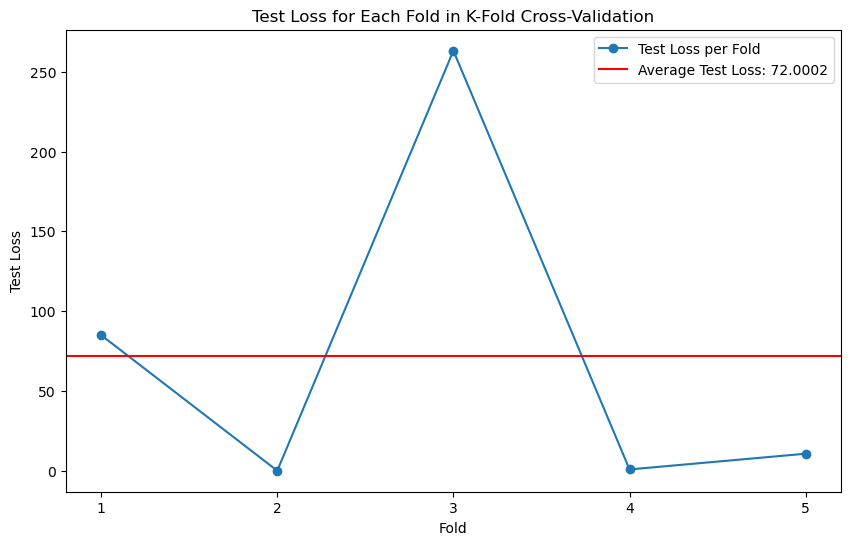

In [20]:
import torch
from torch_geometric.data import DataLoader
import numpy as np
from sklearn.model_selection import KFold

class GAT(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, 1)  

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x



def train_fold(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data).squeeze()
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


def test_fold(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data).squeeze()
            loss = criterion(out, data.y)
            total_loss += loss.item()
    return total_loss / len(loader)



k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

datasets = [torch.load(os.path.join(saved_graphs_folder, f)) for f in os.listdir(saved_graphs_folder) if f.endswith('.pt')]
dataset_list = list(datasets)
test_losses = []

for fold, (train_idx, test_idx) in enumerate(kf.split(dataset_list)):
    train_dataset = [dataset_list[i] for i in train_idx]
    test_dataset = [dataset_list[i] for i in test_idx]

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    model = GAT(num_features=train_dataset[0].num_node_features, hidden_channels=16).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    criterion = L1Loss()
    num_epochs=40
    for epoch in range(num_epochs):  # define num_epochs as needed
        train_fold(model, train_loader, optimizer, criterion)

    test_loss = test_fold(model, test_loader, criterion)
    test_losses.append(test_loss)
    print(f'Fold {fold + 1}, Test Loss: {test_loss:.4f}')

avg_test_loss = np.mean(test_losses)
print(f'Average Test Loss: {avg_test_loss:.4f}')


plt.figure(figsize=(10, 6))
plt.plot(range(1, k + 1), test_losses, marker='o', label='Test Loss per Fold')
plt.axhline(y=avg_test_loss, color='r', linestyle='-', label=f'Average Test Loss: {avg_test_loss:.4f}')
plt.xlabel('Fold')
plt.ylabel('Test Loss')
plt.title('Test Loss for Each Fold in K-Fold Cross-Validation')
plt.xticks(range(1, k + 1))
plt.legend()
plt.show()

# GNN Model with Cross Validation k=5

Fold 1, Test Loss: 1.4123
Fold 2, Test Loss: 2.2979
Fold 3, Test Loss: 11.4833
Fold 4, Test Loss: 0.5339
Fold 5, Test Loss: 5.8493
Average Test Loss: 4.3154


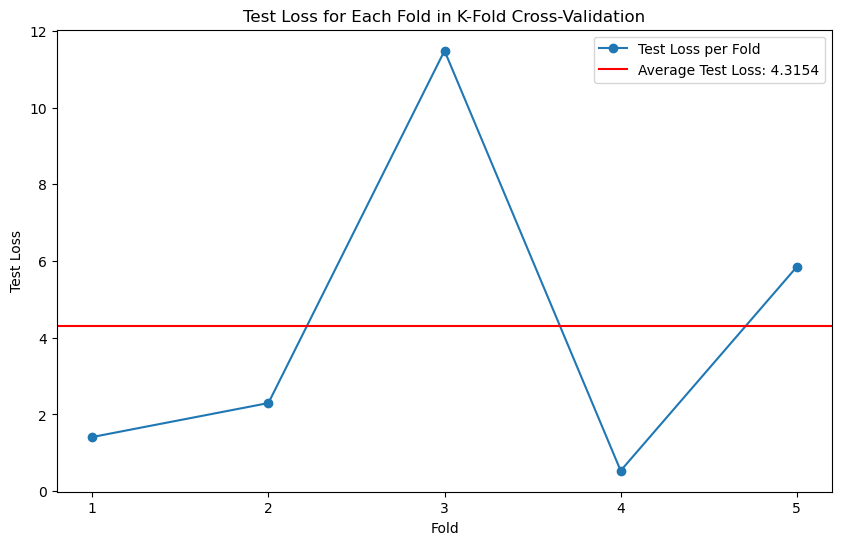

In [21]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
from torch.nn import L1Loss
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import numpy as np

class BasicGNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(BasicGNN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = GCNConv(hidden_channels, 1)  # Assuming a single target value

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.out(x, edge_index)
        return x.squeeze()

def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def test(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            loss = criterion(out, data.y)
            total_loss += loss.item()
    return total_loss / len(loader)

# Prepare for k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
datasets = [torch.load(os.path.join(saved_graphs_folder, f)) for f in os.listdir(saved_graphs_folder) if f.endswith('.pt')]
dataset_list = list(datasets)

test_losses = []

for fold, (train_idx, test_idx) in enumerate(kf.split(dataset_list)):
    train_dataset = [dataset_list[i] for i in train_idx]
    test_dataset = [dataset_list[i] for i in test_idx]
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    model = BasicGNN(num_features=train_dataset[0].num_node_features, hidden_channels=16).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = L1Loss()
    num_epochs = 30
    for epoch in range(num_epochs):  # define num_epochs as needed
        train_loss = train(model, train_loader, optimizer, criterion)
    
    test_loss = test(model, test_loader, criterion)
    test_losses.append(test_loss)
    print(f'Fold {fold + 1}, Test Loss: {test_loss:.4f}')

avg_test_loss = np.mean(test_losses)
print(f'Average Test Loss: {avg_test_loss:.4f}')

# Plotting test loss for each fold
plt.figure(figsize=(10, 6))
plt.plot(range(1, k + 1), test_losses, marker='o', label='Test Loss per Fold')
plt.axhline(y=avg_test_loss, color='r', linestyle='-', label=f'Average Test Loss: {avg_test_loss:.4f}')
plt.xlabel('Fold')
plt.ylabel('Test Loss')
plt.title('Test Loss for Each Fold in K-Fold Cross-Validation')
plt.xticks(range(1, k + 1))
plt.legend()
plt.show()


# Atom to Residue Pooling

Create a new dataset which includes residue_index

In [22]:
import pandas as pd
import torch
from torch_geometric.data import Data
import os

def load_and_process_data(prefix):
    node_file = f'apo/{prefix}_nodes.csv'
    link_file = f'apo/{prefix}_links.csv'

    node_data = pd.read_csv(node_file)
    link_data = pd.read_csv(link_file)

    # Separate features and labels
    labels = node_data['ground_truth'].values
    features = node_data.drop(columns=['ground_truth'])

    node_features = features[['residue_index','atom_type', 'residue_type', 'center_x', 'center_y', 'center_z', 'radius', 'voromqa_sas_potential', 'residue_mean_sas_potential', 'residue_sum_sas_potential', 'residue_size', 'sas_area', 'solvdir_x', 'solvdir_y', 'solvdir_z', 'voromqa_sas_energy', 'voromqa_depth', 'voromqa_score_a', 'voromqa_score_r', 'volume', 'volume_vdw', 'ufsr_a1', 'ufsr_a2', 'ufsr_c2', 'ufsr_c3', 'ev28', 'ev56']]
    link_features = link_data[['atom_index1', 'atom_index2', 'area', 'boundary', 'distance', 'voromqa_energy', 'seq_sep_class', 'covalent_bond', 'hbond']]

    # Create edge index
    edge_index = torch.tensor([link_features['atom_index1'].values, link_features['atom_index2'].values], dtype=torch.long)

    # Add self-links and bidirectional links
    self_links = torch.arange(0, len(node_features))
    edge_index = torch.cat([edge_index, torch.stack([self_links, self_links])], dim=1)
    edge_index = torch.cat([edge_index, edge_index[[1, 0], :]], dim=1)  # Add reverse direction

    # Convert node features and labels to tensors
    node_features_tensor = torch.tensor(node_features.values, dtype=torch.float)
    labels_tensor = torch.tensor(labels, dtype=torch.float)

    # Create graph data object
    data = Data(x=node_features_tensor, edge_index=edge_index, y=labels_tensor)

    return data


candidate_pairs_file = 'apo/candidate_pairs.txt'
candidate_pairs = pd.read_csv(candidate_pairs_file, delim_whitespace=True)


graphs = {}
for index, row in candidate_pairs.iterrows():
    prefix = f"{row['apo_pdb_id']}_{row['apo_chain_id']}"
    graphs[prefix] = load_and_process_data(prefix)



save_dir = 'saved_graphs_wr'
os.makedirs(save_dir, exist_ok=True)


for prefix, graph in graphs.items():
    save_path = os.path.join(save_dir, f'{prefix}_graph.pt')
    torch.save(graph, save_path)

print(f"All graphs have been saved in the directory: {save_dir}")

All graphs have been saved in the directory: saved_graphs_wr


# GNN With Pooling (To Fix)

In [27]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader
from torch.nn import L1Loss
import matplotlib.pyplot as plt

class ResiduePoolingGNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(ResiduePoolingGNN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = torch.nn.Linear(hidden_channels, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))

        # Pooling at the residue level
        x = global_mean_pool(x, batch)

        x = self.out(x)
        return x.squeeze()

def process_data_for_pooling(graph):
    residue_index = graph.x[:, 0].long()  # Extract residue_index from the first column
    graph.batch = residue_index

    # Aggregate labels by residue
    unique_residues, residue_labels = torch.unique(residue_index, return_counts=False, return_inverse=True)
    aggregated_labels = torch.zeros(unique_residues.size(0), dtype=graph.y.dtype)
    for i, idx in enumerate(unique_residues):
        aggregated_labels[i] = graph.y[residue_index == idx].mean()  # Mean or other aggregation method

    graph.y = aggregated_labels
    graph.x = graph.x[:, 1:]  # Exclude the first column (residue_index)
    return graph

# Example data loading and processing
saved_graphs_folder = 'saved_graphs_wr'
datasets = [process_data_for_pooling(torch.load(os.path.join(saved_graphs_folder, f))) for f in os.listdir(saved_graphs_folder) if f.endswith('.pt')]

# Split datasets into train and test sets
train_size = int(0.8 * len(datasets))
train_dataset = datasets[:train_size]
test_dataset = datasets[train_size:]

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResiduePoolingGNN(num_features=train_dataset[0].x.size(1), hidden_channels=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = L1Loss()

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def test():
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            loss = criterion(out, data.y)
            total_loss += loss.item()
    return total_loss / len(test_loader)

train_losses, test_losses = [], []
for epoch in range(20):  # Define the number of epochs
    train_loss = train()
    test_loss = test()
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Plotting the training and testing loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(test_losses, label='Test Loss', color='red', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


/Users/ariel.flahaut/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([36803])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (16) must match the size of tensor b (36803) at non-singleton dimension 0